In [1]:
import torch
import wikipedia
from tqdm import tqdm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [13]:
def get_all_articles_near_clust(clust, already_obtained={}, 
                                keep_content=False, get_embeddings=False, model_funct=None):
    '''
    Function for getting all of the wikipedia articles near a given cluster 
    (within a radius of 10 km)
    '''
    lat = clust['latitude']
    lng = clust['longitude']
    article_titles = wikipedia.geosearch(lat, lng, results=1000, radius=10000)
    pages_info = {}
    for article_title in article_titles:
        if article_title not in already_obtained:
            try:
                page = wikipedia.page(article_title, auto_suggest=False)
                print(f"Processing {page.title}")
                pages_info[page.title]={'latitude' : page.coordinates[0], 
                                         'longitude': page.coordinates[1]}
                if keep_content:
                    pages_info[page.title]['text'] = page.content

                if get_embeddings:
                    pages_info[page.title]['embedding'] = model_funct(page.content) #model_funct(page.title)
            except:
                pass
    return pages_info

#### Load ERNIE Model

In [2]:
# ERNIE:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-en")
model = AutoModel.from_pretrained("nghuyong/ernie-2.0-en")

In [3]:
def get_article_embedding(content, tokenizer, model):
    '''
    Get vector embedding from the text of an article. 
    
    Args:
    content: str. 
             the text of teh article
    
    tokenizer: transformers tokenizer.
    
    mode: transformers model (assumed to be ERNIE or BERT-like).
    
    Returns:
    embeds: a torch tensor representing the document vector. 
    '''
    # Split article into sentences
    sents = content.split(".")
    embeds = []
    # Do not copmpute model gradients
    with torch.no_grad():
        # Iterate over sentences
        for sent in sents: #tqdm(sents, desc="Sentence Progress:"):
            try:
                # Encode the model using the tokenizer and then run the model
                encoded_input = tokenizer(sent, return_tensors='pt')
                output = model(**encoded_input)
                # Get vector embedding for the CLS token of the sentence
                class_embedding = output.last_hidden_state[0, 0,:]
                # Assemble a list of sentence embeddings 
                embeds.append(class_embedding)
            except:
                try:
                    split_sents = sent.split(' ')
                    sent1 = ' '.join(split_sents[:len(split_sents)//2])
                    sent2 = ' '.join(split_sents[len(split_sents)//2:])
                    # Encode the model using the tokenizer and then run the model
                    encoded_input = tokenizer(sent1, return_tensors='pt')
                    output = model(**encoded_input)
                    # Get vector embedding for the CLS token of the sentence
                    class_embedding = output.last_hidden_state[0, 0,:]
                    # Assemble a list of sentence embeddings 
                    embeds.append(class_embedding)
                    
                    # Encode the model using the tokenizer and then run the model
                    encoded_input = tokenizer(sent2, return_tensors='pt')
                    output = model(**encoded_input)
                    # Get vector embedding for the CLS token of the sentence
                    class_embedding = output.last_hidden_state[0, 0,:]
                    # Assemble a list of sentence embeddings 
                    embeds.append(class_embedding)

                except Exception as e:
                    print(e)
                    
    # Global Max pool (maybe use some other aggregation function)
    embeds = torch.stack(embeds)
    embeds, _  = torch.max(embeds, 0)
    return embeds

In [6]:
dhs_clusts = pd.read_csv('data/dhs_clusters.csv')

In [7]:
dhs_clusts.head()

,country,year,lat,lon,wealthpooled,households,urban_rural
0,angola,2011,-12.350257,13.534922,2.595618,36,1
1,angola,2011,-12.360865,13.551494,2.209620,32,1
2,angola,2011,-12.613421,13.413085,0.906469,36,1
3,angola,2011,-12.581454,13.397711,1.105359,35,1
4,angola,2011,-12.578135,13.418748,1.879344,37,1


In [8]:
def process_country(country, year, country_abrev, dhs_df, plot=True):
    country_clusts = dhs_clusts[(dhs_clusts['country']== country) & (dhs_clusts['year']== year)]
    country_clusts = country_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})
    country_wiki_articles = {}
    for i in tqdm(range(len(country_clusts)), desc="Cluster Progress:"):
        country_wiki_articles.update(get_all_articles_near_clust(country_clusts.iloc[i], 
                                                         already_obtained=country_wiki_articles, 
                                                         keep_content=True, get_embeddings=True, 
                                                         model_funct= lambda x: get_article_embedding(x, tokenizer, model)))
    
    country_article_df = pd.DataFrame(country_wiki_articles).T
    country_article_df['embedding'] = country_article_df['embedding'].apply(lambda x : x.numpy())
    country_article_df = country_article_df.reset_index()
    country_article_df.rename(columns={'index': 'title'}, inplace=True)
    country_article_df.to_csv(f'{country}_Wiki.csv', index=False)

    if plot:
        # Plot articles and clusters
        adm2 = gpd.read_file(f'data/{country}/gadm36_{country_abrev}_shp/gadm36_{country_abrev}_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

        # plot
        fig, ax = plt.subplots(figsize=(10, 10))
        plot = adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
        plot = ax.scatter(country_clusts['longitude'], country_clusts['latitude'],
                          c='red', s=15, label='DHS Clusters') # plot survey clusters
        ax.scatter(country_article_df['longitude'], country_article_df['latitude'],
                          c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
        ax.spines['left'].set_visible(False) # hide all axes
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{year} {country} DHS Clusters and Geolocated Wikipedia Articles')
        ax.legend()
        plt.savefig(f'{country}_Wiki_Articles_and_{year}_DHS_Clusts.png')
        plt.show()
    
    return country_article_df

Cluster Progress::   0%|          | 0/422 [00:00<?, ?it/s]

Processing Nsawam
Processing Nsawam Adoagyire (municipal district)
Processing Adoagyiri
Processing Akuapim District
Processing Adeiso
Processing Upper West Akim (district)
Processing Pokrom


Cluster Progress::   0%|          | 1/422 [00:10<1:14:13, 10.58s/it]

Processing Afigya Kwabre South District
Processing Kodie, Ghana
Processing Afigya Kwabre District
Processing Abrepo
Processing Suame Municipal District
Processing Tafo
Processing Old Tafo Municipal District
Processing Wesley College of Education, Kumasi
Processing Kumasi City Mall
Processing Pankrono
Processing Adanwomase
Processing Ahwiaa
Processing Abrankese Stadium
Processing Prempeh College
Processing Kumasi High School
Processing Serwaa Nyarko Girls' Senior High School
Processing Kumasi Zoo
Processing Komfo Anokye Teaching Hospital
Processing Kejetia, Kumasi, Ghana
Processing Kumasi Nurses and Midwifery Training School
Processing Wesley Methodist Cathedral (Kumasi)
Processing St Peter's Cathedral Basilica, Kumasi
Processing Adum
Processing Kumasi Airport
Processing Afigya Sekyere District
Processing Sekyere South District
Processing Agona
Processing Ramseyer Memorial Presbyterian Church
Processing Asokore Mampong (municipal district)
Processing Asokore Mampong
Processing Anglican 

Cluster Progress::   0%|          | 2/422 [02:12<5:07:17, 43.90s/it]

Processing Buduburam
Processing Kasoa
Processing KAAF University College
Processing West Hills Mall
Processing University College of Management Studies


Cluster Progress::   1%|          | 3/422 [02:26<4:05:31, 35.16s/it]

Processing Bunkpurugu


Cluster Progress::   1%|          | 4/422 [02:28<2:53:58, 24.97s/it]

Processing Oduom
Processing Anwomaso
Processing Asokwa Municipal District
Processing Antoa
Processing Ejisu
Processing Kotei
Processing Kasei, Ghana
Processing Bantama


Cluster Progress::   1%|          | 5/422 [02:39<2:25:44, 20.97s/it]

Processing Mo River


Cluster Progress::   2%|▏         | 9/422 [02:41<1:41:40, 14.77s/it]

Processing Yamfo
Processing St. James Seminary Senior High School


Cluster Progress::   3%|▎         | 11/422 [02:48<1:18:01, 11.39s/it]

Processing Wamanafo


Cluster Progress::   3%|▎         | 12/422 [02:49<57:24,  8.40s/it]  

Processing Asamankese
Processing West Akim Municipal District


Cluster Progress::   4%|▎         | 15/422 [02:52<42:13,  6.22s/it]

Processing Sampa, Ghana
Processing Jaman North District


Cluster Progress::   4%|▍         | 16/422 [02:59<42:18,  6.25s/it]

Processing Hohoe
Processing Hohoe Municipal
Processing Godenu


Cluster Progress::   4%|▍         | 17/422 [03:05<41:56,  6.21s/it]

Processing Asante Akim South Municipal District
Processing Juaso
Processing Asankare
Processing Bompata
Processing Obogu


Cluster Progress::   4%|▍         | 18/422 [03:13<45:18,  6.73s/it]

Processing Gbeogo
Processing Zugu, Ghana


Cluster Progress::   5%|▍         | 19/422 [03:15<36:53,  5.49s/it]

Processing 1892 Sack of Salaga
Processing Salaga
Processing East Gonja Municipal District


Cluster Progress::   5%|▍         | 20/422 [03:21<36:56,  5.51s/it]

Processing Berekum-Jaman District
Processing Berekum
Processing Berekum East Municipal District
Processing Berekum Municipal District
Processing Biadan
Processing Berekum West District
Processing Jinijini
Processing Anyimon


Cluster Progress::   5%|▌         | 22/422 [03:32<36:48,  5.52s/it]

Processing Obrakyere


Cluster Progress::   6%|▌         | 24/422 [03:33<26:57,  4.06s/it]

Processing Ayensuano (district)
Processing Atimatim


Cluster Progress::   6%|▌         | 25/422 [03:36<24:21,  3.68s/it]

Processing Adenta East
Processing Oyarifa
Processing Mechanical Lloyd
Processing Adenta
Processing Ga East Municipal District
Processing West Africa Secondary School
Processing Ayi Mensa
Processing Pantang
Processing Abokobi
Processing Madina, Ghana
Processing Ashesi University
Processing Impact Hub Accra
Processing Berekuso
Processing Galaxy International School, Accra
Processing Asoprochona
Processing Mobile Web Ghana
Processing Action Senior High & Technical School
Processing Wisconsin International University College
Processing Presbyterian Boys' Senior High School


Cluster Progress::   6%|▋         | 27/422 [04:10<50:38,  7.69s/it]

Processing Konongo, Ghana
Processing Asante Akim Central Municipal District
Processing Patriensa


Cluster Progress::   7%|▋         | 28/422 [04:15<45:18,  6.90s/it]

Processing Nkoranza


Cluster Progress::   7%|▋         | 29/422 [04:17<34:54,  5.33s/it]

Processing Weta, Ghana
Processing Tadzewu


Cluster Progress::   7%|▋         | 31/422 [04:19<26:37,  4.09s/it]

Processing Labadi
Processing Iscom University Benin
Processing Zenith University College
Processing La General Hospital
Processing Labone Senior High School
Processing The Bank Hospital
Processing Open University of West Africa
Processing Korle-Klottey Municipal District
Processing Osu, Accra
Processing Ghana International School
Processing El Wak Stadium
Processing Cantonments, Accra
Processing High Commission of Nigeria, Accra
Processing Ghana Planetarium
Processing Ebenezer Presbyterian Church, Osu
Processing Osu Castle
Processing 37 Military Hospital
Processing Jubilee House
Processing Ako Adjei Interchange
Processing Royal Netherlands Embassy in Ghana
Processing Parliament of Ghana
Processing Kotoka International Airport
Processing Allied Air Flight 111
Processing Access Bank Ghana Plc
Processing Ghana-India Kofi Annan Centre of Excellence in ICT
Processing Consolidated Bank Ghana
Processing Liberation Day Monument
Processing Accra Ghana Temple
Processing La Tante DC10 Restaurant


Cluster Progress::   8%|▊         | 34/422 [11:14<4:46:38, 44.33s/it]

Processing Breman Asikuma
Processing Asikuma/Odoben/Brakwa District
Processing Central Region (Ghana)


Cluster Progress::   8%|▊         | 35/422 [11:19<3:29:23, 32.46s/it]

Processing Kwesimintsim, Ghana
Processing Takoradi European Public Cemetery
Processing Tanokrom, Takoradi
Processing Gyandu Park
Processing Sekondi-Takoradi
Processing Shama Ahanta East Metropolitan District
Processing Effia
Processing Takoradi Market Circle
Processing Takoradi Technical University
Processing Roman Catholic Diocese of Sekondi–Takoradi
Processing Bompeh Senior High Technical School
Processing Effiakuma
Processing New Takoradi
Processing Ghana Senior High Technical School (Takoradi)
Processing Bisa Abrewa Museum
Processing Fijai
Processing Takoradi Harbour
Processing Botumagyabu
Processing St. John's School, Sekondi
Processing Petronia City
Processing Ahantaman Girls Senior High School


Cluster Progress::   9%|▉         | 37/422 [12:00<3:05:36, 28.93s/it]

Processing Savelugu Municipal District
Processing Savelugu-Nanton Municipal District
Processing Savelugu
Processing Kogni


Cluster Progress::   9%|▉         | 38/422 [12:06<2:20:57, 22.02s/it]

Processing Tsito
Processing Tongor Kaira
Processing Peki (Krepi)
Processing Peki


Cluster Progress::   9%|▉         | 39/422 [12:17<2:00:09, 18.82s/it]

Processing Mankessim


Cluster Progress::   9%|▉         | 40/422 [12:20<1:28:14, 13.86s/it]

Processing Old Tafo
Processing Cocoa Research Institute of Ghana
Processing Bososo
Processing Bunso Arboretum


Cluster Progress::  10%|▉         | 41/422 [12:25<1:12:03, 11.35s/it]

Processing Jema
Processing Kintampo South District


Cluster Progress::  11%|█         | 45/422 [12:28<51:17,  8.16s/it]  

Processing Anlo Senior High School
Processing Cape St. Paul Lighthouse
Processing Woe, Ghana
Processing Anloga
Processing Tegbi
Processing Anloga District
Processing Dzelukope
Processing Alakple


Cluster Progress::  11%|█         | 46/422 [12:43<1:03:05, 10.07s/it]

Processing Assin South District
Processing Assin Kyekyewere


Cluster Progress::  11%|█         | 47/422 [12:45<49:00,  7.84s/it]  

Processing Krowor Municipal District
Processing Ledzokuku-Krowor Municipal District
Processing Nungua
Processing Sakumono


Cluster Progress::  11%|█▏        | 48/422 [12:55<52:53,  8.48s/it]

Processing Zambo, Ghana
Processing Lawra


Cluster Progress::  12%|█▏        | 49/422 [12:59<44:00,  7.08s/it]

Processing Upper Denkyira West District
Processing Diaso
Processing Bibiani/Anhwiaso/Bekwai Municipal District


Cluster Progress::  12%|█▏        | 51/422 [13:03<34:27,  5.57s/it]

Processing Sekondi-Takoradi Stadium
Processing Inchaban
Processing Takoradi Thermal Power Station


Cluster Progress::  12%|█▏        | 52/422 [13:08<33:18,  5.40s/it]

Processing Tagbo Falls
Processing Nkonya Ahenkro
Processing Kpeme


Cluster Progress::  13%|█▎        | 54/422 [13:12<27:08,  4.43s/it]

Processing Ajumako
Processing Mumford, Ghana
Processing Gomoa District
Processing Esakyir
Processing Ekumfi District
Processing Gomoa West District
Processing Apam
Processing Otuam


Cluster Progress::  13%|█▎        | 55/422 [13:27<45:29,  7.44s/it]

Processing Wa, Ghana
Processing Wa District
Processing Wa Municipal District
Processing Roman Catholic Diocese of Wa
Processing Wa Senior High Technical School
Processing Wa Technical University
Processing Charia, Ghana


Cluster Progress::  14%|█▎        | 57/422 [13:42<45:40,  7.51s/it]

Processing Juaben
Processing Juaben Municipal District
Processing Adanwomase Senior High School
Processing Sakora Wonoo
Processing Asonomaso
Processing Ejisu-Juaben Municipal District
Processing Ejisu Municipal District
Processing Ntonso
Processing Bobiri
Processing Effiduase
Processing Sekyere East District


Cluster Progress::  14%|█▍        | 59/422 [13:59<47:00,  7.77s/it]

Processing Jirapa/Lambussie District
Processing Jirapa, Ghana


Cluster Progress::  14%|█▍        | 60/422 [14:04<41:03,  6.81s/it]

Processing Bawku East District
Processing Bawku Municipal District
Processing Bawku
Processing Mogomnore


Cluster Progress::  15%|█▍        | 63/422 [14:11<32:40,  5.46s/it]

Processing Enchi
Processing Aowin/Suaman District


Cluster Progress::  15%|█▌        | 65/422 [14:15<26:26,  4.44s/it]

Processing Achiase District
Processing Achiase
Processing Aperadi
Processing Akim Swedru
Processing Birim South District
Processing Akim Oda
Processing Birim District
Processing Birim Central Municipal District


Cluster Progress::  16%|█▌        | 66/422 [14:30<44:52,  7.56s/it]

Processing Mamiri Forest Reserve


Cluster Progress::  16%|█▌        | 67/422 [14:32<35:17,  5.97s/it]

Processing Daka River


Cluster Progress::  16%|█▋        | 69/422 [14:33<25:49,  4.39s/it]

Processing Nkroful
Processing Essiama
Processing Ankobra River


Cluster Progress::  17%|█▋        | 71/422 [14:39<22:39,  3.87s/it]

Processing Nandom
Processing Lambussie


Cluster Progress::  17%|█▋        | 72/422 [14:44<24:36,  4.22s/it]

Processing Bimbilla


Cluster Progress::  18%|█▊        | 75/422 [14:46<18:14,  3.15s/it]

Processing Yendi Municipal District
Processing Yendi
Processing Roman Catholic Diocese of Yendi
Processing Meda, Togo


Cluster Progress::  18%|█▊        | 77/422 [14:52<18:24,  3.20s/it]

Processing Techimantia
Processing Duayaw Nkwanta
Processing Tano North Municipal District


Cluster Progress::  19%|█▊        | 79/422 [14:57<16:52,  2.95s/it]

Processing Ghana Communication Technology University
Processing Accra Academy
Processing Darkuman
Processing Bubuashie
Processing Ablekuma North Municipal District
Processing Mataheko
Processing Lapaz (Accra)
Processing Achimota
Processing Achimota Transport Terminal
Processing Abeka-Lapaz
Processing Okaikwei North Municipal District
Processing Accra Institute of Technology
Processing Methodist University College Ghana
Processing Hindu Monastery of Africa
Processing Odorkor
Processing Akweteyman
Processing Christian Village
Processing St Martin de Porres School
Processing Sakaman
Processing Kwashieman
Processing Alpha Beta Christian College
Processing Dansoman
Processing Ablekuma West Municipal District
Processing Dansoman Park
Processing Achimota Retail Centre
Processing Awoshie
Processing Mallam Interchange
Processing University of Ghana
Processing The Balme Library
Processing Dome, Ghana
Processing Gbegbe
Processing Haatso
Processing Ghana Institute of Languages


Cluster Progress::  19%|█▉        | 82/422 [16:17<57:07, 10.08s/it]

Processing Bongo District
Processing Bongo, Ghana


Cluster Progress::  20%|█▉        | 84/422 [16:21<43:15,  7.68s/it]

Processing Telania


Cluster Progress::  20%|██        | 86/422 [16:22<31:04,  5.55s/it]

Processing Taifa, Accra
Processing Reverend John Teye Memorial Institute
Processing University of Professional Studies
Processing Gbawe


Cluster Progress::  21%|██        | 87/422 [16:30<34:56,  6.26s/it]

Processing Weija Dam
Processing Weija


Cluster Progress::  21%|██        | 88/422 [16:33<28:30,  5.12s/it]

Processing Potrikrom


Cluster Progress::  21%|██        | 89/422 [16:34<21:55,  3.95s/it]

Processing Santeo
Processing Mfantsiman Girls' Secondary School
Processing Agona East District


Cluster Progress::  21%|██▏       | 90/422 [16:38<22:34,  4.08s/it]

Processing Wiamoase
Processing Asem, Kumasi


Cluster Progress::  22%|██▏       | 91/422 [16:42<21:57,  3.98s/it]

Processing Nkwatia Kwahu
Processing Abetifi
Processing Oboo, Ghana
Processing Abetifi Presbyterian College of Education
Processing Obomeng
Processing Bepong, Ghana
Processing Atibie, Ghana
Processing Kwahu District
Processing Mpraeso
Processing Kwahu Plateau
Processing Pepease
Processing Nkawkaw
Processing Kwahu West Municipal District


Cluster Progress::  22%|██▏       | 93/422 [17:03<32:12,  5.87s/it]

Processing Kwame Danso
Processing Sene District
Processing Sene West (district)


Cluster Progress::  23%|██▎       | 96/422 [17:07<24:35,  4.53s/it]

Processing Bunso, Ghana


Cluster Progress::  23%|██▎       | 97/422 [17:08<19:14,  3.55s/it]

Processing Dzolokpuita
Processing Vane, Avatime
Processing Amedzofe, Ghana
Processing Hlefi
Processing Kpedze


Cluster Progress::  24%|██▎       | 100/422 [17:17<17:53,  3.33s/it]

Processing Sunyani West District
Processing Odumase, Ghana
Processing Fiapre
Processing Notre Dame High School (Ghana)
Processing Coronation Park (Sunyani, Ghana)
Processing Sunyani Municipal District
Processing Abesim
Processing Sunyani
Processing Sunyani Technical University


Cluster Progress::  24%|██▍       | 101/422 [17:36<43:39,  8.16s/it]

Processing Pru East District
Processing Pru District
Processing Yeji


Cluster Progress::  24%|██▍       | 102/422 [17:41<38:11,  7.16s/it]

Processing Mepe
Processing Battor
Processing Aveyime-Battor
Processing Angongwi
Processing Adidome
Processing North Tongu District


Cluster Progress::  25%|██▍       | 104/422 [17:49<33:25,  6.31s/it]

Processing Nzema Solar Power Station


Cluster Progress::  25%|██▍       | 105/422 [17:52<26:47,  5.07s/it]

Processing Gbefi
Processing Kpando Municipal District
Processing Kpando


Cluster Progress::  25%|██▌       | 106/422 [17:57<26:28,  5.03s/it]

Processing Hamile
Processing Ouessa
Processing Ouessa Department


Cluster Progress::  26%|██▌       | 108/422 [18:00<21:22,  4.09s/it]

Processing Akuapim-Mampong
Processing Tetteh Quarshie Memorial Hospital
Processing Aburi Botanical Gardens
Processing Methodist Girls' High School (Mamfe)


Cluster Progress::  26%|██▌       | 110/422 [18:07<20:12,  3.89s/it]

Processing Sunon Asogli Thermal Power Station
Processing Armech Thermal Power Station
Processing Kpone Thermal Power Station II
Processing Adjei Kojo
Processing Volta Aluminum Company
Processing Tema Community 1
Processing Tema
Processing Kpone Thermal Power Station I
Processing Tema Community 5
Processing Tema Motorway Interchange
Processing Chemu Senior High School
Processing Ashaiman Senior High School
Processing Ghana Cement
Processing Prampram
Processing Tema West Municipal District
Processing Tema Metropolitan District
Processing Michel Camp
Processing Tema General Hospital
Processing Ningo Prampram District
Processing African Science Academy
Processing Tema Harbour
Processing Miotso
Processing Ashaiman
Processing Lashibi
Processing Sakumo Ramsar Site
Processing Sakumono Lagoon


Cluster Progress::  26%|██▋       | 111/422 [18:56<1:30:16, 17.42s/it]

Processing Kpong
Processing Nuaso
Processing Kpong Airfield
Processing Lower Manya Krobo Municipal District
Processing Agormanya
Processing Senchi
Processing Kpong Dam
Processing Somanya
Processing Yilo Krobo Municipal District
Processing Kaoga District
Processing Atimpoko


Cluster Progress::  27%|██▋       | 115/422 [19:16<1:09:57, 13.67s/it]

Processing Densu River


Cluster Progress::  27%|██▋       | 116/422 [19:18<52:09, 10.23s/it]  

Processing Akyem-Awenare
Processing Kwabeng
Processing Atiwa West District
Processing Atiwa District
Processing Abuakwa South Municipal District
Processing Bomaa
Processing Anyinam
Processing Atiwa East District
Processing Abuakwa North Municipal District


Cluster Progress::  28%|██▊       | 117/422 [19:34<1:01:03, 12.01s/it]

Processing Cape Coast Sports Stadium
Processing Cape Coast Metropolitan Assembly
Processing University Practice Secondary School
Processing Amissano
Processing Effutu
Processing Adisadel College
Processing University of Cape Coast Hospital
Processing Cape Coast Technical University
Processing University of Cape Coast
Processing St. Augustine's College (Cape Coast)
Processing Our Lady of Apostles (OLA) College of Education
Processing Mfantsipim School
Processing Fosu Lagoon
Processing Fort Victoria, Cape Coast
Processing Roman Catholic Archdiocese of Cape Coast
Processing Agona West Municipal District
Processing Cape Coast
Processing Cape Coast Castle
Processing Cape Coast Castle Museum
Processing St. Joseph's Minor Basilica Church
Processing Elmina Castle
Processing Elmina
Processing Komenda/Edina/Eguafo/Abirem Municipal District
Processing Aggrey Memorial A.M.E. Zion Senior High School


Cluster Progress::  28%|██▊       | 120/422 [20:52<1:21:35, 16.21s/it]

Processing Roman Catholic Diocese of Techiman
Processing Roman Catholic Diocese of Sunyani
Processing Techiman Municipal District
Processing Techiman
Processing Wenchi
Processing Wenchi Municipal District
Processing Tano River
Processing Techiman North District
Processing Tuobodom
Processing Aworowa
Processing Buoyem


Cluster Progress::  29%|██▉       | 124/422 [21:21<34:41,  6.98s/it]  

Processing Lebanon, Ashaiman


Cluster Progress::  30%|███       | 128/422 [21:25<10:52,  2.22s/it]

Processing Akatsi College of Education
Processing Roman Catholic Diocese of Keta–Akatsi
Processing Akatsi
Processing Akatsi District


Cluster Progress::  31%|███       | 131/422 [21:39<14:37,  3.02s/it]

Processing Wassa-Akropong
Processing Wassa Amenfi East Municipal District


Cluster Progress::  32%|███▏      | 134/422 [21:45<09:04,  1.89s/it]

Processing Ziou Department
Processing Zecco Department


Cluster Progress::  32%|███▏      | 135/422 [21:49<12:05,  2.53s/it]

Processing Pokuase Interchange
Processing Kwabenya


Cluster Progress::  33%|███▎      | 138/422 [21:54<08:23,  1.77s/it]

Processing Tarkwa
Processing Iduapriem Gold Mine
Processing TNA Park
Processing Wassa West District
Processing George Grant University of Mines and Technology
Processing Tarkwa Senior High School
Processing Tarkwa mine
Processing Aboso


Cluster Progress::  34%|███▎      | 142/422 [22:14<12:11,  2.61s/it]

Processing Obuasi Airport
Processing Jacobu
Processing Akrofuom District
Processing Akrokerri


Cluster Progress::  35%|███▍      | 146/422 [22:23<08:03,  1.75s/it]

Processing Tamale Stadium
Processing Tamale, Ghana
Processing Tamale Girls' Senior High School
Processing Anbariya Sunni Community
Processing Tamale Metropolitan District
Processing Tamale Technical University
Processing Sakasaka
Processing Roman Catholic Archdiocese of Tamale
Processing Zujung
Processing Tamale Teaching Hospital
Processing University for Development Studies
Processing Jisonaayili
Processing Kanvili
Processing Dungu, Ghana
Processing Taha, Ghana
Processing Yong, Ghana


Cluster Progress::  35%|███▌      | 149/422 [22:59<26:58,  5.93s/it]

Processing Awutu/Effutu/Senya District
Processing Effutu Municipal District
Processing Winneba
Processing Muni-Pomadze Ramsar Site
Processing Ayensu River
Processing Gomoa Mpota


Cluster Progress::  36%|███▌      | 150/422 [23:12<37:15,  8.22s/it]

Processing Tongo, Ghana
Processing Talensi-Nabdam District
Processing Tongo Hills
Processing Bolgatanga District
Processing Bolgatanga Municipal District
Processing Bolgatanga


Cluster Progress::  36%|███▌      | 152/422 [23:28<33:23,  7.42s/it]

Processing Lake Bosumtwi
Processing Asiwa
Processing Bosome Freho District


Cluster Progress::  36%|███▋      | 153/422 [23:41<40:20,  9.00s/it]

Processing Amasaman
Processing Pokuase, Ghana
Processing Ga West Municipal District
Processing Ashongman
Processing Kuntunse
Processing Ghana Satellite Earth Station


Cluster Progress::  37%|███▋      | 155/422 [24:00<37:35,  8.45s/it]

Processing Moree, Ghana
Processing Yamoransa


Cluster Progress::  37%|███▋      | 156/422 [24:06<33:50,  7.63s/it]

Processing Shai Hills
Processing Amanokrom
Processing Christ Presbyterian Church, Akropong
Processing Akrofi-Christaller Institute
Processing Akropong
Processing Akuapim North Municipal District
Processing Dawu (Ghana)
Processing Abiriw


Cluster Progress::  37%|███▋      | 157/422 [24:30<56:01, 12.68s/it]

Processing Roman Catholic Diocese of Obuasi
Processing Len Clay Stadium
Processing Obuasi Municipal District
Processing Obuasi East District
Processing Adansi West District
Processing Dominase
Processing Obuasi
Processing Obuasi Gold Mine
Processing Akrofuom


Cluster Progress::  37%|███▋      | 158/422 [24:49<1:04:14, 14.60s/it]

Processing Navrongo Airport
Processing Cathedral Basilica of Our Lady of Seven Sorrows
Processing Roman Catholic Diocese of Navrongo–Bolgatanga
Processing Kassena-Nankana Municipal District
Processing Navrongo
Processing Kassena-Nankana District
Processing Navrongo Solar Power Station
Processing Kassena-Nankana West District
Processing Pikworo Slave camp
Processing Paga Crocodile Pond


Cluster Progress::  38%|███▊      | 160/422 [25:24<1:03:03, 14.44s/it]

Processing Offinso North District
Processing Akumadan


Cluster Progress::  38%|███▊      | 162/422 [25:29<35:55,  8.29s/it]  

Processing Agona Senior High School


Cluster Progress::  39%|███▉      | 166/422 [25:32<10:27,  2.45s/it]

Processing Paga


Cluster Progress::  40%|████      | 169/422 [25:36<05:53,  1.40s/it]

Processing Suhum/Kraboa/Coaltar District
Processing Suhum Municipal District
Processing Asuboe


Cluster Progress::  40%|████      | 170/422 [25:42<12:31,  2.98s/it]

Processing Adafienu
Processing Hedzranawo
Processing Three Town Senior High School
Processing Denu
Processing Ketu Municipal District
Processing Tokor
Processing Nogokpo
Processing Diamond Cement Ghana Limited
Processing Klikor
Processing Agbozume


Cluster Progress::  41%|████      | 171/422 [26:03<34:34,  8.26s/it]

Processing Pampanso
Processing Pakro
Processing Dago, Ghana


Cluster Progress::  41%|████      | 173/422 [26:10<22:54,  5.52s/it]

Processing Volta Regional Museum
Processing Roman Catholic Diocese of Ho
Processing Ho Municipal
Processing Ho, Ghana
Processing OLA Girls Senior High School (Ho)
Processing Mawuko Girls Senior High School
Processing Mawuli School
Processing Ho Technical University
Processing Ho Teaching Hospital
Processing Klefe
Processing Akrofu


Cluster Progress::  41%|████      | 174/422 [26:33<44:56, 10.87s/it]

Processing Lungni
Processing Kpandai District
Processing Kpandai


Cluster Progress::  41%|████▏     | 175/422 [26:41<40:37,  9.87s/it]

Processing Barekese Senior High School
Processing Atwima Nwabiagya North District
Processing Barekese
Processing Barekese Dam


Cluster Progress::  42%|████▏     | 176/422 [26:48<38:01,  9.27s/it]

Processing Acherensua
Processing Ahafo mine
Processing Maaban
Processing Mabang
Processing Asutifi South (district)
Processing Hwidiem
Processing Kenyasi
Processing Asutifi District
Processing Asutifi North (district)


Cluster Progress::  42%|████▏     | 179/422 [27:06<23:54,  5.90s/it]

Processing Kwahu Afram Plains South (district)


Cluster Progress::  43%|████▎     | 180/422 [27:09<19:44,  4.89s/it]

Processing Bolgatanga Girls Senior High School
Processing Zuarungu Senior High School
Processing Bolgatanga East District
Processing Zuarungu


Cluster Progress::  43%|████▎     | 183/422 [27:17<12:01,  3.02s/it]

Processing Dormaa East District
Processing Wamfie


Cluster Progress::  44%|████▎     | 184/422 [27:22<13:50,  3.49s/it]

Processing Tono Dam


Cluster Progress::  44%|████▍     | 186/422 [27:25<09:43,  2.47s/it]

Processing Anomabu
Processing Fort Amsterdam, Ghana
Processing Abandze
Processing Saltpond
Processing Mfantsiman Municipal District


Cluster Progress::  45%|████▍     | 189/422 [27:45<14:48,  3.81s/it]

Processing Akosombo International School
Processing St. Barbara Catholic Church
Processing Akosombo Port
Processing Akosombo
Processing Akosombo Dam
Processing Akwamufie
Processing Adomi Bridge


Cluster Progress::  45%|████▌     | 190/422 [28:09<39:10, 10.13s/it]

Processing Tolon, Ghana
Processing Tolon-Kumbungu District
Processing Tolon District


Cluster Progress::  45%|████▌     | 191/422 [28:18<37:07,  9.64s/it]

Processing Bolgatanga Technical University


Cluster Progress::  45%|████▌     | 192/422 [28:21<29:13,  7.62s/it]

Processing Wiaga
Processing Sandema
Processing Builsa District
Processing Builsa North Municipal District


Cluster Progress::  46%|████▋     | 196/422 [28:33<12:33,  3.33s/it]

Processing Sumniboma


Cluster Progress::  47%|████▋     | 198/422 [28:37<09:23,  2.52s/it]

Processing Sikkim Manipal University, Ghana Learning Centre, Accra
Processing All Nations University
Processing New Juaben Municipal District
Processing New Juaben South Municipal Assembly
Processing Eastern Regional Hospital
Processing Roman Catholic Diocese of Koforidua
Processing New Juaben North Municipal Assembly
Processing Oyoko, Koforidua
Processing Koforidua Senior High Technical School
Processing Koforidua
Processing Koforidua Technical University


Cluster Progress::  48%|████▊     | 201/422 [29:10<21:23,  5.81s/it]

Processing Okere District


Cluster Progress::  48%|████▊     | 203/422 [29:14<13:16,  3.64s/it]

Processing Oda Senior High School


Cluster Progress::  48%|████▊     | 204/422 [29:16<11:57,  3.29s/it]

Processing Ankaful


Cluster Progress::  49%|████▊     | 205/422 [29:19<11:44,  3.24s/it]

Processing Japekrom
Processing New Drobo
Processing Jaman South Municipal District
Processing Jaman District


Cluster Progress::  49%|████▉     | 206/422 [29:32<21:31,  5.98s/it]

Processing Kade, Ghana
Processing Otumi
Processing Kwaebibirem Municipal District


Cluster Progress::  49%|████▉     | 207/422 [29:39<22:53,  6.39s/it]

Processing Kpale Kpalime
Processing Adaklu District
Processing Kpeve New Town
Processing Kpeve
Processing South Dayi District
Processing Bame, Ghana


Cluster Progress::  50%|████▉     | 209/422 [29:56<23:54,  6.74s/it]

Processing Gumani


Cluster Progress::  50%|█████     | 212/422 [29:59<09:45,  2.79s/it]

Processing Dambai
Processing Krachi East Municipal District


Cluster Progress::  50%|█████     | 213/422 [30:05<13:03,  3.75s/it]

Processing Anlo Afiadenyigba


Cluster Progress::  51%|█████     | 215/422 [30:08<09:06,  2.64s/it]

Processing Nadowli
Processing Nadowli District


Cluster Progress::  51%|█████     | 216/422 [30:13<11:15,  3.28s/it]

Processing Busunya
Processing Nkoranza North District
Processing Boabeng-Fiema Monkey Sanctuary


Cluster Progress::  51%|█████▏    | 217/422 [30:20<14:35,  4.27s/it]

Processing Bawku West District
Processing Zebilla
Processing Bingo, Boulgou


Cluster Progress::  53%|█████▎    | 222/422 [30:30<05:31,  1.66s/it]

Processing Abura/Asebu/Kwamankese District
Processing Upper Denkyira East Municipal District
Processing Dunkwa-on-Offin
Processing Upper Denkyira District
Processing Gyimi River


Cluster Progress::  53%|█████▎    | 223/422 [30:43<16:57,  5.11s/it]

Processing Binaba


Cluster Progress::  53%|█████▎    | 224/422 [30:45<14:14,  4.32s/it]

Processing Ada West District


Cluster Progress::  53%|█████▎    | 225/422 [30:47<11:56,  3.64s/it]

Processing Dadease
Processing Oyoko
Processing Asamang


Cluster Progress::  54%|█████▍    | 229/422 [30:55<05:49,  1.81s/it]

Processing Akuse


Cluster Progress::  55%|█████▍    | 231/422 [30:57<04:27,  1.40s/it]

Processing Youga
Processing Songo, Burkina Faso


Cluster Progress::  56%|█████▌    | 235/422 [31:04<03:30,  1.12s/it]

Processing Roman Catholic Diocese of Wiawso
Processing Wiawso
Processing Sefwi-Wiawso Municipal District
Processing Futa, Ghana


Cluster Progress::  56%|█████▌    | 236/422 [31:11<09:18,  3.00s/it]

Processing Fort San Sebastian
Processing Pra River (Ghana)


Cluster Progress::  56%|█████▌    | 237/422 [31:17<11:48,  3.83s/it]

Processing Nkoranza South Municipal District
Processing Nkoranza District


Cluster Progress::  58%|█████▊    | 243/422 [31:24<03:12,  1.07s/it]

Processing Asuogyaman District
Processing Atimpoku


Cluster Progress::  58%|█████▊    | 244/422 [31:29<06:15,  2.11s/it]

Processing Potsin


Cluster Progress::  59%|█████▊    | 247/422 [31:32<03:49,  1.31s/it]

Processing Denkyembour
Processing Akwatia
Processing St Roses Senior High (Akwatia)


Cluster Progress::  59%|█████▉    | 249/422 [31:41<07:43,  2.68s/it]

Processing Sewua
Processing Afari, Ghana


Cluster Progress::  60%|█████▉    | 252/422 [31:46<04:47,  1.69s/it]

Processing Afrancho


Cluster Progress::  62%|██████▏   | 261/422 [31:52<01:20,  2.00it/s]

Processing Abuakwa State College
Processing Apedwa
Processing Kibi, Ghana
Processing East Akim Municipal District


Cluster Progress::  62%|██████▏   | 262/422 [32:01<08:17,  3.11s/it]

Processing Fanteakwa North District
Processing Begoro
Processing Fanteakwa District


Cluster Progress::  63%|██████▎   | 265/422 [32:08<05:47,  2.21s/it]

Processing Wassa Amenfi West Municipal District
Processing Asankragua


Cluster Progress::  63%|██████▎   | 267/422 [32:13<05:19,  2.06s/it]

Processing Gbulahagu
Processing Golinga
Processing Foshegu


Cluster Progress::  64%|██████▎   | 268/422 [32:17<07:24,  2.88s/it]

Processing Sefwi Akontombra


Cluster Progress::  64%|██████▎   | 269/422 [32:20<06:53,  2.70s/it]

Processing Agona District
Processing Agona Swedru
Processing Afransi
Processing Gomoa Amoanda
Processing Gomoa Central District


Cluster Progress::  65%|██████▍   | 274/422 [32:32<03:49,  1.55s/it]

Processing Upper West Region


Cluster Progress::  66%|██████▋   | 280/422 [32:38<01:42,  1.38it/s]

Processing Asubima Forest Reserve


Cluster Progress::  67%|██████▋   | 283/422 [32:42<01:58,  1.17it/s]

Processing Apostolic Vicariate of Donkorkrom
Processing Afram Plains District
Processing Kwahu Afram Plains North (district)
Processing Donkorkrom
Processing Adiemmra


Cluster Progress::  68%|██████▊   | 286/422 [32:55<05:17,  2.34s/it]

Processing Half Assini Senior High School
Processing Half Assini


Cluster Progress::  68%|██████▊   | 287/422 [33:00<06:48,  3.03s/it]

Processing Prestea


Cluster Progress::  68%|██████▊   | 288/422 [33:03<06:58,  3.13s/it]

Processing Nzulezo


Cluster Progress::  68%|██████▊   | 289/422 [33:06<06:46,  3.06s/it]

Processing Fodoa


Cluster Progress::  69%|██████▊   | 290/422 [33:08<06:26,  2.92s/it]

Processing Nduom Sports Stadium


Cluster Progress::  69%|██████▉   | 293/422 [33:12<03:21,  1.56s/it]

Processing Gushegu Municipal District
Processing Gushegu
Processing Nawuni


Cluster Progress::  70%|██████▉   | 294/422 [33:18<06:30,  3.05s/it]

Processing Zabzugu-Tatale District
Processing Zabzugu


Cluster Progress::  71%|███████   | 300/422 [33:26<02:03,  1.01s/it]

Processing Ashanti Empire
Processing Gold Coast (region)
Processing Ajumako/Enyan/Essiam District


Cluster Progress::  72%|███████▏  | 302/422 [33:59<14:49,  7.41s/it]

Processing Twifo Praso
Processing Twifo/Heman/Lower Denkyira District


Cluster Progress::  72%|███████▏  | 304/422 [34:03<09:06,  4.63s/it]

Processing Zibogo


Cluster Progress::  73%|███████▎  | 309/422 [34:08<02:27,  1.31s/it]

Processing Naha, Ghana


Cluster Progress::  74%|███████▍  | 312/422 [34:11<01:43,  1.06it/s]

Processing Jasikan
Processing Jasikan District
Processing Roman Catholic Diocese of Jasikan
Processing Tapa Abotoase


Cluster Progress::  75%|███████▍  | 316/422 [34:20<02:23,  1.36s/it]

Processing Abrafo


Cluster Progress::  76%|███████▋  | 322/422 [34:26<01:09,  1.44it/s]

Processing West African Football Academy
Processing Attram De Visser Soccer Academy


Cluster Progress::  77%|███████▋  | 323/422 [34:31<03:16,  1.99s/it]

Processing Kintampo District
Processing Kintampo, Ghana
Processing Kintampo North Municipal District
Processing Kintampo Complex
Processing Kintampo waterfalls


Cluster Progress::  77%|███████▋  | 324/422 [34:47<10:01,  6.13s/it]

Processing North East Region, Ghana
Processing Nalerigu
Processing East Mamprusi Municipal Assembly
Processing Gambaga Witch camp
Processing Gambaga
Processing Gambaga Girls Senior High School


Cluster Progress::  79%|███████▉  | 333/422 [35:05<01:19,  1.12it/s]

Processing Frafraha
Processing Old Ningo


Cluster Progress::  79%|███████▉  | 335/422 [35:13<03:09,  2.18s/it]

Processing Keta Lagoon


Cluster Progress::  82%|████████▏ | 346/422 [35:26<00:40,  1.87it/s]

Processing Offinso
Processing Amowi
Processing Afigya Kwabre North District
Processing Offinso Municipal District


Cluster Progress::  82%|████████▏ | 347/422 [37:47<53:26, 42.76s/it]

Processing Dafor, Ghana
Processing Volta Region
Processing Ve Golokwati
Processing Ve-Koloenu


Cluster Progress::  83%|████████▎ | 349/422 [38:05<30:05, 24.73s/it]

Processing Garu, Ghana
Processing Garu District
Processing Garu-Tempane District


Cluster Progress::  84%|████████▎ | 353/422 [38:19<08:58,  7.81s/it]

Processing Bogoso


Cluster Progress::  84%|████████▍ | 354/422 [38:23<07:33,  6.66s/it]

Processing Walewale
Processing West Mamprusi Municipal Assembly


Cluster Progress::  86%|████████▋ | 364/422 [38:38<01:23,  1.44s/it]

Processing Adansi Asokwa District
Processing Adansi North District
Processing Fomena


Cluster Progress::  87%|████████▋ | 368/422 [38:54<01:56,  2.15s/it]

Processing Kengen, Ghana
Processing Beyin
Processing Atuabo


Cluster Progress::  88%|████████▊ | 372/422 [39:16<02:35,  3.12s/it]

Processing Fanteakwa South District
Processing Osino


Cluster Progress::  90%|████████▉ | 379/422 [39:38<00:57,  1.35s/it]

Processing Kwaso, Ghana
Processing Boankra Inland Port
Processing Boankra


Cluster Progress::  90%|█████████ | 380/422 [39:44<01:58,  2.82s/it]

Processing Amansie South District
Processing Manso Adubia
Processing Agroyesum
Processing Manso Nkwanta
Processing Amansie West District
Processing Asaman


Cluster Progress::  91%|█████████ | 382/422 [40:05<03:51,  5.78s/it]

Processing Senya Beraku


Cluster Progress::  91%|█████████▏| 386/422 [40:11<01:16,  2.14s/it]

Processing Sissala District
Processing Sissala East Municipal District
Processing Tumu, Ghana


Cluster Progress::  92%|█████████▏| 387/422 [40:17<02:00,  3.45s/it]

Processing Adum Banso


Cluster Progress::  92%|█████████▏| 390/422 [40:21<00:57,  1.79s/it]

Processing Kumawu
Processing Sekyere Kumawu (district)
Processing Bomfobiri Wildlife Sanctuary


Cluster Progress::  93%|█████████▎| 392/422 [40:30<01:27,  2.91s/it]

Processing Nsaba
Processing Awutu Breku
Processing Awutu Senya District


Cluster Progress::  93%|█████████▎| 393/422 [40:37<01:53,  3.91s/it]

Processing Kpetoe
Processing Agortime-Kpetoe


Cluster Progress::  95%|█████████▍| 400/422 [40:43<00:18,  1.21it/s]

Processing Satani
Processing Kumbungu


Cluster Progress::  95%|█████████▌| 402/422 [40:48<00:30,  1.52s/it]

Processing Agyina


Cluster Progress::  96%|█████████▌| 405/422 [40:53<00:22,  1.31s/it]

Processing Asuboni Rails


Cluster Progress::  96%|█████████▋| 407/422 [40:56<00:20,  1.35s/it]

Processing Lawra/Nandom District
Processing Lawra Municipal District


Cluster Progress::  97%|█████████▋| 408/422 [41:02<00:37,  2.70s/it]

Processing Kpilo
Processing Gumo
Processing Nyeshie


Cluster Progress::  97%|█████████▋| 409/422 [41:09<00:53,  4.14s/it]

Processing Wa West District
Processing Wechiau


Cluster Progress::  97%|█████████▋| 410/422 [41:15<00:54,  4.54s/it]

Processing Asunafo North Municipal District
Processing Goaso
Processing Asunafo District
Processing Roman Catholic Diocese of Goaso
Processing Santa, Ghana


Cluster Progress::  98%|█████████▊| 412/422 [41:29<00:53,  5.35s/it]

Processing Amanten


Cluster Progress::  98%|█████████▊| 413/422 [41:33<00:42,  4.74s/it]

Processing Aduman


Cluster Progress::  99%|█████████▊| 416/422 [41:37<00:14,  2.45s/it]

Processing Chato, Ghana


Cluster Progress:: 100%|██████████| 422/422 [41:43<00:00,  5.93s/it]


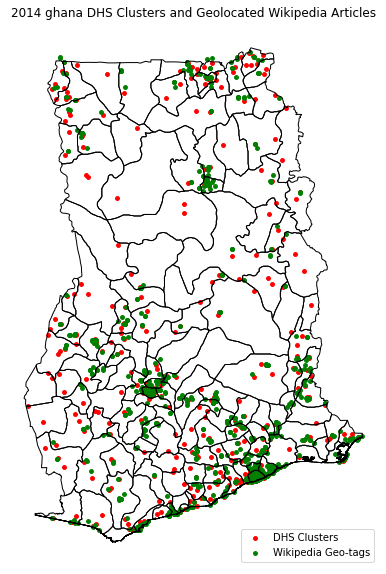

In [61]:
gh_articles = process_country('ghana', 2014, 'GHA', dhs_clusts, plot=True)

Cluster Progress::   0%|          | 0/208 [00:00<?, ?it/s]

Processing Opportunity Bank Uganda Limited
Processing Pride Microfinance Limited
Processing Kamwookya
Processing Institute of Certified Public Accountants of Uganda
Processing Bukoto
Processing Uganda Radio Network
Processing Women's Hospital International and Fertility Centre
Processing List of ambassadors of China to Uganda
Processing Uganda Law Society
Processing Hilton Garden Inn Kampala
Processing Kololo Senior Secondary School
Processing Uganda Specialized Nursing University
Processing FINCA Uganda Limited
Processing Uganda Wildlife Authority
Processing Kyebando
Processing Uganda Museum
Processing Uganda Cancer Institute
Processing Kadic Hospital
Processing Mulago
Processing Kitante Hill Secondary School
Processing Kampala Tower
Processing Mengo, Uganda
Processing Naguru, Uganda
Processing Kampala Hospital
Processing Upper Mulago Regional Referral Hospital
Processing Makerere University College of Health Sciences
Processing Makerere University School of Medicine
Processing Makere

Processing Mengo Hospital
Processing Finance Trust Bank
Processing Najjera
Processing Nsambya
Processing Nexus International University
Processing Bulange
Processing BRAC Uganda Bank Limited
Processing Team University
Processing Kabalagala
Processing Bugoloobi
Processing Uganda Joint Medical Store
Processing Mengo Crisis
Processing Institute of Petroleum Studies Kampala
Processing Katwe
Processing Paragon Hospital
Processing St. Lawrence University (Uganda)
Processing Kawempe Division
Processing Kampala International University
Processing Naalya
Processing Uro Care Hospital
Processing Kibuye, Uganda
Processing Galilee Community General Jewish Hospital of Uganda
Processing Lubaga Hospital
Processing Muyenga
Processing Lubaga
Processing Namungoona
Processing Roman Catholic Archdiocese of Kampala
Processing Rubaga Cathedral
Processing Katalemwa
Processing Hotel International 2000 Ltd
Processing Rubaga Division
Processing Lungujja
Processing Kansanga
Processing Ndeeba
Processing Nansana
Pr

Cluster Progress::   0%|          | 1/208 [14:46<50:59:20, 886.76s/it]

Processing Kireka
Processing Kabojja
Processing Kyengera


Cluster Progress::   1%|          | 2/208 [14:55<35:40:11, 623.36s/it]

Processing Kasangati
Processing Kyaliwajjala–Kira–Kasangati–Matugga Road
Processing Gayaza
Processing Bulindo
Processing Gayaza High School
Processing Kampala Outer Beltway
Processing Nsasa
Processing Kigulu, Uganda
Processing Kimwanyi
Processing Matugga


Cluster Progress::   2%|▏         | 5/208 [15:33<12:22:48, 219.55s/it]

Processing International Specialized Hospital of Uganda
Processing Ssabagabo


Cluster Progress::   3%|▎         | 6/208 [15:39<8:43:31, 155.50s/it] 

Processing Trinity College Nabbingo
Processing Nabbingo
Processing Roofings Group
Processing African Bible University (Uganda)
Processing King's College Budo
Processing Buddo hill


Cluster Progress::   3%|▎         | 7/208 [15:57<6:22:44, 114.25s/it]

Processing International School of Uganda
Processing Lubowa
Processing Kajjansi
Processing Kiruddu General Hospital
Processing Kajjansi Airfield
Processing Pangea Aviation Academy
Processing Nsangi
Processing Kampala–Entebbe Road
Processing Lweeza
Processing MAF Uganda


Cluster Progress::   4%|▍         | 9/208 [16:26<3:26:06, 62.14s/it] 

Processing St. Denis Ssebugwawo Secondary School
Processing Kampala University
Processing Ggaba
Processing Munyonyo
Processing Speke Resort and Conference Center
Processing Munyonyo Commonwealth Resort
Processing Bukasa Inland Port
Processing Bulingugwe Island
Processing Kigo, Uganda


Cluster Progress::   5%|▌         | 11/208 [17:10<2:12:23, 40.32s/it]

Processing Lake Victoria Serena Resort


Cluster Progress::   6%|▌         | 12/208 [17:18<1:40:25, 30.74s/it]

Processing Namugoga Solar Power Station


Cluster Progress::   6%|▋         | 13/208 [17:23<1:14:06, 22.80s/it]

Processing Namanve Thermal Power Station


Cluster Progress::   7%|▋         | 14/208 [17:27<55:25, 17.14s/it]  

Processing Sonde, Uganda


Cluster Progress::   7%|▋         | 15/208 [17:31<42:36, 13.25s/it]

Processing Kampala Industrial and Business Park
Processing Namanve
Processing Namilyango College
Processing Namilyango
Processing Seeta, Uganda


Cluster Progress::   8%|▊         | 17/208 [17:49<32:56, 10.35s/it]

Processing Semuto
Processing Matugga–Kapeeka Road


Cluster Progress::   9%|▊         | 18/208 [17:54<27:58,  8.83s/it]

Processing Buddu


Cluster Progress::   9%|▉         | 19/208 [17:57<22:17,  7.08s/it]

Processing Mpanga Central Forest Reserve
Processing Mpigi General Hospital
Processing Mpigi
Processing Mpigi District


Cluster Progress::  10%|▉         | 20/208 [18:09<26:10,  8.35s/it]

Processing Muduuma
Processing Uganda Deposit Protection Fund
Processing Habib Medical School


Cluster Progress::  11%|█         | 22/208 [18:18<18:57,  6.11s/it]

Processing Kassanda
Processing Myanzi–Kassanda–Bukuya–Kiboga Road
Processing Nkonge Solar Power Station
Processing Mityana–Bukuya–Kiboga Road


Cluster Progress::  11%|█         | 23/208 [18:30<24:15,  7.87s/it]

Processing Kalagi, Mukono
Processing Mukono District
Processing Nagalama
Processing Kitukutwe
Processing Naggalama Hospital
Processing Bukeerere
Processing Nakifuma


Cluster Progress::  12%|█▏        | 24/208 [18:51<35:58, 11.73s/it]

Processing Uganda Christian University
Processing Mukono Town
Processing Saints Andrew and Philip Cathedral, Mukono
Processing Mukono Health Centre IV
Processing Kyetume
Processing Mbalala


Cluster Progress::  12%|█▎        | 26/208 [19:10<29:45,  9.81s/it]

Processing Kasawo


Cluster Progress::  14%|█▍        | 29/208 [19:14<12:18,  4.13s/it]

Processing Kalisizo
Processing Kalisizo General Hospital


Cluster Progress::  15%|█▍        | 31/208 [19:21<10:08,  3.44s/it]

Processing Kayunga–Busaana–Nabuganyi Road
Processing Isimba Hydroelectric Power Station
Processing Ntenjeru
Processing Kayunga Hospital
Processing Kayunga
Processing Ntenjeru County


Cluster Progress::  15%|█▌        | 32/208 [19:36<20:03,  6.84s/it]

Processing Lutembe Bay
Processing Mahathi Fuel Transport and Storage Depot
Processing CoRSU Rehabilitation Hospital
Processing Kisubi Hospital
Processing St. Mary's College Kisubi
Processing Kisubi
Processing University of Kisubi
Processing Zika Forest
Processing Akright City
Processing Moriah Aviation Training Centre
Processing Nkumba University
Processing Nkumba
Processing Garuga, Uganda
Processing Abayita Ababiri


Cluster Progress::  16%|█▌        | 33/208 [20:16<49:34, 17.00s/it]

Processing Africa Renewal University
Processing Buganda
Processing Sentema
Processing Bunamwaya Stadium
Processing Wakiso Town
Processing Wakiso District
Processing Maya, Uganda
Processing Kampala–Mpigi Expressway


Cluster Progress::  18%|█▊        | 38/208 [20:50<15:38,  5.52s/it]  

Processing Butebi, Uganda
Processing Lake Wamala


Cluster Progress::  19%|█▉        | 39/208 [20:55<15:22,  5.46s/it]

Processing Roman Catholic Diocese of Kiyinda–Mityana
Processing Roman Catholic Diocese of Kasana–Luweero
Processing Mityana
Processing Mityana Hospital
Processing St Andrew's Cathedral, Namukozi
Processing Mityana District


Cluster Progress::  19%|█▉        | 40/208 [21:12<24:23,  8.71s/it]

Processing Mityana–Sekanyonyi–Busunju Road
Processing Sekanyonyi


Cluster Progress::  20%|█▉        | 41/208 [21:19<22:53,  8.22s/it]

Processing Namutumba District
Processing St. Charles Lwanga Buikwe Hospital
Processing Buikwe
Processing Buikwe District
Processing Bujagali Energy Limited


Cluster Progress::  21%|██        | 43/208 [21:35<20:54,  7.61s/it]

Processing Namutumba, Uganda
Processing Kitamilo
Processing Buvuma District


Cluster Progress::  21%|██        | 44/208 [21:44<21:44,  7.96s/it]

Processing Kabulasoke Solar Power Station
Processing Kabulasoke


Cluster Progress::  22%|██▏       | 45/208 [21:51<20:45,  7.64s/it]

Processing Kalungu District
Processing Kalungu, Uganda


Cluster Progress::  23%|██▎       | 47/208 [21:57<13:20,  4.97s/it]

Processing Kiboga District


Cluster Progress::  23%|██▎       | 48/208 [22:00<11:58,  4.49s/it]

Processing Lwengo District
Processing Mbiriizi
Processing Lwensinga
Processing Lwengo


Cluster Progress::  24%|██▍       | 50/208 [22:11<11:47,  4.48s/it]

Processing Bugweri District
Processing Bugiri General Hospital


Cluster Progress::  25%|██▍       | 51/208 [22:16<12:25,  4.75s/it]

Processing Busia, Uganda
Processing Busia, Kenya
Processing Lwei
Processing Busia Airport
Processing Masafu General Hospital
Processing Mbweka
Processing Busia County


Cluster Progress::  25%|██▌       | 52/208 [22:34<22:07,  8.51s/it]

Processing Jinja–Iganga–Bugiri–Tororo Road


Cluster Progress::  26%|██▌       | 54/208 [22:36<12:23,  4.83s/it]

Processing Nile International Hospital
Processing Roman Catholic Diocese of Jinja
Processing National Defence College, Uganda
Processing Bugembe
Processing Uganda Junior Staff College
Processing Jinja Hospital
Processing Uganda Hotel and Tourism Training Institute
Processing Nsaka University
Processing Jinja, Uganda
Processing Uganda Senior Command and Staff College
Processing Ripon Falls
Processing Wairaka
Processing Jinja Airport
Processing Kimaka
Processing Eastern Region, Uganda
Processing Source of the Nile Bridge
Processing Nyanza Textile Industries Limited
Processing Kiira Hydroelectric Power Station
Processing Nalubaale Hydroelectric Power Station
Processing Owen Falls
Processing Eskom Uganda Limited
Processing Buwenda
Processing Busoga College
Processing Jinja District
Processing Kakira Airport
Processing Kakira
Processing Kakira Thermal Power Station
Processing Kakira Sugar Works
Processing Njeru


Cluster Progress::  26%|██▋       | 55/208 [23:57<1:10:29, 27.65s/it]

Processing Bujagali Falls
Processing Bujagali Hydroelectric Power Station


Cluster Progress::  27%|██▋       | 56/208 [24:03<53:25, 21.09s/it]  

Processing Kamuli Sugar Limited
Processing Kamuli Mission Hospital
Processing Kamuli
Processing Kamuli District


Cluster Progress::  28%|██▊       | 58/208 [24:15<32:00, 12.80s/it]

Processing Kapchorwa
Processing Kapchorwa District
Processing Kapchorwa General Hospital
Processing Muyembe–Nakapiripirit Road
Processing Kyegegwa
Processing Kween District
Processing Binyiny


Cluster Progress::  28%|██▊       | 59/208 [24:36<38:25, 15.48s/it]

Processing Katakwi
Processing Katakwi General Hospital


Cluster Progress::  30%|██▉       | 62/208 [24:43<15:19,  6.29s/it]

Processing Nabumali High School
Processing Nabumali
Processing Bumbobi–Bubulo–Lwakhakha Road
Processing Bubulo
Processing Manafwa
Processing Kwangamor


Cluster Progress::  30%|███       | 63/208 [24:58<21:45,  9.00s/it]

Processing Islamic University in Uganda
Processing Tororo–Mbale–Soroti Road
Processing Nakaloke
Processing Busitema University Faculty of Health Sciences
Processing Mbale
Processing Bukedi District
Processing Mbale Hospital
Processing Mbale Regional Cancer Centre
Processing CURE Children's Hospital of Uganda
Processing LivingStone International University
Processing Kamonkoli


Cluster Progress::  32%|███▏      | 67/208 [25:34<14:16,  6.07s/it]

Processing Tororo–Opuyo–Lira High Voltage Power Line
Processing Opuyo–Moroto High Voltage Power Line
Processing Soroti Solar Power Station


Cluster Progress::  33%|███▎      | 69/208 [25:43<11:08,  4.81s/it]

Processing Soroti
Processing Soroti University School of Medicine and Health Sciences
Processing Soroti Hospital
Processing Roman Catholic Diocese of Soroti
Processing Soroti District
Processing East African Civil Aviation Academy
Processing Soroti Airport
Processing Terrewode Women's Community Hospital
Processing Soroti University
Processing Teso College Aloet
Processing Arapai
Processing Soroti Fruit Processing Factory


Cluster Progress::  34%|███▎      | 70/208 [26:31<41:01, 17.84s/it]

Processing Osukuru Thermal Power Station
Processing Osukuru Industrial Complex
Processing Tororo Wind Power Station
Processing Tororo Cement Limited
Processing Tororo Girls School
Processing Tororo Thermal Power Station
Processing Tororo Airport
Processing Tororo Solar Power Station
Processing Tororo Rock
Processing Tororo
Processing Tororo General Hospital
Processing Tororo Inland Port
Processing Bujagali–Tororo–Lessos High Voltage Power Line
Processing St. Peter's College Tororo
Processing Malaba, Uganda


Cluster Progress::  34%|███▍      | 71/208 [27:15<58:40, 25.70s/it]

Processing Roman Catholic Archdiocese of Tororo
Processing Simba Cement Uganda Limited


Cluster Progress::  35%|███▍      | 72/208 [27:20<44:02, 19.43s/it]

Processing Mifumi
Processing Nagongera
Processing Mwenge
Processing Busolwe General Hospital
Processing Busolwe


Cluster Progress::  35%|███▌      | 73/208 [27:34<40:13, 17.88s/it]

Processing Kaberamaido District
Processing Kaberamaido
Processing Dokolo District
Processing Dokolo
Processing Soroti–Dokolo–Lira Road


Cluster Progress::  36%|███▌      | 75/208 [27:50<27:04, 12.21s/it]

Processing Mayuge Solar Power Station
Processing Buluba Hospital
Processing Mayuge
Processing Mayuge Thermal Power Station
Processing Mayuge Sugar Industries Limited
Processing Fairland University


Cluster Progress::  37%|███▋      | 77/208 [28:08<21:30,  9.85s/it]

Processing Budadiri
Processing Buhugu
Processing Mutufu
Processing Bulambuli
Processing Mbale–Bulambuli–Siti Medium Voltage Power Line
Processing Bugisu sub-region


Cluster Progress::  38%|███▊      | 80/208 [28:23<12:07,  5.68s/it]

Processing Katine


Cluster Progress::  39%|███▉      | 81/208 [28:25<09:42,  4.58s/it]

Processing Butaleja District
Processing Butaleja
Processing Budaka District
Processing Kadama
Processing Budaka, Uganda


Cluster Progress::  39%|███▉      | 82/208 [28:41<16:48,  8.00s/it]

Processing Manafwa District
Processing Bududa District
Processing Bududa General Hospital
Processing Bududa


Cluster Progress::  40%|████      | 84/208 [28:53<13:06,  6.34s/it]

Processing Bulambuli District


Cluster Progress::  41%|████      | 85/208 [28:55<10:31,  5.14s/it]

Processing Bukwo General Hospital
Processing Bukwo
Processing Bukwo District
Processing Suam, Uganda
Processing Suam, Kenya


Cluster Progress::  41%|████▏     | 86/208 [29:10<16:17,  8.02s/it]

Processing Kapchorwa–Suam Road
Processing Siti II Hydroelectric Power Station


Cluster Progress::  43%|████▎     | 89/208 [29:16<07:35,  3.83s/it]

Processing Mbale District
Processing Namisindwa District


Cluster Progress::  44%|████▍     | 91/208 [29:25<07:23,  3.79s/it]

Processing Pallisa District
Processing Tirinyi
Processing Iganga–Tirinyi–Kamonkoli–Mbale Road


Cluster Progress::  44%|████▍     | 92/208 [29:34<10:07,  5.23s/it]

Processing Muyembe


Cluster Progress::  45%|████▍     | 93/208 [29:37<08:50,  4.61s/it]

Processing Sironko District


Cluster Progress::  47%|████▋     | 97/208 [29:42<03:17,  1.78s/it]

Processing Kibuku
Processing Kibuku District


Cluster Progress::  48%|████▊     | 99/208 [29:49<04:08,  2.28s/it]

Processing Luuka Town
Processing Luuka District


Cluster Progress::  50%|████▉     | 103/208 [29:56<02:33,  1.46s/it]

Processing Serere
Processing Serere District


Cluster Progress::  50%|█████     | 104/208 [30:02<04:34,  2.64s/it]

Processing Olua I Refugee settlement


Cluster Progress::  51%|█████     | 106/208 [30:05<03:24,  2.01s/it]

Processing Apac
Processing Apac District


Cluster Progress::  52%|█████▏    | 108/208 [30:12<04:04,  2.45s/it]

Processing Arua
Processing Arua Airport
Processing Arua Regional Referral Hospital
Processing Arua Regional Cancer Centre
Processing Mvara Secondary School
Processing Roman Catholic Diocese of Arua
Processing St. Joseph's College, Ombaci
Processing Muni University
Processing Ombaci
Processing Nile University of Uganda
Processing Kuluva Hospital


Cluster Progress::  53%|█████▎    | 110/208 [30:41<12:06,  7.41s/it]

Processing Rhino Camp Refugee Settlement


Cluster Progress::  54%|█████▍    | 113/208 [30:47<05:27,  3.45s/it]

Processing Acholibur–Gulu–Olwiyo Road


Cluster Progress::  55%|█████▍    | 114/208 [30:49<04:56,  3.15s/it]

Processing St. Joseph's College Layibi
Processing Roman Catholic Archdiocese of Gulu
Processing Gulu Regional Cancer Centre
Processing Gulu Hospital
Processing Lira–Gulu–Nebbi–Arua High Voltage Power Line
Processing Acholi Inn
Processing Gulu
Processing Northern Region, Uganda
Processing Gulu University School of Medicine
Processing Gulu Military Hospital
Processing Gulu University
Processing St. Joseph's Cathedral, Gulu
Processing St. Mary's Hospital Lacor
Processing Gulu Airport
Processing Pope John Paul II College, Gulu
Processing Sir Samuel Baker Secondary School
Processing Ocer Campion Jesuit College
Processing Alokolum


Cluster Progress::  56%|█████▌    | 116/208 [31:36<17:28, 11.40s/it]

Processing St. Joseph's Hospital Kitgum
Processing Kitgum Hospital
Processing Kitgum, Uganda


Cluster Progress::  57%|█████▋    | 119/208 [31:46<08:06,  5.47s/it]

Processing Roman Catholic Diocese of Kotido
Processing Kotido
Processing Kotido Airport


Cluster Progress::  59%|█████▊    | 122/208 [31:55<04:43,  3.30s/it]

Processing Lira
Processing All Saints University
Processing Lira, Uganda
Processing Roman Catholic Diocese of Lira
Processing Lira Hospital
Processing Lango College
Processing Lira Airport
Processing Lira University
Processing Kamtech Logistics Uganda Limited


Cluster Progress::  59%|█████▉    | 123/208 [32:18<13:02,  9.20s/it]

Processing Moroto Airport
Processing Moroto Ateker Cement Company Limited
Processing Roman Catholic Diocese of Moroto


Cluster Progress::  60%|█████▉    | 124/208 [32:26<12:23,  8.85s/it]

Processing Moroto District
Processing Moroto Hospital
Processing Moroto Town


Cluster Progress::  60%|██████    | 125/208 [32:34<11:48,  8.54s/it]

Processing Palorinya Refugee Settlement
Processing Obongi District


Cluster Progress::  61%|██████    | 126/208 [32:40<10:34,  7.74s/it]

Processing Achwa River


Cluster Progress::  61%|██████    | 127/208 [32:41<08:02,  5.95s/it]

Processing Nebbi District
Processing Nebbi Airport


Cluster Progress::  62%|██████▏   | 128/208 [32:47<07:59,  6.00s/it]

Processing Mount Kadam


Cluster Progress::  62%|██████▏   | 129/208 [32:51<06:43,  5.11s/it]

Processing Nabilatuk District


Cluster Progress::  63%|██████▎   | 131/208 [32:53<03:55,  3.05s/it]

Processing Lodonga
Processing Basilica of the Blessed Virgin Mary, Lodonga


Cluster Progress::  63%|██████▎   | 132/208 [32:58<04:38,  3.66s/it]

Processing Agbinika Power Station
Processing Yumbe General Hospital
Processing Yumbe
Processing Yumbe District


Cluster Progress::  64%|██████▍   | 134/208 [33:09<05:04,  4.12s/it]

Processing Amolatar
Processing Amolatar District


Cluster Progress::  65%|██████▌   | 136/208 [33:15<04:01,  3.35s/it]

Processing University of the Sacred Heart Gulu


Cluster Progress::  67%|██████▋   | 139/208 [33:19<02:09,  1.87s/it]

Processing Kaabong District
Processing Kaabong
Processing Kaabong General Hospital
Processing Kotido District
Processing Kalapata sub-county


Cluster Progress::  67%|██████▋   | 140/208 [33:34<06:32,  5.78s/it]

Processing Lolelia sub-county


Cluster Progress::  68%|██████▊   | 142/208 [33:38<04:02,  3.67s/it]

Processing Kathile sub-county


Cluster Progress::  70%|███████   | 146/208 [33:42<01:35,  1.54s/it]

Processing St. Joseph’s Hospital Maracha


Cluster Progress::  72%|███████▏  | 150/208 [33:48<01:08,  1.18s/it]

Processing Minakulu


Cluster Progress::  73%|███████▎  | 151/208 [33:52<01:44,  1.83s/it]

Processing Adilang


Cluster Progress::  73%|███████▎  | 152/208 [33:55<02:13,  2.38s/it]

Processing Agago


Cluster Progress::  74%|███████▎  | 153/208 [33:59<02:30,  2.73s/it]

Processing Lira District


Cluster Progress::  74%|███████▍  | 154/208 [34:04<02:58,  3.30s/it]

Processing Aloi


Cluster Progress::  75%|███████▌  | 156/208 [34:08<02:10,  2.50s/it]

Processing Kole District
Processing Kole, Uganda


Cluster Progress::  76%|███████▋  | 159/208 [34:16<01:50,  2.25s/it]

Processing Napak


Cluster Progress::  77%|███████▋  | 160/208 [34:20<02:09,  2.69s/it]

Processing Lorengecora
Processing Rwekunye–Apac–Aduku–Lira–Kitgum–Musingo Road


Cluster Progress::  77%|███████▋  | 161/208 [34:29<03:29,  4.46s/it]

Processing Matany Airstrip
Processing Matany Hospital


Cluster Progress::  78%|███████▊  | 162/208 [34:34<03:43,  4.85s/it]

Processing Koch-Goma


Cluster Progress::  78%|███████▊  | 163/208 [34:41<04:00,  5.35s/it]

Processing Otuke District
Processing Otuke


Cluster Progress::  79%|███████▉  | 165/208 [34:49<03:06,  4.34s/it]

Processing Nyagak III Hydroelectric Power Station
Processing Paidha
Processing Nyagak Hydroelectric Power Station
Processing Nyapea
Processing St. Aloysius College Nyapea
Processing Holy Family Hospital Nyapea
Processing Goli, Uganda
Processing Nyagak II Hydroelectric Power Station


Cluster Progress::  80%|███████▉  | 166/208 [35:20<08:40, 12.39s/it]

Processing Bundibugyo Airport
Processing Bundibugyo General Hospital
Processing Fort Portal–Bundibugyo–Lamia Road
Processing Bundibugyo
Processing Bundibugyo District
Processing Sindila Hydroelectric Power Station
Processing Ndugutu Hydroelectric Power Station


Cluster Progress::  80%|████████  | 167/208 [35:44<10:57, 16.04s/it]

Processing Ishaka Adventist Hospital
Processing Ishaka
Processing Kampala International University School of Health Sciences
Processing Kashenyi–Mitooma Road


Cluster Progress::  81%|████████  | 168/208 [36:02<10:53, 16.34s/it]

Processing Kigorobya


Cluster Progress::  81%|████████▏ | 169/208 [36:06<08:14, 12.67s/it]

Processing Kikuube
Processing Hoima District


Cluster Progress::  82%|████████▏ | 170/208 [36:14<07:07, 11.25s/it]

Processing Roman Catholic Diocese of Hoima
Processing Hoima
Processing Bwendero Sugar Factory
Processing Hoima Hospital
Processing Hoima–Kinyara–Kafu High Voltage Power Line
Processing Mparo, Hoima


Cluster Progress::  82%|████████▏ | 171/208 [36:34<08:39, 14.03s/it]

Processing Katuna–Muko Road
Processing Rwanda Cancer Centre
Processing Butaro Hospital


Cluster Progress::  83%|████████▎ | 172/208 [36:43<07:24, 12.35s/it]

Processing Rukiga District


Cluster Progress::  83%|████████▎ | 173/208 [36:47<05:46,  9.89s/it]

Processing Mparo, Rukiga


Cluster Progress::  84%|████████▎ | 174/208 [36:51<04:34,  8.08s/it]

Processing Rubona, Bunyangabu


Cluster Progress::  84%|████████▍ | 175/208 [36:54<03:42,  6.75s/it]

Processing Virika Hospital
Processing Roman Catholic Diocese of Fort Portal
Processing Kasusu
Processing Kyebambe Girls' Secondary School
Processing Fort Portal
Processing Uganda Pentecostal University
Processing Fins Medical University
Processing Fort Portal Hospital
Processing St. Leo's College, Kyegobe
Processing Mountains of the Moon University
Processing Nyakasura School
Processing Kabarole District
Processing Fort Portal Airport


Cluster Progress::  85%|████████▍ | 176/208 [37:39<09:38, 18.07s/it]

Processing Lubilia Hydroelectric Power Station
Processing Nkenda–Mpondwe–Beni High Voltage Power Line
Processing Mpondwe
Processing Mbarara–Kisangani Road
Processing Bwera General Hospital
Processing Kasindi


Cluster Progress::  86%|████████▌ | 178/208 [37:59<06:34, 13.16s/it]

Processing Kagando Hospital


Cluster Progress::  86%|████████▌ | 179/208 [38:04<05:09, 10.67s/it]

Processing Rwimi Hydroelectric Power Station
Processing Rwimi
Processing Hima, Uganda
Processing Hima Cement Limited
Processing Mubuku I Hydroelectric Power Station


Cluster Progress::  87%|████████▋ | 181/208 [38:19<03:47,  8.41s/it]

Processing Kagadi District
Processing African Rural University
Processing Kagadi
Processing Kyenjojo–Kabwoya Road
Processing Kagadi General Hospital


Cluster Progress::  88%|████████▊ | 183/208 [38:32<02:52,  6.90s/it]

Processing Bunagana, Uganda
Processing Bunagana, Democratic Republic of the Congo
Processing Mgahinga Gorilla National Park
Processing Kisoro District
Processing Kisoro
Processing Mount Gahinga
Processing Mount Muhabura
Processing Kabale–Kisoro–Bunagana Road
Processing Mount Sabyinyo
Processing Lake Mutanda


Cluster Progress::  89%|████████▉ | 185/208 [38:54<03:07,  8.17s/it]

Processing Kakyeka Stadium
Processing Ntare School
Processing Mbarara Regional Cancer Centre
Processing Mbarara
Processing NSSF Mbarara Complex
Processing Mbarara University School of Medicine
Processing Mbarara Hospital
Processing GBK Dairy Products Limited
Processing Holy Innocents Children's Hospital
Processing Mayanja Memorial Hospital
Processing Roman Catholic Archdiocese of Mbarara
Processing Maryhill High School
Processing Mbarara High School
Processing Ruharo Mission Hospital
Processing Mbarara Northern Bypass Road
Processing Bishop Stuart University
Processing Makenke
Processing Rwampara district
Processing Mbarara district
Processing Pearl Dairies Honey Factory
Processing Western Region, Uganda
Processing Mbarara Airport


Cluster Progress::  89%|████████▉ | 186/208 [40:01<09:23, 25.60s/it]

Processing Mbarara–Ishaka Road
Processing Kibingo, Uganda
Processing Sheema
Processing Mbarara University


Cluster Progress::  91%|█████████ | 189/208 [40:14<03:24, 10.75s/it]

Processing Kisiizi Hospital
Processing Kisizi
Processing Kisiizi Hydroelectric Power Station


Cluster Progress::  92%|█████████▏| 191/208 [40:24<02:08,  7.57s/it]

Processing Kamwenge District
Processing Kamwenge


Cluster Progress::  92%|█████████▏| 192/208 [40:32<02:02,  7.64s/it]

Processing Rwamwanja Refugee Settlement


Cluster Progress::  93%|█████████▎| 193/208 [40:36<01:38,  6.59s/it]

Processing Kambuga General Hospital
Processing Great Lakes Regional University
Processing Nengo Bridge Hydroelectric Power Station
Processing Kanungu


Cluster Progress::  93%|█████████▎| 194/208 [40:48<01:52,  8.00s/it]

Processing Kanungu District


Cluster Progress::  94%|█████████▍| 196/208 [40:53<00:59,  4.98s/it]

Processing Biso, Uganda
Processing Hoima–Butiaba–Wanseko Road
Processing Waki Hydroelectric Power Station


Cluster Progress::  95%|█████████▍| 197/208 [41:01<01:05,  5.99s/it]

Processing Uganda Martyrs’ Hospital Ibanda
Processing Ibanda
Processing Ibanda University
Processing Ibanda District
Processing Kabujogera


Cluster Progress::  95%|█████████▌| 198/208 [41:17<01:30,  9.01s/it]

Processing Bihanga


Cluster Progress::  98%|█████████▊| 203/208 [41:22<00:10,  2.07s/it]

Processing Mitooma
Processing Mitooma District


Cluster Progress::  99%|█████████▊| 205/208 [41:30<00:08,  2.69s/it]

Processing Kikorongo–Ishaka Road
Processing Rubirizi
Processing Rubirizi District
Processing Kyambura Hydroelectric Power Station


Cluster Progress::  99%|█████████▉| 206/208 [41:41<00:10,  5.12s/it]

Processing Ankole Western University
Processing Sheema District


Cluster Progress:: 100%|██████████| 208/208 [41:46<00:00, 12.05s/it]


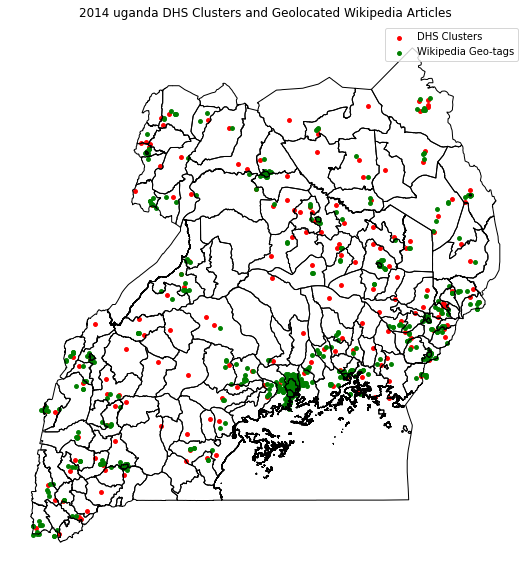

In [62]:
ug_articles = process_country('uganda', 2014, 'UGA', dhs_clusts, plot=True)

Cluster Progress::   0%|          | 0/239 [00:00<?, ?it/s]

Processing Igumale


Cluster Progress::   0%|          | 1/239 [00:04<17:13,  4.34s/it]

Processing A344 highway (Nigeria)


Cluster Progress::   1%|          | 2/239 [00:06<14:10,  3.59s/it]

Processing Old Bridge, Makurdi
Processing Benue State University
Processing Otukpa
Processing Makurdi
Processing Aper Aku Stadium
Processing Agbadi


Cluster Progress::   3%|▎         | 8/239 [00:19<12:10,  3.16s/it]

Processing Madalla
Processing Zuma Rock


Cluster Progress::   4%|▍         | 9/239 [00:22<12:01,  3.14s/it]

Processing Jabi Lake
Processing Crushed Rock, Mpape
Processing Embassy of Indonesia, Abuja
Processing June 2014 Kaduna and Abuja attacks
Processing Anglican Diocese of Abuja
Processing Abuja
Processing World Trade Centre Abuja
Processing Nigerian Export-Import Bank
Processing Moshood Abiola National Stadium
Processing National Hospital, Abuja
Processing Millennium Tower (Abuja)


Cluster Progress::   5%|▍         | 11/239 [01:01<30:32,  8.04s/it]

Processing Dekina


Cluster Progress::   5%|▌         | 12/239 [01:02<23:08,  6.11s/it]

Processing Okenyi


Cluster Progress::   6%|▌         | 14/239 [01:04<16:57,  4.52s/it]

Processing Anglican Diocese of Okene
Processing Okene
Processing Ogaminan


Cluster Progress::   6%|▋         | 15/239 [01:09<17:34,  4.71s/it]

Processing Anglican Diocese of Lokoja
Processing Lokoja
Processing Mount Patti
Processing World War Cenotaph, Lokoja
Processing Confluence Stadium


Cluster Progress::   7%|▋         | 16/239 [01:21<25:03,  6.74s/it]

Processing Ogori/Magongo


Cluster Progress::   7%|▋         | 17/239 [01:23<19:36,  5.30s/it]

Processing Geregu nuclear power plant
Processing Ajaokuta
Processing Kogi State


Cluster Progress::   8%|▊         | 18/239 [01:30<22:09,  6.02s/it]

Processing Kwara Stadium
Processing Ilorin
Processing Ilorin Emirate
Processing Al-Hikmah University
Processing Ilorin International Airport
Processing A123 highway (Nigeria)


Cluster Progress::   9%|▉         | 22/239 [01:44<19:05,  5.28s/it]

Processing Omu-Aran
Processing Iloffa


Cluster Progress::  10%|▉         | 23/239 [01:53<22:19,  6.20s/it]

Processing New Nyanya
Processing Nasarawa State


Cluster Progress::  10%|█         | 25/239 [01:57<17:38,  4.95s/it]

Processing Wamba, Nigeria


Cluster Progress::  11%|█▏        | 27/239 [01:59<13:08,  3.72s/it]

Processing Kainji Lake


Cluster Progress::  12%|█▏        | 28/239 [02:01<11:29,  3.27s/it]

Processing Federal University of Technology, Minna
Processing Chanchaga
Processing Minna
Processing Minna Township Stadium
Processing Federal Government College Minna


Cluster Progress::  14%|█▍        | 34/239 [02:11<09:35,  2.81s/it]

Processing Riyom


Cluster Progress::  15%|█▌        | 36/239 [02:13<07:36,  2.25s/it]

Processing Rwang Pam Stadium
Processing ECWA Evangel Hospital
Processing 2010 Jos riots
Processing University of Jos
Processing Jos
Processing Jos North
Processing Air Force Military School, Jos


Cluster Progress::  15%|█▌        | 37/239 [02:34<26:54,  7.99s/it]

Processing A345 highway (Nigeria)


Cluster Progress::  18%|█▊        | 42/239 [02:36<18:38,  5.68s/it]

Processing Madagali


Cluster Progress::  18%|█▊        | 43/239 [02:38<14:38,  4.48s/it]

Processing Adamawa State University
Processing 2014 Mubi bombing
Processing Mubi
Processing Mararaba Mubi
Processing Mubi North


Cluster Progress::  18%|█▊        | 44/239 [02:49<20:55,  6.44s/it]

Processing Michika


Cluster Progress::  19%|█▉        | 46/239 [02:52<16:10,  5.03s/it]

Processing Adamawa Emirate
Processing Yola, Adamawa
Processing Yola Airport
Processing Ahmadu Ribadu College
Processing Jimeta
Processing American University of Nigeria


Cluster Progress::  20%|█▉        | 47/239 [03:05<23:30,  7.35s/it]

Processing Azare Airstrip


Cluster Progress::  21%|██        | 50/239 [03:07<16:49,  5.34s/it]

Processing Azare


Cluster Progress::  21%|██▏       | 51/239 [03:11<15:47,  5.04s/it]

Processing Disina
Processing Foggo


Cluster Progress::  22%|██▏       | 53/239 [03:14<12:25,  4.01s/it]

Processing Chibok schoolgirls kidnapping
Processing Chibok


Cluster Progress::  24%|██▍       | 58/239 [03:31<11:28,  3.81s/it]

Processing March 2015 Maiduguri suicide bombing
Processing Maiduguri
Processing El-Kanemi Stadium


Cluster Progress::  27%|██▋       | 65/239 [03:41<08:55,  3.08s/it]

Processing Akko, Nigeria
Processing Kumo, Gombe, Nigeria


Cluster Progress::  29%|██▉       | 69/239 [03:44<06:54,  2.44s/it]

Processing Pantami Stadium
Processing Gombe, Gombe
Processing Gombe State
Processing Abubakar Umar Memorial Stadium
Processing Hildi


Cluster Progress::  29%|██▉       | 70/239 [03:57<15:22,  5.46s/it]

Processing Ibi, Nigeria


Cluster Progress::  30%|███       | 72/239 [03:59<11:38,  4.18s/it]

Processing Federal Government College Wukari
Processing Wukari Federation
Processing Wukari


Cluster Progress::  31%|███▏      | 75/239 [04:09<10:34,  3.87s/it]

Processing Nguru, Nigeria
Processing Nguru Airstrip


Cluster Progress::  33%|███▎      | 80/239 [04:13<07:52,  2.97s/it]

Processing Birnin Kudu


Cluster Progress::  34%|███▍      | 81/239 [04:16<07:45,  2.94s/it]

Processing Ranchers Bees Stadium
Processing Lugard Footbridge
Processing Northern Region, Nigeria
Processing Kaduna
Processing Sultan Bello Mosque
Processing Abubakar Mahmud Gumi Market
Processing Arewa House
Processing Badarawa, Kaduna
Processing Ahmadu Bello Stadium


Cluster Progress::  38%|███▊      | 91/239 [04:42<06:59,  2.83s/it]

Processing Zaria
Processing 2015 Zaria massacre
Processing Ahmadu Bello University
Processing Zaria Quds Day massacres
Processing Zaki Biam Massacre
Processing Wusasa
Processing Barewa College
Processing Federal College of Education, Zaria
Processing Sabon Gari, Kaduna
Processing Nigerian College of Aviation Technology


Cluster Progress::  38%|███▊      | 92/239 [05:21<33:48, 13.80s/it]

Processing Bebeji
Processing Garun Mallam
Processing Madobi


Cluster Progress::  39%|███▉      | 93/239 [05:28<28:51, 11.86s/it]

Processing Warawa


Cluster Progress::  39%|███▉      | 94/239 [05:30<21:26,  8.87s/it]

Processing Garko, Nigeria
Processing Sumaila


Cluster Progress::  40%|███▉      | 95/239 [05:35<17:58,  7.49s/it]

Processing Kura, Nigeria


Cluster Progress::  41%|████      | 97/239 [05:36<12:54,  5.45s/it]

Processing Tofa, Nigeria
Processing Rimin Gado


Cluster Progress::  41%|████      | 98/239 [05:39<10:49,  4.60s/it]

Processing Dawakin Tofa


Cluster Progress::  41%|████▏     | 99/239 [05:40<08:26,  3.62s/it]

Processing Wudil
Processing Kano State University of Technology


Cluster Progress::  42%|████▏     | 100/239 [05:43<07:55,  3.42s/it]

Processing 2014 Kano attack
Processing Great Mosque of Kano
Processing Kano
Processing Kurmi Market
Processing Kano Emirate Council
Processing 2013 Kano bus bombing
Processing Gidan Rumfa
Processing Gidan Makama Museum Kano
Processing Sani Abacha Stadium
Processing Fagge
Processing Rumfa College, Kano
Processing EAS Airlines Flight 4226
Processing Our Lady of Fatima Cathedral, Kano
Processing Gwale
Processing Pillars Stadium
Processing Dala, Kano
Processing Bayero University Kano
Processing Ancient Kano City Walls
Processing 1956 Kano Airport BOAC Argonaut crash
Processing Nasarawa, Kano State
Processing Kano Municipal
Processing Kano air disaster
Processing Tarauni


Cluster Progress::  42%|████▏     | 101/239 [08:51<2:15:01, 58.70s/it]

Processing Mani, Nigeria


Cluster Progress::  43%|████▎     | 103/239 [08:52<1:33:44, 41.36s/it]

Processing Dandume


Cluster Progress::  45%|████▍     | 107/239 [08:54<1:03:55, 29.06s/it]

Processing Baure, Nigeria


Cluster Progress::  45%|████▌     | 108/239 [08:56<45:36, 20.89s/it]  

Processing Dange Shuni


Cluster Progress::  47%|████▋     | 113/239 [08:57<30:54, 14.72s/it]

Processing Illela, Nigeria
Processing A1 highway (Nigeria)
Processing Birni-N'Konni Department
Processing Birni-N'Konni


Cluster Progress::  48%|████▊     | 114/239 [09:04<25:29, 12.24s/it]

Processing Yabo, Nigeria
Processing Shagari, Nigeria


Cluster Progress::  49%|████▊     | 116/239 [09:07<18:36,  9.08s/it]

Processing Sokoto Caliphate
Processing Sokoto North
Processing Sokoto
Processing Sokoto Sultanate Council
Processing Sokoto State
Processing Sokoto South


Cluster Progress::  49%|████▉     | 117/239 [09:33<28:59, 14.26s/it]

Processing Kaura Namoda


Cluster Progress::  50%|████▉     | 119/239 [09:35<20:26, 10.22s/it]

Processing Ozara, Abia State
Processing Alayi
Processing Amaozara


Cluster Progress::  51%|█████     | 121/239 [09:42<16:13,  8.25s/it]

Processing A3 highway (Nigeria)
Processing Aba North
Processing Anglican Diocese of Aba Ngwa North
Processing Trinity Theological College, Umuahia
Processing Anglican Diocese of Isiala-Ngwa South
Processing Anglican Diocese of Isiala Ngwa


Cluster Progress::  51%|█████     | 122/239 [09:51<16:08,  8.28s/it]

Processing Enyimba International Stadium
Processing Aba, Abia
Processing Abia State Polytechnic
Processing Christ the King Cathedral, Aba
Processing Mgboko
Processing Aba Nigeria Temple
Processing Obi Ngwa
Processing Aba South
Processing Osisioma Ngwa


Cluster Progress::  51%|█████▏    | 123/239 [10:22<29:20, 15.18s/it]

Processing Ukwa West


Cluster Progress::  52%|█████▏    | 124/239 [10:24<21:44, 11.34s/it]

Processing Umuahia North
Processing Anglican Diocese of Umuahia
Processing Umuahia
Processing Isuikwuato
Processing Anglican Diocese of Isuikwuato
Processing Umuahia Township Stadium
Processing Umuekwule
Processing Umukabia


Cluster Progress::  53%|█████▎    | 127/239 [10:43<18:13,  9.76s/it]

Processing Oraukwu, Anambra
Processing Awka-Etiti
Processing Alor, Anambra
Processing Archaeology of Igbo-Ukwu
Processing Igbo-Ukwu
Processing Ameki Formation
Processing Agulu


Cluster Progress::  54%|█████▎    | 128/239 [11:10<27:57, 15.11s/it]

Processing Awgbu
Processing Ihiala
Processing Ozubulu
Processing Azia (town)


Cluster Progress::  54%|█████▍    | 129/239 [11:19<24:12, 13.20s/it]

Processing Kingdom of Nri
Processing Enugwu Ukwu
Processing Nawfia
Processing Awka South
Processing Nibo
Processing Umuawulu
Processing Oko Town


Cluster Progress::  54%|█████▍    | 130/239 [11:45<31:04, 17.11s/it]

Processing Eziowelle
Processing Otolo
Processing Nnewi


Cluster Progress::  55%|█████▌    | 132/239 [12:05<26:41, 14.97s/it]

Processing Gabros Stadium


Cluster Progress::  56%|█████▌    | 133/239 [12:07<19:44, 11.17s/it]

Processing Oba, Anambra


Cluster Progress::  56%|█████▌    | 134/239 [12:10<14:54,  8.52s/it]

Processing Intafact Beverages Limited
Processing Onitsha
Processing Second Niger bridge
Processing Okpoko
Processing Nkpor
Processing Anglican Diocese of Asaba
Processing Asaba, Delta
Processing Obosi
Processing Kwale, Nigeria
Processing Asaba-Ase


Cluster Progress::  56%|█████▋    | 135/239 [12:36<23:59, 13.84s/it]

Processing Ogbunike
Processing Ogbunike Caves
Processing Ogidi, Anambra
Processing Ifitedunu, Dunukofia


Cluster Progress::  57%|█████▋    | 136/239 [12:48<23:02, 13.42s/it]

Processing Adadama


Cluster Progress::  58%|█████▊    | 138/239 [12:50<16:08,  9.58s/it]

Processing Ishiagu
Processing Aninri


Cluster Progress::  58%|█████▊    | 139/239 [12:53<12:45,  7.66s/it]

Processing Afikpo South


Cluster Progress::  59%|█████▊    | 140/239 [12:56<10:24,  6.31s/it]

Processing Ngwo Pine forest
Processing Abia, Nigeria
Processing Abor, Enugu


Cluster Progress::  60%|█████▉    | 143/239 [13:01<07:48,  4.88s/it]

Processing Igbo Eze North
Processing Igbo Eze South
Processing Unadu


Cluster Progress::  60%|██████    | 144/239 [13:07<08:24,  5.31s/it]

Processing Nkanu West
Processing Renaissance University
Processing Agbani


Cluster Progress::  61%|██████    | 145/239 [13:12<08:13,  5.25s/it]

Processing Anglican Diocese of Udi
Processing Udi, Enugu


Cluster Progress::  61%|██████    | 146/239 [13:15<07:14,  4.67s/it]

Processing Nnamdi Azikiwe Stadium
Processing Biafra
Processing Enugu
Processing Anglican Diocese of Enugu
Processing Enugu North
Processing Anglican Diocese of Enugu North
Processing Enugu South
Processing Enugu State
Processing Ekulu River
Processing Akanu Ibiam International Airport


Cluster Progress::  62%|██████▏   | 147/239 [13:58<24:32, 16.01s/it]

Processing University of Nigeria
Processing Ezema Nru
Processing Nsukka
Processing Ede-Oballa
Processing Nru Nsukka
Processing Anglican Diocese of Nsukka


Cluster Progress::  63%|██████▎   | 150/239 [14:20<19:53, 13.41s/it]

Processing Ekwereazu
Processing Amaimo
Processing Ahiara
Processing Aboh Mbaise


Cluster Progress::  63%|██████▎   | 151/239 [14:28<17:25, 11.88s/it]

Processing Itu, Imo State


Cluster Progress::  64%|██████▎   | 152/239 [14:30<12:38,  8.72s/it]

Processing Abajah
Processing Jesus de Greatest
Processing Isu, Nigeria
Processing Uburu Ekwe
Processing Amandugba
Processing Umundugba
Processing Ngugu
Processing Nkwerre


Cluster Progress::  64%|██████▍   | 154/239 [14:43<11:35,  8.18s/it]

Processing Mbieri
Processing Umunoha
Processing Obazu


Cluster Progress::  65%|██████▍   | 155/239 [14:52<11:35,  8.28s/it]

Processing Orlu, Imo


Cluster Progress::  66%|██████▌   | 158/239 [14:55<08:16,  6.13s/it]

Processing Dikenafai


Cluster Progress::  67%|██████▋   | 159/239 [14:58<06:36,  4.95s/it]

Processing Ubomiri
Processing Irete
Processing Government Secondary School, Owerri
Processing Imo State
Processing Owerri
Processing Obodoukwu
Processing Dan Anyiam Stadium
Processing Orji


Cluster Progress::  67%|██████▋   | 160/239 [15:18<12:46,  9.71s/it]

Processing Abak
Processing Akwa Ibom State
Processing University of Uyo Teaching Hospital


Cluster Progress::  67%|██████▋   | 161/239 [15:27<12:23,  9.53s/it]

Processing Akwa Ibom State Polytechnic
Processing Essien Udim


Cluster Progress::  68%|██████▊   | 162/239 [15:31<09:56,  7.75s/it]

Processing Nsit-Ibom


Cluster Progress::  68%|██████▊   | 163/239 [15:33<07:43,  6.10s/it]

Processing Opobo–Nkoro


Cluster Progress::  69%|██████▊   | 164/239 [15:35<05:58,  4.78s/it]

Processing Ikot Okoro
Processing Etinan


Cluster Progress::  70%|██████▉   | 167/239 [15:39<04:32,  3.78s/it]

Processing Oron people
Processing Uyo High School
Processing Uyo
Processing Uyo Township Stadium
Processing Godswill Akpabio International Stadium
Processing A342 highway (Nigeria)


Cluster Progress::  70%|███████   | 168/239 [15:55<08:44,  7.39s/it]

Processing Akassa


Cluster Progress::  71%|███████   | 169/239 [15:57<06:41,  5.73s/it]

Processing Ogbia


Cluster Progress::  71%|███████   | 170/239 [15:59<05:23,  4.68s/it]

Processing Yenagoa Township Stadium


Cluster Progress::  72%|███████▏  | 171/239 [16:01<04:15,  3.76s/it]

Processing Yenagoa


Cluster Progress::  72%|███████▏  | 172/239 [16:03<03:34,  3.20s/it]

Processing Mbe Mountains Community Forest


Cluster Progress::  73%|███████▎  | 174/239 [16:04<02:39,  2.45s/it]

Processing Ababene


Cluster Progress::  73%|███████▎  | 175/239 [16:05<02:14,  2.10s/it]

Processing Ekori


Cluster Progress::  74%|███████▎  | 176/239 [16:08<02:18,  2.20s/it]

Processing Duke Town
Processing Calabar
Processing Roman Catholic Archdiocese of Calabar
Processing Federal Government Girls College, Calabar
Processing University of Calabar
Processing Calabar River
Processing U. J. Esuene Stadium
Processing Calabar Carnival


Cluster Progress::  74%|███████▍  | 177/239 [16:36<10:19,  9.99s/it]

Processing Warri Township Stadium
Processing Warri
Processing Anglican Diocese of Warri
Processing Ovwian
Processing Word of Life Bible Church


Cluster Progress::  75%|███████▌  | 180/239 [16:55<06:12,  6.32s/it]

Processing Aradhe
Processing Igbuku
Processing Irri


Cluster Progress::  76%|███████▌  | 181/239 [17:02<06:28,  6.69s/it]

Processing Obiaruku
Processing Anglican Diocese of Ndokwa
Processing Anglican Diocese of Sapele


Cluster Progress::  76%|███████▌  | 182/239 [17:11<06:55,  7.28s/it]

Processing Agbor
Processing Anglican Diocese of Ika
Processing Ewu Monastery


Cluster Progress::  77%|███████▋  | 183/239 [17:21<07:28,  8.00s/it]

Processing Sapele, Delta
Processing Sapele Stadium
Processing Delta State University Teaching Hospital


Cluster Progress::  77%|███████▋  | 184/239 [17:33<08:33,  9.34s/it]

Processing Effurun
Processing Federal University of Petroleum Resources Effurun


Cluster Progress::  77%|███████▋  | 185/239 [17:39<07:33,  8.40s/it]

Processing Ososo


Cluster Progress::  79%|███████▉  | 189/239 [17:44<02:11,  2.63s/it]

Processing Ubiaja


Cluster Progress::  79%|███████▉  | 190/239 [17:46<02:09,  2.64s/it]

Processing Presentation National High School
Processing Egedege N'Okaro
Processing Benson Idahosa University
Processing Benin City
Processing Anglican Diocese of Benin
Processing Kingdom of Benin
Processing Shaka Polytechnic
Processing Samuel Ogbemudia Stadium
Processing Benin Airport
Processing University of Benin (Nigeria)
Processing Ogba Zoo
Processing Auntie Maria School
Processing Wellspring University
Processing University of Benin Teaching Hospital


Cluster Progress::  80%|███████▉  | 191/239 [18:26<11:02, 13.80s/it]

Processing Ahoada


Cluster Progress::  80%|████████  | 192/239 [18:28<07:56, 10.15s/it]

Processing Andoni
Processing Nkoroo


Cluster Progress::  81%|████████  | 193/239 [18:31<06:09,  8.02s/it]

Processing Abalama
Processing Outline of Rivers State
Processing Emohua Town
Processing Oduoha-Emohua
Processing Emohua
Processing Rivers State
Processing Buguma


Cluster Progress::  81%|████████  | 194/239 [18:56<09:47, 13.05s/it]

Processing A231 highway (Nigeria)
Processing Elele


Cluster Progress::  82%|████████▏ | 195/239 [19:00<07:31, 10.27s/it]

Processing Umuehere, Port Harcourt
Processing Ave Maria International Academy
Processing Obio-Akpor Local Government Council
Processing Shell Residential Area, Port Harcourt
Processing Port Harcourt City Airport
Processing Catholic Institute of West Africa
Processing CITA International School
Processing Obi Wali International Conference Centre
Processing Rumuokoro
Processing Archdeacon Crowther Memorial Girls' School
Processing Emilio Piazza Memorial School
Processing Elelenwo, Port Harcourt
Processing Port Harcourt Pleasure Park
Processing Marygold International School
Processing Port Harcourt
Processing Yakubu Gowon Stadium
Processing Jesuit Memorial College
Processing Loyola Jesuit College
Processing Tantua International Group of Schools
Processing Military Hospital, Port Harcourt
Processing Port Harcourt Book Festival
Processing Rivers State Television
Processing Lagos Television
Processing Radio Rivers 99.1
Processing La Pierre Angulaire High School
Processing Trans Amadi, Port Ha

Cluster Progress::  82%|████████▏ | 196/239 [20:12<20:42, 28.90s/it]

Processing Onne


Cluster Progress::  82%|████████▏ | 197/239 [20:15<14:47, 21.13s/it]

Processing Abonnema


Cluster Progress::  83%|████████▎ | 198/239 [20:18<10:48, 15.81s/it]

Processing Tai, Rivers


Cluster Progress::  83%|████████▎ | 199/239 [20:21<07:54, 11.86s/it]

Processing Aggrey Road
Processing Port Harcourt Cemetery
Processing Sharks Stadium
Processing St. Mary's Catholic Model High School
Processing Rivers State Ministry of Youth Development
Processing Rivers State Ministry of Information and Communications
Processing Rivers State Ministry of Energy and Natural Resources
Processing Rivers State Ministry of Employment Generation and Empowerment
Processing Rivers State Ministry of Finance
Processing Rivers State Ministry of Transport
Processing Rivers State Ministry of Commerce and Industry
Processing Rivers State Ministry of Culture and Tourism
Processing Rivers State Ministry of Chieftaincy and Community Affairs
Processing Rivers State Ministry of Water Resources and Rural Development
Processing Borokiri, Port Harcourt
Processing Rivers State Ministry of Environment
Processing Rivers State Ministry of Justice
Processing Rivers State Ministry of Works
Processing Rivers State Ministry of Health
Processing Rivers State Ministry of Urban Develo

Cluster Progress::  84%|████████▎ | 200/239 [22:24<29:20, 45.14s/it]

Processing Ilawe Ekiti


Cluster Progress::  84%|████████▍ | 201/239 [22:28<20:46, 32.80s/it]

Processing Ire Ekiti
Processing Afe Babalola University


Cluster Progress::  85%|████████▍ | 202/239 [22:38<15:58, 25.89s/it]

Processing Irepodun/Ifelodun
Processing Ekiti State
Processing Federal Polytechnic, Ado-Ekiti
Processing Iyin Ekiti
Processing Ekiti State University


Cluster Progress::  85%|████████▌ | 204/239 [22:59<10:05, 17.29s/it]

Processing Babington Macaulay Junior Seminary
Processing Egbin Thermal Power Station


Cluster Progress::  86%|████████▌ | 205/239 [23:05<07:51, 13.86s/it]

Processing Ajeromi-Ifelodun
Processing German School Lagos
Processing Apapa
Processing Apapa Amusement Park
Processing Ijora, Lagos
Processing National Arts Theatre
Processing Eko Bridge
Processing Olowogbowo
Processing Lagos
Processing Iddo Island
Processing Ebute Metta
Processing Lagos Terminus railway station
Processing Carter Bridge
Processing Union Bank Building (Lagos)
Processing United Bank for Africa
Processing Soldier Idumota
Processing Surulere
Processing Ebute Ero
Processing Tinubu Square
Processing Ilojo Bar
Processing Cathedral Church of Christ, Lagos
Processing Bookshop House
Processing National Stadium, Lagos
Processing Iga Idunganran
Processing Teslim Balogun Stadium
Processing Jaekel House
Processing 2006 Lagos building collapses
Processing Lagos Colony
Processing Timeline of Lagos
Processing Freedom Park (Lagos)
Processing Cathedral of the Holy Cross, Lagos
Processing Longford International School
Processing NECOM House
Processing Independence House
Processing Souther

Cluster Progress::  86%|████████▌ | 206/239 [25:54<33:13, 60.41s/it]

Processing Lagos State Model Junior College Meiran
Processing Anwar ul-Islam Girls High School
Processing Ifako-Ijaiye
Processing Alimosho
Processing Dana Air Flight 992
Processing Agege Stadium
Processing Agege
Processing Faith Tabernacle


Cluster Progress::  87%|████████▋ | 207/239 [26:20<26:37, 49.93s/it]

Processing Lagos International Trade Fair
Processing Lagos Trade Fair Complex
Processing Lagos State University
Processing Ijegun


Cluster Progress::  87%|████████▋ | 208/239 [26:29<19:31, 37.79s/it]

Processing CMS Grammar School, Lagos
Processing SunTrust Bank Nigeria Limited
Processing Ikoyi
Processing Providus Bank Limited
Processing Eko Hotels and Suites


Cluster Progress::  88%|████████▊ | 210/239 [26:44<10:28, 21.69s/it]

Processing Radio Lagos
Processing Ikeja
Processing John Holt plc
Processing Lagos State University Teaching Hospital
Processing Ikeja City Mall
Processing 2002 Lagos armoury explosion
Processing Murtala Muhammed International Airport
Processing Associated Aviation Flight 361
Processing Ejigbo, Lagos


Cluster Progress::  88%|████████▊ | 211/239 [27:09<10:35, 22.69s/it]

Processing Banana Island, Lagos


Cluster Progress::  89%|████████▊ | 212/239 [27:12<07:34, 16.83s/it]

Processing Lagos Preparatory School
Processing Afrinvest
Processing American International School of Lagos
Processing Lekki-Ikoyi Link Bridge
Processing Zenith Bank
Processing 2020 Lekki shooting


Cluster Progress::  89%|████████▉ | 213/239 [27:31<07:29, 17.27s/it]

Processing St. Francis Catholic Secondary School, Nigeria
Processing Synagogue Church building collapse
Processing Ikotun Market


Cluster Progress::  90%|████████▉ | 214/239 [27:38<06:00, 14.44s/it]

Processing Ikenna Stars Academy
Processing Ilogbo Elegba
Processing Adeniran Ogunsanya College of Education
Processing Okokomaiko
Processing Ojo, Lagos


Cluster Progress::  91%|█████████ | 218/239 [27:49<01:38,  4.67s/it]

Processing Remo North
Processing Iperu, Ogun


Cluster Progress::  92%|█████████▏| 220/239 [27:58<01:22,  4.35s/it]

Processing Ijebu North
Processing Ijebu Igbo


Cluster Progress::  92%|█████████▏| 221/239 [28:05<01:29,  4.96s/it]

Processing Akungba Akoko


Cluster Progress::  93%|█████████▎| 223/239 [28:07<00:46,  2.90s/it]

Processing Federal College of Education (Technical), Asaba
Processing Adeyemi College of Education
Processing Federal College of Education (Technical)


Cluster Progress::  94%|█████████▎| 224/239 [28:13<00:59,  3.94s/it]

Processing Adekunle Ajasin University
Processing Ikare


Cluster Progress::  94%|█████████▍| 225/239 [28:19<01:01,  4.42s/it]

Processing Irele
Processing Ode-Irele


Cluster Progress::  95%|█████████▍| 226/239 [28:24<01:00,  4.69s/it]

Processing Egbedore
Processing Irepodun, Osun
Processing Ilobu
Processing Adeleke University
Processing Ifon Osun
Processing Erinle River
Processing Ede, Osun
Processing Ede North
Processing Orolu


Cluster Progress::  95%|█████████▍| 227/239 [28:44<01:49,  9.13s/it]

Processing Ola Oluwa
Processing Oba Hills Forest Reserve


Cluster Progress::  95%|█████████▌| 228/239 [28:48<01:23,  7.61s/it]

Processing Ada, Osun
Processing Ororuwo
Processing Iragbiji
Processing Boripe
Processing Ifelodun, Osun State
Processing Jalumi War
Processing Iba, Osun State


Cluster Progress::  96%|█████████▌| 229/239 [29:08<01:53, 11.37s/it]

Processing Inisa
Processing Otin River
Processing Eko-Ende


Cluster Progress::  96%|█████████▌| 230/239 [29:16<01:33, 10.39s/it]

Processing Esa-Oke
Processing Okemesi
Processing Imesi-ile


Cluster Progress::  97%|█████████▋| 232/239 [29:31<00:58,  8.39s/it]

Processing Obafemi Awolowo Stadium
Processing University College Hospital, Ibadan


Cluster Progress::  98%|█████████▊| 234/239 [29:39<00:28,  5.78s/it]

Processing Trans Wonderland
Processing Ibadan
Processing Operation Amotekun
Processing Ibadan School of Government and Public Policy
Processing Agodi Gardens
Processing Ibadan Grammar School
Processing Abeokuta Grammar School
Processing Adamasingba Stadium
Processing International School Ibadan
Processing University of Ibadan


Cluster Progress::  98%|█████████▊| 235/239 [30:15<00:58, 14.70s/it]

Processing The Polytechnic, Ibadan


Cluster Progress::  99%|█████████▉| 237/239 [30:17<00:15,  7.80s/it]

Processing Ogbomosho
Processing Ladoke Akintola University of Technology


Cluster Progress:: 100%|█████████▉| 238/239 [30:27<00:08,  8.33s/it]

Processing Shaki, Oyo


Cluster Progress:: 100%|██████████| 239/239 [30:31<00:00,  7.66s/it]


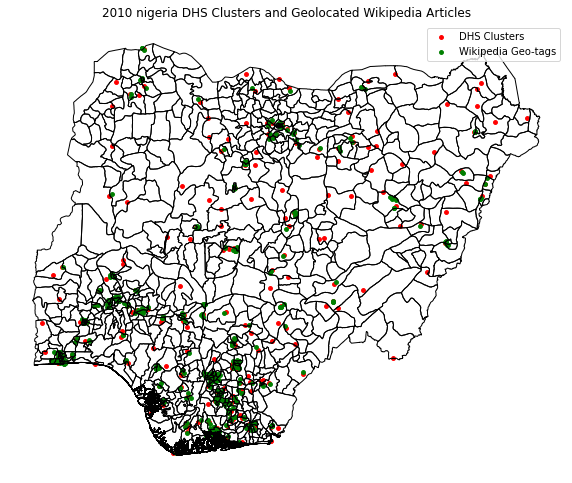

In [76]:
ng_articles = process_country('nigeria', 2010, 'NGA', dhs_clusts, plot=True)

Cluster Progress::   0%|          | 0/140 [00:00<?, ?it/s]

Processing Itumba
Processing Masoko, Ward
Processing Ndato
Processing Suma (ward)
Processing Matwebe
Processing Makandana
Processing Iponjela
Processing Lupepo
Processing Itagata
Processing Isongole
Processing Kawetele
Processing Bagamoyo Ward
Processing Swaya
Processing Ibighi
Processing Masebe
Processing Ilima (ward)


Cluster Progress::   2%|▏         | 3/140 [00:28<31:11, 13.66s/it]  

Processing Chitipa
Processing Chitipa Airport
Processing Chitipa District


Cluster Progress::   4%|▍         | 6/140 [00:35<13:02,  5.84s/it]

Processing Songwe Bridge
Processing Kyela District


Cluster Progress::   5%|▌         | 7/140 [00:39<11:34,  5.22s/it]

Processing Kayelekera mine
Processing Karonga District


Cluster Progress::   6%|▌         | 8/140 [00:43<10:44,  4.88s/it]

Processing Chilumba
Processing Wovwe Hydroelectric Power Station


Cluster Progress::   7%|▋         | 10/140 [00:50<08:22,  3.87s/it]

Processing Karonga
Processing Roman Catholic Diocese of Karonga
Processing Mbande Hill


Cluster Progress::   9%|▉         | 13/140 [00:58<05:33,  2.62s/it]

Processing Chintheche


Cluster Progress::  11%|█▏        | 16/140 [01:01<02:56,  1.42s/it]

Processing Vwaza Marsh Game Reserve


Cluster Progress::  12%|█▏        | 17/140 [01:04<03:38,  1.78s/it]

Processing Lupata Group


Cluster Progress::  13%|█▎        | 18/140 [01:07<04:22,  2.15s/it]

Processing Rumphi


Cluster Progress::  26%|██▌       | 36/140 [01:16<00:40,  2.59it/s]

Processing Mzuzu University
Processing Roman Catholic Diocese of Mzuzu
Processing Mzuzu


Cluster Progress::  26%|██▋       | 37/140 [01:26<05:41,  3.31s/it]

Processing Nkhata Bay District


Cluster Progress::  31%|███       | 43/140 [01:32<01:28,  1.09it/s]

Processing Kasungu
Processing Kasungu District
Processing Masitala


Cluster Progress::  32%|███▏      | 45/140 [01:39<03:07,  1.97s/it]

Processing Mbaluko
Processing Mtenje
Processing Makuta, Malawi
Processing Nkhotakota
Processing Kapeta


Cluster Progress::  35%|███▌      | 49/140 [01:51<02:46,  1.83s/it]

Processing Nyasaland
Processing British Central Africa Protectorate
Processing Malawi


Cluster Progress::  38%|███▊      | 53/140 [02:41<08:17,  5.72s/it]

Processing Dowa District


Cluster Progress::  39%|███▉      | 55/140 [02:44<04:51,  3.43s/it]

Processing 1989 Malawi earthquake
Processing Lilongwe River
Processing Salima, Malawi
Processing Kanzimbe Solar Power Station
Processing Salima District


Cluster Progress::  42%|████▏     | 59/140 [02:57<03:05,  2.28s/it]

Processing Nathenje


Cluster Progress::  46%|████▋     | 65/140 [03:00<00:52,  1.43it/s]

Processing Lilongwe International Airport


Cluster Progress::  47%|████▋     | 66/140 [03:02<01:18,  1.06s/it]

Processing Lilongwe
Processing Kamuzu Central Hospital
Processing Lilongwe Wildlife Centre
Processing Lilongwe Golf Club
Processing Standard Bank Malawi
Processing Roman Catholic Archdiocese of Lilongwe
Processing National Assembly (Malawi)
Processing Civo Stadium


Cluster Progress::  49%|████▊     | 68/140 [03:32<08:11,  6.83s/it]

Processing Mwami, Zambia
Processing Mchinji Airport


Cluster Progress::  49%|████▉     | 69/140 [03:37<07:24,  6.25s/it]

Processing Mchinji District


Cluster Progress::  51%|█████▏    | 72/140 [03:40<02:58,  2.63s/it]

Processing Nkhoma


Cluster Progress::  52%|█████▏    | 73/140 [03:42<02:50,  2.54s/it]

Processing Roman Catholic Diocese of Dedza
Processing Dedza


Cluster Progress::  54%|█████▍    | 76/140 [03:47<01:46,  1.67s/it]

Processing Ntcheu


Cluster Progress::  56%|█████▌    | 78/140 [03:50<01:33,  1.51s/it]

Processing Silver Stadium, Lilongwe
Processing Bingu National Stadium


Cluster Progress::  65%|██████▌   | 91/140 [03:59<00:22,  2.20it/s]

Processing Monkey Bay Airport
Processing Monkey Bay
Processing Lake Malawi National Park


Cluster Progress::  67%|██████▋   | 94/140 [04:09<01:20,  1.75s/it]

Processing Mangochi
Processing Mangochi Airport
Processing Roman Catholic Diocese of Mangochi
Processing Mangochi District


Cluster Progress::  69%|██████▊   | 96/140 [04:20<02:23,  3.25s/it]

Processing Machinga District


Cluster Progress::  70%|███████   | 98/140 [04:23<01:35,  2.28s/it]

Processing Liwonde


Cluster Progress::  71%|███████▏  | 100/140 [04:26<01:16,  1.91s/it]

Processing Domasi
Processing Zomba Airport


Cluster Progress::  73%|███████▎  | 102/140 [04:31<01:13,  1.93s/it]

Processing Magomero


Cluster Progress::  74%|███████▎  | 103/140 [04:33<01:11,  1.92s/it]

Processing Lirangwe–Chingale–Machinga Road


Cluster Progress::  74%|███████▍  | 104/140 [04:36<01:26,  2.39s/it]

Processing Bangwe
Processing Roman Catholic Archdiocese of Blantyre
Processing Nguludi
Processing Mpingwe
Processing Limbe, Malawi
Processing Chichiri Museum
Processing Chilembwe uprising
Processing Kamuzu Stadium
Processing Chiradzulu District
Processing Catholic University of Malawi
Processing St Michael and All Angels Church, Blantyre


Cluster Progress::  76%|███████▌  | 106/140 [05:09<04:34,  8.08s/it]

Processing Kholombidzo Hydroelectric Power Station
Processing Zalewa
Processing Kammwamba Thermal Power Station


Cluster Progress::  76%|███████▋  | 107/140 [05:16<04:16,  7.78s/it]

Processing University of Malawi College of Medicine
Processing Press Corporation Limited
Processing Electricity Generation Company Malawi Limited
Processing Blantyre
Processing Mercy James Institute for Pediatric Surgery and Intensive Care
Processing First Capital Bank Malawi Limited
Processing Telekom Networks Malawi
Processing Electricity Supply Corporation of Malawi
Processing Michiru Mountain


Cluster Progress::  79%|███████▊  | 110/140 [05:44<03:25,  6.85s/it]

Processing Thyolo
Processing Neno District


Cluster Progress::  81%|████████  | 113/140 [05:51<01:38,  3.66s/it]

Processing Ruo–Ndiza Hydroelectric Power Station
Processing Milange
Processing Milange District


Cluster Progress::  83%|████████▎ | 116/140 [05:59<00:58,  2.44s/it]

Processing Phalombe District


Cluster Progress::  84%|████████▎ | 117/140 [06:01<00:54,  2.39s/it]

Processing Muloza–Chiringa Road


Cluster Progress::  86%|████████▌ | 120/140 [06:04<00:26,  1.33s/it]

Processing Chikwawa
Processing Roman Catholic Diocese of Chikwawa
Processing Majete Wildlife Reserve


Cluster Progress::  88%|████████▊ | 123/140 [06:13<00:32,  1.92s/it]

Processing Nsanje
Processing Nsanje Airport


Cluster Progress::  90%|█████████ | 126/140 [06:19<00:21,  1.53s/it]

Processing Roman Catholic Diocese of Zomba
Processing Zomba, Malawi
Processing Naisi


Cluster Progress::  91%|█████████▏| 128/140 [06:29<00:36,  3.02s/it]

Processing Chileka International Airport
Processing Southern Region, Malawi


Cluster Progress:: 100%|██████████| 140/140 [06:37<00:00,  2.84s/it]


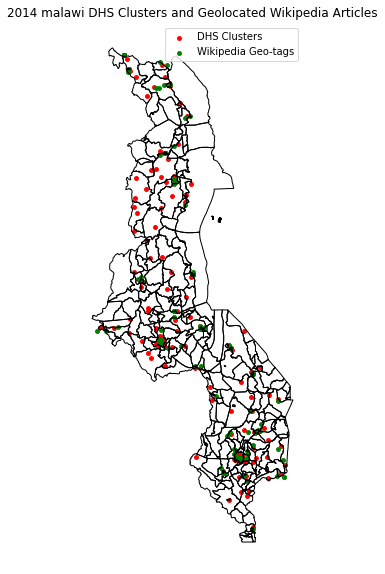

In [77]:
mw_articles = process_country('malawi', 2014, 'MWI', dhs_clusts, plot=True) 

Cluster Progress::   0%|          | 0/458 [00:00<?, ?it/s]

Processing Dodoma Rural District
Processing Dodoma Airport
Processing Gaddafi Mosque
Processing Dodoma
Processing Jamhuri Stadium (Dodoma)
Processing Dodoma District
Processing National Assembly (Tanzania)
Processing Roman Catholic Archdiocese of Dodoma
Processing Mirembe Hospital
Processing Zuzu
Processing St. John's University of Tanzania
Processing Dodoma Makulu
Processing Msalato International Airport


Cluster Progress::   0%|          | 2/458 [00:28<2:29:24, 19.66s/it]

Processing Mrijo


Cluster Progress::   1%|          | 4/458 [00:30<1:17:04, 10.19s/it]

Processing Masange


Cluster Progress::   1%|          | 5/458 [00:32<58:24,  7.74s/it]  

Processing Diocese of Mpwapwa
Processing Mpwapwa District
Processing Mpwapwa


Cluster Progress::   2%|▏         | 9/458 [00:41<21:42,  2.90s/it]

Processing Chamkoroma


Cluster Progress::   2%|▏         | 10/458 [00:43<19:34,  2.62s/it]

Processing Dabalo


Cluster Progress::   3%|▎         | 15/458 [00:47<06:46,  1.09it/s]

Processing Hombolo
Processing Hombolo Dam
Processing Chihanga
Processing Ipala (Tanzanian ward)


Cluster Progress::   4%|▎         | 17/458 [00:55<15:29,  2.11s/it]

Processing Longido
Processing Longido District
Processing Mount Longido


Cluster Progress::   4%|▍         | 18/458 [01:01<24:55,  3.40s/it]

Processing Mount Meru University
Processing Arusha Airport
Processing Arusha Rural District
Processing Arusha
Processing Sheikh Amri Abeid Memorial Stadium
Processing Arusha Declaration Monument
Processing Roman Catholic Archdiocese of Arusha


Cluster Progress::   4%|▍         | 19/458 [01:18<55:17,  7.56s/it]

Processing International Criminal Tribunal for Rwanda
Processing Arusha District
Processing Bangata
Processing Nkoanrua
Processing Lake Duluti
Processing Nelson Mandela African Institute of Science and Technology
Processing Poli (Tanzanian ward)
Processing Nkoaranga


Cluster Progress::   6%|▌         | 26/458 [01:39<11:43,  1.63s/it]  

Processing Ngurdoto Crater


Cluster Progress::   6%|▌         | 27/458 [01:41<12:39,  1.76s/it]

Processing Mbuguni


Cluster Progress::   6%|▌         | 28/458 [01:43<13:18,  1.86s/it]

Processing Tumaini University Makumira
Processing Mount Meru (Tanzania)


Cluster Progress::   7%|▋         | 33/458 [01:49<06:52,  1.03it/s]

Processing Mbulumbulu
Processing Kibaoni


Cluster Progress::   7%|▋         | 34/458 [01:53<12:01,  1.70s/it]

Processing Diocese of Rift Valley
Processing East African Rift


Cluster Progress::   8%|▊         | 36/458 [02:01<17:46,  2.53s/it]

Processing Himo, Tanzania
Processing Battle of Latema Nek
Processing Marangu
Processing Holili
Processing Arusha–Holili–Taveta–Voi Road


Cluster Progress::   8%|▊         | 37/458 [02:13<37:40,  5.37s/it]

Processing Moshi Rural District
Processing Saint Mary Goreti Secondary School
Processing Moshi, Tanzania
Processing Moshi Co-operative University
Processing Moshi District
Processing Moshi Airport
Processing Kilimanjaro Christian Medical University College
Processing United World College East Africa
Processing Mwenge Catholic University
Processing Weruweru Secondary School


Cluster Progress::   9%|▊         | 39/458 [02:38<55:14,  7.91s/it]  

Processing Stefano Moshi Memorial University College


Cluster Progress::   9%|▉         | 43/458 [02:41<16:49,  2.43s/it]

Processing Same District


Cluster Progress::  10%|▉         | 44/458 [02:44<17:21,  2.52s/it]

Processing Suji, Kilimanjaro


Cluster Progress::  10%|█         | 47/458 [02:49<11:20,  1.66s/it]

Processing College of African Wildlife Management


Cluster Progress::  11%|█         | 49/458 [02:51<09:24,  1.38s/it]

Processing Machame


Cluster Progress::  11%|█         | 50/458 [03:01<26:40,  3.92s/it]

Processing Hai District


Cluster Progress::  11%|█▏        | 52/458 [03:04<17:24,  2.57s/it]

Processing West Kilimanjaro Airstrip


Cluster Progress::  12%|█▏        | 53/458 [03:07<17:17,  2.56s/it]

Processing Hale Dam
Processing Hale, Tanzania
Processing Mabatini
Processing Pangani Falls Dam


Cluster Progress::  12%|█▏        | 54/458 [03:16<30:55,  4.59s/it]

Processing Tanga District
Processing Mkwakwani Stadium
Processing Diocese of Tanga
Processing Tanga, Tanzania
Processing Battle of Tanga
Processing Tanga Airport
Processing Port of Tanga
Processing Popatlal Secondary School
Processing Tanga Island Rear Range Lighthouse
Processing Tanga Island Front Range Lighthouse
Processing Toten Island
Processing Ras Kazone Rear Range Lighthouse
Processing Tanga Entrance Lighthouse
Processing Zigi River


Cluster Progress::  12%|█▏        | 56/458 [03:47<58:29,  8.73s/it]  

Processing Handeni Game Controlled Area
Processing Kilimanjaro (ward)
Processing Handeni District


Cluster Progress::  13%|█▎        | 58/458 [03:54<38:48,  5.82s/it]

Processing Usambara Mountains


Cluster Progress::  13%|█▎        | 59/458 [04:01<41:49,  6.29s/it]

Processing Kitivo


Cluster Progress::  14%|█▍        | 65/458 [04:06<08:02,  1.23s/it]

Processing Manza Bay
Processing Ulenge Island Rear Range Lighthouse
Processing Ulenge Island Front Range Lighthouse
Processing Amboni Caves


Cluster Progress::  16%|█▌        | 71/458 [04:17<06:07,  1.05it/s]

Processing Kilosa
Processing Kilosa District
Processing Battle of Kilosa


Cluster Progress::  16%|█▌        | 72/458 [04:23<14:49,  2.30s/it]

Processing Kidatu Dam
Processing Kidatu
Processing Battle of Kidodi


Cluster Progress::  16%|█▌        | 73/458 [04:29<21:04,  3.28s/it]

Processing Mahenge Mountains


Cluster Progress::  16%|█▌        | 74/458 [04:32<20:28,  3.20s/it]

Processing Morogoro Airstrip
Processing Muslim University of Morogoro
Processing Msamvu Bus Terminal, Morogoro
Processing Jordan University College
Processing Morogoro tanker explosion
Processing Morogoro
Processing Diocese of Morogoro
Processing Morogoro Urban District
Processing Sokoine University of Agriculture
Processing Solomon Mahlangu Freedom College
Processing Lupanga


Cluster Progress::  17%|█▋        | 78/458 [05:02<25:19,  4.00s/it]  

Processing Uvidunda Mountains


Cluster Progress::  17%|█▋        | 79/458 [05:04<22:54,  3.63s/it]

Processing Mandege
Processing Gairo District


Cluster Progress::  17%|█▋        | 80/458 [05:09<24:40,  3.92s/it]

Processing Kisaki, Tanzania
Processing Battle of Kisaki


Cluster Progress::  18%|█▊        | 81/458 [05:14<26:24,  4.20s/it]

Processing Morogoro Rural District


Cluster Progress::  18%|█▊        | 83/458 [05:16<15:59,  2.56s/it]

Processing Kilombero District
Processing Roman Catholic Diocese of Ifakara
Processing St. Francis University College of Health and Allied Sciences
Processing Kilombero Bridge


Cluster Progress::  19%|█▊        | 85/458 [05:25<20:11,  3.25s/it]

Processing Ulanga District


Cluster Progress::  19%|█▉        | 88/458 [05:28<10:10,  1.65s/it]

Processing Battle of Mlali


Cluster Progress::  19%|█▉        | 89/458 [05:32<12:53,  2.10s/it]

Processing Msoga


Cluster Progress::  20%|█▉        | 90/458 [05:34<12:42,  2.07s/it]

Processing Msufini Tanzania Limited
Processing New Ruvu Bridge


Cluster Progress::  20%|█▉        | 91/458 [05:38<17:13,  2.82s/it]

Processing Toangoma
Processing Mbagala
Processing Chamazi Stadium


Cluster Progress::  21%|██        | 94/458 [05:44<11:47,  1.95s/it]

Processing Kitonga


Cluster Progress::  21%|██▏       | 98/458 [05:47<05:30,  1.09it/s]

Processing Pwani Region
Processing Kazimzumbwi Forest Reserve


Cluster Progress::  22%|██▏       | 99/458 [05:53<13:40,  2.28s/it]

Processing Mzenga


Cluster Progress::  23%|██▎       | 106/458 [05:57<03:33,  1.65it/s]

Processing Mafia Airport
Processing Kilindoni
Processing Mafia District
Processing Mafia Island


Cluster Progress::  23%|██▎       | 107/458 [06:08<21:36,  3.69s/it]

Processing Mwananyamala
Processing Tandale
Processing Tumaini University Dar es Salaam College
Processing Manzese
Processing Kinondoni District
Processing Mbweni, Dar Es Salaam
Processing Kimara
Processing AccessBank Tanzania
Processing Open University of Tanzania
Processing Sinza
Processing Vodacom Tanzania
Processing Hananasif
Processing Kinondoni (ward)
Processing Magomeni
Processing Ada Estate
Processing Hubert Kairuki Memorial University
Processing Dar es Salaam Institute of Technology
Processing Jakaya Kikwete Cardiac Institute
Processing Muhimbili National Hospital
Processing Loyola School, Dar es Salaam
Processing Tanzania Heart Institute
Processing Muhimbili University of Health and Allied Sciences
Processing Upanga West
Processing Ifakara Health Institute
Processing Ilala District
Processing Mwenge, Dar es Salaam
Processing Embassy of Russia, Dar es Salaam
Processing Jangwani
Processing Mabibo
Processing Selander Bridge
Processing Shaaban Robert Secondary School
Processing In

Cluster Progress::  24%|██▎       | 108/458 [09:54<6:50:41, 70.41s/it]

Processing International Medical and Technological University


Cluster Progress::  24%|██▍       | 110/458 [10:00<3:27:38, 35.80s/it]

Processing Ukonga
Processing Pugu, Tanzania
Processing Kinyerezi I Thermal Power Station
Processing Kinyerezi II Thermal Power Station
Processing Julius Nyerere International Airport


Cluster Progress::  24%|██▍       | 112/458 [10:14<1:58:43, 20.59s/it]

Processing Haven of Peace Academy
Processing Kunduchi
Processing Pangavini Island
Processing Tegeta Thermal Power Station
Processing Bongoyo Island
Processing Mbudya Island
Processing Twiga Cement


Cluster Progress::  25%|██▍       | 113/458 [10:29<1:47:42, 18.73s/it]

Processing Fungu Yasini Island
Processing Bunju


Cluster Progress::  26%|██▌       | 117/458 [10:34<29:34,  5.20s/it]  

Processing Kampala International University in Tanzania
Processing Pugu Hills Forest Reserve


Cluster Progress::  28%|██▊       | 127/458 [10:43<03:32,  1.56it/s]

Processing Mjimwema, Temeke


Cluster Progress::  28%|██▊       | 130/458 [10:46<04:02,  1.35it/s]

Processing St. Joseph University In Tanzania


Cluster Progress::  29%|██▊       | 131/458 [10:49<07:39,  1.41s/it]

Processing Dar es Salaam Marine Reserve
Processing Somangira


Cluster Progress::  29%|██▉       | 132/458 [10:53<11:32,  2.12s/it]

Processing Lukuledi River


Cluster Progress::  29%|██▉       | 133/458 [10:55<11:20,  2.10s/it]

Processing Roman Catholic Diocese of Lindi
Processing Lindi
Processing Tanzania Liquefied Natural Gas Project


Cluster Progress::  29%|██▉       | 134/458 [11:02<18:43,  3.47s/it]

Processing Somanga Thermal Power Station


Cluster Progress::  30%|██▉       | 136/458 [11:06<13:50,  2.58s/it]

Processing Kisongo


Cluster Progress::  31%|███       | 142/458 [11:10<03:56,  1.34it/s]

Processing Marambo


Cluster Progress::  32%|███▏      | 147/458 [11:14<03:02,  1.70it/s]

Processing Makonde Plateau


Cluster Progress::  32%|███▏      | 148/458 [11:17<06:37,  1.28s/it]

Processing Ndanda Abbey
Processing Ndanda


Cluster Progress::  33%|███▎      | 150/458 [11:24<11:42,  2.28s/it]

Processing Mtwara
Processing Stella Maris Mtwara University College
Processing Mikindani
Processing Tanzania Mbolea and Petrochemical Company
Processing Mtwara Airport


Cluster Progress::  33%|███▎      | 151/458 [11:37<27:04,  5.29s/it]

Processing Ruvuma River


Cluster Progress::  34%|███▍      | 156/458 [11:42<07:12,  1.43s/it]

Processing Masasi District
Processing Masasi Airport


Cluster Progress::  36%|███▌      | 163/458 [11:54<05:32,  1.13s/it]

Processing Tandahimba District


Cluster Progress::  36%|███▌      | 165/458 [11:58<07:29,  1.54s/it]

Processing Roman Catholic Archdiocese of Songea
Processing Songea
Processing Songea Airport
Processing Diocese of Ruvuma


Cluster Progress::  40%|███▉      | 182/458 [12:23<04:02,  1.14it/s]

Processing Makete District


Cluster Progress::  40%|███▉      | 183/458 [12:28<09:08,  2.00s/it]

Processing Makambako
Processing Njombe Rural District


Cluster Progress::  40%|████      | 184/458 [12:36<17:47,  3.90s/it]

Processing Ruaha Catholic University
Processing Ruaha University College
Processing Iringa
Processing Roman Catholic Diocese of Iringa
Processing Diocese of Ruaha
Processing Iringa Urban District
Processing Iringa Rural District
Processing Mkwawa University College of Education
Processing University of Iringa


Cluster Progress::  40%|████      | 185/458 [13:06<53:38, 11.79s/it]

Processing Nzihi


Cluster Progress::  41%|████      | 188/458 [13:12<22:48,  5.07s/it]

Processing Kitandililo
Processing Makambako Urban District


Cluster Progress::  42%|████▏     | 191/458 [13:21<14:47,  3.32s/it]

Processing Kipengere Range


Cluster Progress::  42%|████▏     | 194/458 [13:29<10:34,  2.40s/it]

Processing Mtwango, Njombe


Cluster Progress::  44%|████▍     | 201/458 [13:38<04:36,  1.08s/it]

Processing Vwawa
Processing Songwe Region
Processing Ihanda


Cluster Progress::  44%|████▍     | 202/458 [13:48<16:17,  3.82s/it]

Processing Itezi
Processing Uyole
Processing Inyala
Processing Ilomba (Mbeya ward)


Cluster Progress::  44%|████▍     | 203/458 [14:00<27:13,  6.41s/it]

Processing United African University of Tanzania
Processing Teofilo Kisanji University
Processing Mbeya Airport
Processing Mbeya
Processing St Mary's Mbeya Secondary School
Processing Mwakibete
Processing Mbeya University of Science and Technology
Processing Itagano
Processing Ngozi Geothermal Power Station
Processing Loleza Mountain
Processing Tanzania–Zambia Petroleum Products Pipeline


Cluster Progress::  45%|████▍     | 205/458 [14:45<52:54, 12.55s/it]  

Processing Mbeya Region
Processing Songwe District
Processing Mkwajuni
Processing Mbuyuni


Cluster Progress::  45%|████▍     | 206/458 [15:00<55:48, 13.29s/it]

Processing Itale, Tanzania


Cluster Progress::  45%|████▌     | 208/458 [15:04<31:30,  7.56s/it]

Processing Songwe Bridge


Cluster Progress::  46%|████▌     | 209/458 [15:08<26:17,  6.34s/it]

Processing Isange
Processing Kandete
Processing Luteba
Processing Kitulo National Park


Cluster Progress::  46%|████▌     | 210/458 [15:27<41:58, 10.15s/it]

Processing Mpuguso
Processing Masukulu


Cluster Progress::  46%|████▌     | 211/458 [15:36<40:46,  9.90s/it]

Processing Kyimo
Processing Katumba
Processing Mount Rungwe
Processing Kiwira
Processing Tukuyu
Processing Rungwe District


Cluster Progress::  46%|████▋     | 212/458 [16:01<59:17, 14.46s/it]

Processing Chitete
Processing Songwe Hydroelectric Power Station


Cluster Progress::  47%|████▋     | 213/458 [16:09<50:48, 12.44s/it]

Processing Myovizi
Processing Ruanda (Mbozi)


Cluster Progress::  47%|████▋     | 214/458 [16:16<43:39, 10.74s/it]

Processing Iyula


Cluster Progress::  47%|████▋     | 216/458 [16:21<25:42,  6.37s/it]

Processing Mtinko
Processing Mudida


Cluster Progress::  47%|████▋     | 217/458 [16:27<26:07,  6.51s/it]

Processing Itigi
Processing Sanjaranda


Cluster Progress::  48%|████▊     | 218/458 [16:34<26:31,  6.63s/it]

Processing Singida Urban District
Processing Mitunduruni
Processing Singida Airstrip
Processing Mtipa
Processing Singida Wind Power Station


Cluster Progress::  48%|████▊     | 219/458 [16:50<37:13,  9.35s/it]

Processing Mkalama District
Processing Ibaga


Cluster Progress::  48%|████▊     | 220/458 [16:56<32:58,  8.31s/it]

Processing Ilunda
Processing Nduguti


Cluster Progress::  48%|████▊     | 221/458 [17:03<31:01,  7.85s/it]

Processing Kinyangiri
Processing Iguguno


Cluster Progress::  48%|████▊     | 222/458 [17:11<31:29,  8.01s/it]

Processing Ndago
Processing Mbelekese


Cluster Progress::  49%|████▉     | 225/458 [17:20<16:10,  4.16s/it]

Processing Singida Rural
Processing Ngimu


Cluster Progress::  50%|█████     | 229/458 [17:30<09:13,  2.41s/it]

Processing Sepuka


Cluster Progress::  51%|█████     | 232/458 [17:36<06:56,  1.84s/it]

Processing Mgandu


Cluster Progress::  51%|█████     | 233/458 [17:40<08:57,  2.39s/it]

Processing Mtamaa


Cluster Progress::  51%|█████▏    | 235/458 [17:45<08:24,  2.26s/it]

Processing Sikonge District
Processing Sikonge


Cluster Progress::  52%|█████▏    | 236/458 [17:51<13:33,  3.66s/it]

Processing Archbishop Mihayo University College of Tabora
Processing Tabora
Processing Tabora Urban District
Processing Diocese of Tabora
Processing Tabora Offensive
Processing Mahenge offensive
Processing Tabora Airport


Cluster Progress::  54%|█████▍    | 248/458 [18:31<03:43,  1.06s/it]

Processing Kaliua


Cluster Progress::  55%|█████▍    | 251/458 [18:37<04:57,  1.44s/it]

Processing Roman Catholic Diocese of Mpanda
Processing Mpanda District
Processing Mpanda Airport
Processing Mpanda


Cluster Progress::  55%|█████▌    | 252/458 [18:50<17:13,  5.01s/it]

Processing Nkasi District


Cluster Progress::  55%|█████▌    | 253/458 [18:56<18:30,  5.42s/it]

Processing Sumbawanga Airport
Processing Sumbawanga
Processing Sumbawanga District
Processing Malangali, Sumbawanga


Cluster Progress::  57%|█████▋    | 259/458 [19:14<06:20,  1.91s/it]

Processing Kalambo Falls


Cluster Progress::  58%|█████▊    | 264/458 [19:25<04:57,  1.54s/it]

Processing Rukwa Valley


Cluster Progress::  59%|█████▊    | 269/458 [19:33<03:57,  1.26s/it]

Processing Kabingo–Kasulu–Manyovu–Mugina Road
Processing Kabanga, Kigoma Region


Cluster Progress::  59%|█████▉    | 270/458 [19:41<09:51,  3.15s/it]

Processing Kigoma
Processing Kigoma Airport
Processing Lake Tanganyika Stadium
Processing Ujiji


Cluster Progress::  60%|█████▉    | 273/458 [19:57<11:01,  3.58s/it]

Processing Busunzu


Cluster Progress::  60%|█████▉    | 274/458 [20:01<11:18,  3.69s/it]

Processing Commune of Mishiha


Cluster Progress::  62%|██████▏   | 286/458 [20:13<02:08,  1.33it/s]

Processing Maswa
Processing Maswa District
Processing Nyalikungu


Cluster Progress::  63%|██████▎   | 287/458 [20:23<09:37,  3.38s/it]

Processing Williamson diamond mine
Processing Mwadui Airport


Cluster Progress::  64%|██████▍   | 294/458 [20:36<03:17,  1.20s/it]

Processing Bulyanhulu Gold Mine


Cluster Progress::  66%|██████▌   | 301/458 [20:42<01:32,  1.70it/s]

Processing Shinyanga Airport
Processing Shinyanga Urban District
Processing Shinyanga
Processing Diocese of Shinyanga


Cluster Progress::  66%|██████▌   | 302/458 [20:50<07:28,  2.88s/it]

Processing Unyanyembe


Cluster Progress::  66%|██████▌   | 303/458 [20:53<07:36,  2.94s/it]

Processing Chato District
Processing Chato, Tanzania


Cluster Progress::  67%|██████▋   | 306/458 [20:58<04:29,  1.77s/it]

Processing Roman Catholic Diocese of Kayanga


Cluster Progress::  67%|██████▋   | 308/458 [21:00<03:26,  1.37s/it]

Processing Kajunguti International Airport


Cluster Progress::  68%|██████▊   | 310/458 [21:03<03:23,  1.38s/it]

Processing Roman Catholic Diocese of Bukoba
Processing Battle of Bukoba
Processing Bukoba Urban District
Processing Bukoba
Processing Bukoba Airport


Cluster Progress::  69%|██████▉   | 315/458 [21:17<03:23,  1.42s/it]

Processing Rutabo


Cluster Progress::  70%|██████▉   | 320/458 [21:21<01:42,  1.34it/s]

Processing Magu District
Processing Simiyu River


Cluster Progress::  70%|███████   | 321/458 [21:27<05:13,  2.29s/it]

Processing Bugando Medical Centre
Processing Catholic University of Health and Allied Sciences
Processing Roman Catholic Archdiocese of Mwanza
Processing Ngara District
Processing Mwanza
Processing Isamilo International School Mwanza
Processing Saanane Island National Park
Processing CCM Kirumba Stadium
Processing Nyamagana District
Processing Ilemela District
Processing St. Augustine University of Tanzania
Processing Mwanza Airport


Cluster Progress::  70%|███████   | 322/458 [21:58<24:26, 10.78s/it]

Processing Kwimba District


Cluster Progress::  71%|███████   | 325/458 [22:02<09:37,  4.34s/it]

Processing Ukerewe Island
Processing Ukerewe District


Cluster Progress::  71%|███████▏  | 327/458 [22:07<06:55,  3.17s/it]

Processing Kijereshi Game Reserve


Cluster Progress::  72%|███████▏  | 328/458 [22:11<07:31,  3.47s/it]

Processing Mantare


Cluster Progress::  73%|███████▎  | 336/458 [22:15<01:13,  1.66it/s]

Processing Gwambina F.C.


Cluster Progress::  74%|███████▍  | 339/458 [22:18<01:17,  1.54it/s]

Processing Roman Catholic Diocese of Bunda
Processing Bunda Town
Processing Bunda District


Cluster Progress::  74%|███████▍  | 340/458 [22:24<04:18,  2.19s/it]

Processing Musoma Airport
Processing Musoma
Processing Musoma Urban District


Cluster Progress::  74%|███████▍  | 341/458 [22:33<08:22,  4.30s/it]

Processing Bumera


Cluster Progress::  75%|███████▍  | 342/458 [22:35<07:02,  3.64s/it]

Processing Itiryo
Processing Genyange
Processing Gorong'a


Cluster Progress::  75%|███████▍  | 343/458 [22:39<07:10,  3.74s/it]

Processing North Mara Gold Mine


Cluster Progress::  75%|███████▌  | 344/458 [22:42<06:57,  3.66s/it]

Processing Kowak


Cluster Progress::  78%|███████▊  | 357/458 [22:51<00:45,  2.24it/s]

Processing Bereko
Processing Bolisa


Cluster Progress::  78%|███████▊  | 358/458 [22:54<02:04,  1.25s/it]

Processing Dareda
Processing Riroda


Cluster Progress::  78%|███████▊  | 359/458 [22:57<03:16,  1.99s/it]

Processing Dabil
Processing Madunga


Cluster Progress::  79%|███████▊  | 360/458 [23:02<04:31,  2.77s/it]

Processing Magara (Tanzanian ward)


Cluster Progress::  80%|████████  | 367/458 [23:07<01:00,  1.52it/s]

Processing Mbulu
Processing Mbulu District


Cluster Progress::  80%|████████  | 368/458 [23:12<02:57,  1.98s/it]

Processing Luxmanda


Cluster Progress::  81%|████████  | 370/458 [23:15<02:31,  1.72s/it]

Processing Babati Urban District
Processing Babati District
Processing Lake Babati
Processing Mount Kwaraha


Cluster Progress::  81%|████████  | 371/458 [23:24<05:38,  3.89s/it]

Processing Mount Hanang
Processing Hanang District


Cluster Progress::  81%|████████▏ | 373/458 [23:29<04:16,  3.02s/it]

Processing Chake-Chake
Processing Pemba Airport (Tanzania)
Processing Pemba South Region


Cluster Progress::  82%|████████▏ | 374/458 [23:35<05:26,  3.88s/it]

Processing Pemba Island


Cluster Progress::  82%|████████▏ | 376/458 [23:39<03:54,  2.86s/it]

Processing Ras Mkumbuu
Processing Ras Mkumbuu Ruins
Processing Chake-Chake Bay
Processing Ngagu


Cluster Progress::  83%|████████▎ | 382/458 [23:48<01:17,  1.02s/it]

Processing Mkoani


Cluster Progress::  85%|████████▌ | 391/458 [23:54<00:31,  2.10it/s]

Processing Daya, Tanzania
Processing Kashani Island
Processing Wete
Processing Wete District
Processing Tungamaa
Processing Fundo Island


Cluster Progress::  86%|████████▌ | 392/458 [24:06<04:24,  4.01s/it]

Processing Pemba North Region


Cluster Progress::  86%|████████▋ | 396/458 [24:10<01:35,  1.55s/it]

Processing Gando, Zanzibar
Processing Njao Island
Processing Micheweni District
Processing Ngezi Forest Reserve
Processing Jiso
Processing Mchikichini


Cluster Progress::  87%|████████▋ | 399/458 [24:21<02:15,  2.29s/it]

Processing Ras Kigomasha Lighthouse


Cluster Progress::  89%|████████▉ | 407/458 [24:26<00:29,  1.76it/s]

Processing Koani
Processing Mjini Magharibi Region
Processing Magharibi District
Processing Kibweni
Processing Amaan Stadium
Processing Fuoni
Processing Bububu
Processing Zanzibar
Processing Bishop of Zanzibar
Processing Marubi Palace Gardens Range Rear Lighthouse
Processing Lumumba Secondary School
Processing Battle of Zanzibar
Processing HMS Pegasus (1897)
Processing Ng'ambo
Processing Zanzibar City
Processing Timeline of Zanzibar City
Processing Michenzani
Processing Old Dispensary (Zanzibar)
Processing Ijumaa Mosque
Processing Darajani Market
Processing Kiungani Rear Range Lighthouse
Processing Malindi Mosque
Processing Unguja
Processing Christ Church, Zanzibar
Processing Sultan's Palace, Zanzibar
Processing Stone Town
Processing Hamamni Persian Baths
Processing House of Wonders
Processing State University of Zanzibar
Processing Old Fort of Zanzibar
Processing Forodhani Gardens
Processing St. Joseph's Cathedral, Zanzibar
Processing Roman Catholic Diocese of Zanzibar
Processing Tipp

Cluster Progress::  89%|████████▉ | 408/458 [26:14<27:23, 32.88s/it]

Processing Changuu


Cluster Progress::  90%|████████▉ | 410/458 [26:18<13:36, 17.00s/it]

Processing Abeid Amani Karume International Airport
Processing Mbweni, Zanzibar
Processing Abdulrahman Al-Sumait University
Processing Chukwani


Cluster Progress::  90%|████████▉ | 411/458 [26:28<11:30, 14.68s/it]

Processing Fumba
Processing Unguja Ukuu
Processing Zanzibar University


Cluster Progress::  91%|█████████ | 416/458 [26:40<02:28,  3.54s/it]

Processing Bawe Island


Cluster Progress::  92%|█████████▏| 423/458 [26:44<00:25,  1.39it/s]

Processing Jendele
Processing Uroa


Cluster Progress::  93%|█████████▎| 425/458 [26:49<00:48,  1.46s/it]

Processing Kiwengwa/Pongwe Forest Reserve


Cluster Progress::  93%|█████████▎| 427/458 [26:52<00:42,  1.38s/it]

Processing Kiwengwa


Cluster Progress::  94%|█████████▎| 429/458 [26:54<00:34,  1.19s/it]

Processing Jozani Chwaka Bay National Park
Processing Chwaka


Cluster Progress::  94%|█████████▍| 430/458 [27:00<01:08,  2.43s/it]

Processing Chwaka Bay
Processing Kae, Zanzibar
Processing Pingwe


Cluster Progress::  94%|█████████▍| 432/458 [27:06<01:04,  2.50s/it]

Processing Unguja South Region
Processing Jozani
Processing Pete, Zanzibar


Cluster Progress::  95%|█████████▍| 433/458 [27:13<01:37,  3.92s/it]

Processing Uzi Island
Processing Menai Bay Conservation Area
Processing Menai Bay
Processing Vundwe Island
Processing Kitogani


Cluster Progress::  95%|█████████▍| 435/458 [27:24<01:38,  4.30s/it]

Processing Makunduchi
Processing Ras Makunduchi Lighthouse
Processing Dimbani
Processing Kizimkazi Mosque
Processing Mahonda
Processing Kizimkazi


Cluster Progress::  95%|█████████▌| 436/458 [27:35<02:17,  6.25s/it]

Processing Jambiani


Cluster Progress::  96%|█████████▌| 439/458 [27:38<00:49,  2.62s/it]

Processing Paje, Zanzibar
Processing Bwejuu


Cluster Progress::  96%|█████████▋| 441/458 [27:41<00:35,  2.07s/it]

Processing Mkokotoni
Processing Matemwe
Processing Tumbatu
Processing Unguja North Region
Processing Chaani, Tanzania


Cluster Progress::  97%|█████████▋| 442/458 [27:50<01:05,  4.07s/it]

Processing Nungwi
Processing Ras Nungwi Lighthouse
Processing Sinking of MV Spice Islander I
Processing Tumbatu Island Lighthouse


Cluster Progress::  97%|█████████▋| 445/458 [27:58<00:35,  2.72s/it]

Processing Mnemba Island


Cluster Progress::  98%|█████████▊| 451/458 [28:03<00:05,  1.21it/s]

Processing Mangapwani
Processing Mangapwani Lighthouse


Cluster Progress:: 100%|██████████| 458/458 [28:10<00:00,  3.69s/it]


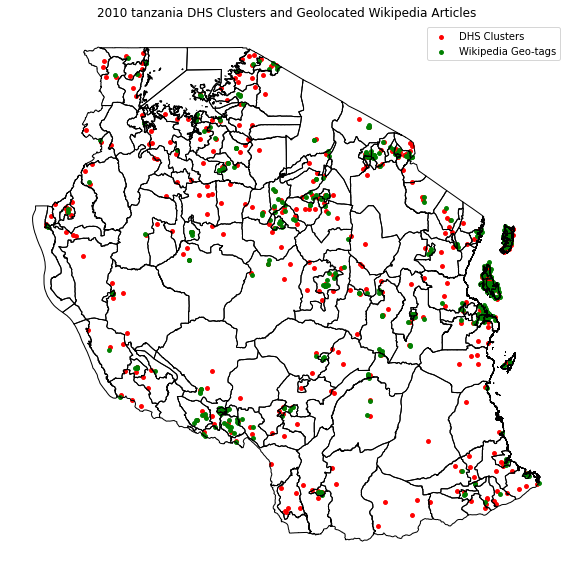

In [78]:
tz_articles = process_country('tanzania', 2010, 'TZA', dhs_clusts, plot=True)  

In [14]:
ag_articles = process_country('angola', 2015, 'ANG', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 1/625 [00:00<08:17,  1.25it/s]

Processing Estádio das Mangueiras
Processing Roman Catholic Archdiocese of Saurímo
Processing Saurimo
Processing Saurimo Airport


Cluster Progress::   0%|          | 2/625 [00:12<43:45,  4.22s/it]

Processing Agostinho Neto University
Processing Estádio 11 de Novembro
Processing Pavilhão Multiusos do Kilamba
Processing Luanda Province
Processing Technical University of Angola
Processing Catholic University of Angola
Processing Roman Catholic Diocese of Viana, Angola
Processing Viana, Luanda
Processing Belas, Luanda
Processing Kilamba
Processing Quilamba Quiaxi
Processing Pavilhão Dream Space


Cluster Progress::   1%|          | 5/625 [00:54<1:19:19,  7.68s/it]

Processing Roman Catholic Diocese of Cabinda
Processing Republic of Cabinda
Processing Pavilhão do Tafe
Processing Cabinda (city)
Processing Estádio Municipal do Tafe
Processing Cabinda Airport
Processing Estádio Nacional do Chiazi


Cluster Progress::   1%|          | 7/625 [01:21<1:39:41,  9.68s/it]

Processing Balombo


Cluster Progress::   1%|▏         | 9/625 [01:26<58:42,  5.72s/it]  

Processing Cazenga
Processing Cacuaco
Processing National Space Program Management Office (GGPEN)
Processing Campo Mário Santiago
Processing Campo de São Paulo
Processing Rangel, Luanda
Processing Estádio da Cidadela
Processing Pavilhão da Cidadela
Processing Atlético Petróleos de Luanda (basketball)
Processing Pavilhão Anexo II
Processing Pavilhão Anexo
Processing Luanda Bay
Processing Avenida Comandante Valòdia
Processing Fortress of São Francisco do Penedo


Cluster Progress::   2%|▏         | 10/625 [02:12<3:02:07, 17.77s/it]

Processing Jean Piaget University of Angola


Cluster Progress::   2%|▏         | 13/625 [02:17<1:12:06,  7.07s/it]

Processing Roman Catholic Diocese of Menongue
Processing Hoji Ya Henda
Processing Menongue Airport


Cluster Progress::   2%|▏         | 14/625 [02:27<1:20:41,  7.92s/it]

Processing Lubango
Processing Roman Catholic Archdiocese of Lubango
Processing Estádio Nacional da Tundavala
Processing Estádio Nossa Senhora do Monte
Processing Lubango Airport


Cluster Progress::   2%|▏         | 15/625 [02:44<1:49:00, 10.72s/it]

Processing Xa Cassau


Cluster Progress::   3%|▎         | 17/625 [02:48<1:01:22,  6.06s/it]

Processing Estádio 1º de Maio (Malanje)
Processing Roman Catholic Archdiocese of Malanje
Processing Malanje Province
Processing Malanje
Processing Malanje Airport


Cluster Progress::   3%|▎         | 21/625 [03:11<41:39,  4.14s/it]  

Processing Chitato Airport
Processing Chitato
Processing Roman Catholic Diocese of Dundo
Processing Dundo
Processing Estádio Sagrada Esperança
Processing Dundo Airport
Processing Luachimo Hydroelectric Power Station


Cluster Progress::   4%|▍         | 24/625 [03:35<51:05,  5.10s/it]  

Processing Estádio França Ndalu
Processing Escola Portuguesa de Luanda
Processing Quatro de Fevereiro Airport
Processing 2003 Angola 727 disappearance


Cluster Progress::   4%|▍         | 25/625 [03:49<1:19:10,  7.92s/it]

Processing Tomboco


Cluster Progress::   4%|▍         | 26/625 [03:54<1:08:26,  6.86s/it]

Processing Cacolo
Processing Cacolo Airport


Cluster Progress::   4%|▍         | 27/625 [04:00<1:07:33,  6.78s/it]

Processing Lucapa Airport
Processing Lucapa


Cluster Progress::   5%|▍         | 30/625 [04:09<38:21,  3.87s/it]  

Processing Cuíto
Processing Estádio dos Eucaliptos (Angola)
Processing Roman Catholic Diocese of Kwito-Bié
Processing Joaquim Kapango Airport
Processing Kunje


Cluster Progress::   5%|▌         | 32/625 [04:27<56:33,  5.72s/it]  

Processing Estádio 22 de Junho
Processing Estádio Joaquim Dinis
Processing Futungo de Belas
Processing Luanda International School
Processing Maianga
Processing Samba, Luanda
Processing Luanda
Processing Talatona
Processing Roman Catholic Archdiocese of Luanda
Processing Belas Shopping
Processing Pavilhão Victorino Cunha
Processing National Library of Angola
Processing Josina Machel Hospital
Processing Apostolic Nunciature to Angola
Processing National Assembly (Angola)
Processing Ingombota
Processing Banco de Poupança e Crédito
Processing Nossa Senhora do Carmo
Processing Estádio dos Coqueiros
Processing Museu Nacional de Antropologia (Angola)
Processing Church of Our Lady of Remedies
Processing Museu Nacional de História Natural de Angola
Processing Palácio de Ferro
Processing National Bank of Angola
Processing Alto das Cruzes cemetery
Processing Fortress of São Miguel
Processing Museum of the Armed Forces (Angola)
Processing Nossa Senhora da Nazaré
Processing Bungo, Luanda
Processin

Cluster Progress::   5%|▌         | 33/625 [06:16<6:02:43, 36.76s/it]

Processing Roman Catholic Diocese of Caxito
Processing Caxito
Processing Estádio Municipal do Dande
Processing Mabubas


Cluster Progress::   6%|▌         | 37/625 [06:31<1:44:06, 10.62s/it]

Processing Estádio Nacional de Ombaka
Processing Cavaco, Angola
Processing Catumbela Airport
Processing Benguela
Processing Catumbela River


Cluster Progress::   6%|▌         | 38/625 [06:49<2:03:47, 12.65s/it]

Processing Cambundi-Catembo


Cluster Progress::   6%|▌         | 39/625 [06:53<1:39:40, 10.21s/it]

Processing Impulo


Cluster Progress::   6%|▋         | 40/625 [06:58<1:23:01,  8.52s/it]

Processing Missombo


Cluster Progress::   7%|▋         | 41/625 [07:01<1:08:31,  7.04s/it]

Processing National Museum of Slavery


Cluster Progress::   7%|▋         | 42/625 [07:05<58:21,  6.01s/it]  

Processing Kalandula Falls


Cluster Progress::   7%|▋         | 44/625 [07:09<38:07,  3.94s/it]

Processing Dondo, Angola
Processing Fortress of Kambambe
Processing Cambambe Hydroelectric Power Station


Cluster Progress::   7%|▋         | 45/625 [07:20<58:42,  6.07s/it]

Processing Bocoio


Cluster Progress::   7%|▋         | 46/625 [07:24<51:36,  5.35s/it]

Processing Pavilhão Welwitschia Mirabilis
Processing Pavilhão Palanca Negra Gigante
Processing Estádio Joaquim Morais
Processing Roman Catholic Diocese of Namibe
Processing Moçâmedes
Processing Namibe Province
Processing Bero River
Processing Port of Namibe
Processing Welwitschia Mirabilis Airport
Processing Baía de Namibe
Processing Sacomar, Angola


Cluster Progress::   8%|▊         | 47/625 [07:58<2:15:42, 14.09s/it]

Processing Chongorói


Cluster Progress::   8%|▊         | 50/625 [08:04<56:24,  5.89s/it]  

Processing Bolongongo
Processing Bula Atumba
Processing Quiculungo


Cluster Progress::   8%|▊         | 52/625 [08:16<51:45,  5.42s/it]  

Processing Soyo Airport
Processing Soyo
Processing Estádio dos Imbondeiros
Processing Soyo I Thermal Power Station
Processing Kwanda Island


Cluster Progress::   9%|▊         | 54/625 [08:34<1:00:50,  6.39s/it]

Processing Zaire Province
Processing Cathedral of the Holy Saviour of Congo
Processing Roman Catholic Diocese of Mbanza Congo
Processing M'banza-Kongo
Processing Mbanza Congo Airport


Cluster Progress::   9%|▉         | 55/625 [08:50<1:30:04,  9.48s/it]

Processing São Lucas, Angola


Cluster Progress::   9%|▉         | 56/625 [08:54<1:14:12,  7.83s/it]

Processing Cuimba


Cluster Progress::   9%|▉         | 58/625 [08:59<46:47,  4.95s/it]  

Processing Estádio do Ferroviário da Huíla
Processing Roman Catholic Archdiocese of Huambo
Processing Huambo
Processing Huambo Airport
Processing Albano Machado Airport


Cluster Progress::  10%|▉         | 61/625 [09:24<52:13,  5.56s/it]  

Processing Benguela Airport
Processing Estádio Municipal Edelfride Palhares da Costa
Processing Roman Catholic Diocese of Benguela


Cluster Progress::  10%|█         | 63/625 [09:35<48:03,  5.13s/it]  

Processing Cafunfo Airport
Processing Cafunfo


Cluster Progress::  10%|█         | 65/625 [09:43<39:21,  4.22s/it]

Processing Battle of Quifangondo


Cluster Progress::  11%|█         | 68/625 [10:10<51:49,  5.58s/it]  

Processing Funda, Angola


Cluster Progress::  11%|█▏        | 71/625 [10:15<25:45,  2.79s/it]

Processing Roman Catholic Diocese of Ndalatando
Processing Estádio Municipal Santos Diniz
Processing N'dalatando
Processing Cazengo
Processing N'dalatando Airport


Cluster Progress::  12%|█▏        | 72/625 [10:34<1:09:11,  7.51s/it]

Processing Estádio Mundunduleno
Processing Luena Airport
Processing Roman Catholic Diocese of Lwena
Processing Moxico (municipality)
Processing Luena, Angola


Cluster Progress::  13%|█▎        | 84/625 [10:57<06:38,  1.36it/s]  

Processing Luau, Moxico Province
Processing Luau Airport
Processing Luau International Airport


Cluster Progress::  14%|█▍        | 90/625 [11:10<10:59,  1.23s/it]

Processing Biópio


Cluster Progress::  15%|█▍        | 91/625 [11:13<16:21,  1.84s/it]

Processing Tômbua


Cluster Progress::  15%|█▍        | 93/625 [11:17<16:51,  1.90s/it]

Processing Uíge Airport
Processing Quitexe
Processing Uíge
Processing Uíge Province
Processing Roman Catholic Diocese of Uíje
Processing Estádio 4 de Janeiro


Cluster Progress::  17%|█▋        | 105/625 [11:51<08:27,  1.02it/s] 

Processing Matala, Angola
Processing Matala Hydroelectric Power Station


Cluster Progress::  17%|█▋        | 107/625 [11:59<19:47,  2.29s/it]

Processing Mussulo


Cluster Progress::  17%|█▋        | 108/625 [12:03<23:40,  2.75s/it]

Processing Xá-Muteba


Cluster Progress::  18%|█▊        | 113/625 [12:09<10:53,  1.28s/it]

Processing Mupa


Cluster Progress::  18%|█▊        | 114/625 [12:13<17:28,  2.05s/it]

Processing N'zeto
Processing Nzeto
Processing N'zeto Airport


Cluster Progress::  18%|█▊        | 115/625 [12:23<37:41,  4.43s/it]

Processing Oupyakadi


Cluster Progress::  19%|█▉        | 119/625 [12:29<16:34,  1.97s/it]

Processing Cubal


Cluster Progress::  20%|██        | 125/625 [12:38<09:23,  1.13s/it]

Processing Ilha de Luanda


Cluster Progress::  20%|██        | 126/625 [12:43<20:24,  2.45s/it]

Processing Maué, Angola


Cluster Progress::  22%|██▏       | 135/625 [12:54<07:38,  1.07it/s]

Processing Ebo, Angola


Cluster Progress::  22%|██▏       | 140/625 [13:01<08:46,  1.09s/it]

Processing Maquela do Zombo
Processing Sambizanga
Processing Maquela Airport


Cluster Progress::  23%|██▎       | 145/625 [13:15<12:25,  1.55s/it]

Processing Catoca Airport


Cluster Progress::  23%|██▎       | 146/625 [13:19<18:29,  2.32s/it]

Processing Oshikango Constituency
Processing Oshikango
Processing Helao Nafidi
Processing Engela Constituency
Processing Namacunde
Processing Engela


Cluster Progress::  24%|██▍       | 149/625 [13:43<35:30,  4.48s/it]  

Processing Belo Horizonte, Angola


Cluster Progress::  24%|██▍       | 153/625 [13:49<15:47,  2.01s/it]

Processing Léua


Cluster Progress::  25%|██▍       | 154/625 [13:52<17:30,  2.23s/it]

Processing Chibia


Cluster Progress::  27%|██▋       | 170/625 [14:08<06:20,  1.20it/s]

Processing Lobito, Canata
Processing Estádio do Buraco
Processing Lobito Airport
Processing Port of Lobito
Processing Lobito
Processing Compão
Processing Catumbela


Cluster Progress::  28%|██▊       | 175/625 [14:35<17:26,  2.32s/it]

Processing Macocola
Processing Santa Cruz, Angola


Cluster Progress::  28%|██▊       | 178/625 [14:42<15:17,  2.05s/it]

Processing Caombo


Cluster Progress::  29%|██▊       | 179/625 [14:46<19:49,  2.67s/it]

Processing Negage
Processing Negage Airport


Cluster Progress::  29%|██▉       | 180/625 [14:52<27:03,  3.65s/it]

Processing Tempué


Cluster Progress::  29%|██▉       | 182/625 [14:57<20:29,  2.77s/it]

Processing Mbunda language
Processing Rulers of Mbundaland
Processing List of Mbunda Chiefs in Zambia
Processing Bundas
Processing Mbunda people
Processing Lumbala Airport


Cluster Progress::  29%|██▉       | 183/625 [15:37<1:43:44, 14.08s/it]

Processing Cuvo River
Processing Gabela, Angola


Cluster Progress::  30%|███       | 188/625 [15:48<25:41,  3.53s/it]  

Processing Matadiva


Cluster Progress::  31%|███       | 192/625 [15:55<13:22,  1.85s/it]

Processing Nzagi (Andrada)
Processing Nzagi Airport


Cluster Progress::  31%|███       | 193/625 [16:03<25:23,  3.53s/it]

Processing Mucusso
Processing Andara


Cluster Progress::  31%|███       | 194/625 [16:08<28:44,  4.00s/it]

Processing Cuíma


Cluster Progress::  31%|███▏      | 196/625 [16:12<21:34,  3.02s/it]

Processing Rivungo
Processing Shangombo
Processing Shangombo District


Cluster Progress::  32%|███▏      | 203/625 [16:29<10:10,  1.45s/it]

Processing Cuvelai
Processing Cuvelai, Cunene


Cluster Progress::  34%|███▎      | 210/625 [16:40<06:55,  1.00s/it]

Processing Cuilo Pombo


Cluster Progress::  34%|███▍      | 212/625 [16:43<08:28,  1.23s/it]

Processing Dembos
Processing Maino (Angola)


Cluster Progress::  35%|███▌      | 221/625 [16:54<06:03,  1.11it/s]

Processing Cazombo Airport
Processing Alto Zambeze


Cluster Progress::  36%|███▌      | 222/625 [17:01<18:17,  2.72s/it]

Processing Bengo River


Cluster Progress::  37%|███▋      | 233/625 [17:10<04:54,  1.33it/s]

Processing Dirico
Processing Dirico Airport
Processing Linus Shashipapo Secondary School
Processing Ndiyona Constituency
Processing Nyangana


Cluster Progress::  38%|███▊      | 237/625 [17:28<15:00,  2.32s/it]

Processing Conda, Angola


Cluster Progress::  38%|███▊      | 238/625 [17:32<18:31,  2.87s/it]

Processing Porto Amboim Airport
Processing Porto Amboim


Cluster Progress::  40%|███▉      | 247/625 [17:46<06:45,  1.07s/it]

Processing Caluquembe


Cluster Progress::  40%|███▉      | 249/625 [17:52<11:46,  1.88s/it]

Processing Alto Hama


Cluster Progress::  41%|████      | 256/625 [18:01<06:31,  1.06s/it]

Processing Longonjo


Cluster Progress::  43%|████▎     | 269/625 [18:16<04:23,  1.35it/s]

Processing Kelo, Angola


Cluster Progress::  44%|████▎     | 272/625 [18:21<07:41,  1.31s/it]

Processing Ambaca
Processing Camabatela Airport
Processing Cacuzo


Cluster Progress::  44%|████▍     | 278/625 [18:34<07:39,  1.33s/it]

Processing Kinzau


Cluster Progress::  45%|████▌     | 282/625 [18:39<05:23,  1.06it/s]

Processing Quibaxe


Cluster Progress::  49%|████▉     | 305/625 [19:00<03:54,  1.37it/s]

Processing Cuanza Sul Province


Cluster Progress::  50%|█████     | 313/625 [19:12<04:54,  1.06it/s]

Processing Luremo


Cluster Progress::  50%|█████     | 314/625 [19:16<08:30,  1.64s/it]

Processing Ambriz Airport
Processing Ambriz


Cluster Progress::  50%|█████     | 315/625 [19:23<17:03,  3.30s/it]

Processing 2009 Angola, Namibia and Zambia floods
Processing Onamunhama


Cluster Progress::  52%|█████▏    | 323/625 [19:38<06:08,  1.22s/it]

Processing Kaholo


Cluster Progress::  52%|█████▏    | 326/625 [19:45<08:04,  1.62s/it]

Processing Milunga


Cluster Progress::  52%|█████▏    | 327/625 [19:49<11:18,  2.28s/it]

Processing Cangandala


Cluster Progress::  53%|█████▎    | 329/625 [19:55<11:22,  2.30s/it]

Processing Cahama


Cluster Progress::  53%|█████▎    | 331/625 [19:58<09:44,  1.99s/it]

Processing Andulo Airport


Cluster Progress::  53%|█████▎    | 334/625 [20:04<08:23,  1.73s/it]

Processing Golungo Alto
Processing Alto Cauale
Processing Luinha, Angola


Cluster Progress::  55%|█████▍    | 342/625 [20:20<05:15,  1.11s/it]

Processing Bailundo


Cluster Progress::  56%|█████▌    | 351/625 [20:31<04:08,  1.10it/s]

Processing Quimbele


Cluster Progress::  56%|█████▋    | 353/625 [20:36<06:49,  1.51s/it]

Processing Chicomba


Cluster Progress::  57%|█████▋    | 355/625 [20:41<08:44,  1.94s/it]

Processing Cambulo


Cluster Progress::  57%|█████▋    | 359/625 [20:47<06:10,  1.39s/it]

Processing Gombe, Angola


Cluster Progress::  59%|█████▊    | 366/625 [20:56<04:02,  1.07it/s]

Processing Bembe, Angola


Cluster Progress::  59%|█████▉    | 370/625 [21:02<04:46,  1.12s/it]

Processing Xangongo Airport
Processing Xangongo
Processing Ombadja
Processing Battle of Mufilo
Processing Shangalala
Processing Humbe


Cluster Progress::  60%|█████▉    | 372/625 [21:21<18:55,  4.49s/it]

Processing Luinga


Cluster Progress::  60%|█████▉    | 374/625 [21:26<14:00,  3.35s/it]

Processing Roman Catholic Diocese of Ondjiva
Processing Ondjiva
Processing Ondjiva Pereira Airport


Cluster Progress::  61%|██████▏   | 383/625 [21:44<04:33,  1.13s/it]

Processing Cuchi


Cluster Progress::  61%|██████▏   | 384/625 [21:49<09:16,  2.31s/it]

Processing Camanongue


Cluster Progress::  64%|██████▍   | 399/625 [22:04<03:11,  1.18it/s]

Processing Piri, Angola


Cluster Progress::  64%|██████▍   | 400/625 [22:08<06:55,  1.85s/it]

Processing Bibala


Cluster Progress::  67%|██████▋   | 420/625 [22:28<02:58,  1.15it/s]

Processing Sumbe Airport
Processing Sumbe
Processing Roman Catholic Diocese of Sumbe


Cluster Progress::  71%|███████   | 441/625 [22:56<02:55,  1.05it/s]

Processing Cuango, Angola
Processing Cuango-Luzamba Airport


Cluster Progress::  71%|███████   | 444/625 [23:05<05:25,  1.80s/it]

Processing Kavango Region
Processing Mupini
Processing Rundu
Processing Rundu State Hospital


Cluster Progress::  72%|███████▏  | 449/625 [23:25<06:07,  2.09s/it]

Processing Calulo
Processing Estádio Municipal de Calulo


Cluster Progress::  72%|███████▏  | 453/625 [23:38<06:09,  2.15s/it]

Processing Baía Farta


Cluster Progress::  74%|███████▍  | 461/625 [23:48<02:08,  1.28it/s]

Processing Camacupa


Cluster Progress::  74%|███████▍  | 463/625 [23:52<03:40,  1.36s/it]

Processing Caála
Processing Estádio Mártires da Canhala


Cluster Progress::  76%|███████▌  | 472/625 [24:06<02:33,  1.01s/it]

Processing Mining industry of Angola
Processing Catoca diamond mine


Cluster Progress::  76%|███████▌  | 475/625 [24:20<06:41,  2.68s/it]

Processing Edundja


Cluster Progress::  79%|███████▊  | 492/625 [24:38<01:56,  1.14it/s]

Processing Catabola
Processing Chissamba


Cluster Progress::  79%|███████▉  | 493/625 [24:46<06:18,  2.86s/it]

Processing Dinge, Angola


Cluster Progress::  80%|███████▉  | 498/625 [24:53<02:57,  1.40s/it]

Processing Huambo Province


Cluster Progress::  81%|████████  | 504/625 [25:06<02:36,  1.30s/it]

Processing Assango


Cluster Progress::  82%|████████▏ | 511/625 [25:15<01:49,  1.04it/s]

Processing Huíla (commune)


Cluster Progress::  84%|████████▎ | 523/625 [25:28<01:28,  1.15it/s]

Processing Laúca Hydroelectric Power Station


Cluster Progress::  84%|████████▍ | 525/625 [25:35<03:03,  1.84s/it]

Processing Dombe Grande


Cluster Progress::  84%|████████▍ | 527/625 [25:40<03:20,  2.04s/it]

Processing Candumbo
Processing Songo, Angola


Cluster Progress::  88%|████████▊ | 552/625 [26:07<00:54,  1.33it/s]

Processing Pango Aluquém


Cluster Progress::  93%|█████████▎| 579/625 [26:31<00:41,  1.10it/s]

Processing Chila, Angola


Cluster Progress::  98%|█████████▊| 615/625 [27:04<00:07,  1.29it/s]

Processing Barra do Dande
Processing Dande
Processing Dande River


Cluster Progress:: 100%|██████████| 625/625 [27:22<00:00,  2.63s/it]


In [15]:
ben_articles = process_country('benin', 2012, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/746 [00:00<?, ?it/s]

Processing Arbonga
Processing Soroko, Benin
Processing Tokey Banta
Processing Banikoara
Processing Gomparou


Cluster Progress::   0%|          | 1/746 [00:15<3:14:55, 15.70s/it]

Processing Derou Garou
Processing Yadikparou
Processing Ounet
Processing Sompérékou
Processing Toura


Cluster Progress::   0%|          | 2/746 [00:41<3:51:21, 18.66s/it]

Processing Founougo


Cluster Progress::   1%|          | 5/746 [00:46<1:30:21,  7.32s/it]

Processing Goumori
Processing Kokey, Benin
Processing Kokiborou


Cluster Progress::   1%|▏         | 11/746 [01:00<25:27,  2.08s/it] 

Processing Gogounou
Processing Souri
Processing Gounarou
Processing Ouara, Benin


Cluster Progress::   2%|▏         | 12/746 [01:12<1:02:39,  5.12s/it]

Processing Sori, Benin


Cluster Progress::   2%|▏         | 13/746 [01:16<56:39,  4.64s/it]  

Processing Bagou, Benin


Cluster Progress::   2%|▏         | 16/746 [01:20<29:01,  2.39s/it]

Processing Zoungou-Pantrossi


Cluster Progress::   2%|▏         | 17/746 [01:24<35:28,  2.92s/it]

Processing Kandi Airport
Processing Kandi II
Processing Roman Catholic Diocese of Kandi
Processing Kandi III
Processing Kandi, Benin
Processing Alibori Department
Processing Kandi I


Cluster Progress::   2%|▏         | 18/746 [01:46<1:44:47,  8.64s/it]

Processing Kassakou
Processing Donwari


Cluster Progress::   3%|▎         | 21/746 [01:55<52:48,  4.37s/it]  

Processing Bensékou


Cluster Progress::   3%|▎         | 24/746 [02:01<31:06,  2.59s/it]

Processing Sonsoro
Processing Sam, Benin


Cluster Progress::   3%|▎         | 25/746 [02:07<45:02,  3.75s/it]

Processing Birni-Lafia


Cluster Progress::   3%|▎         | 26/746 [02:11<44:01,  3.67s/it]

Processing Alibori River
Processing Tombokoirey I
Processing Tanda, Niger


Cluster Progress::   4%|▎         | 27/746 [02:20<1:05:01,  5.43s/it]

Processing Kompa, Benin


Cluster Progress::   4%|▍         | 28/746 [02:24<57:52,  4.84s/it]  

Processing Mékrou River


Cluster Progress::   4%|▍         | 29/746 [02:27<53:59,  4.52s/it]

Processing Karimama, Benin
Processing Lété Island


Cluster Progress::   4%|▍         | 30/746 [02:33<58:19,  4.89s/it]

Processing Malanville
Processing Sota River
Processing Gaya Airport (Niger)
Processing Gaya, Niger


Cluster Progress::   5%|▍         | 34/746 [02:50<38:22,  3.23s/it]  

Processing Garou, Benin
Processing Mandécali


Cluster Progress::   5%|▍         | 36/746 [02:57<35:47,  3.02s/it]

Processing Guénè
Processing Guéné


Cluster Progress::   5%|▌         | 39/746 [03:05<28:20,  2.40s/it]

Processing Ségbana


Cluster Progress::   5%|▌         | 41/746 [03:10<28:11,  2.40s/it]

Processing Liboussou


Cluster Progress::   6%|▌         | 42/746 [03:14<32:49,  2.80s/it]

Processing Sokotindji


Cluster Progress::   6%|▌         | 43/746 [03:17<35:08,  3.00s/it]

Processing Boukoumbé
Processing Kouadangou
Processing Natta, Benin
Processing Bako Samaba


Cluster Progress::   6%|▌         | 44/746 [03:31<1:12:41,  6.21s/it]

Processing Korontière


Cluster Progress::   6%|▌         | 46/746 [03:36<48:07,  4.12s/it]  

Processing Dipoli, Benin


Cluster Progress::   6%|▋         | 47/746 [03:40<47:29,  4.08s/it]

Processing Kouaba
Processing Kossoucoingou


Cluster Progress::   6%|▋         | 48/746 [03:47<58:32,  5.03s/it]

Processing Manta, Benin


Cluster Progress::   7%|▋         | 50/746 [03:52<41:12,  3.55s/it]

Processing Kountori
Processing Cobly


Cluster Progress::   7%|▋         | 51/746 [04:00<54:51,  4.74s/it]

Processing Tapoga


Cluster Progress::   7%|▋         | 53/746 [04:04<39:24,  3.41s/it]

Processing Datori


Cluster Progress::   8%|▊         | 56/746 [04:09<22:44,  1.98s/it]

Processing Kérou


Cluster Progress::   8%|▊         | 57/746 [04:13<31:31,  2.74s/it]

Processing Brignamaro


Cluster Progress::   8%|▊         | 61/746 [04:20<18:41,  1.64s/it]

Processing Kouandé
Processing Oroukayo
Processing Fô-Tancé


Cluster Progress::   8%|▊         | 63/746 [04:30<33:38,  2.96s/it]

Processing Birni
Processing Papatia Botanical Garden


Cluster Progress::   9%|▊         | 64/746 [04:37<48:37,  4.28s/it]

Processing Chabi-Couma


Cluster Progress::   9%|▊         | 65/746 [04:49<1:14:28,  6.56s/it]

Processing Guilmaro


Cluster Progress::   9%|▉         | 68/746 [04:55<36:55,  3.27s/it]  

Processing Matéri


Cluster Progress::   9%|▉         | 70/746 [05:00<31:38,  2.81s/it]

Processing Tchianhoun-Cossi
Processing Dassari, Benin
Processing Tantéga


Cluster Progress::  10%|▉         | 72/746 [05:12<43:34,  3.88s/it]

Processing Gouandé


Cluster Progress::  10%|█         | 75/746 [05:17<25:06,  2.24s/it]

Processing Nodi


Cluster Progress::  10%|█         | 76/746 [05:21<30:40,  2.75s/it]

Processing Atakora Department
Processing Natitingou III
Processing Natitingou I
Processing Natitingou II
Processing Natitingou IV
Processing Natitingou
Processing Roman Catholic Diocese of Natitingou
Processing Koundata


Cluster Progress::  10%|█         | 77/746 [05:50<1:59:10, 10.69s/it]

Processing Boundétingou Airport


Cluster Progress::  11%|█         | 79/746 [05:54<1:08:05,  6.13s/it]

Processing Tchoumi-Tchoumi


Cluster Progress::  11%|█         | 81/746 [05:59<45:35,  4.11s/it]  

Processing Manafaga


Cluster Progress::  11%|█         | 82/746 [06:03<44:51,  4.05s/it]

Processing Tabota, Benin
Processing Kotapounga


Cluster Progress::  11%|█         | 83/746 [06:09<53:19,  4.83s/it]

Processing Perma (Benin)


Cluster Progress::  11%|█▏        | 85/746 [06:14<37:24,  3.40s/it]

Processing Ntounkwe


Cluster Progress::  12%|█▏        | 86/746 [06:17<37:51,  3.44s/it]

Processing Péhunco


Cluster Progress::  12%|█▏        | 87/746 [06:21<37:28,  3.41s/it]

Processing Gnémasson


Cluster Progress::  12%|█▏        | 90/746 [06:26<24:07,  2.21s/it]

Processing Tobré


Cluster Progress::  12%|█▏        | 91/746 [06:30<28:36,  2.62s/it]

Processing Tanguiéta


Cluster Progress::  13%|█▎        | 95/746 [06:36<15:45,  1.45s/it]

Processing Taiakou


Cluster Progress::  13%|█▎        | 96/746 [06:39<22:27,  2.07s/it]

Processing N'Dahonta
Processing Cotiakou


Cluster Progress::  13%|█▎        | 98/746 [06:45<25:08,  2.33s/it]

Processing Toucountouna
Processing Tampégré


Cluster Progress::  13%|█▎        | 99/746 [06:52<38:27,  3.57s/it]

Processing Kouarfa


Cluster Progress::  14%|█▎        | 101/746 [06:56<29:52,  2.78s/it]

Processing Africa Rice Center
Processing CEG Godomey
Processing Godomey
Processing ESCAE-University, Benin
Processing University of Abomey-Calavi
Processing Hévié
Processing Abomey-Calavi
Processing Stade de l'Amitié
Processing UTA Flight 141
Processing English International School


Cluster Progress::  14%|█▎        | 102/746 [07:27<2:00:00, 11.18s/it]

Processing Pahou


Cluster Progress::  14%|█▍        | 103/746 [07:31<1:37:06,  9.06s/it]

Processing Avlékété


Cluster Progress::  14%|█▍        | 104/746 [07:35<1:20:44,  7.55s/it]

Processing Établissement Français d'Enseignement Montaigne
Processing Benin Marina
Processing List of ambassadors of China to Benin


Cluster Progress::  14%|█▍        | 106/746 [07:45<1:01:36,  5.78s/it]

Processing Cotonou Central Mosque
Processing Estam University


Cluster Progress::  14%|█▍        | 108/746 [07:51<45:49,  4.31s/it]  

Processing 10th arrondissement of the Littoral Department
Processing 5th arrondissement of the Littoral Department
Processing 4th arrondissement of the Littoral Department
Processing 13th arrondissement of the Littoral Department
Processing 1st arrondissement of the Littoral Department
Processing 2nd arrondissement of the Littoral Department
Processing 9th arrondissement of the Littoral Department
Processing 7th arrondissement of the Littoral Department
Processing 8th arrondissement of the Littoral Department
Processing 6th arrondissement of the Littoral Department
Processing 3rd arrondissement of the Littoral Department
Processing Littoral (Benin)
Processing Cotonou


Cluster Progress::  15%|█▌        | 115/746 [08:40<27:49,  2.65s/it]  

Processing Zinvié
Processing Golo-Djigbé
Processing Togbota


Cluster Progress::  16%|█▌        | 116/746 [08:50<48:46,  4.65s/it]

Processing Akassato
Processing Kpanroun
Processing Sô-Ava
Processing Ganvié I
Processing Ganvie


Cluster Progress::  16%|█▌        | 118/746 [09:05<58:52,  5.62s/it]  

Processing Dékanmey
Processing Vekky
Processing Ahomey-Lokpo
Processing Houédo-Aguékon
Processing Ganvié II


Cluster Progress::  16%|█▌        | 120/746 [09:20<1:01:18,  5.88s/it]

Processing Ouédo


Cluster Progress::  16%|█▌        | 121/746 [09:24<54:49,  5.26s/it]  

Processing Adjarra I


Cluster Progress::  16%|█▋        | 122/746 [09:28<51:08,  4.92s/it]

Processing Dékin


Cluster Progress::  17%|█▋        | 124/746 [09:33<36:18,  3.50s/it]

Processing Avamè


Cluster Progress::  17%|█▋        | 127/746 [09:38<23:08,  2.24s/it]

Processing Kingdom of Ardra
Processing Allada
Processing Togoudo
Processing Ahouannonzoun
Processing Attogon
Processing Ayou
Processing Lissègazoun
Processing Sékou, Benin
Processing Agbanou
Processing Tori-Cada


Cluster Progress::  17%|█▋        | 128/746 [10:10<1:54:51, 11.15s/it]

Processing Tokpa-Avagoudo


Cluster Progress::  17%|█▋        | 130/746 [10:14<1:05:28,  6.38s/it]

Processing Avakpa
Processing Lon-Agonmey


Cluster Progress::  18%|█▊        | 131/746 [10:21<1:07:08,  6.55s/it]

Processing Atlantique Department
Processing Hinvi
Processing Dodji-Bata


Cluster Progress::  18%|█▊        | 132/746 [10:34<1:24:06,  8.22s/it]

Processing Azohouè-Aliho
Processing Tori-Gare


Cluster Progress::  18%|█▊        | 134/746 [10:41<58:56,  5.78s/it]  

Processing Sè, Atlantique
Processing Coussi


Cluster Progress::  18%|█▊        | 135/746 [10:47<57:46,  5.67s/it]

Processing Azohouè-Cada


Cluster Progress::  19%|█▊        | 139/746 [10:53<23:07,  2.29s/it]

Processing Agonkanmè
Processing Dedomè
Processing Tokpa-Domè
Processing Agbanto
Processing Aganmalomè
Processing Lake Ahémé
Processing Savi
Processing Ségbohoué


Cluster Progress::  19%|█▉        | 140/746 [11:19<1:35:53,  9.49s/it]

Processing Segboroué
Processing Kpomassè


Cluster Progress::  19%|█▉        | 141/746 [11:25<1:25:10,  8.45s/it]

Processing Bopa
Processing Couffo River


Cluster Progress::  19%|█▉        | 142/746 [11:33<1:20:54,  8.04s/it]

Processing Dahé


Cluster Progress::  19%|█▉        | 144/746 [11:37<50:12,  5.00s/it]  

Processing Houéyogbé
Processing Akodéha
Processing Ouèdèmè-Pédah
Processing Agatogbo


Cluster Progress::  20%|█▉        | 147/746 [11:51<39:30,  3.96s/it]  

Processing Ouidah
Processing Ouidah IV
Processing Ouidah I
Processing Ouidah II
Processing Ouidah III
Processing Basilique de l'Immaculée Conception
Processing Fort of São João Baptista de Ajudá
Processing Ouidah Museum of History
Processing Ouakpé-Daho
Processing Savi, Benin
Processing Djégbadji
Processing Gakpè


Cluster Progress::  21%|██        | 153/746 [12:35<30:55,  3.13s/it]  

Processing Tori-Bossito


Cluster Progress::  21%|██▏       | 160/746 [12:43<10:46,  1.10s/it]

Processing Aguégués
Processing Avagbodji
Processing Lake Nokoué
Processing Gbéko
Processing Houédomey
Processing Késsounou
Processing Houédomè
Processing Hozin
Processing Okpara River


Cluster Progress::  23%|██▎       | 168/746 [13:17<14:57,  1.55s/it]  

Processing Colli-Agbamè
Processing Houégbo
Processing Damè
Processing Toffo-Agué
Processing Séhouè
Processing Toffo


Cluster Progress::  23%|██▎       | 171/746 [13:36<32:43,  3.42s/it]

Processing Zè


Cluster Progress::  23%|██▎       | 174/746 [13:41<20:10,  2.12s/it]

Processing Dawé


Cluster Progress::  24%|██▎       | 176/746 [13:46<21:03,  2.22s/it]

Processing Kpomé


Cluster Progress::  25%|██▍       | 185/746 [13:56<07:42,  1.21it/s]

Processing Hékanmè
Processing Koundokpoè
Processing Adjan, Benin
Processing Yokpo
Processing Sèdjè-Houégoudo
Processing Sèdjè-Dénou
Processing Tangbo-Djevié


Cluster Progress::  25%|██▌       | 188/746 [14:21<38:20,  4.12s/it]  

Processing Djigbé
Processing Bonou


Cluster Progress::  26%|██▌       | 191/746 [14:28<23:47,  2.57s/it]

Processing Affamè
Processing Damè-Wogon
Processing Houinviguè
Processing Atchonsa


Cluster Progress::  26%|██▌       | 194/746 [14:43<30:42,  3.34s/it]

Processing Bembèrèkè


Cluster Progress::  26%|██▌       | 195/746 [14:47<31:43,  3.45s/it]

Processing Bembereke Airport


Cluster Progress::  26%|██▋       | 196/746 [14:51<34:33,  3.77s/it]

Processing Béroubouay


Cluster Progress::  26%|██▋       | 197/746 [14:55<34:10,  3.74s/it]

Processing Bouanri
Processing Woroumagassarou
Processing Gnonkourakali


Cluster Progress::  27%|██▋       | 201/746 [15:08<22:45,  2.51s/it]

Processing Kalalè
Processing Péonga


Cluster Progress::  27%|██▋       | 204/746 [15:17<22:02,  2.44s/it]

Processing Bouka, Benin


Cluster Progress::  28%|██▊       | 206/746 [15:22<20:31,  2.28s/it]

Processing Dèrassi


Cluster Progress::  28%|██▊       | 208/746 [15:27<20:18,  2.27s/it]

Processing N'Dali
Processing Roman Catholic Diocese of N'Dali
Processing Ourarou


Cluster Progress::  28%|██▊       | 210/746 [15:37<29:12,  3.27s/it]

Processing Bori, Benin


Cluster Progress::  28%|██▊       | 211/746 [15:41<30:17,  3.40s/it]

Processing Ouénou, N'Dali
Processing Ouénou, Nikki


Cluster Progress::  28%|██▊       | 212/746 [15:47<38:58,  4.38s/it]

Processing Sirarou


Cluster Progress::  29%|██▊       | 213/746 [15:52<38:40,  4.35s/it]

Processing Wore, Benin
Processing Debregourou
Processing Dokparou
Processing Ganou
Processing Sokouno
Processing Bakounkparou
Processing Gagbebou
Processing Karobouarou
Processing Wansirou
Processing Amawihon
Processing Darou Kourarou
Processing Ouroungourou
Processing Nikikperou
Processing Senouorou
Processing Kperou Guera
Processing Guérérou


Cluster Progress::  29%|██▊       | 214/746 [16:33<2:17:46, 15.54s/it]

Processing Danri
Processing Maro, Benin
Processing Nikki, Benin
Processing Gah Maro Peuhl
Processing Gah Maro
Processing Gourou
Processing Kpawolou
Processing Bouassi
Processing Gori, Benin
Processing Takou, Benin
Processing Monnon


Cluster Progress::  29%|██▉       | 215/746 [17:09<3:11:04, 21.59s/it]

Processing Tontarou Peuhl
Processing Soumarou
Processing Tontarou
Processing Suya, Benin


Cluster Progress::  29%|██▉       | 216/746 [17:22<2:47:35, 18.97s/it]

Processing Sakabansi


Cluster Progress::  29%|██▉       | 217/746 [17:26<2:08:18, 14.55s/it]

Processing Biro, Benin
Processing Gnanhoun
Processing Guinrou
Processing Sonsonré
Processing Ouenra
Processing Guinrou Peulh
Processing Ouenra Peuhl
Processing Guèma


Cluster Progress::  29%|██▉       | 218/746 [17:53<2:39:59, 18.18s/it]

Processing Gbari, Benin


Cluster Progress::  29%|██▉       | 219/746 [17:57<2:01:50, 13.87s/it]

Processing Sérékalé
Processing Chein Daroukpara


Cluster Progress::  29%|██▉       | 220/746 [18:03<1:42:52, 11.73s/it]

Processing Daroukpara
Processing Ganchon
Processing Pèrèrè
Processing Kassakpéré


Cluster Progress::  30%|██▉       | 221/746 [18:18<1:49:42, 12.54s/it]

Processing Tanakpé
Processing Tasso, Benin
Processing Gbabiré
Processing Chein
Processing Déma, Benin


Cluster Progress::  30%|██▉       | 222/746 [18:35<2:01:21, 13.90s/it]

Processing Parakou Airport
Processing Roman Catholic Archdiocese of Parakou
Processing Borgou Department
Processing Parakou
Processing Stade Municipal de Parakou
Processing 3rd arrondissement of Parakou
Processing 1st arrondissement of Parakou
Processing 2nd arrondissement of Parakou
Processing Gorobani
Processing Musée en Plein Air de Parakou
Processing Koumerou
Processing Kabro
Processing Worora
Processing Bereyadou
Processing Pépépétérou
Processing Kaborokpo
Processing Douerou
Processing Borarou
Processing Tourou
Processing Sanro
Processing Forane Kparou
Processing Bakounourou
Processing Sourou, Benin
Processing Tankaro Ga
Processing Sokoumeno
Processing Tabayorourou
Processing Teougourou Gando
Processing Ga Yakabou
Processing Tian, Benin
Processing Guinrerou
Processing Nekinparo
Processing Baperou
Processing Gommboko
Processing Moundouro
Processing Bakaga


Cluster Progress::  30%|██▉       | 223/746 [22:16<11:03:13, 76.09s/it]

Processing Goutere
Processing Kiparé
Processing Gouforou
Processing Pepekino


Cluster Progress::  30%|███       | 225/746 [22:28<5:45:59, 39.85s/it] 

Processing Yakassirou
Processing Tankaro


Cluster Progress::  30%|███       | 226/746 [22:34<4:17:53, 29.76s/it]

Processing Konkoma
Processing Tinekonparou


Cluster Progress::  32%|███▏      | 235/746 [22:48<18:26,  2.17s/it]  

Processing Sonoumo


Cluster Progress::  32%|███▏      | 236/746 [22:52<23:35,  2.77s/it]

Processing Kpané


Cluster Progress::  32%|███▏      | 238/746 [22:56<20:32,  2.43s/it]

Processing Guinagourou
Processing Gninsy
Processing Pébié


Cluster Progress::  32%|███▏      | 240/746 [23:07<29:05,  3.45s/it]

Processing Sèkèrè


Cluster Progress::  32%|███▏      | 241/746 [23:11<30:29,  3.62s/it]

Processing Sinendé


Cluster Progress::  32%|███▏      | 242/746 [23:14<29:58,  3.57s/it]

Processing Fô-Bourè


Cluster Progress::  33%|███▎      | 244/746 [23:19<24:17,  2.90s/it]

Processing Sikki


Cluster Progress::  33%|███▎      | 245/746 [23:24<27:24,  3.28s/it]

Processing Tchaourou


Cluster Progress::  34%|███▍      | 252/746 [23:33<09:40,  1.17s/it]

Processing Sanson, Benin


Cluster Progress::  34%|███▍      | 253/746 [23:38<18:11,  2.21s/it]

Processing Tchatchou


Cluster Progress::  34%|███▍      | 255/746 [23:42<17:16,  2.11s/it]

Processing Bantè
Processing Akpassi
Processing Koko, Benin
Processing Atokoligbé


Cluster Progress::  34%|███▍      | 256/746 [23:55<44:30,  5.45s/it]

Processing Bobè


Cluster Progress::  34%|███▍      | 257/746 [24:00<41:14,  5.06s/it]

Processing Agoua
Processing Atokou


Cluster Progress::  35%|███▍      | 260/746 [24:09<26:13,  3.24s/it]

Processing Gouka, Benin
Processing Kafingbe
Processing Abidzi


Cluster Progress::  35%|███▌      | 262/746 [24:19<31:14,  3.87s/it]

Processing Pira, Benin


Cluster Progress::  35%|███▌      | 263/746 [24:23<31:40,  3.94s/it]

Processing Dassa I
Processing Dassa II
Processing Roman Catholic Diocese of Dassa-Zoumé
Processing Dassa-Zoumé
Processing Lèma, Dassa-Zoumè


Cluster Progress::  35%|███▌      | 264/746 [24:38<58:24,  7.27s/it]

Processing Sokponta


Cluster Progress::  36%|███▌      | 269/746 [24:44<16:24,  2.06s/it]

Processing Soclogbo
Processing Gbaffo
Processing Paouingnan
Processing Akofodjoulè
Processing Kèrè
Processing Tré, Benin
Processing Kpingni


Cluster Progress::  37%|███▋      | 274/746 [25:10<19:59,  2.54s/it]  

Processing Glazoué


Cluster Progress::  37%|███▋      | 277/746 [25:16<15:40,  2.00s/it]

Processing Kpakpaza
Processing Aklankpa
Processing Zaffé
Processing Magoumi
Processing Gomè
Processing Assanté


Cluster Progress::  38%|███▊      | 285/746 [25:41<10:36,  1.38s/it]

Processing Ouèssè
Processing Laminou
Processing Odougba
Processing Challa-Ogoi
Processing Gbanlin


Cluster Progress::  38%|███▊      | 287/746 [25:58<32:37,  4.26s/it]

Processing Djègbè, Collines


Cluster Progress::  39%|███▊      | 289/746 [26:03<24:02,  3.16s/it]

Processing Kilibo
Processing Kèmon


Cluster Progress::  39%|███▉      | 292/746 [26:11<19:02,  2.52s/it]

Processing Toui
Processing Adido


Cluster Progress::  39%|███▉      | 294/746 [26:19<21:31,  2.86s/it]

Processing Collines Department
Processing Savalou


Cluster Progress::  40%|███▉      | 295/746 [26:28<36:46,  4.89s/it]

Processing Logozohoué
Processing Kpataba
Processing Savalou-Aga
Processing Ouèssè, Savalou
Processing Lahotan
Processing Savalou-Attakè
Processing Lèma, Savalou
Processing Ottola
Processing Monkpa


Cluster Progress::  40%|███▉      | 298/746 [27:00<48:19,  6.47s/it]  

Processing Djaloukou


Cluster Progress::  40%|████      | 299/746 [27:04<42:35,  5.72s/it]

Processing Amou, Benin
Processing Abeokouta
Processing Akoumokoumo


Cluster Progress::  40%|████      | 300/746 [27:15<54:11,  7.29s/it]

Processing Savalou-Agbado


Cluster Progress::  40%|████      | 302/746 [27:18<32:20,  4.37s/it]

Processing Tchetti


Cluster Progress::  41%|████      | 307/746 [27:25<11:45,  1.61s/it]

Processing Savè
Processing Savé Airport
Processing Ofè
Processing Plateau, Benin
Processing Sakin


Cluster Progress::  42%|████▏     | 311/746 [27:43<17:56,  2.47s/it]

Processing Kaboua
Processing Kokoro, Benin


Cluster Progress::  42%|████▏     | 315/746 [27:52<13:03,  1.82s/it]

Processing Moyen-Mono Prefecture


Cluster Progress::  42%|████▏     | 316/746 [27:55<16:42,  2.33s/it]

Processing Azovè
Processing Aplahoué
Processing Sokouhoué
Processing Kinkinhoué
Processing Djakotomey
Processing Djakotomey I
Processing Djakotomey II


Cluster Progress::  42%|████▏     | 317/746 [28:18<1:00:18,  8.43s/it]

Processing Kokohoué
Processing Houègamey
Processing Adjintimey
Processing Bètoumey


Cluster Progress::  43%|████▎     | 318/746 [28:32<1:11:55, 10.08s/it]

Processing Atomè
Processing Dekpo


Cluster Progress::  43%|████▎     | 319/746 [28:38<1:03:25,  8.91s/it]

Processing Gohomey
Processing Kissamey
Processing Godohou


Cluster Progress::  43%|████▎     | 322/746 [28:50<34:43,  4.91s/it]  

Processing Togba, Benin


Cluster Progress::  43%|████▎     | 323/746 [28:54<32:39,  4.63s/it]

Processing Lonkly


Cluster Progress::  44%|████▎     | 325/746 [28:59<24:05,  3.43s/it]

Processing Tado


Cluster Progress::  44%|████▍     | 327/746 [29:03<18:40,  2.67s/it]

Processing Missinko
Processing Tannou-Gola
Processing Doko, Benin
Processing Avédjin
Processing Houédogli
Processing Kouffo Department


Cluster Progress::  44%|████▍     | 328/746 [29:26<1:00:43,  8.72s/it]

Processing Kpoba
Processing Kpota
Processing Ayomi


Cluster Progress::  44%|████▍     | 330/746 [29:37<46:02,  6.64s/it]  

Processing Honton
Processing Totchagni
Processing Lokogohoué
Processing Madjrè
Processing Dogbo-Tota
Processing Tota, Benin
Processing Dèvè


Cluster Progress::  45%|████▍     | 332/746 [30:00<55:53,  8.10s/it]  

Processing Toviklin


Cluster Progress::  45%|████▍     | 335/746 [30:06<27:14,  3.98s/it]

Processing Agamé
Processing Zoungamè


Cluster Progress::  45%|████▌     | 336/746 [30:13<33:20,  4.88s/it]

Processing Lake Togbadji


Cluster Progress::  46%|████▌     | 340/746 [30:19<14:31,  2.15s/it]

Processing Ouèdèmè


Cluster Progress::  46%|████▌     | 341/746 [30:23<18:18,  2.71s/it]

Processing Sè, Mono


Cluster Progress::  46%|████▌     | 345/746 [30:30<11:11,  1.67s/it]

Processing Klouékanmè
Processing Lalo, Benin
Processing Tchikpé
Processing Djotto
Processing Adjanhonmè
Processing Hondji
Processing Aya-Hohoué


Cluster Progress::  47%|████▋     | 348/746 [30:57<30:46,  4.64s/it]

Processing Ahogbèya
Processing Sahé
Processing Lanta, Benin
Processing Agbangnizoun
Processing Kinta, Benin
Processing Siwé
Processing Adahondjigon
Processing Adingningon
Processing Lissazounmè


Cluster Progress::  48%|████▊     | 356/746 [31:33<11:35,  1.78s/it]  

Processing Hlassamè
Processing Gnizounmè
Processing Banigbé, Donga
Processing Zalli
Processing Lokogba
Processing Ahondjinnako
Processing Tohou, Benin
Processing Adoukandji
Processing Ahomadégbé


Cluster Progress::  48%|████▊     | 361/746 [32:02<17:41,  2.76s/it]

Processing Tchito
Processing Akiza, Benin


Cluster Progress::  49%|████▉     | 369/746 [32:15<06:42,  1.07s/it]

Processing Bassila
Processing Bakana-Kari
Processing Lagbere
Processing Guiguizo
Processing Manigri
Processing Kikele


Cluster Progress::  50%|████▉     | 370/746 [32:28<29:45,  4.75s/it]

Processing Afodiobo


Cluster Progress::  50%|████▉     | 371/746 [32:31<26:22,  4.22s/it]

Processing Dogue, Benin
Processing Igbomakoro


Cluster Progress::  50%|████▉     | 372/746 [32:35<26:00,  4.17s/it]

Processing Biguina
Processing Aworo
Processing Okouta-Boussa


Cluster Progress::  50%|█████     | 373/746 [32:45<36:05,  5.81s/it]

Processing Kpartao
Processing Aledjo-Koura
Processing Tchembere
Processing Niala, Benin
Processing Ogougouworo
Processing Ngioro
Processing Alori
Processing Adeli, Benin
Processing Mont Sokbaro
Processing Kouloumizi
Processing Kado, Togo
Processing Akarade
Processing Yadia
Processing Kemetou Penezoulou
Processing Kemetou Alidjo
Processing Iyo, Benin
Processing Agougou
Processing Odola
Processing Tiatiala
Processing Tiakpartia
Processing Soudou
Processing Kadjimani
Processing Gando, Benin
Processing Bomboua
Processing Touroumini
Processing Penelan


Cluster Progress::  50%|█████     | 374/746 [33:41<2:09:13, 20.84s/it]

Processing Koakoaliki


Cluster Progress::  50%|█████     | 376/746 [33:45<1:08:29, 11.11s/it]

Processing Pénéssoulou
Processing Inkolonie
Processing Gatakpal
Processing Kokotyi


Cluster Progress::  51%|█████     | 377/746 [33:55<1:06:50, 10.87s/it]

Processing Copargo
Processing Djougou Rural
Processing Pabégou
Processing Singré


Cluster Progress::  51%|█████     | 380/746 [34:12<39:02,  6.40s/it]  

Processing Massi, Benin


Cluster Progress::  51%|█████▏    | 383/746 [34:18<19:23,  3.21s/it]

Processing Anandana


Cluster Progress::  51%|█████▏    | 384/746 [34:22<20:57,  3.48s/it]

Processing Stade Municipal de Djougou
Processing Djougou I
Processing Donga Department
Processing Djougou
Processing Roman Catholic Diocese of Djougou
Processing Djougou III
Processing Djougou Airport
Processing Sérou
Processing Prekete


Cluster Progress::  52%|█████▏    | 389/746 [34:57<19:50,  3.33s/it]  

Processing Bariénou
Processing Patargo
Processing Pélébina
Processing Djougou II
Processing Bélléfoungou


Cluster Progress::  52%|█████▏    | 390/746 [35:09<36:24,  6.14s/it]

Processing Barei


Cluster Progress::  53%|█████▎    | 394/746 [35:14<12:51,  2.19s/it]

Processing Bougou, Benin
Processing Kaoute
Processing Bodi, Benin


Cluster Progress::  53%|█████▎    | 395/746 [35:21<22:06,  3.78s/it]

Processing Kolokondé


Cluster Progress::  53%|█████▎    | 397/746 [35:26<16:26,  2.83s/it]

Processing Sakouna
Processing Sakouna-Neugbawaperoun


Cluster Progress::  53%|█████▎    | 398/746 [35:31<19:47,  3.41s/it]

Processing Onklou


Cluster Progress::  54%|█████▎    | 400/746 [35:34<14:26,  2.50s/it]

Processing Badjoudè
Processing Ouaké
Processing Alemande
Processing Tereouda
Processing Kemerida
Processing Kadianga


Cluster Progress::  54%|█████▍    | 401/746 [35:52<40:29,  7.04s/it]

Processing Tialaide
Processing Sirka, Togo
Processing Adumdé


Cluster Progress::  54%|█████▍    | 403/746 [36:01<31:00,  5.43s/it]

Processing Sèmèrè I
Processing Sèmèrè II
Processing Kondé


Cluster Progress::  54%|█████▍    | 404/746 [36:12<41:03,  7.20s/it]

Processing University of Science and Technology of Benin
Processing Stade René Pleven d'Akpakpa
Processing West African Power Pool
Processing Ségbeya
Processing Ancien Pont
Processing Ouémé River
Processing Cotonou Cathedral
Processing Roman Catholic Archdiocese of Cotonou
Processing Agblangandan
Processing Ekpè


Cluster Progress::  65%|██████▌   | 488/746 [37:47<02:45,  1.56it/s]  

Processing Kpinnou
Processing Atchannou
Processing Dédékpoé
Processing Houin
Processing Koudo
Processing Houèdèmè-Adja
Processing Athiémè
Processing Mono Department
Processing Lokossa
Processing Roman Catholic Diocese of Lokossa
Processing Lake Toho (Benin)
Processing Adohoun


Cluster Progress::  66%|██████▌   | 492/746 [38:27<20:01,  4.73s/it]

Processing Masséda
Processing Oumako


Cluster Progress::  66%|██████▋   | 495/746 [38:36<12:54,  3.09s/it]

Processing Agbodji
Processing Yégodoé
Processing Possotomè


Cluster Progress::  67%|██████▋   | 497/746 [38:47<15:57,  3.85s/it]

Processing Lobogo
Processing Gbakpodji
Processing Badazoui


Cluster Progress::  67%|██████▋   | 499/746 [38:58<17:52,  4.34s/it]

Processing Doutou


Cluster Progress::  67%|██████▋   | 502/746 [39:04<10:00,  2.46s/it]

Processing Zoungbonou
Processing Honhoué


Cluster Progress::  67%|██████▋   | 503/746 [39:11<15:25,  3.81s/it]

Processing Comè
Processing Djanglanmè


Cluster Progress::  68%|██████▊   | 504/746 [39:19<20:44,  5.14s/it]

Processing Sazoué
Processing Djanglanmey
Processing Gbéhoué


Cluster Progress::  68%|██████▊   | 511/746 [39:35<06:05,  1.55s/it]

Processing Adjaha
Processing Grand-Popo
Processing Villa Karo
Processing Avloh


Cluster Progress::  69%|██████▊   | 512/746 [39:49<21:10,  5.43s/it]

Processing Agoué
Processing Agué
Processing Sebe
Processing Mono River
Processing Aného
Processing Lacs Prefecture
Processing Roman Catholic Diocese of Aného


Cluster Progress::  72%|███████▏  | 537/746 [40:28<03:01,  1.15it/s]

Processing Adjarra II
Processing Adjarra
Processing Dangbo
Processing Atchoukpa
Processing Avrankou
Processing Gbozounmè
Processing Djomon
Processing Sado, Benin
Processing Kouty
Processing Ouanho
Processing National Library of Benin
Processing Great Mosque of Porto-Novo
Processing Stade Charles de Gaulle
Processing Honvié
Processing Médédjonou
Processing Malanhoui
Processing Aglogbé
Processing Royal Palace, Porto-Novo
Processing Porto-Novo
Processing 1972 Dahomeyan coup d'état
Processing Stade Municipale (Porto-Novo)
Processing 5th arrondissement of Porto-Novo
Processing 1st arrondissement of Porto-Novo
Processing 2nd arrondissement of Porto-Novo
Processing 3rd arrondissement of Porto-Novo
Processing 4th arrondissement of Porto-Novo
Processing Daagbé
Processing Roman Catholic Diocese of Porto Novo
Processing Alexandre Sènou Adandé Ethnographic Museum
Processing Ouémé Department
Processing People's Republic of Benin
Processing Republic of Dahomey
Processing French Dahomey
Processing Pr

Cluster Progress::  73%|███████▎  | 545/746 [43:01<15:02,  4.49s/it]  

Processing Akpadanou
Processing Adjohoun


Cluster Progress::  73%|███████▎  | 546/746 [43:09<18:28,  5.54s/it]

Processing Gangban
Processing Awonou
Processing Azowlissè
Processing Zounguè


Cluster Progress::  74%|███████▎  | 550/746 [43:24<10:09,  3.11s/it]

Processing Katagon


Cluster Progress::  74%|███████▍  | 553/746 [43:30<06:37,  2.06s/it]

Processing Vakon
Processing Aholouyèmè


Cluster Progress::  74%|███████▍  | 554/746 [43:37<11:32,  3.60s/it]

Processing Djrègbè
Processing Tohouè, Ouémé


Cluster Progress::  75%|███████▍  | 557/746 [43:45<08:27,  2.69s/it]

Processing Takon


Cluster Progress::  75%|███████▌  | 561/746 [43:52<04:46,  1.55s/it]

Processing Yoko, Benin


Cluster Progress::  76%|███████▌  | 567/746 [44:00<03:12,  1.07s/it]

Processing Tchaada
Processing Ko-Koumolou


Cluster Progress::  77%|███████▋  | 577/746 [44:15<02:50,  1.01s/it]

Processing Ouinhi
Processing Dasso, Benin


Cluster Progress::  82%|████████▏ | 610/746 [44:48<01:42,  1.33it/s]

Processing Sèmè-Kpodji


Cluster Progress::  83%|████████▎ | 619/746 [44:59<02:01,  1.04it/s]

Processing Seme Border


Cluster Progress::  83%|████████▎ | 620/746 [45:03<04:03,  1.93s/it]

Processing Adja-Ouèrè
Processing Oko-Akarè
Processing Kpoulou
Processing Ikpinlè
Processing Totonnoukon
Processing Plateau Department
Processing Pobè
Processing Issaba
Processing Towé
Processing Ahoyéyé


Cluster Progress::  83%|████████▎ | 621/746 [45:37<24:14, 11.63s/it]

Processing Massè


Cluster Progress::  83%|████████▎ | 622/746 [45:41<19:21,  9.36s/it]

Processing Banigbé, Plateau
Processing Igana


Cluster Progress::  84%|████████▍ | 629/746 [45:53<03:21,  1.72s/it]

Processing Ifangni
Processing Lagbé


Cluster Progress::  85%|████████▍ | 631/746 [46:01<04:44,  2.47s/it]

Processing Ita-Djèbou
Processing Aguidi
Processing Sakété II
Processing Sakété
Processing Sakété I


Cluster Progress::  85%|████████▌ | 637/746 [46:22<03:20,  1.84s/it]

Processing Kétou, Benin
Processing Kpankou
Processing Odometa
Processing Okpometa


Cluster Progress::  86%|████████▌ | 641/746 [46:37<04:01,  2.30s/it]

Processing Adakplamé


Cluster Progress::  86%|████████▌ | 643/746 [46:42<03:50,  2.24s/it]

Processing Idigny


Cluster Progress::  86%|████████▋ | 644/746 [46:46<04:46,  2.81s/it]

Processing Celestial City, Imeko


Cluster Progress::  89%|████████▉ | 665/746 [47:10<01:03,  1.28it/s]

Processing Battle of Abomey
Processing Royal Palaces of Abomey
Processing Roman Catholic Diocese of Abomey
Processing Dahomey
Processing Abomey
Processing Zou Department
Processing Vidolè
Processing Sèhoun
Processing Hounli
Processing Djègbè, Zou
Processing Zounzounmè
Processing Agbokpa
Processing Dètohou
Processing Dekanmè
Processing Tanvé
Processing Mougnon
Processing Stade Municipal de Bohicon
Processing Bohicon II
Processing Cana Airport
Processing Bohicon I
Processing Cana I
Processing Bohicon
Processing Dohouimè


Cluster Progress::  89%|████████▉ | 667/746 [48:34<23:57, 18.20s/it]

Processing Manala, Benin


Cluster Progress::  90%|█████████ | 673/746 [48:42<03:37,  2.98s/it]

Processing Agongointo
Processing Lissèzoun
Processing Gnidjazoun
Processing Avogbana
Processing Ouassaho
Processing Saclo
Processing Sodohomè


Cluster Progress::  91%|█████████ | 676/746 [49:07<05:44,  4.92s/it]

Processing Zogbodomey
Processing Don, Benin
Processing Adjido
Processing Zoungoudo


Cluster Progress::  93%|█████████▎| 695/746 [49:35<00:41,  1.23it/s]

Processing Passagon
Processing Dan, Benin


Cluster Progress::  93%|█████████▎| 697/746 [49:43<01:47,  2.20s/it]

Processing Houngomey
Processing Kpakpamè
Processing Assalin
Processing Za-Tanta
Processing Zèko
Processing Kpozoun


Cluster Progress::  94%|█████████▎| 698/746 [50:03<05:53,  7.37s/it]

Processing Naogon
Processing Cové
Processing Zagnanado
Processing Don-Tan
Processing Dovi
Processing Allahé


Cluster Progress::  94%|█████████▎| 699/746 [50:24<09:06, 11.63s/it]

Processing Sagon, Benin
Processing Kpédékpo
Processing Banamè
Processing Agonli-Houégbo


Cluster Progress::  94%|█████████▍| 700/746 [50:38<09:19, 12.17s/it]

Processing Domè


Cluster Progress::  94%|█████████▍| 704/746 [50:45<02:46,  3.96s/it]

Processing Djidja


Cluster Progress::  95%|█████████▍| 705/746 [50:48<02:39,  3.88s/it]

Processing Oungbègamè
Processing Gobè
Processing Monsourou
Processing Agondji
Processing Outo
Processing Zoukou, Djidja
Processing Agou Prefecture


Cluster Progress::  95%|█████████▍| 708/746 [51:12<03:10,  5.01s/it]

Processing Agouna


Cluster Progress::  96%|█████████▌| 713/746 [51:19<00:57,  1.74s/it]

Processing Setto
Processing Agbado River


Cluster Progress::  96%|█████████▌| 715/746 [51:26<01:13,  2.38s/it]

Processing Tohoué, Zou


Cluster Progress::  97%|█████████▋| 722/746 [51:35<00:25,  1.07s/it]

Processing Gounli
Processing Houéko
Processing Zogba
Processing Soli, Benin
Processing Adogbé
Processing Lainta-Cogbè
Processing Houen-Hounso


Cluster Progress::  97%|█████████▋| 726/746 [52:00<01:03,  3.20s/it]

Processing Za-Kpota


Cluster Progress::  99%|█████████▉| 742/746 [52:17<00:03,  1.19it/s]

Processing Avlamè
Processing Zoukou, Zogbodomey
Processing Kpokissa
Processing Tanwé-Hessou
Processing Cana II
Processing Koussoukpa


Cluster Progress:: 100%|██████████| 746/746 [52:39<00:00,  4.24s/it]


In [17]:
bf_articles = process_country('burkina_faso', 2010, 'BEN', dhs_clusts, plot=False)   

Cluster Progress::   0%|          | 1/541 [00:00<03:45,  2.40it/s]

Processing Soucie
Processing Toukoro, Comoé
Processing Ouo
Processing Ouo Department


Cluster Progress::   0%|          | 2/541 [00:08<24:30,  2.73s/it]

Processing Batié Department
Processing Batié, Burkina Faso
Processing Noumbiel Province


Cluster Progress::   1%|          | 4/541 [00:14<23:55,  2.67s/it]

Processing Mouhoun Province
Processing Dédougou Department
Processing Roman Catholic Diocese of Dédougou
Processing Dédougou
Processing Dédougou Airport
Processing Boucle du Mouhoun Region


Cluster Progress::   1%|          | 5/541 [00:28<54:43,  6.13s/it]

Processing Kamsé
Processing Soula, Boulkiemdé
Processing Vella, Burkina Faso
Processing Bourou
Processing Savili
Processing Nariou
Processing Nabadogo


Cluster Progress::   1%|▏         | 7/541 [00:44<56:51,  6.39s/it]  

Processing Pissy, Burkina Faso
Processing Sissin
Processing Stade de la SONABEL
Processing 2009 West Africa floods
Processing 1987 Burkinabé coup d'état
Processing Stade du 4 Août
Processing Stade Municipal (Ouagadougou)
Processing Ouagadougou Department
Processing Roman Catholic Archdiocese of Ouagadougou
Processing Ouagadougou Cathedral
Processing Ouagadougou
Processing Thomas Sankara International Airport Ouagadougou
Processing Centre Region, Burkina Faso
Processing Kadiogo Province
Processing Lycée Saint-Exupéry de Ouagadougou
Processing 2016 Ouagadougou attacks
Processing National Confederation of Workers of Burkina
Processing List of ambassadors of China to Burkina Faso
Processing National Museum of Music (Burkina Faso)
Processing University of Ouagadougou


Cluster Progress::   1%|▏         | 8/541 [01:41<3:09:24, 21.32s/it]

Processing Tenkodogo Department
Processing Tenkodogo
Processing Roman Catholic Diocese of Tenkodogo
Processing Tenkodogo Airport
Processing Loanga, Tenkodogo
Processing Oueguedo
Processing Sampa, Burkina Faso


Cluster Progress::   2%|▏         | 9/541 [01:55<2:51:14, 19.31s/it]

Processing Ouintini
Processing Mafoulou
Processing Lefourba
Processing Foursa
Processing Sanhoui


Cluster Progress::   2%|▏         | 10/541 [02:06<2:28:43, 16.81s/it]

Processing Komsilga, Komsilga


Cluster Progress::   2%|▏         | 11/541 [02:08<1:49:35, 12.41s/it]

Processing Sahelis Productions
Processing Apostolic Nunciature to Burkina Faso
Processing Zagtouli Solar Power Station


Cluster Progress::   2%|▏         | 12/541 [02:15<1:33:33, 10.61s/it]

Processing Bangbily
Processing Tamidou, Zorgho
Processing Zinado
Processing Zorgho Department
Processing Lelkom
Processing Zorgho
Processing Gandaogo
Processing Douré, Boudry
Processing Gonkin
Processing Nédogo
Processing Bougré


Cluster Progress::   2%|▏         | 13/541 [02:37<2:04:33, 14.15s/it]

Processing Zecco Department
Processing Ziou Department


Cluster Progress::   3%|▎         | 14/541 [02:40<1:34:23, 10.75s/it]

Processing Roman Catholic Archdiocese of Bobo-Dioulasso
Processing Stade Wobi Bobo-Dioulasso
Processing Bobo Dioulasso Airport
Processing Bobo-Dioulasso Department
Processing Bobo-Dioulasso
Processing Stade Général Aboubacar Sangoulé Lamizana


Cluster Progress::   3%|▎         | 17/541 [02:57<54:32,  6.25s/it]  

Processing Roman Catholic Diocese of Koudougou
Processing Salbisgo-Dapoya
Processing Boulkiemdé Province
Processing Koudougou
Processing Koudougou Department
Processing Stade Balibiè
Processing Nayalgué, Boulkiemdé
Processing Lattou
Processing Doulou
Processing Koudougou Airport
Processing Kabinou
Processing Bouloum Nabyiri
Processing Kolonkandé
Processing University of Koudougou
Processing Ramongo Department
Processing Ramongo


Cluster Progress::   3%|▎         | 18/541 [03:30<2:05:54, 14.44s/it]

Processing Gnagna Province
Processing Bogandé Department
Processing Bogandé
Processing Bogande Airport
Processing Komonga
Processing Ouadangou


Cluster Progress::   4%|▎         | 20/541 [03:44<1:27:15, 10.05s/it]

Processing Somassi, Boulkiemdé
Processing Pelbilin
Processing Pella Department
Processing Pella, Burkina Faso
Processing Goala, Burkina Faso
Processing Daboala
Processing Kirguilounga
Processing Sarana, Pella
Processing Kandaga
Processing Nabziniguima
Processing Boulpon
Processing Babouli
Processing Sittaon


Cluster Progress::   4%|▍         | 21/541 [04:11<2:09:21, 14.93s/it]

Processing Nacombogo, Ipelce
Processing Ipelcé
Processing Ipelcé Department
Processing Widi
Processing Soulli
Processing Sincéné, Doulougou
Processing Dabogtinga
Processing Samsaongo
Processing Kactinga
Processing Baguemnini
Processing Boulougou
Processing Godin, Doulougou
Processing Nabdogo, Doulougou


Cluster Progress::   4%|▍         | 22/541 [04:37<2:40:09, 18.52s/it]

Processing Fouga, Burkina Faso


Cluster Progress::   5%|▍         | 25/541 [04:41<59:27,  6.91s/it]  

Processing Oui, Burkina Faso
Processing Tirbou
Processing Napalgué
Processing Dafire
Processing Yoba
Processing Daribiti (13°26′N 1°45′W)
Processing Touga
Processing Zamsé, Bam
Processing Téonsgo
Processing Boubou, Burkina Faso
Processing Dargouma
Processing Temnaoré, Bam
Processing Songodin
Processing Vato-Mossi
Processing Zingguima
Processing Ibi, Burkina Faso
Processing Kamtenga
Processing Ipala, Bam
Processing Loungue
Processing Dinguilga


Cluster Progress::   5%|▍         | 26/541 [05:21<2:25:42, 16.98s/it]

Processing Bama Department
Processing Diaradougou


Cluster Progress::   5%|▌         | 29/541 [05:26<56:43,  6.65s/it]  

Processing Douna Department
Processing Douna
Processing Sindou Department
Processing Sindou
Processing Gouindougouba


Cluster Progress::   6%|▌         | 30/541 [05:37<1:06:54,  7.86s/it]

Processing Saaba Department


Cluster Progress::   6%|▋         | 34/541 [05:41<20:23,  2.41s/it]  

Processing Fada N'gourma Department
Processing Roman Catholic Diocese of Fada N'Gourma
Processing Fada N'gourma
Processing Fada N'gourma Airport
Processing Boudangou
Processing Bantia Botanical Garden


Cluster Progress::   6%|▋         | 35/541 [05:52<44:29,  5.28s/it]

Processing Titao Department
Processing Loroum Province


Cluster Progress::   7%|▋         | 37/541 [05:57<29:09,  3.47s/it]

Processing Falagountou Department


Cluster Progress::   7%|▋         | 38/541 [05:59<26:27,  3.16s/it]

Processing Gando, Burkina Faso


Cluster Progress::   7%|▋         | 40/541 [06:01<17:08,  2.05s/it]

Processing Béguédo
Processing Béguédo Department
Processing Ouaregou
Processing Niaogho Department
Processing Fingla
Processing Niaogho
Processing Komtoèga Department
Processing Komtoèga
Processing Boussouma, Boulgou


Cluster Progress::   8%|▊         | 42/541 [06:20<41:15,  4.96s/it]

Processing Dassa Department
Processing Dassa, Burkina Faso


Cluster Progress::   8%|▊         | 44/541 [06:23<26:32,  3.21s/it]

Processing Roman Catholic Diocese of Banfora
Processing Stade Banfora
Processing Banfora Department
Processing Comoé Province
Processing Tangora
Processing Banfora
Processing Tiekouna
Processing Banfora Airport
Processing Lake Tengrela
Processing Sitiena
Processing Tengrela, Burkina Faso
Processing Karfiguela
Processing Karfiguéla


Cluster Progress::   8%|▊         | 45/541 [06:51<1:26:54, 10.51s/it]

Processing Diarra-Betongo
Processing Zonsé
Processing Zonsé Department


Cluster Progress::   9%|▉         | 48/541 [06:57<38:10,  4.65s/it]  

Processing Manga, Burkina Faso
Processing Zoundwéogo Province
Processing Manga Department
Processing Roman Catholic Diocese of Manga
Processing Binde, Burkina Faso


Cluster Progress::   9%|▉         | 49/541 [07:08<53:41,  6.55s/it]

Processing Tiogo Mossi
Processing Toêga


Cluster Progress::   9%|▉         | 50/541 [07:13<48:46,  5.96s/it]

Processing Ouarkoye
Processing Ouarkoye Department


Cluster Progress::  10%|▉         | 52/541 [07:18<33:15,  4.08s/it]

Processing Diassara
Processing Binte, Burkina Faso


Cluster Progress::  11%|█         | 57/541 [07:25<10:38,  1.32s/it]

Processing Sanguié Province
Processing Réo
Processing Réo Department


Cluster Progress::  11%|█         | 58/541 [07:32<26:09,  3.25s/it]

Processing Koulweogo
Processing Tanghin, Méguet
Processing Nabitenga
Processing Yougoulmandé
Processing Dabèga
Processing Kabouda


Cluster Progress::  11%|█         | 59/541 [07:44<45:01,  5.61s/it]

Processing Tindangou


Cluster Progress::  11%|█         | 60/541 [07:46<37:29,  4.68s/it]

Processing Kaya Airport
Processing Kaya Department
Processing Kaya, Burkina Faso
Processing Roman Catholic Diocese of Kaya


Cluster Progress::  11%|█▏        | 62/541 [07:55<33:02,  4.14s/it]

Processing Bazèga Province
Processing Kombissiri Department
Processing Kombissiri
Processing Bassemyam
Processing Tingandogo
Processing Bélégré
Processing Tandaga, Bazèga
Processing Pissi, Kombissiri
Processing Bissiga, Kombissiri
Processing Kagamzincé
Processing Pibsé
Processing Koassa
Processing Gana, Burkina Faso
Processing Goncé
Processing Kombous-Youngo
Processing Konioudou
Processing Yanga, Burkina Faso
Processing Kamsando
Processing Manegsombo
Processing Tuili, Burkina Faso


Cluster Progress::  12%|█▏        | 63/541 [08:34<1:57:39, 14.77s/it]

Processing Ouargaye Department


Cluster Progress::  12%|█▏        | 65/541 [08:37<1:02:27,  7.87s/it]

Processing Dano, Burkina Faso
Processing Dano Department
Processing Dano Airport


Cluster Progress::  12%|█▏        | 66/541 [08:44<58:59,  7.45s/it]  

Processing Boussé Department
Processing Boussé
Processing Temnaoré, Boulkiemdé
Processing Makoula
Processing Soala
Processing Palagré
Processing Lallé, Boulkiemdé


Cluster Progress::  13%|█▎        | 69/541 [08:58<37:50,  4.81s/it]  

Processing Ziniaré
Processing Ziniaré Department
Processing Loumbila Department


Cluster Progress::  13%|█▎        | 70/541 [09:04<39:16,  5.00s/it]

Processing Yargo, Toece
Processing Toece
Processing Toécé Department
Processing Goudou
Processing Goumsé
Processing Kosmassom
Processing Wilga, Burkina Faso
Processing Nacombogo, Toece
Processing Pawamtoré
Processing Loussa
Processing Tinsobtinga
Processing Toudou
Processing Binsboumbou
Processing Tanghin, Toece
Processing Goubla
Processing Lilbouré
Processing Damzoussi, Toece
Processing Silkouka
Processing Koumnéré
Processing Zangogho


Cluster Progress::  13%|█▎        | 71/541 [09:44<2:01:07, 15.46s/it]

Processing Ouahigouya
Processing Yatenga Province
Processing Roman Catholic Diocese of Ouahigouya
Processing Ouahigouya Department
Processing Ouahigouya Airport


Cluster Progress::  13%|█▎        | 72/541 [09:57<1:55:41, 14.80s/it]

Processing Lawra


Cluster Progress::  14%|█▍        | 75/541 [10:00<44:51,  5.78s/it]  

Processing Tambidi
Processing Liougou
Processing Komona
Processing Lipaka
Processing Dakiri
Processing Siédougou
Processing Kamissi
Processing Yarba
Processing Manni Department
Processing Manni
Processing Malioma
Processing Toabré, Burkina Faso


Cluster Progress::  14%|█▍        | 77/541 [10:24<1:00:25,  7.81s/it]

Processing Niankar


Cluster Progress::  14%|█▍        | 78/541 [10:27<48:28,  6.28s/it]  

Processing Pabré Department


Cluster Progress::  15%|█▌        | 83/541 [10:31<11:42,  1.53s/it]

Processing Di Department


Cluster Progress::  16%|█▌        | 84/541 [10:33<13:42,  1.80s/it]

Processing Gougré
Processing Guibare
Processing Guibaré Department
Processing Zandkom
Processing Bokin, Bam
Processing Imiougou
Processing Yilou, Burkina Faso
Processing Barsa, Burkina Faso
Processing Sindri, Burkina Faso
Processing Goungla


Cluster Progress::  16%|█▌        | 86/541 [10:53<39:05,  5.16s/it]

Processing Gorgadji Department


Cluster Progress::  16%|█▌        | 87/541 [10:56<34:39,  4.58s/it]

Processing Zerkoum
Processing Koné, Burkina Faso
Processing Gouim
Processing Kindi Department
Processing Nassoulou
Processing Nandiala Department


Cluster Progress::  16%|█▋        | 88/541 [11:09<52:20,  6.93s/it]

Processing Gourcy Department
Processing Gourcy


Cluster Progress::  17%|█▋        | 91/541 [11:14<24:00,  3.20s/it]

Processing Kaboré Tambi National Park
Processing Pô Department
Processing Guiaro Department


Cluster Progress::  17%|█▋        | 93/541 [11:20<20:58,  2.81s/it]

Processing Zogore Department


Cluster Progress::  17%|█▋        | 94/541 [11:22<19:27,  2.61s/it]

Processing Sama, Burkina Faso
Processing Bankouma
Processing Kouka Department
Processing Kouka, Banwa


Cluster Progress::  18%|█▊        | 97/541 [11:29<14:38,  1.98s/it]

Processing Zéguédéguin Department


Cluster Progress::  18%|█▊        | 98/541 [11:31<14:54,  2.02s/it]

Processing Guiba Department


Cluster Progress::  18%|█▊        | 99/541 [11:33<15:17,  2.08s/it]

Processing Gogo Department


Cluster Progress::  18%|█▊        | 100/541 [11:35<15:20,  2.09s/it]

Processing Sourgoubila Department
Processing Tio, Burkina Faso
Processing Séguédin, Siglé
Processing Tia, Burkina Faso


Cluster Progress::  19%|█▉        | 102/541 [11:44<21:53,  2.99s/it]

Processing Tougan Department
Processing Tougan
Processing Sourou Province
Processing Tougan Airport


Cluster Progress::  19%|█▉        | 103/541 [11:53<33:45,  4.62s/it]

Processing Gaoua Department
Processing Roman Catholic Diocese of Gaoua
Processing Gaoua
Processing Sidoumoukar
Processing Gaoua Airport


Cluster Progress::  20%|█▉        | 108/541 [12:06<13:54,  1.93s/it]

Processing Sarkounga


Cluster Progress::  20%|██        | 109/541 [12:09<15:55,  2.21s/it]

Processing Bittou Department
Processing Bekoure
Processing Nohao


Cluster Progress::  20%|██        | 110/541 [12:16<25:51,  3.60s/it]

Processing Barkoura


Cluster Progress::  21%|██        | 114/541 [12:19<09:37,  1.35s/it]

Processing Kampti Department


Cluster Progress::  21%|██▏       | 115/541 [12:21<11:00,  1.55s/it]

Processing Noumoutiedougou
Processing Tiebata
Processing Mangodara Department
Processing Mangodara


Cluster Progress::  21%|██▏       | 116/541 [12:30<26:02,  3.68s/it]

Processing Bani Department


Cluster Progress::  22%|██▏       | 117/541 [12:33<24:19,  3.44s/it]

Processing Konlobwamdé
Processing Kougpèla
Processing Konkuissé
Processing Konkossé
Processing Badnogo, Bazèga
Processing Bagadogo
Processing Guirgo, Bazèga
Processing Boussougou
Processing Batinga
Processing Bilbalogo
Processing Koakin, Kombissiri
Processing Wemtinga
Processing Borogo
Processing Koudiougou
Processing Kalwiga


Cluster Progress::  22%|██▏       | 119/541 [13:05<59:22,  8.44s/it]  

Processing Godé
Processing Ipendo
Processing Koupéla, Boulkiemdé
Processing Ouézindougou
Processing Nébiélianayou Department


Cluster Progress::  22%|██▏       | 120/541 [13:14<1:01:55,  8.83s/it]

Processing Roman Catholic Diocese of Dori
Processing Dori Department
Processing Séno Province
Processing Dori, Burkina Faso
Processing Kampiti
Processing Dori Airport


Cluster Progress::  22%|██▏       | 121/541 [13:25<1:05:19,  9.33s/it]

Processing Largogo


Cluster Progress::  23%|██▎       | 122/541 [13:27<50:19,  7.21s/it]  

Processing Djibo
Processing Soum Province
Processing Djibo Airport


Cluster Progress::  23%|██▎       | 127/541 [13:34<13:06,  1.90s/it]

Processing Doumbala Department


Cluster Progress::  24%|██▎       | 128/541 [13:37<14:19,  2.08s/it]

Processing Leo Airport
Processing Léo Department
Processing Léo, Burkina Faso


Cluster Progress::  24%|██▍       | 129/541 [13:42<21:12,  3.09s/it]

Processing Kirsi Department


Cluster Progress::  25%|██▍       | 133/541 [13:46<08:17,  1.22s/it]

Processing Boala Department


Cluster Progress::  25%|██▍       | 134/541 [13:48<10:11,  1.50s/it]

Processing Lalgaye Department


Cluster Progress::  25%|██▍       | 135/541 [13:50<11:44,  1.73s/it]

Processing Bendougou


Cluster Progress::  25%|██▌       | 136/541 [13:52<11:24,  1.69s/it]

Processing Kantchari Airport
Processing Kantchari Department
Processing Kantchari


Cluster Progress::  26%|██▌       | 138/541 [13:58<14:14,  2.12s/it]

Processing Koloko Department


Cluster Progress::  26%|██▌       | 140/541 [14:00<10:53,  1.63s/it]

Processing Koama
Processing Koma, Burkina Faso
Processing Gouni-Peulh
Processing Cella, Burkina Faso


Cluster Progress::  26%|██▌       | 141/541 [14:07<21:59,  3.30s/it]

Processing Nord Region (Burkina Faso)
Processing Bassi Department
Processing Bingo Department


Cluster Progress::  26%|██▌       | 142/541 [14:17<34:21,  5.17s/it]

Processing Nabalé
Processing Bondigui
Processing Bondigui Department
Processing Mougué
Processing Nabéré


Cluster Progress::  27%|██▋       | 145/541 [14:26<21:23,  3.24s/it]

Processing Mané Department


Cluster Progress::  27%|██▋       | 146/541 [14:29<19:45,  3.00s/it]

Processing Sanmatenga Province
Processing Centre-Nord Region


Cluster Progress::  28%|██▊       | 149/541 [14:37<15:06,  2.31s/it]

Processing Karankasso-Vigué Department


Cluster Progress::  28%|██▊       | 153/541 [14:40<06:15,  1.03it/s]

Processing Tiébélé Department


Cluster Progress::  28%|██▊       | 154/541 [14:42<09:37,  1.49s/it]

Processing Nako Department


Cluster Progress::  29%|██▊       | 155/541 [14:44<10:16,  1.60s/it]

Processing Koutougou Department
Processing Alamanini


Cluster Progress::  29%|██▉       | 158/541 [14:50<09:04,  1.42s/it]

Processing Oula Department


Cluster Progress::  29%|██▉       | 159/541 [14:52<10:37,  1.67s/it]

Processing Diébougou
Processing Roman Catholic Diocese of Diébougou
Processing Diébougou Airport
Processing Moulé
Processing Lokodja
Processing Bamako, Bougouriba


Cluster Progress::  30%|██▉       | 160/541 [15:05<32:49,  5.17s/it]

Processing Passoré Province
Processing Yako Department
Processing Yako Airport
Processing Yako, Burkina Faso
Processing Tibin


Cluster Progress::  30%|███       | 165/541 [15:17<12:09,  1.94s/it]

Processing Kando, Burkina Faso
Processing Kando Department


Cluster Progress::  31%|███▏      | 170/541 [15:23<05:49,  1.06it/s]

Processing Pouytenga
Processing Andemtenga
Processing Pouytenga Department
Processing Douré, Zorgho
Processing Torodo
Processing Sapaga
Processing Kouritenga Province
Processing Koupéla Department
Processing Tuiré
Processing Souka, Burkina Faso


Cluster Progress::  32%|███▏      | 171/541 [15:46<46:34,  7.55s/it]

Processing Bourasso Department


Cluster Progress::  32%|███▏      | 172/541 [15:49<36:58,  6.01s/it]

Processing Kietou
Processing Konkoliko
Processing Bona (Safané)
Processing Kokoï
Processing Bassana


Cluster Progress::  32%|███▏      | 173/541 [15:59<44:15,  7.22s/it]

Processing Banwa Province
Processing Sami Department
Processing Lèkoro
Processing Denkoro


Cluster Progress::  32%|███▏      | 174/541 [16:05<42:05,  6.88s/it]

Processing Legmoin Department


Cluster Progress::  32%|███▏      | 175/541 [16:07<33:17,  5.46s/it]

Processing Tuy Province
Processing Houndé Airport
Processing Houndé
Processing Houndé Department


Cluster Progress::  33%|███▎      | 176/541 [16:14<35:24,  5.82s/it]

Processing Banidjoari
Processing Coalla Department
Processing Tankori
Processing Soula, Gnagna
Processing Bonsiega
Processing Darsalam, Gnagna


Cluster Progress::  33%|███▎      | 177/541 [16:26<47:31,  7.83s/it]

Processing Gomboussougou
Processing Gomboussougou Department


Cluster Progress::  33%|███▎      | 178/541 [16:30<40:45,  6.74s/it]

Processing Ioba Province


Cluster Progress::  33%|███▎      | 179/541 [16:32<31:32,  5.23s/it]

Processing Niangoloko
Processing Niangoloko Department
Processing Kakoumana
Processing Mitieridougou
Processing Yendere


Cluster Progress::  33%|███▎      | 180/541 [16:42<40:22,  6.71s/it]

Processing Niego Department


Cluster Progress::  33%|███▎      | 181/541 [16:45<32:37,  5.44s/it]

Processing Roman Catholic Archdiocese of Koupéla
Processing Our Lady of Graces Cathedral, Koupéla
Processing Baskouré Department


Cluster Progress::  34%|███▎      | 182/541 [16:52<36:08,  6.04s/it]

Processing Oudalan Province
Processing Gorom-Gorom
Processing Gorom-Gorom Department
Processing Gorom Gorom Airport


Cluster Progress::  34%|███▍      | 183/541 [17:02<42:54,  7.19s/it]

Processing Tapoa Province
Processing Diapaga Airport
Processing Diapaga
Processing Diapaga Department


Cluster Progress::  34%|███▍      | 184/541 [17:09<42:41,  7.17s/it]

Processing Oury, Burkina Faso
Processing Oury Department
Processing Koena (Balé Province)


Cluster Progress::  34%|███▍      | 185/541 [17:15<41:03,  6.92s/it]

Processing Sangha Department (Burkina Faso)


Cluster Progress::  34%|███▍      | 186/541 [17:18<33:07,  5.60s/it]

Processing Déou Department


Cluster Progress::  35%|███▍      | 188/541 [17:21<19:35,  3.33s/it]

Processing Samba Department
Processing Loungo


Cluster Progress::  35%|███▍      | 189/541 [17:25<21:07,  3.60s/it]

Processing Rambo Department


Cluster Progress::  36%|███▌      | 193/541 [17:29<09:20,  1.61s/it]

Processing Bindé Department


Cluster Progress::  36%|███▌      | 194/541 [17:32<11:16,  1.95s/it]

Processing Boulsin, Boulkiemdé


Cluster Progress::  36%|███▋      | 197/541 [17:35<07:00,  1.22s/it]

Processing Djibasso Department


Cluster Progress::  37%|███▋      | 200/541 [17:38<05:39,  1.00it/s]

Processing Zondoma Province
Processing Tougo Department


Cluster Progress::  37%|███▋      | 202/541 [17:43<08:19,  1.47s/it]

Processing Diankoudoungou
Processing Pissi, Gnagna
Processing Diamdiara


Cluster Progress::  38%|███▊      | 203/541 [17:50<17:16,  3.07s/it]

Processing Tibga Department


Cluster Progress::  38%|███▊      | 205/541 [17:53<12:03,  2.15s/it]

Processing Yamganghin
Processing Dialgaye Department


Cluster Progress::  38%|███▊      | 206/541 [17:57<16:12,  2.90s/it]

Processing Komki-Ipala Department
Processing Goumogo
Processing Basziri, Kokologho


Cluster Progress::  38%|███▊      | 207/541 [18:04<22:03,  3.96s/it]

Processing Ansouri
Processing Baribsi
Processing Yelkoto
Processing Tikaré, Burkina Faso
Processing Tikaré Department
Processing Zano, Bam
Processing Ouampèga
Processing Tanlallé
Processing Horé
Processing Tamiga
Processing Kilou, Bam


Cluster Progress::  39%|███▉      | 210/541 [18:25<25:33,  4.63s/it]

Processing Digré
Processing Tamasgo, Zorgho


Cluster Progress::  40%|███▉      | 214/541 [18:31<10:07,  1.86s/it]

Processing Nabasnonghin
Processing Pittyn
Processing Koankin


Cluster Progress::  40%|████      | 219/541 [18:37<05:03,  1.06it/s]

Processing Sallé
Processing Dabaré


Cluster Progress::  41%|████      | 222/541 [18:41<05:35,  1.05s/it]

Processing Villy, Burkina Faso
Processing Ramonkodogo
Processing Saria, Burkina Faso
Processing Ralo, Boulkiemdé
Processing Gourongo


Cluster Progress::  41%|████      | 223/541 [18:51<19:28,  3.68s/it]

Processing Pani, Burkina Faso


Cluster Progress::  42%|████▏     | 225/541 [18:54<12:43,  2.42s/it]

Processing Komsilga, Bam


Cluster Progress::  42%|████▏     | 228/541 [18:57<07:19,  1.40s/it]

Processing Goussi
Processing Koin, Burkina Faso
Processing Goa, Burkina Faso
Processing Sien, Burkina Faso


Cluster Progress::  43%|████▎     | 230/541 [19:05<12:03,  2.33s/it]

Processing Boulsa
Processing Boulsa Airport
Processing Boulsa Department
Processing Bassemkoukouri


Cluster Progress::  43%|████▎     | 233/541 [19:14<11:23,  2.22s/it]

Processing Nafona


Cluster Progress::  44%|████▍     | 237/541 [19:18<05:25,  1.07s/it]

Processing Dierisso


Cluster Progress::  44%|████▍     | 240/541 [19:20<04:17,  1.17it/s]

Processing Wolonkoto Department


Cluster Progress::  45%|████▍     | 242/541 [19:23<05:07,  1.03s/it]

Processing Falagountou


Cluster Progress::  45%|████▍     | 243/541 [19:25<07:13,  1.45s/it]

Processing Kira, Burkina Faso


Cluster Progress::  45%|████▌     | 244/541 [19:27<07:36,  1.54s/it]

Processing Toma, Banwa
Processing Nayala Province
Processing Ben, Burkina Faso


Cluster Progress::  46%|████▌     | 248/541 [19:34<05:52,  1.20s/it]

Processing Zempassogo
Processing Boudry, Burkina Faso
Processing Boudry Department
Processing Ganzourgou Province
Processing Tansèga, Boudry
Processing Tanghin, Boudry
Processing Foulgo, Boudry
Processing Yaïka


Cluster Progress::  46%|████▌     | 249/541 [19:47<23:49,  4.89s/it]

Processing Dipienga
Processing Margou, Manni
Processing Kogodou


Cluster Progress::  46%|████▌     | 250/541 [19:54<26:10,  5.40s/it]

Processing Pensa, Burkina Faso
Processing Pensa Department


Cluster Progress::  47%|████▋     | 253/541 [19:58<12:19,  2.57s/it]

Processing Faramana


Cluster Progress::  47%|████▋     | 254/541 [20:01<12:11,  2.55s/it]

Processing Nobere
Processing Nobére Department
Processing Donsin, Bissiga
Processing Centre-Sud Region


Cluster Progress::  47%|████▋     | 256/541 [20:13<18:13,  3.84s/it]

Processing Ouindigui Department
Processing Tampouï
Processing Kangaré


Cluster Progress::  48%|████▊     | 259/541 [20:20<11:29,  2.44s/it]

Processing Tanghin-Dassouri Department
Processing Tangin Dassouri
Processing Nobsin


Cluster Progress::  48%|████▊     | 260/541 [20:26<17:01,  3.63s/it]

Processing Tensobtenga Department
Processing Tensobtenga
Processing Bologo


Cluster Progress::  48%|████▊     | 261/541 [20:32<20:13,  4.34s/it]

Processing Kourwéogo Province


Cluster Progress::  48%|████▊     | 262/541 [20:34<16:38,  3.58s/it]

Processing Bilatio


Cluster Progress::  49%|████▊     | 263/541 [20:36<14:57,  3.23s/it]

Processing Léoura
Processing Madori


Cluster Progress::  49%|████▉     | 265/541 [20:41<11:47,  2.57s/it]

Processing Toéghin


Cluster Progress::  49%|████▉     | 267/541 [20:44<08:53,  1.95s/it]

Processing Moussodougou Department
Processing Moussodougou


Cluster Progress::  50%|█████     | 271/541 [20:50<05:29,  1.22s/it]

Processing Poa, Boulkiemdé
Processing Yargo-Yarcés
Processing Sogpelcé, Poa
Processing Yaoguin
Processing Moungounissi
Processing Loaga
Processing Noéssin
Processing Gogo, Boulkiemdé


Cluster Progress::  50%|█████     | 273/541 [21:08<19:21,  4.34s/it]

Processing Linguekoro
Processing Cascades Region


Cluster Progress::  51%|█████     | 276/541 [21:16<12:23,  2.81s/it]

Processing Raka, Burkina Faso
Processing Rouko
Processing Rouko Department
Processing Vousnango
Processing Niangouèla
Processing Soukoundougou
Processing Gasongo
Processing Ouazélé
Processing Karentenga
Processing Tontenga


Cluster Progress::  51%|█████     | 277/541 [21:37<36:20,  8.26s/it]

Processing Tansèga, Zoungou
Processing Badnogo, Ganzourgou
Processing Ouavoussé, Zoungou
Processing Zoungou Department
Processing Zoungou
Processing Dakaongo
Processing Silmiougou, Zoungou
Processing Gourma Province
Processing Tanghin, Zoungou
Processing Paspanga, Ganzourgou


Cluster Progress::  51%|█████▏    | 278/541 [21:56<50:43, 11.57s/it]

Processing Koubri Department


Cluster Progress::  52%|█████▏    | 279/541 [21:59<38:28,  8.81s/it]

Processing Nanoro
Processing Nanoro Department
Processing Kokolo
Processing Basziri, Nanoro
Processing Poéssi
Processing Goulouré, Nanoro
Processing Pilimpikou Department
Processing Simidin
Processing Nazoanga


Cluster Progress::  52%|█████▏    | 280/541 [22:17<50:01, 11.50s/it]

Processing Lounga
Processing Imasgho
Processing Imasgho Department
Processing Kikigogo


Cluster Progress::  52%|█████▏    | 283/541 [22:26<23:09,  5.39s/it]

Processing Dassari, Burkina Faso
Processing Mopienga
Processing Balemba
Processing Nindangou


Cluster Progress::  53%|█████▎    | 285/541 [22:35<19:34,  4.59s/it]

Processing Lankoue Department


Cluster Progress::  53%|█████▎    | 286/541 [22:37<16:28,  3.88s/it]

Processing Pô Airport
Processing Pô


Cluster Progress::  53%|█████▎    | 287/541 [22:42<17:21,  4.10s/it]

Processing Doun
Processing Sangou, Burkina Faso
Processing Mangagou
Processing Zabré Airport
Processing Yoroko
Processing Zabré Department
Processing Zabré
Processing Wanda, Burkina Faso
Processing Youngou
Processing Gon, Burkina Faso


Cluster Progress::  53%|█████▎    | 288/541 [23:03<38:37,  9.16s/it]

Processing Dapélogo Department
Processing Oubritenga Province


Cluster Progress::  54%|█████▎    | 290/541 [23:08<23:19,  5.58s/it]

Processing Garango
Processing Garango Department
Processing Sanogho


Cluster Progress::  54%|█████▍    | 294/541 [23:15<09:10,  2.23s/it]

Processing Kossougoudou


Cluster Progress::  55%|█████▍    | 295/541 [23:17<09:12,  2.25s/it]

Processing Zitenga Department


Cluster Progress::  55%|█████▍    | 297/541 [23:20<07:14,  1.78s/it]

Processing Titao


Cluster Progress::  55%|█████▌    | 298/541 [23:23<08:16,  2.04s/it]

Processing Pibaore Department


Cluster Progress::  55%|█████▌    | 300/541 [23:26<06:38,  1.65s/it]

Processing Yargatenga Department


Cluster Progress::  56%|█████▌    | 303/541 [23:28<04:00,  1.01s/it]

Processing N'dorola Department


Cluster Progress::  56%|█████▌    | 304/541 [23:30<05:15,  1.33s/it]

Processing Léré, Burkina Faso


Cluster Progress::  57%|█████▋    | 306/541 [23:33<04:48,  1.23s/it]

Processing Kongoussi
Processing Bam Province
Processing Kongoussi Airport
Processing Kongoussi Department
Processing Loa, Burkina Faso
Processing Lake Bam
Processing Kora, Burkina Faso
Processing Darigma
Processing Daribiti (13°20′N 1°27′W)
Processing Sargo, Burkina Faso
Processing Tangaye, Bam
Processing Ranga, Burkina Faso
Processing Zoura
Processing Tanguiema
Processing Niénéga-Mossi
Processing Mogodin
Processing Badinogo-1
Processing Touka


Cluster Progress::  57%|█████▋    | 309/541 [24:08<21:44,  5.62s/it]

Processing Moaka
Processing Mogtédo
Processing Mogtédo Department
Processing Kourgou
Processing Zam Department
Processing Zam, Burkina Faso
Processing Gouingo
Processing Ouavoussé, Méguet
Processing Toéssin, Mogtédo


Cluster Progress::  57%|█████▋    | 310/541 [24:26<36:11,  9.40s/it]

Processing Gossina Department


Cluster Progress::  57%|█████▋    | 311/541 [24:28<27:54,  7.28s/it]

Processing Bossongri, Bilanga


Cluster Progress::  58%|█████▊    | 316/541 [24:32<06:25,  1.71s/it]

Processing Vossé
Processing Nafbanga


Cluster Progress::  59%|█████▊    | 317/541 [24:37<09:36,  2.58s/it]

Processing Komsilga Department
Processing Komtenga
Processing Saponé Department
Processing Ouarmini
Processing Kobogo
Processing Watinga


Cluster Progress::  60%|█████▉    | 323/541 [24:51<04:36,  1.27s/it]

Processing Tambaga Department
Processing Tambaga
Processing Namounou Department


Cluster Progress::  61%|██████    | 328/541 [24:59<03:19,  1.07it/s]

Processing Barani, Burkina Faso


Cluster Progress::  62%|██████▏   | 333/541 [25:03<02:31,  1.38it/s]

Processing Tanghin-Wobdo
Processing Koulnatenga


Cluster Progress::  62%|██████▏   | 336/541 [25:09<03:47,  1.11s/it]

Processing Nouna Department
Processing Nouna
Processing Roman Catholic Diocese of Nouna
Processing Nouna Airport
Processing Kossi Province


Cluster Progress::  62%|██████▏   | 337/541 [25:20<13:38,  4.01s/it]

Processing Mount Tenakourou
Processing Faon


Cluster Progress::  62%|██████▏   | 338/541 [25:25<14:45,  4.36s/it]

Processing Sokourani
Processing Satiri Department


Cluster Progress::  63%|██████▎   | 339/541 [25:29<14:55,  4.43s/it]

Processing Sapala
Processing Pangogo
Processing Tiema
Processing Toba, Yaba


Cluster Progress::  64%|██████▎   | 344/541 [25:39<05:28,  1.67s/it]

Processing Ouoro
Processing Lâ


Cluster Progress::  64%|██████▍   | 345/541 [25:44<08:29,  2.60s/it]

Processing Zon, Burkina Faso
Processing Kourao
Processing Bassé
Processing Bourzanga
Processing Bourzanga Department
Processing Selnore
Processing Namassa
Processing Napalgue
Processing Felenga


Cluster Progress::  64%|██████▍   | 346/541 [26:03<24:29,  7.53s/it]

Processing Bana Department


Cluster Progress::  65%|██████▍   | 349/541 [26:06<09:44,  3.05s/it]

Processing Doundégué


Cluster Progress::  65%|██████▍   | 350/541 [26:08<08:59,  2.82s/it]

Processing Ougarou


Cluster Progress::  66%|██████▌   | 355/541 [26:12<03:00,  1.03it/s]

Processing Guitanga


Cluster Progress::  66%|██████▌   | 356/541 [26:14<04:13,  1.37s/it]

Processing Tô Department


Cluster Progress::  66%|██████▋   | 359/541 [26:17<02:59,  1.01it/s]

Processing Daurnogomdé
Processing Nafougo
Processing Siglé
Processing Siglé Department
Processing Laye Department
Processing Kouria
Processing Dacissé, Siglé


Cluster Progress::  67%|██████▋   | 363/541 [26:33<05:49,  1.96s/it]

Processing Bondokuy


Cluster Progress::  68%|██████▊   | 368/541 [26:36<02:11,  1.32it/s]

Processing Ouangolodougou, Burkina Faso
Processing Kimini
Processing Nofesso


Cluster Progress::  68%|██████▊   | 370/541 [26:43<05:23,  1.89s/it]

Processing Godin-Oualogtinga


Cluster Progress::  69%|██████▉   | 372/541 [26:46<04:17,  1.52s/it]

Processing Kougpaka
Processing Damkiéta
Processing Timanemboin
Processing Saponé, Burkina Faso
Processing Lado, Burkina Faso
Processing Targho


Cluster Progress::  69%|██████▉   | 373/541 [26:59<14:01,  5.01s/it]

Processing Bissiri


Cluster Progress::  69%|██████▉   | 374/541 [27:01<11:42,  4.21s/it]

Processing Sondré
Processing Kokologo
Processing Kossilci
Processing Koukoulou
Processing Doundouni
Processing Sancé, Bazèga
Processing Kokologo Department
Processing Sakoinsé
Processing Douré, Boulkiemdé
Processing Goumsa
Processing Goulouré, Kokologho


Cluster Progress::  70%|██████▉   | 376/541 [27:24<18:44,  6.82s/it]

Processing Bandio
Processing Kaho, Burkina Faso
Processing Pahin
Processing Sipohin
Processing Bagassi Department
Processing Doussi
Processing Banou
Processing Bagassi


Cluster Progress::  70%|██████▉   | 377/541 [27:40<26:19,  9.63s/it]

Processing Bokin Department


Cluster Progress::  70%|██████▉   | 378/541 [27:41<19:36,  7.22s/it]

Processing Fô Department
Processing Liaba


Cluster Progress::  70%|███████   | 379/541 [27:45<16:38,  6.16s/it]

Processing Bama, Burkina Faso
Processing Mawé, Burkina Faso


Cluster Progress::  70%|███████   | 380/541 [27:49<14:41,  5.48s/it]

Processing Tangaye Department


Cluster Progress::  70%|███████   | 381/541 [27:52<12:13,  4.58s/it]

Processing Ténado Department
Processing Kyon Department


Cluster Progress::  71%|███████▏  | 386/541 [27:58<03:39,  1.42s/it]

Processing Madjoari Department


Cluster Progress::  72%|███████▏  | 391/541 [28:01<01:41,  1.48it/s]

Processing Siguinoguin


Cluster Progress::  72%|███████▏  | 392/541 [28:03<02:55,  1.17s/it]

Processing Gnangdin


Cluster Progress::  73%|███████▎  | 393/541 [28:06<03:52,  1.57s/it]

Processing Absouya Department


Cluster Progress::  73%|███████▎  | 396/541 [28:09<02:25,  1.01s/it]

Processing Sapouy
Processing Sapouy Department


Cluster Progress::  74%|███████▍  | 401/541 [28:15<01:55,  1.22it/s]

Processing Ningare


Cluster Progress::  75%|███████▍  | 404/541 [28:18<01:53,  1.20it/s]

Processing Dioro, Burkina Faso
Processing Boussera Department
Processing Malba Department


Cluster Progress::  75%|███████▌  | 406/541 [28:24<04:05,  1.82s/it]

Processing Kona Department


Cluster Progress::  76%|███████▌  | 410/541 [28:28<02:10,  1.00it/s]

Processing Zame
Processing Zoaga Department


Cluster Progress::  76%|███████▋  | 413/541 [28:33<02:23,  1.12s/it]

Processing Thion Department
Processing Thion, Burkina Faso
Processing Kankalsi, Bogandé


Cluster Progress::  77%|███████▋  | 414/541 [28:39<05:51,  2.77s/it]

Processing Loumana Department


Cluster Progress::  77%|███████▋  | 416/541 [28:42<04:09,  2.00s/it]

Processing Bilanga-Yanga


Cluster Progress::  78%|███████▊  | 423/541 [28:47<01:13,  1.60it/s]

Processing Dissin
Processing Dissin Department


Cluster Progress::  79%|███████▊  | 426/541 [28:53<02:11,  1.15s/it]

Processing Orodara Department
Processing Orodara
Processing Orodara Airport
Processing Kourignon Department


Cluster Progress::  80%|███████▉  | 431/541 [29:02<01:54,  1.04s/it]

Processing Kompienga Dam


Cluster Progress::  80%|███████▉  | 432/541 [29:04<02:30,  1.38s/it]

Processing Poa Department


Cluster Progress::  80%|████████  | 433/541 [29:06<03:02,  1.69s/it]

Processing Koba, Burkina Faso


Cluster Progress::  81%|████████  | 436/541 [29:09<01:54,  1.09s/it]

Processing Daho, Burkina Faso
Processing Kabourou
Processing Dakayes
Processing Koumbia, Balé, Burkina Faso
Processing Toné
Processing Karaba, Burkina Faso
Processing Fara Department
Processing Fara, Burkina Faso
Processing Sadon-bobo


Cluster Progress::  81%|████████  | 437/541 [29:29<11:27,  6.61s/it]

Processing Pissila
Processing Pissila Department


Cluster Progress::  81%|████████  | 439/541 [29:32<06:55,  4.07s/it]

Processing Dierma
Processing Niarba


Cluster Progress::  82%|████████▏ | 445/541 [29:39<01:37,  1.02s/it]

Processing Bagaré Department


Cluster Progress::  83%|████████▎ | 448/541 [29:42<01:27,  1.06it/s]

Processing Ballao, Burkina Faso
Processing Siby, Burkina Faso
Processing Siby Department
Processing Ouako


Cluster Progress::  83%|████████▎ | 451/541 [29:51<02:37,  1.75s/it]

Processing Tionouna
Processing Marebama
Processing Dionouna
Processing Tiontionmana
Processing Diarabakoko
Processing Niarebama
Processing Diongolo


Cluster Progress::  84%|████████▍ | 456/541 [30:05<02:10,  1.53s/it]

Processing Korsimoro


Cluster Progress::  84%|████████▍ | 457/541 [30:08<02:25,  1.73s/it]

Processing Pogoro, Yatenga


Cluster Progress::  85%|████████▍ | 458/541 [30:10<02:39,  1.93s/it]

Processing Zigla-Koulpele


Cluster Progress::  85%|████████▍ | 459/541 [30:12<02:49,  2.06s/it]

Processing Solenzo Department
Processing Solenzo
Processing Dissankuy
Processing Kiè


Cluster Progress::  85%|████████▌ | 460/541 [30:19<04:42,  3.49s/it]

Processing Nazi Boni University


Cluster Progress::  86%|████████▌ | 463/541 [30:22<02:11,  1.68s/it]

Processing Dèssè
Processing Lake Higa


Cluster Progress::  86%|████████▌ | 464/541 [30:26<02:55,  2.28s/it]

Processing Tansablogo
Processing Koulpèlga


Cluster Progress::  86%|████████▌ | 465/541 [30:30<03:35,  2.84s/it]

Processing Souloungou


Cluster Progress::  87%|████████▋ | 472/541 [30:34<00:45,  1.52it/s]

Processing Gori, Burkina Faso


Cluster Progress::  88%|████████▊ | 474/541 [30:37<01:01,  1.09it/s]

Processing Kulungugu
Processing Mogande
Processing Mogande-Peulh
Processing Bourzoaga
Processing Mogomnore


Cluster Progress::  89%|████████▊ | 480/541 [30:48<00:57,  1.05it/s]

Processing Sidéradougou
Processing Tanga, Sidéradougou
Processing Sidéradougou Department
Processing Degue-Degue


Cluster Progress::  90%|█████████ | 488/541 [31:00<00:33,  1.56it/s]

Processing Wardogo


Cluster Progress::  91%|█████████▏| 495/541 [31:05<00:25,  1.81it/s]

Processing Kalsaka Department


Cluster Progress::  92%|█████████▏| 496/541 [31:07<00:49,  1.10s/it]

Processing Badinogo-2
Processing Rissiam
Processing Sankondé
Processing Tamponga
Processing Sorgho-Yargo


Cluster Progress::  92%|█████████▏| 498/541 [31:19<02:05,  2.92s/it]

Processing Bani, Bourzanga
Processing Ouemtenga
Processing Alga, Burkina Faso
Processing Singtenga
Processing Bondé
Processing Boulounga
Processing Dénéon
Processing Pissélé
Processing Tebera


Cluster Progress::  93%|█████████▎| 501/541 [31:38<02:37,  3.93s/it]

Processing Lake Dem


Cluster Progress::  93%|█████████▎| 502/541 [31:40<02:17,  3.51s/it]

Processing Séguénéga Department
Processing Séguénéga Airport


Cluster Progress::  93%|█████████▎| 504/541 [31:45<01:41,  2.74s/it]

Processing Tiempagora
Processing Saterna


Cluster Progress::  93%|█████████▎| 505/541 [31:49<01:49,  3.04s/it]

Processing Kouere


Cluster Progress::  94%|█████████▍| 508/541 [31:52<00:54,  1.65s/it]

Processing Imiga


Cluster Progress::  94%|█████████▍| 509/541 [31:55<01:00,  1.89s/it]

Processing Ouâda
Processing Boumbin
Processing Bané


Cluster Progress::  95%|█████████▍| 512/541 [32:02<00:51,  1.76s/it]

Processing Léraba Province


Cluster Progress::  95%|█████████▍| 513/541 [32:04<00:55,  1.99s/it]

Processing Yasso, Burkina Faso
Processing Dira, Burkina Faso
Processing Masso


Cluster Progress::  95%|█████████▌| 516/541 [32:09<00:37,  1.50s/it]

Processing Kordie Department
Processing Kordié


Cluster Progress::  96%|█████████▌| 519/541 [32:14<00:27,  1.24s/it]

Processing Kiripalogo
Processing Boussou Department


Cluster Progress::  96%|█████████▌| 520/541 [32:18<00:45,  2.18s/it]

Processing Est Region (Burkina Faso)


Cluster Progress::  96%|█████████▋| 522/541 [32:24<00:44,  2.33s/it]

Processing Sebba
Processing Sebba Airport
Processing Yagha Province


Cluster Progress::  97%|█████████▋| 523/541 [32:30<01:02,  3.48s/it]

Processing Kougsabla


Cluster Progress::  97%|█████████▋| 526/541 [32:33<00:26,  1.74s/it]

Processing Arbinda
Processing Arbinda Department
Processing Aribinda Airport


Cluster Progress::  98%|█████████▊| 528/541 [32:41<00:32,  2.53s/it]

Processing Pitmoaga
Processing Villa, Burkina Faso


Cluster Progress::  98%|█████████▊| 529/541 [32:46<00:38,  3.21s/it]

Processing Bissa, Balé
Processing Fobiri
Processing Kongoba
Processing Mouni (Burkina Faso town)
Processing Sienkoro
Processing Maoula
Processing Ouona
Processing Madou, Burkina Faso
Processing Bana, Burkina Faso


Cluster Progress::  98%|█████████▊| 532/541 [33:05<00:35,  3.98s/it]

Processing Toma, Burkina Faso
Processing Toma Department
Processing Biba, Burkina Faso
Processing Bounou, Yaba


Cluster Progress::  99%|█████████▉| 536/541 [33:14<00:10,  2.09s/it]

Processing Comin-Yanga Department
Processing Dourtenga
Processing Dourtenga Department


Cluster Progress:: 100%|█████████▉| 540/541 [33:23<00:01,  1.50s/it]

Processing Kankalaba Department


Cluster Progress:: 100%|██████████| 541/541 [33:25<00:00,  3.71s/it]


In [18]:
cam = process_country('cameroon', 2011, 'BEN', dhs_clusts, plot=False)    

Cluster Progress::   0%|          | 0/576 [00:00<?, ?it/s]

Processing Roman Catholic Diocese of Yagoua
Processing Yagoua
Processing Yagoua Airport
Processing Mayo-Danay


Cluster Progress::   0%|          | 1/576 [00:08<1:16:56,  8.03s/it]

Processing Face à l'eau
Processing La Nouvelle Liberté
Processing University of Douala
Processing Stade de la Réunification
Processing Njé Mo Yé
Processing Le Jardin sonore
Processing Passerelle de Bessengué
Processing Borne Fontaine
Processing Wouri River
Processing Sud Obelisk
Processing CAE Oxford Aviation Academy Douala
Processing Les Mots écrits de New Bell
Processing Colonne Pascale
Processing Roman Catholic Archdiocese of Douala
Processing Douala
Processing Stade Mbappé Léppé
Processing Cathedral of Saints Peter and Paul, Douala
Processing American School of Douala
Processing Arbre à palabres (Bonambappe)
Processing Douala International Airport


Cluster Progress::   0%|          | 2/576 [01:21<4:24:57, 27.70s/it]

Processing Roman Catholic Archdiocese of Bamenda
Processing Bamenda
Processing University of Bamenda
Processing Chomba


Cluster Progress::   1%|          | 3/576 [01:33<3:39:22, 22.97s/it]

Processing Bamenda Airport


Cluster Progress::   1%|          | 4/576 [01:35<2:37:46, 16.55s/it]

Processing Bafang
Processing Banka, Cameroon
Processing Bana, Cameroon


Cluster Progress::   1%|          | 5/576 [01:42<2:09:53, 13.65s/it]

Processing Roman Catholic Diocese of Mamfe
Processing Manyu River
Processing Mamfe
Processing Manyu (department)
Processing Mamfe Airport


Cluster Progress::   2%|▏         | 10/576 [01:54<31:43,  3.36s/it] 

Processing Mundame
Processing Mungo River (Cameroon)
Processing Kumba
Processing Roman Catholic Diocese of Kumba


Cluster Progress::   2%|▏         | 11/576 [02:05<53:47,  5.71s/it]

Processing Niete


Cluster Progress::   2%|▏         | 12/576 [02:07<42:21,  4.51s/it]

Processing Foumban Royal Palace
Processing Foumban
Processing Koutaba


Cluster Progress::   2%|▏         | 13/576 [02:13<48:44,  5.19s/it]

Processing Mount Manengouba


Cluster Progress::   2%|▏         | 14/576 [02:16<40:58,  4.37s/it]

Processing Baré, Cameroon
Processing Roman Catholic Diocese of Nkongsamba
Processing Nkongsamba
Processing Nkongsamba Airport


Cluster Progress::   3%|▎         | 16/576 [02:27<42:08,  4.52s/it]

Processing Battle of Kousséri
Processing Battle of Kusseri
Processing Kousséri
Processing Chari-Baguirmi (prefecture)
Processing Logone River
Processing University of N'Djamena
Processing Stade Omnisports Idriss Mahamat Ouya
Processing Roman Catholic Archdiocese of N'Djaména
Processing Our Lady of Peace Cathedral, N'Djamena
Processing Centre for Studies and Training for Development
Processing N'Djamena
Processing N'Djamena Grand Mosque
Processing Lycée Montaigne de N'Djamena
Processing Battle of N'Djamena (2006)
Processing N'Djamena International Airport
Processing 1990 Chadian coup d'état
Processing Chad National Museum
Processing National Assembly (Chad)
Processing Ledger Plaza Hotel N'Djamena


Cluster Progress::   3%|▎         | 18/576 [03:14<1:52:00, 12.04s/it]

Processing Koza, Cameroon


Cluster Progress::   3%|▎         | 20/576 [03:16<59:39,  6.44s/it]  

Processing Okola


Cluster Progress::   4%|▎         | 21/576 [03:18<47:05,  5.09s/it]

Processing Roman Catholic Diocese of Bafoussam
Processing Stade Municipal de Bamendzi
Processing Lafé-Baleng
Processing Bafoussam
Processing Bafoussam Airport


Cluster Progress::   4%|▍         | 22/576 [03:30<1:05:33,  7.10s/it]

Processing Paul Biya Stadium
Processing Yaoundé General Hospital
Processing University of Yaoundé II
Processing Apostolic Nunciature to Cameroon
Processing Stade Ahmadou Ahidjo
Processing Soa, Cameroon
Processing Yaoundé Gynaecology, Obstetrics and Pediatrics Hospital
Processing Lycée Français Fustel de Coulanges
Processing Yaoundé Multipurpose Sports Complex
Processing Supreme Court of Cameroon
Processing Central Hospital of Yaoundé
Processing Kamerun campaign
Processing First Battle of Jaunde
Processing Yaoundé
Processing Second Battle of Jaunde
Processing Blackitude Museum
Processing Roman Catholic Archdiocese of Yaoundé
Processing Our Lady of Victories Cathedral, Yaoundé


Cluster Progress::   4%|▍         | 23/576 [04:15<2:51:28, 18.60s/it]

Processing Bafut, Cameroon


Cluster Progress::   4%|▍         | 24/576 [04:24<2:24:49, 15.74s/it]

Processing Lake Barombi Mbo


Cluster Progress::   4%|▍         | 25/576 [04:27<1:49:08, 11.89s/it]

Processing Mmuock Leteh
Processing Bambouto massif
Processing Menji
Processing Lebialem


Cluster Progress::   5%|▍         | 26/576 [04:44<2:02:38, 13.38s/it]

Processing Cameroon Airlines Flight 3701
Processing Kenya Airways Flight 507
Processing Dibamba River
Processing Bonabéri


Cluster Progress::   5%|▍         | 27/576 [04:56<1:58:49, 12.99s/it]

Processing Roman Catholic Diocese of Kribi
Processing Kribi
Processing Kribi Lighthouse


Cluster Progress::   5%|▍         | 28/576 [05:06<1:50:29, 12.10s/it]

Processing Japoma Stadium


Cluster Progress::   5%|▌         | 29/576 [05:09<1:24:49,  9.31s/it]

Processing Mundemba


Cluster Progress::   6%|▌         | 32/576 [05:14<36:35,  4.04s/it]  

Processing Penka-Michel
Processing Bandja
Processing Batcham


Cluster Progress::   6%|▌         | 33/576 [05:19<39:30,  4.36s/it]

Processing Babadjou
Processing Bamboutos


Cluster Progress::   6%|▋         | 36/576 [05:23<20:05,  2.23s/it]

Processing University Teaching Hospital of Yaounde
Processing University of Yaoundé I
Processing Mvolyé
Processing American School of Yaounde
Processing Basilique Marie-Reine-des-Apôtres
Processing Stade Municipal (Yaoundé)
Processing National Assembly (Cameroon)
Processing Reunification Monument
Processing Yaoundé train explosion
Processing Catholic University of Central Africa
Processing Yaoundé Airport


Cluster Progress::   6%|▋         | 37/576 [05:47<1:17:53,  8.67s/it]

Processing Dschang
Processing Dschang Airport
Processing Bafou
Processing Menoua


Cluster Progress::   7%|▋         | 38/576 [05:56<1:17:27,  8.64s/it]

Processing Jakiri
Processing Babessi


Cluster Progress::   7%|▋         | 39/576 [05:59<1:03:11,  7.06s/it]

Processing Manjo
Processing Ebone, Cameroon


Cluster Progress::   7%|▋         | 41/576 [06:03<37:51,  4.25s/it]  

Processing Siege of Mora
Processing Mora, Cameroon
Processing Mayo-Sava


Cluster Progress::   7%|▋         | 42/576 [06:17<1:04:49,  7.28s/it]

Processing Tignère


Cluster Progress::   7%|▋         | 43/576 [06:19<50:32,  5.69s/it]  

Processing Stade Municipal de Bangangté
Processing Bazou
Processing Bamena


Cluster Progress::   8%|▊         | 46/576 [06:26<27:33,  3.12s/it]

Processing Protestant Hospital of Ngaoundéré
Processing Ngaoundéré
Processing Lamido Grand Mosque
Processing Battle of Ngaundere
Processing Roman Catholic Diocese of Ngaoundéré
Processing Ngaoundéré Central Station
Processing Ngaoundéré Airport


Cluster Progress::   8%|▊         | 47/576 [06:47<1:13:38,  8.35s/it]

Processing Figuil


Cluster Progress::   8%|▊         | 48/576 [06:49<56:00,  6.37s/it]  

Processing Edea Hydroelectric Power Station
Processing Japoma Bridge
Processing Second Battle of Edea
Processing First Battle of Edea
Processing Edéa
Processing Lake Ossa


Cluster Progress::   9%|▊         | 49/576 [07:09<1:32:38, 10.55s/it]

Processing Bengbis


Cluster Progress::   9%|▊         | 50/576 [07:11<1:09:39,  7.95s/it]

Processing Tokombéré


Cluster Progress::   9%|▉         | 51/576 [07:13<54:10,  6.19s/it]  

Processing Boyo (department)


Cluster Progress::  10%|█         | 58/576 [07:17<08:23,  1.03it/s]

Processing Guider
Processing Mayo-Louti


Cluster Progress::  10%|█         | 60/576 [07:22<13:44,  1.60s/it]

Processing Boumba River
Processing Moloundou


Cluster Progress::  11%|█         | 61/576 [07:27<21:29,  2.50s/it]

Processing Roumdé Adjia Stadium
Processing Garoua International Airport
Processing Second Battle of Garua
Processing Garoua
Processing First Battle of Garua
Processing Roman Catholic Archdiocese of Garoua


Cluster Progress::  11%|█         | 64/576 [07:51<38:36,  4.52s/it]  

Processing Meri, Cameroon


Cluster Progress::  11%|█▏        | 65/576 [07:53<31:53,  3.74s/it]

Processing Ako, Cameroon


Cluster Progress::  11%|█▏        | 66/576 [07:55<27:11,  3.20s/it]

Processing Soppo
Processing University of Buea
Processing Silicon Mountain
Processing Roman Catholic Diocese of Buéa
Processing Southwest Region (Cameroon)
Processing Buea


Cluster Progress::  12%|█▎        | 72/576 [08:15<13:37,  1.62s/it]  

Processing Bikok
Processing Yaoundé Nsimalen International Airport


Cluster Progress::  13%|█▎        | 73/576 [08:20<23:00,  2.75s/it]

Processing Mbouda


Cluster Progress::  13%|█▎        | 75/576 [08:23<17:19,  2.07s/it]

Processing Rain Forest International School


Cluster Progress::  14%|█▎        | 79/576 [08:27<08:26,  1.02s/it]

Processing Bisoro


Cluster Progress::  15%|█▍        | 85/576 [08:32<05:00,  1.63it/s]

Processing Kumbo
Processing Roman Catholic Diocese of Kumbo
Processing Bui (Cameroon department)
Processing Nkum


Cluster Progress::  16%|█▌        | 92/576 [08:46<06:51,  1.18it/s]

Processing Nguelebok


Cluster Progress::  16%|█▌        | 93/576 [08:48<09:30,  1.18s/it]

Processing Mbonge


Cluster Progress::  17%|█▋        | 96/576 [08:51<06:49,  1.17it/s]

Processing Bibemi


Cluster Progress::  17%|█▋        | 97/576 [08:54<12:13,  1.53s/it]

Processing Fonfuka
Processing Tubah


Cluster Progress::  17%|█▋        | 98/576 [08:57<16:21,  2.05s/it]

Processing Touloum


Cluster Progress::  18%|█▊        | 102/576 [09:00<07:10,  1.10it/s]

Processing Bafia
Processing Roman Catholic Diocese of Bafia
Processing Kiiki


Cluster Progress::  18%|█▊        | 103/576 [09:10<28:14,  3.58s/it]

Processing Pouma


Cluster Progress::  19%|█▊        | 107/576 [09:13<10:13,  1.31s/it]

Processing Njombé
Processing Mombo, Cameroon
Processing Penja


Cluster Progress::  19%|█▉        | 108/576 [09:18<19:11,  2.46s/it]

Processing Loum, Cameroon


Cluster Progress::  19%|█▉        | 112/576 [09:21<08:35,  1.11s/it]

Processing Sangmélima
Processing Roman Catholic Diocese of Sangmélima
Processing Dja-et-Lobo


Cluster Progress::  20%|█▉        | 113/576 [09:28<21:41,  2.81s/it]

Processing Adamawa Region


Cluster Progress::  20%|█▉        | 115/576 [09:47<40:36,  5.29s/it]

Processing Malentouen


Cluster Progress::  20%|██        | 118/576 [09:49<17:37,  2.31s/it]

Processing Bangem


Cluster Progress::  21%|██        | 120/576 [09:53<14:28,  1.91s/it]

Processing Roman Catholic Diocese of Batouri
Processing Batouri
Processing Batouri Airport


Cluster Progress::  21%|██        | 121/576 [10:04<35:50,  4.73s/it]

Processing Lake Dissoni


Cluster Progress::  22%|██▏       | 125/576 [10:07<12:09,  1.62s/it]

Processing Lake Barombi Koto


Cluster Progress::  23%|██▎       | 131/576 [10:13<05:04,  1.46it/s]

Processing Messok


Cluster Progress::  23%|██▎       | 133/576 [10:15<06:25,  1.15it/s]

Processing Northwest Region (Cameroon)


Cluster Progress::  23%|██▎       | 134/576 [10:19<13:59,  1.90s/it]

Processing Mayo Kébbi


Cluster Progress::  24%|██▍       | 141/576 [10:24<04:24,  1.65it/s]

Processing Kribi Airport


Cluster Progress::  25%|██▍       | 143/576 [10:27<06:50,  1.05it/s]

Processing Santa, Cameroon


Cluster Progress::  25%|██▌       | 145/576 [10:29<07:03,  1.02it/s]

Processing Gobo, Cameroon


Cluster Progress::  25%|██▌       | 146/576 [10:31<09:28,  1.32s/it]

Processing Fongo-Tongo


Cluster Progress::  26%|██▌       | 150/576 [10:34<05:30,  1.29it/s]

Processing Takamanda National Park


Cluster Progress::  26%|██▌       | 151/576 [10:37<09:11,  1.30s/it]

Processing Meiganga


Cluster Progress::  28%|██▊       | 160/576 [10:43<03:25,  2.02it/s]

Processing Kurume, Cameroon


Cluster Progress::  28%|██▊       | 161/576 [10:45<06:19,  1.09it/s]

Processing Makénéné


Cluster Progress::  28%|██▊       | 162/576 [10:48<11:25,  1.66s/it]

Processing Roman Catholic Diocese of Maroua–Mokolo
Processing Maroua
Processing Stade Municipal (Maroua)


Cluster Progress::  28%|██▊       | 163/576 [10:54<20:01,  2.91s/it]

Processing Balikumbat


Cluster Progress::  29%|██▊       | 165/576 [10:56<13:11,  1.93s/it]

Processing Rey Bouba


Cluster Progress::  29%|██▉       | 166/576 [10:59<14:13,  2.08s/it]

Processing Bayangam
Processing Batoufam
Processing Baham, Cameroon


Cluster Progress::  30%|██▉       | 171/576 [11:08<08:03,  1.19s/it]

Processing Elogbatindi


Cluster Progress::  31%|███       | 176/576 [11:12<04:46,  1.40it/s]

Processing Dibombari
Processing Mabanga


Cluster Progress::  31%|███       | 178/576 [11:16<07:52,  1.19s/it]

Processing Dizangue
Processing Dizangué


Cluster Progress::  31%|███▏      | 180/576 [11:19<08:57,  1.36s/it]

Processing Roman Catholic Diocese of Yokadouma
Processing Yokadouma


Cluster Progress::  31%|███▏      | 181/576 [11:24<15:15,  2.32s/it]

Processing Ebolowa
Processing Ebolowa Airport


Cluster Progress::  32%|███▏      | 184/576 [11:28<09:58,  1.53s/it]

Processing Mindourou
Processing Lomié


Cluster Progress::  32%|███▏      | 185/576 [11:32<14:14,  2.19s/it]

Processing Mindif


Cluster Progress::  32%|███▏      | 187/576 [11:34<10:19,  1.59s/it]

Processing Roman Catholic Archdiocese of Bertoua
Processing Bertoua Airport
Processing Bertoua
Processing Mandjou


Cluster Progress::  33%|███▎      | 189/576 [11:43<17:09,  2.66s/it]

Processing Yoko, Cameroon


Cluster Progress::  33%|███▎      | 190/576 [11:45<15:22,  2.39s/it]

Processing Mengong


Cluster Progress::  33%|███▎      | 192/576 [11:47<10:38,  1.66s/it]

Processing Modzogo
Processing Diy-Gid-Biy


Cluster Progress::  34%|███▍      | 196/576 [11:54<08:20,  1.32s/it]

Processing Makak


Cluster Progress::  34%|███▍      | 197/576 [11:56<09:21,  1.48s/it]

Processing Shum Laka


Cluster Progress::  35%|███▍      | 199/576 [12:01<10:43,  1.71s/it]

Processing Banyo Airport
Processing Battle of Banjo
Processing Baptist Hospital Banyo
Processing Mayo-Banyo
Processing Banyo, Cameroon


Cluster Progress::  36%|███▌      | 205/576 [12:24<10:12,  1.65s/it]

Processing Tibati


Cluster Progress::  36%|███▌      | 208/576 [12:27<07:06,  1.16s/it]

Processing Stade Municipal (Akonolinga)
Processing Akonolinga


Cluster Progress::  36%|███▋      | 209/576 [12:32<12:53,  2.11s/it]

Processing Kette


Cluster Progress::  37%|███▋      | 214/576 [12:36<05:14,  1.15it/s]

Processing Sukur


Cluster Progress::  38%|███▊      | 217/576 [12:41<06:58,  1.16s/it]

Processing Mbanga, Cameroon


Cluster Progress::  38%|███▊      | 218/576 [12:44<10:25,  1.75s/it]

Processing Obala
Processing Roman Catholic Diocese of Obala


Cluster Progress::  39%|███▉      | 226/576 [12:51<03:16,  1.78it/s]

Processing Eséka
Processing 2016 Eséka train derailment
Processing Roman Catholic Diocese of Eséka
Processing Eséka Airport


Cluster Progress::  40%|███▉      | 229/576 [13:00<09:27,  1.64s/it]

Processing Méfou-et-Akono


Cluster Progress::  41%|████      | 235/576 [13:05<04:07,  1.38it/s]

Processing Muyuka


Cluster Progress::  41%|████▏     | 238/576 [13:09<04:54,  1.15it/s]

Processing Enamengal


Cluster Progress::  41%|████▏     | 239/576 [13:12<07:50,  1.40s/it]

Processing Lake Monoun
Processing Kouekong Stadium


Cluster Progress::  42%|████▏     | 240/576 [13:22<22:39,  4.05s/it]

Processing Nkoteng


Cluster Progress::  42%|████▏     | 244/576 [13:25<08:03,  1.45s/it]

Processing Ngarbuh massacre
Processing Oku Volcanic Field


Cluster Progress::  43%|████▎     | 245/576 [13:32<16:59,  3.08s/it]

Processing Mbandjock


Cluster Progress::  43%|████▎     | 249/576 [13:35<06:28,  1.19s/it]

Processing Doumaintang


Cluster Progress::  44%|████▎     | 251/576 [13:37<05:59,  1.11s/it]

Processing West Region (Cameroon)


Cluster Progress::  44%|████▍     | 253/576 [13:54<22:17,  4.14s/it]

Processing Bélabo


Cluster Progress::  47%|████▋     | 268/576 [14:03<02:22,  2.16it/s]

Processing Salak, Cameroon
Processing Maroua Salak Airport


Cluster Progress::  47%|████▋     | 269/576 [14:07<07:56,  1.55s/it]

Processing Amchide
Processing Limani


Cluster Progress::  48%|████▊     | 274/576 [14:14<04:47,  1.05it/s]

Processing Yabassi
Processing Nkam
Processing Battle of Jabassi


Cluster Progress::  48%|████▊     | 277/576 [14:24<09:38,  1.93s/it]

Processing Mogodé
Processing Mogode


Cluster Progress::  49%|████▉     | 281/576 [14:28<05:13,  1.06s/it]

Processing Bankim


Cluster Progress::  49%|████▉     | 285/576 [14:33<04:19,  1.12it/s]

Processing Limbe, Cameroon
Processing Limbe Provincial Hospital
Processing Limbe Airport
Processing Ambas Bay
Processing Limbe Stadium
Processing Bimbia


Cluster Progress::  50%|████▉     | 286/576 [14:55<34:25,  7.12s/it]

Processing Mont Ngaoui


Cluster Progress::  50%|█████     | 289/576 [14:58<14:10,  2.96s/it]

Processing Bamendjou


Cluster Progress::  51%|█████     | 293/576 [15:01<05:36,  1.19s/it]

Processing Abong-Mbang
Processing Haut-Nyong


Cluster Progress::  52%|█████▏    | 297/576 [15:15<08:53,  1.91s/it]

Processing Akom II
Processing Efoulan


Cluster Progress::  53%|█████▎    | 306/576 [15:23<02:42,  1.66it/s]

Processing Lake Oku


Cluster Progress::  55%|█████▍    | 314/576 [15:29<02:05,  2.09it/s]

Processing Tonga, Cameroon


Cluster Progress::  55%|█████▌    | 317/576 [15:32<03:01,  1.43it/s]

Processing Zoétélé


Cluster Progress::  56%|█████▌    | 320/576 [15:39<08:23,  1.97s/it]

Processing Maga Dam
Processing Maga, Cameroon
Processing Katoa, Chad


Cluster Progress::  56%|█████▌    | 321/576 [15:45<13:53,  3.27s/it]

Processing Ebebda
Processing Mbam River


Cluster Progress::  56%|█████▋    | 324/576 [15:49<07:29,  1.78s/it]

Processing Belo, Cameroon
Processing Mezam


Cluster Progress::  57%|█████▋    | 327/576 [15:53<05:29,  1.32s/it]

Processing Tiko
Processing Tiko Airport


Cluster Progress::  57%|█████▋    | 328/576 [15:59<10:44,  2.60s/it]

Processing Faro (department)


Cluster Progress::  59%|█████▊    | 338/576 [16:05<02:05,  1.90it/s]

Processing Tombel


Cluster Progress::  59%|█████▉    | 339/576 [16:08<04:51,  1.23s/it]

Processing Foumban Nkounja Airport


Cluster Progress::  60%|█████▉    | 343/576 [16:12<03:10,  1.22it/s]

Processing Mayo-Oulo


Cluster Progress::  61%|██████▏   | 354/576 [16:18<01:46,  2.08it/s]

Processing Rhumsiki


Cluster Progress::  62%|██████▏   | 355/576 [16:22<05:16,  1.43s/it]

Processing Roman Catholic Diocese of Mbalmayo
Processing Mbalmayo


Cluster Progress::  62%|██████▏   | 358/576 [16:30<06:39,  1.83s/it]

Processing Monatélé


Cluster Progress::  63%|██████▎   | 363/576 [16:35<02:56,  1.21it/s]

Processing Ayos


Cluster Progress::  64%|██████▍   | 368/576 [16:40<02:39,  1.31it/s]

Processing Ngoura


Cluster Progress::  65%|██████▍   | 372/576 [16:43<02:14,  1.51it/s]

Processing Gawaza


Cluster Progress::  65%|██████▍   | 373/576 [16:45<03:21,  1.01it/s]

Processing Little Mount Cameroon


Cluster Progress::  65%|██████▌   | 376/576 [16:48<02:41,  1.24it/s]

Processing Mvengue


Cluster Progress::  65%|██████▌   | 377/576 [16:49<03:30,  1.06s/it]

Processing Sa'a, Cameroon


Cluster Progress::  66%|██████▌   | 378/576 [16:51<04:01,  1.22s/it]

Processing Melong, Cameroon
Processing Kékem


Cluster Progress::  66%|██████▋   | 382/576 [16:57<03:27,  1.07s/it]

Processing Fokoué


Cluster Progress::  69%|██████▉   | 400/576 [17:06<01:15,  2.33it/s]

Processing Campo, Cameroon
Processing Campo River
Processing Río Campo
Processing Malaba, Cameroon


Cluster Progress::  71%|███████   | 410/576 [17:17<01:26,  1.92it/s]

Processing Evodoula


Cluster Progress::  71%|███████▏  | 411/576 [17:19<02:36,  1.05it/s]

Processing Ndu, Cameroon


Cluster Progress::  72%|███████▏  | 412/576 [17:23<04:42,  1.73s/it]

Processing Ambam
Processing Vallée-du-Ntem


Cluster Progress::  73%|███████▎  | 421/576 [17:32<01:28,  1.76it/s]

Processing Benakuma
Processing Beba Village Community in Cameroon


Cluster Progress::  74%|███████▍  | 425/576 [17:37<02:10,  1.16it/s]

Processing Tchati-Bali


Cluster Progress::  75%|███████▌  | 432/576 [17:42<01:13,  1.95it/s]

Processing Belel, Cameroon


Cluster Progress::  76%|███████▌  | 439/576 [17:46<01:06,  2.05it/s]

Processing Dikome-Balue


Cluster Progress::  78%|███████▊  | 449/576 [17:52<00:54,  2.33it/s]

Processing Djohong


Cluster Progress::  78%|███████▊  | 452/576 [17:56<01:40,  1.24it/s]

Processing Mbiame


Cluster Progress::  80%|███████▉  | 458/576 [18:00<01:02,  1.90it/s]

Processing Nyanon


Cluster Progress::  82%|████████▏ | 474/576 [18:08<00:40,  2.50it/s]

Processing Wum
Processing Zhoa


Cluster Progress::  83%|████████▎ | 477/576 [18:13<01:28,  1.12it/s]

Processing Ndelele


Cluster Progress::  84%|████████▎ | 481/576 [18:16<01:04,  1.48it/s]

Processing Oku, Cameroon
Processing Mount Oku


Cluster Progress::  84%|████████▍ | 483/576 [18:23<02:52,  1.86s/it]

Processing Ndikiniméki


Cluster Progress::  85%|████████▌ | 491/576 [18:27<00:46,  1.82it/s]

Processing Njinikom
Processing Fundong


Cluster Progress::  86%|████████▌ | 495/576 [18:32<01:03,  1.27it/s]

Processing Ndjim River


Cluster Progress::  87%|████████▋ | 500/576 [20:45<12:33,  9.91s/it]

Processing Fotokol
Processing Gamboru


Cluster Progress::  88%|████████▊ | 506/576 [20:52<01:59,  1.71s/it]

Processing Kouoptamo


Cluster Progress::  89%|████████▊ | 510/576 [20:55<00:57,  1.15it/s]

Processing Salapoumbé


Cluster Progress::  89%|████████▉ | 515/576 [20:58<00:37,  1.64it/s]

Processing Bakebe


Cluster Progress::  90%|████████▉ | 518/576 [21:01<00:40,  1.44it/s]

Processing Ombessa


Cluster Progress::  90%|█████████ | 519/576 [21:03<00:57,  1.00s/it]

Processing Santchou


Cluster Progress::  92%|█████████▏| 529/576 [21:09<00:21,  2.18it/s]

Processing Diang, Cameroon


Cluster Progress::  92%|█████████▏| 531/576 [21:12<00:40,  1.12it/s]

Processing Goura, Centre Region


Cluster Progress::  93%|█████████▎| 533/576 [21:15<00:45,  1.07s/it]

Processing Achama


Cluster Progress::  93%|█████████▎| 534/576 [21:19<01:16,  1.82s/it]

Processing Bafanji, Balikumbat


Cluster Progress::  93%|█████████▎| 538/576 [21:23<00:37,  1.01it/s]

Processing Nkambé


Cluster Progress::  94%|█████████▎| 539/576 [21:27<01:10,  1.90s/it]

Processing Bonaléa


Cluster Progress::  94%|█████████▍| 541/576 [21:30<00:54,  1.55s/it]

Processing Guégou


Cluster Progress::  95%|█████████▍| 545/576 [21:33<00:27,  1.13it/s]

Processing Mokolo
Processing Mayo-Tsanaga


Cluster Progress::  95%|█████████▍| 546/576 [21:41<01:26,  2.87s/it]

Processing Ngaoundal


Cluster Progress::  95%|█████████▍| 547/576 [21:44<01:26,  3.00s/it]

Processing Mandara Mountains
Processing Mount Oupay


Cluster Progress::  97%|█████████▋| 557/576 [21:52<00:10,  1.87it/s]

Processing Messamena


Cluster Progress::  97%|█████████▋| 560/576 [22:00<00:22,  1.41s/it]

Processing Mbéré


Cluster Progress::  98%|█████████▊| 563/576 [22:02<00:12,  1.04it/s]

Processing Blangoua


Cluster Progress::  99%|█████████▉| 569/576 [22:07<00:04,  1.72it/s]

Processing Andek


Cluster Progress::  99%|█████████▉| 573/576 [22:10<00:01,  1.67it/s]

Processing Guidiguis


Cluster Progress:: 100%|█████████▉| 575/576 [22:12<00:00,  1.24it/s]

Processing Njikwa
Processing Oshie, Cameroon
Processing Guneku


Cluster Progress:: 100%|██████████| 576/576 [22:19<00:00,  2.33s/it]


In [34]:
cd_articles = process_country('cote_d_ivoire', 2012, 'BEN', dhs_clusts, plot=False)

Cluster Progress::   0%|          | 0/341 [00:00<?, ?it/s]

Processing Appouasso
Processing Bianouan


Cluster Progress::   0%|          | 1/341 [00:04<27:51,  4.92s/it]

Processing Tinhou


Cluster Progress::   1%|          | 3/341 [00:07<17:18,  3.07s/it]

Processing Assuéfry


Cluster Progress::   1%|          | 4/341 [00:10<16:45,  2.98s/it]

Processing Stade Bouaké
Processing Université Alassane Ouattara
Processing Gbêkê
Processing Bouaké
Processing Hambol
Processing Roman Catholic Archdiocese of Bouaké
Processing Bouaké Department
Processing Bouaké Airport
Processing International Christian Academy (Ivory Coast)


Cluster Progress::   1%|▏         | 5/341 [00:33<49:44,  8.88s/it]

Processing Moussobadougou
Processing Bonguéra


Cluster Progress::   2%|▏         | 6/341 [00:37<42:22,  7.59s/it]

Processing Nzi River Bridge collapse
Processing Lacs District
Processing N'Zi Region
Processing Dimbokro Department
Processing Dimbokro


Cluster Progress::   2%|▏         | 7/341 [00:51<52:08,  9.37s/it]

Processing Kahin-Zarabaon


Cluster Progress::   2%|▏         | 8/341 [00:53<40:39,  7.33s/it]

Processing Université Félix Houphouët-Boigny
Processing University of Science and Technology of Ivory Coast
Processing Jean-Mermoz International School
Processing Cocody
Processing Stade Municipal d'Abidjan
Processing Lycée Français Blaise Pascal Abidjan
Processing International Community School of Abidjan
Processing Roman Catholic Archdiocese of Abidjan
Processing St. Paul's Cathedral, Abidjan
Processing Stade Félix Houphouët-Boigny
Processing 2013 Houphouët-Boigny stampede
Processing National Library of Ivory Coast
Processing Université d'Abobo-Adjamé
Processing National Assembly (Ivory Coast)
Processing Adjamé
Processing La Pyramide (building)
Processing Higher Institute of Technology of Ivory Coast
Processing Henri Konan Bédié Bridge
Processing Second Abidjan Bridge
Processing Plateau, Ivory Coast
Processing Attécoubé
Processing Culture Palace of Abidjan
Processing Stade Robert Champroux
Processing Houphouët-Boigny Bridge
Processing Marcory
Processing Abidjan
Processing Palais des 

Cluster Progress::   3%|▎         | 9/341 [02:27<3:03:35, 33.18s/it]

Processing Montagnes District
Processing Man, Ivory Coast
Processing Tonkpi
Processing Man Department
Processing Roman Catholic Diocese of Man


Cluster Progress::   3%|▎         | 11/341 [02:39<1:43:57, 18.90s/it]

Processing Soubré
Processing Nawa Region
Processing Soubré Department
Processing Mayo, Ivory Coast
Processing Kpada
Processing Bricolo


Cluster Progress::   4%|▎         | 12/341 [02:54<1:36:34, 17.61s/it]

Processing Tapéguia


Cluster Progress::   4%|▍         | 15/341 [02:59<36:56,  6.80s/it]  

Processing Koyékro
Processing Ahouakro
Processing Morokro


Cluster Progress::   5%|▍         | 16/341 [03:05<36:55,  6.82s/it]

Processing Anoumaba


Cluster Progress::   5%|▍         | 17/341 [03:08<29:59,  5.55s/it]

Processing Yézimala


Cluster Progress::   5%|▌         | 18/341 [03:11<25:02,  4.65s/it]

Processing Félix-Houphouët-Boigny International Airport
Processing Port-Bouët
Processing Kenya Airways Flight 431


Cluster Progress::   6%|▌         | 19/341 [03:21<33:47,  6.30s/it]

Processing Bondoukou
Processing Bondoukou Department
Processing Roman Catholic Diocese of Bondoukou
Processing Gontougo
Processing Soko Airport


Cluster Progress::   6%|▌         | 21/341 [03:34<31:25,  5.89s/it]

Processing Logoualé


Cluster Progress::   6%|▋         | 22/341 [03:36<25:49,  4.86s/it]

Processing Agnibilékrou
Processing Agnibilékrou Department
Processing Tanguélan


Cluster Progress::   7%|▋         | 25/341 [03:45<15:36,  2.96s/it]

Processing Roman Catholic Diocese of Abengourou
Processing Abengourou
Processing Comoé District
Processing Indénié-Djuablin
Processing Abengourou Department
Processing Bouadikro
Processing Abengourou Airport


Cluster Progress::   8%|▊         | 27/341 [04:02<26:45,  5.11s/it]

Processing Santa, Montagnes
Processing Kpata
Processing Gaoté


Cluster Progress::   9%|▉         | 30/341 [04:10<15:20,  2.96s/it]

Processing Toumodi


Cluster Progress::   9%|▉         | 31/341 [04:12<14:45,  2.86s/it]

Processing Gadouan


Cluster Progress::   9%|▉         | 32/341 [04:15<14:24,  2.80s/it]

Processing Bédiala


Cluster Progress::  10%|▉         | 33/341 [04:18<14:08,  2.75s/it]

Processing Sangouiné


Cluster Progress::  10%|█         | 35/341 [04:20<10:13,  2.01s/it]

Processing Zoukougbeu
Processing Zoukougbeu Department
Processing Guessabo


Cluster Progress::  11%|█         | 36/341 [04:28<18:17,  3.60s/it]

Processing Koun-Fao Department
Processing Koun-Fao


Cluster Progress::  11%|█         | 38/341 [04:33<15:02,  2.98s/it]

Processing Tortiya


Cluster Progress::  11%|█▏        | 39/341 [04:36<14:28,  2.88s/it]

Processing Cavally Region
Processing Guiglo
Processing Guiglo Department
Processing Guiglo Airport
Processing Godfrey Okoye University


Cluster Progress::  12%|█▏        | 40/341 [04:47<26:59,  5.38s/it]

Processing Méagui
Processing Méagui Department
Processing Bas-Sassandra District
Processing Bas-Sassandra Region


Cluster Progress::  12%|█▏        | 41/341 [04:57<33:02,  6.61s/it]

Processing Amoriakro
Processing Duffrébo


Cluster Progress::  12%|█▏        | 42/341 [05:02<30:17,  6.08s/it]

Processing Yakassé-Féyassé


Cluster Progress::  13%|█▎        | 43/341 [05:04<25:04,  5.05s/it]

Processing Mahapleu


Cluster Progress::  13%|█▎        | 44/341 [05:07<21:37,  4.37s/it]

Processing Roman Catholic Archdiocese of Korhogo
Processing Mont-Korhogo
Processing Savanes District
Processing Korhogo Department
Processing Poro Region
Processing Stade de Korhogo


Cluster Progress::  13%|█▎        | 45/341 [05:22<36:46,  7.46s/it]

Processing Mankono Department
Processing Mankono
Processing Béré Region


Cluster Progress::  14%|█▍        | 48/341 [05:30<19:01,  3.90s/it]

Processing Séguélon
Processing Séguélon Department


Cluster Progress::  15%|█▍        | 51/341 [05:36<10:54,  2.26s/it]

Processing Tengréla Department
Processing Tengréla


Cluster Progress::  15%|█▌        | 52/341 [05:41<15:47,  3.28s/it]

Processing Gbagbam


Cluster Progress::  16%|█▌        | 55/341 [05:44<07:30,  1.58s/it]

Processing Songan
Processing Diamarakro


Cluster Progress::  16%|█▋        | 56/341 [05:48<10:41,  2.25s/it]

Processing Djouroutou


Cluster Progress::  17%|█▋        | 57/341 [05:50<11:24,  2.41s/it]

Processing Île Boulay


Cluster Progress::  17%|█▋        | 58/341 [05:53<11:06,  2.35s/it]

Processing Dabakala
Processing Dabakala Department


Cluster Progress::  18%|█▊        | 60/341 [05:58<11:14,  2.40s/it]

Processing Senate (Ivory Coast)
Processing Yamoussoukro
Processing Roman Catholic Diocese of Yamoussoukro
Processing Basilica of Our Lady of Peace
Processing Stade de Yamoussoukro
Processing Institut National Polytechnique Félix Houphouët-Boigny


Cluster Progress::  18%|█▊        | 61/341 [06:16<32:32,  6.97s/it]

Processing Imo River
Processing Gnato


Cluster Progress::  18%|█▊        | 63/341 [06:21<21:14,  4.59s/it]

Processing Zatta
Processing Bannonfla
Processing Duonfla


Cluster Progress::  19%|█▉        | 64/341 [06:28<23:52,  5.17s/it]

Processing Sankadiokro


Cluster Progress::  19%|█▉        | 65/341 [06:31<20:36,  4.48s/it]

Processing Nahio
Processing Tézié
Processing Dignago


Cluster Progress::  19%|█▉        | 66/341 [06:40<26:39,  5.82s/it]

Processing Bregbo
Processing Stade Municipal (Bingerville)
Processing Potou Lagoon


Cluster Progress::  20%|█▉        | 67/341 [06:47<28:35,  6.26s/it]

Processing Gagnoa Airport
Processing St. Ann Cathedral, Gagnoa
Processing Gôh-Djiboua District
Processing Gagnoa
Processing Gôh
Processing Gagnoa Department
Processing Roman Catholic Archdiocese of Gagnoa


Cluster Progress::  20%|█▉        | 68/341 [07:07<46:59, 10.33s/it]

Processing Yopohué
Processing Ouragahio


Cluster Progress::  20%|██        | 69/341 [07:13<41:18,  9.11s/it]

Processing Grand-Zattry


Cluster Progress::  21%|██        | 72/341 [07:18<17:23,  3.88s/it]

Processing Zaguiéta


Cluster Progress::  22%|██▏       | 74/341 [07:21<12:14,  2.75s/it]

Processing Alépé Department
Processing Alépé
Processing Monga, Ivory Coast
Processing Memni


Cluster Progress::  23%|██▎       | 77/341 [07:34<12:54,  2.93s/it]

Processing Dahiépa-Kéhi


Cluster Progress::  23%|██▎       | 78/341 [07:37<13:18,  3.04s/it]

Processing Bongouanou Department
Processing Moronou Region
Processing Bongouanou
Processing Kotobi


Cluster Progress::  23%|██▎       | 79/341 [07:51<27:18,  6.25s/it]

Processing Bettié
Processing Bettié Department


Cluster Progress::  23%|██▎       | 80/341 [07:57<27:10,  6.25s/it]

Processing Lôh-Djiboua
Processing Divo Department
Processing Divo, Ivory Coast


Cluster Progress::  24%|██▍       | 81/341 [08:06<30:50,  7.12s/it]

Processing Danoa


Cluster Progress::  24%|██▍       | 83/341 [08:11<19:07,  4.45s/it]

Processing Touba, Ivory Coast
Processing Mahana Airport
Processing Touba Department


Cluster Progress::  25%|██▍       | 84/341 [08:19<24:36,  5.75s/it]

Processing Tioroniaradougou


Cluster Progress::  25%|██▍       | 85/341 [08:23<21:31,  5.05s/it]

Processing Damé


Cluster Progress::  25%|██▌       | 86/341 [08:26<19:15,  4.53s/it]

Processing Gouméré


Cluster Progress::  26%|██▌       | 87/341 [08:30<17:43,  4.19s/it]

Processing N'Guessankro, Lacs


Cluster Progress::  26%|██▌       | 88/341 [08:33<16:45,  3.98s/it]

Processing Marahoué River


Cluster Progress::  26%|██▌       | 89/341 [08:37<16:14,  3.87s/it]

Processing Ebilassokro
Processing Zaranou
Processing Silverbird Galleria
Processing Urban96 Radio Network
Processing Rhythm 93.7 FM Lagos


Cluster Progress::  27%|██▋       | 91/341 [08:53<22:44,  5.46s/it]

Processing Zouan-Hounien Department
Processing Zouan-Hounien


Cluster Progress::  27%|██▋       | 93/341 [09:00<17:08,  4.15s/it]

Processing Dogbo


Cluster Progress::  28%|██▊       | 94/341 [09:04<16:11,  3.93s/it]

Processing Fizanlouma


Cluster Progress::  28%|██▊       | 95/341 [09:07<15:15,  3.72s/it]

Processing Huafla


Cluster Progress::  29%|██▉       | 99/341 [09:12<06:38,  1.65s/it]

Processing Bla, Ivory Coast
Processing Boguédia
Processing Gogoguhé


Cluster Progress::  30%|██▉       | 102/341 [09:22<08:29,  2.13s/it]

Processing Dapéoua


Cluster Progress::  30%|███       | 103/341 [09:25<10:11,  2.57s/it]

Processing Olodio
Processing Podoué


Cluster Progress::  30%|███       | 104/341 [09:31<14:23,  3.64s/it]

Processing Ouangolodougou Department


Cluster Progress::  31%|███       | 105/341 [09:35<14:18,  3.64s/it]

Processing Sarhala


Cluster Progress::  31%|███       | 106/341 [09:38<13:36,  3.47s/it]

Processing Liliyo
Processing Gnogboyo


Cluster Progress::  32%|███▏      | 109/341 [09:45<09:04,  2.35s/it]

Processing Sikensi
Processing Sikensi Department
Processing Sahuyé


Cluster Progress::  32%|███▏      | 110/341 [09:53<15:22,  3.99s/it]

Processing Ouéoulo
Processing Ivory Coast expedition


Cluster Progress::  33%|███▎      | 112/341 [10:01<14:18,  3.75s/it]

Processing Biankouma Department
Processing Biankouma
Processing Gouessesso
Processing Gbablasso


Cluster Progress::  34%|███▍      | 116/341 [10:14<09:00,  2.40s/it]

Processing Tiény-Séably
Processing Koua


Cluster Progress::  35%|███▍      | 118/341 [10:21<10:03,  2.71s/it]

Processing Grabo, Ivory Coast


Cluster Progress::  35%|███▍      | 119/341 [10:24<10:49,  2.93s/it]

Processing Toumoukoro


Cluster Progress::  35%|███▌      | 120/341 [10:28<11:17,  3.07s/it]

Processing Stade Municipal (San-Pédro)
Processing Monogaga Classified Forest
Processing San Pédro Airport
Processing San-Pédro Region
Processing San-Pédro Department
Processing Roman Catholic Diocese of San Pedro-en-Côte d'Ivoire
Processing Stade de San Pédro


Cluster Progress::  35%|███▌      | 121/341 [10:45<26:34,  7.25s/it]

Processing Doukouyo


Cluster Progress::  36%|███▌      | 122/341 [10:48<22:20,  6.12s/it]

Processing Stade Municipal (Daloa)
Processing Roman Catholic Diocese of Daloa
Processing Daloa Department
Processing Daloa
Processing Sassandra-Marahoué District


Cluster Progress::  36%|███▌      | 123/341 [11:05<33:47,  9.30s/it]

Processing Bazré


Cluster Progress::  36%|███▋      | 124/341 [11:08<27:35,  7.63s/it]

Processing Pélézi


Cluster Progress::  37%|███▋      | 125/341 [11:12<22:42,  6.31s/it]

Processing Kpouèbo


Cluster Progress::  37%|███▋      | 126/341 [11:15<19:25,  5.42s/it]

Processing Danané Department
Processing Danané
Processing Daleu


Cluster Progress::  37%|███▋      | 127/341 [11:25<23:42,  6.65s/it]

Processing Kabadougou
Processing Odienné
Processing Roman Catholic Diocese of Odienné
Processing Denguélé District
Processing Odienné Department
Processing Kabadougou (kingdom)
Processing Odienné Airport


Cluster Progress::  38%|███▊      | 128/341 [11:46<39:00, 10.99s/it]

Processing Akoupé
Processing Akoupé Department


Cluster Progress::  38%|███▊      | 129/341 [11:52<34:00,  9.62s/it]

Processing Domangbeu


Cluster Progress::  38%|███▊      | 130/341 [11:57<28:26,  8.09s/it]

Processing Agboville
Processing Roman Catholic Diocese of Agboville
Processing Lagunes District
Processing Agboville Department


Cluster Progress::  39%|███▊      | 132/341 [12:07<21:16,  6.11s/it]

Processing Kouassia-Niaguini


Cluster Progress::  40%|███▉      | 135/341 [12:10<09:29,  2.76s/it]

Processing Stade National de la Côte d'Ivoire
Processing Anyama


Cluster Progress::  40%|████      | 137/341 [12:17<09:13,  2.71s/it]

Processing Kouassi-Datékro


Cluster Progress::  41%|████      | 139/341 [12:20<07:26,  2.21s/it]

Processing Bandakagni-Sokoura
Processing Yorobodi


Cluster Progress::  42%|████▏     | 142/341 [12:28<06:28,  1.95s/it]

Processing Pinda-Boroko
Processing Appimandoum


Cluster Progress::  42%|████▏     | 144/341 [12:35<08:10,  2.49s/it]

Processing Bouna, Ivory Coast
Processing Bounkani
Processing Bouna Department
Processing Stade Municipal (Bouna)
Processing Tehini Airport


Cluster Progress::  43%|████▎     | 145/341 [12:48<18:33,  5.68s/it]

Processing Grace Schools
Processing Adeniran Ogunsanya Street, Lagos


Cluster Progress::  43%|████▎     | 146/341 [12:53<18:10,  5.59s/it]

Processing Aniassué


Cluster Progress::  43%|████▎     | 147/341 [12:56<15:48,  4.89s/it]

Processing Duékoué
Processing Duékoué Department


Cluster Progress::  44%|████▍     | 151/341 [13:05<07:10,  2.27s/it]

Processing Kokoun


Cluster Progress::  45%|████▍     | 153/341 [13:09<06:06,  1.95s/it]

Processing Maguéhio


Cluster Progress::  45%|████▌     | 155/341 [13:12<05:36,  1.81s/it]

Processing Komborodougou
Processing Karakoro, Ivory Coast
Processing Kagbolodougou


Cluster Progress::  46%|████▌     | 156/341 [13:21<12:07,  3.93s/it]

Processing Bouboury
Processing Lopou
Processing Orbaff
Processing Ousrou
Processing Dabou Airport


Cluster Progress::  46%|████▌     | 157/341 [13:35<21:01,  6.85s/it]

Processing Tabou Department
Processing Tabou, Ivory Coast
Processing Tabou Airport


Cluster Progress::  47%|████▋     | 160/341 [13:45<11:48,  3.91s/it]

Processing Mahalé


Cluster Progress::  48%|████▊     | 162/341 [13:49<08:16,  2.77s/it]

Processing Katiola Department
Processing Roman Catholic Diocese of Katiola
Processing Vallée du Bandama District
Processing Katiola
Processing Katiola Airport


Cluster Progress::  48%|████▊     | 164/341 [14:02<12:28,  4.23s/it]

Processing Bodokro


Cluster Progress::  48%|████▊     | 165/341 [14:05<11:39,  3.98s/it]

Processing Yocoboué


Cluster Progress::  49%|████▉     | 167/341 [14:09<08:19,  2.87s/it]

Processing Booko


Cluster Progress::  49%|████▉     | 168/341 [14:13<08:32,  2.96s/it]

Processing International University of Grand-Bassam
Processing Grand-Bassam
Processing Grand-Bassam Department
Processing Roman Catholic Diocese of Grand-Bassam
Processing Musée national du costume de Grand-Bassam
Processing Komoé River


Cluster Progress::  50%|████▉     | 169/341 [14:31<21:56,  7.65s/it]

Processing Mongbara


Cluster Progress::  50%|████▉     | 170/341 [14:34<18:02,  6.33s/it]

Processing Savanes Region (Ivory Coast)
Processing Gbalèkaha
Processing Sédiogo


Cluster Progress::  50%|█████     | 171/341 [14:42<19:12,  6.78s/it]

Processing Tiébissou


Cluster Progress::  50%|█████     | 172/341 [14:46<16:08,  5.73s/it]

Processing Dangouindougou


Cluster Progress::  51%|█████     | 173/341 [14:49<13:55,  4.97s/it]

Processing Maféré


Cluster Progress::  51%|█████▏    | 175/341 [14:53<09:05,  3.28s/it]

Processing Danguira


Cluster Progress::  52%|█████▏    | 176/341 [14:56<08:55,  3.24s/it]

Processing Daloa Airport


Cluster Progress::  53%|█████▎    | 181/341 [15:01<03:09,  1.19s/it]

Processing Gabiadji


Cluster Progress::  53%|█████▎    | 182/341 [15:04<05:00,  1.89s/it]

Processing Zuénoula Department
Processing Zuénoula


Cluster Progress::  54%|█████▎    | 183/341 [15:11<08:47,  3.34s/it]

Processing Zagoué


Cluster Progress::  54%|█████▍    | 184/341 [15:15<08:46,  3.35s/it]

Processing Séguéla Department
Processing Séguéla
Processing Séguéla Airport


Cluster Progress::  55%|█████▍    | 186/341 [15:25<09:48,  3.80s/it]

Processing Sassandra
Processing Sassandra Department
Processing Gbôklé
Processing Sassandra River
Processing Sassandra Airport


Cluster Progress::  55%|█████▍    | 187/341 [15:39<17:45,  6.92s/it]

Processing Ettrokro


Cluster Progress::  55%|█████▌    | 188/341 [15:42<14:53,  5.84s/it]

Processing Guiembé


Cluster Progress::  56%|█████▌    | 191/341 [15:47<07:10,  2.87s/it]

Processing Grihiri


Cluster Progress::  57%|█████▋    | 196/341 [15:53<02:48,  1.16s/it]

Processing Doba, Ivory Coast


Cluster Progress::  58%|█████▊    | 199/341 [15:57<02:51,  1.21s/it]

Processing Diabo


Cluster Progress::  59%|█████▊    | 200/341 [16:01<04:16,  1.82s/it]

Processing Bouaflé
Processing Bouaflé Department


Cluster Progress::  59%|█████▉    | 202/341 [16:12<07:47,  3.36s/it]

Processing Saïoua


Cluster Progress::  60%|██████    | 205/341 [16:20<06:04,  2.68s/it]

Processing Dimbokro Airport


Cluster Progress::  60%|██████    | 206/341 [16:26<08:01,  3.57s/it]

Processing Petit-Guiglo
Processing Rangers International F.C.
Processing Guémon
Processing Moyen-Cavally


Cluster Progress::  61%|██████▏   | 209/341 [16:48<10:18,  4.68s/it]

Processing Dioulatièdougou


Cluster Progress::  62%|██████▏   | 213/341 [16:58<05:58,  2.80s/it]

Processing Transua Department
Processing Transua


Cluster Progress::  63%|██████▎   | 214/341 [17:16<15:21,  7.25s/it]

Processing Gbapleu


Cluster Progress::  63%|██████▎   | 216/341 [17:25<11:37,  5.58s/it]

Processing Facobly
Processing Facobly Department
Processing Fagnampleu


Cluster Progress::  64%|██████▎   | 217/341 [17:39<16:53,  8.17s/it]

Processing Amian-Kouassikro


Cluster Progress::  64%|██████▍   | 219/341 [17:47<11:44,  5.77s/it]

Processing Bloléquin Department
Processing Bloléquin
Processing Doké


Cluster Progress::  65%|██████▌   | 222/341 [18:09<11:07,  5.61s/it]

Processing Fresco Department
Processing Fresco, Ivory Coast


Cluster Progress::  65%|██████▌   | 223/341 [18:20<13:56,  7.09s/it]

Processing Aboudé
Processing Offoumpo


Cluster Progress::  66%|██████▌   | 225/341 [18:31<11:30,  5.95s/it]

Processing Bacanda
Processing Ahouanou


Cluster Progress::  66%|██████▋   | 226/341 [18:43<14:32,  7.59s/it]

Processing Yabayo
Processing Yacolidabouo


Cluster Progress::  67%|██████▋   | 228/341 [18:55<12:26,  6.61s/it]

Processing Diahouin


Cluster Progress::  67%|██████▋   | 229/341 [18:58<10:08,  5.43s/it]

Processing Korhogo Airport


Cluster Progress::  68%|██████▊   | 233/341 [19:11<05:12,  2.89s/it]

Processing Sifié


Cluster Progress::  69%|██████▊   | 234/341 [19:16<06:39,  3.74s/it]

Processing Biasso


Cluster Progress::  69%|██████▉   | 235/341 [19:26<09:41,  5.49s/it]

Processing Tienkoikro
Processing Kokomian


Cluster Progress::  70%|██████▉   | 237/341 [19:34<07:32,  4.35s/it]

Processing M'Bengué Department
Processing M'Bengué


Cluster Progress::  70%|██████▉   | 238/341 [19:39<07:48,  4.55s/it]

Processing Aprompronou


Cluster Progress::  71%|███████   | 241/341 [19:42<03:32,  2.13s/it]

Processing Daoukro
Processing Krégbé


Cluster Progress::  71%|███████   | 242/341 [19:47<05:11,  3.15s/it]

Processing Nassian
Processing Nassian Department


Cluster Progress::  71%|███████▏  | 243/341 [19:52<06:03,  3.71s/it]

Processing Tchologo
Processing Ferkessédougou Airport
Processing Ferkessédougou
Processing Ferkessédougou Department
Processing Lafokpokaha
Processing Momirasso


Cluster Progress::  72%|███████▏  | 247/341 [20:08<04:07,  2.63s/it]

Processing Ando-Kékrénou


Cluster Progress::  73%|███████▎  | 249/341 [20:11<03:05,  2.02s/it]

Processing N'Dakro


Cluster Progress::  74%|███████▍  | 254/341 [20:15<01:11,  1.23it/s]

Processing Îles Ehotilé National Park
Processing Adiaké
Processing Adiaké Department
Processing Aby Lagoon
Processing Assinie-Mafia
Processing Etuéboué


Cluster Progress::  75%|███████▍  | 255/341 [20:31<07:44,  5.40s/it]

Processing Niéméné
Processing Boniérédougou


Cluster Progress::  75%|███████▌  | 256/341 [20:36<07:26,  5.25s/it]

Processing Yakpabo-Sakassou


Cluster Progress::  76%|███████▌  | 258/341 [20:39<04:29,  3.24s/it]

Processing Soukourougban
Processing Kongasso


Cluster Progress::  76%|███████▌  | 260/341 [20:46<04:03,  3.01s/it]

Processing Sakassou
Processing Sakassou Department


Cluster Progress::  77%|███████▋  | 261/341 [20:50<04:31,  3.39s/it]

Processing Sononzo


Cluster Progress::  77%|███████▋  | 264/341 [20:53<02:12,  1.73s/it]

Processing Bin-Houyé
Processing Goulaleu
Processing Buutuo


Cluster Progress::  78%|███████▊  | 265/341 [20:59<03:55,  3.10s/it]

Processing Diégonéfla
Processing Republic of Benin (1967)


Cluster Progress::  78%|███████▊  | 266/341 [21:04<04:32,  3.63s/it]

Processing Ondéfidouo


Cluster Progress::  79%|███████▊  | 268/341 [21:07<02:48,  2.31s/it]

Processing Gragba-Dagolilié
Processing Grobiakoko


Cluster Progress::  80%|████████  | 274/341 [21:13<00:58,  1.14it/s]

Processing Dialakoro, Ivory Coast
Processing Tiéningboué


Cluster Progress::  81%|████████  | 275/341 [21:18<02:12,  2.01s/it]

Processing Okrouyo
Processing Mabéhiri 1


Cluster Progress::  82%|████████▏ | 278/341 [21:24<01:46,  1.69s/it]

Processing Niablé


Cluster Progress::  82%|████████▏ | 279/341 [21:27<02:01,  1.95s/it]

Processing Bofanmun
Processing Brofodoumé


Cluster Progress::  82%|████████▏ | 280/341 [21:32<02:49,  2.78s/it]

Processing Woroba District
Processing Kani Department
Processing Kani, Ivory Coast


Cluster Progress::  83%|████████▎ | 282/341 [21:40<03:01,  3.08s/it]

Processing Guibéroua


Cluster Progress::  83%|████████▎ | 284/341 [21:42<01:52,  1.97s/it]

Processing Totrodrou


Cluster Progress::  84%|████████▍ | 287/341 [21:45<01:08,  1.26s/it]

Processing Akpassanou


Cluster Progress::  85%|████████▍ | 289/341 [21:47<00:57,  1.11s/it]

Processing Yelleu


Cluster Progress::  86%|████████▌ | 292/341 [21:51<00:48,  1.00it/s]

Processing Tiobly
Processing Kparblee District
Processing Nézobly
Processing Toulépleu Department
Processing Toulépleu


Cluster Progress::  86%|████████▌ | 293/341 [22:07<04:31,  5.65s/it]

Processing Doropo
Processing Doropo Department


Cluster Progress::  87%|████████▋ | 297/341 [22:14<01:35,  2.17s/it]

Processing Ono, Ivory Coast


Cluster Progress::  87%|████████▋ | 298/341 [22:16<01:36,  2.24s/it]

Processing N'Gattakro


Cluster Progress::  88%|████████▊ | 299/341 [22:19<01:41,  2.41s/it]

Processing Koumbala


Cluster Progress::  88%|████████▊ | 300/341 [22:22<01:44,  2.55s/it]

Processing Bondo, Ivory Coast


Cluster Progress::  88%|████████▊ | 301/341 [22:25<01:44,  2.62s/it]

Processing Sirasso


Cluster Progress::  89%|████████▊ | 302/341 [22:27<01:40,  2.58s/it]

Processing Foungbesso
Processing Bakandesso-Sogbéni


Cluster Progress::  90%|████████▉ | 306/341 [22:33<00:48,  1.38s/it]

Processing Tchèdio
Processing Bandakagni-Tomora


Cluster Progress::  90%|█████████ | 307/341 [22:37<01:13,  2.16s/it]

Processing Béoumi
Processing Béoumi Department


Cluster Progress::  91%|█████████ | 310/341 [22:43<00:55,  1.79s/it]

Processing Paoufla


Cluster Progress::  91%|█████████ | 311/341 [22:45<00:52,  1.75s/it]

Processing Sapli-Sépingo


Cluster Progress::  92%|█████████▏| 313/341 [22:48<00:41,  1.47s/it]

Processing Dibri-Assirikro


Cluster Progress::  92%|█████████▏| 314/341 [22:50<00:48,  1.80s/it]

Processing Gnago


Cluster Progress::  93%|█████████▎| 317/341 [22:54<00:28,  1.19s/it]

Processing Wonséaly


Cluster Progress::  93%|█████████▎| 318/341 [22:56<00:36,  1.59s/it]

Processing Napiéolédougou


Cluster Progress::  94%|█████████▎| 319/341 [22:59<00:42,  1.91s/it]

Processing Bagoué
Processing Boundiali
Processing Boundiali Department
Processing Boundiali Airport


Cluster Progress::  94%|█████████▍| 322/341 [23:10<00:45,  2.41s/it]

Processing Bonon


Cluster Progress::  96%|█████████▌| 326/341 [23:14<00:17,  1.14s/it]

Processing Gligbéuadji


Cluster Progress::  96%|█████████▌| 328/341 [23:17<00:15,  1.19s/it]

Processing Bécouéfin


Cluster Progress::  97%|█████████▋| 330/341 [23:20<00:13,  1.23s/it]

Processing Appoisso
Processing Moyen-Comoé
Processing Beki Bosse Matie Classified Forest


Cluster Progress::  98%|█████████▊| 334/341 [23:27<00:08,  1.26s/it]

Processing Tanda, Ivory Coast
Processing Tanda Department
Processing Guiendé


Cluster Progress::  99%|█████████▊| 336/341 [23:35<00:11,  2.33s/it]

Processing Tonla


Cluster Progress::  99%|█████████▉| 337/341 [23:37<00:08,  2.17s/it]

Processing Lolobo, Yamoussoukro


Cluster Progress:: 100%|██████████| 341/341 [23:41<00:00,  4.17s/it]


In [21]:
dr_articles = process_country('democratic_republic_of_congo', 2013, 'BEN', dhs_clusts, plot=False) 

Cluster Progress::   0%|          | 2/492 [00:00<03:05,  2.64it/s]

Processing Matete
Processing Kisenso
Processing Ndjili, Kinshasa
Processing Université Libre de Kinshasa
Processing Lemba, Kinshasa
Processing Ngaba
Processing Mont Amba District
Processing Tshangu District
Processing Limete
Processing Makala
Processing Republic of the Congo (Léopoldville)
Processing Zaire
Processing University of Kinshasa
Processing Masina, Kinshasa
Processing 2007 Africa One Antonov An-26 crash
Processing Kalamu
Processing Bumbu
Processing Kimbanseke
Processing Mont Ngafula
Processing Ndjili River
Processing 2014 Stade Tata Raphaël disaster
Processing Stade Tata Raphaël
Processing The Rumble in the Jungle
Processing Kalamu, Boma
Processing Ngiri-Ngiri
Processing Matonge (Kinshasa)
Processing Funa District
Processing Selembao
Processing Kasa-Vubu, Kinshasa
Processing 1996 Air Africa crash
Processing Kinshasa
Processing L'hôpital du Cinquantenaire de Kinshasa
Processing Stade des Martyrs
Processing Embassy of Ghana, Kinsasha
Processing Parliament of the Democratic Repu

Cluster Progress::   1%|          | 5/492 [02:56<3:31:38, 26.07s/it]

Processing Kilo-Moto


Cluster Progress::   1%|          | 6/492 [03:00<2:37:07, 19.40s/it]

Processing Kinshasa Democratic Republic of the Congo Temple
Processing Kintambo
Processing Our Lady of the Congo Cathedral
Processing Roman Catholic Archdiocese of Kinshasa
Processing Académie des Beaux-Arts (Kinshasa)
Processing Lingwala
Processing 2011 United Nations Bombardier CRJ-100 crash
Processing Constitutional Court of the Democratic Republic of the Congo
Processing Boboto College
Processing Ngaliema
Processing Institut National pour la Recherche Biomedicale
Processing Palais de la Nation (Kinshasa)
Processing Kinshasa General Hospital
Processing Lukunga District
Processing Gombe, Kinshasa
Processing The American School of Kinshasa
Processing Assassination of Laurent-Désiré Kabila
Processing List of ambassadors of Italy to the Democratic Republic of the Congo
Processing Hôtel Memling
Processing Boulevard du 30 Juin
Processing Colonel Tshatshi Military Camp
Processing Djoué River
Processing Lycée Français Saint-Exupéry de Brazzaville
Processing Nabemba Tower
Processing Stade Ma

Cluster Progress::   2%|▏         | 9/492 [05:00<3:16:31, 24.41s/it]

Processing Stade Lumumba
Processing Roman Catholic Archdiocese of Kisangani
Processing Stanleyville District
Processing Stanley Falls District
Processing Haut-Congo Province
Processing Kisangani
Processing Tshopo
Processing Simisini Air Base
Processing Boyoma Falls
Processing Tshopo River


Cluster Progress::   2%|▏         | 11/492 [05:54<3:07:44, 23.42s/it]

Processing Busengo, Uganda
Processing Busengo, Democratic Republic of the Congo
Processing Bunagana, Uganda


Cluster Progress::   3%|▎         | 17/492 [06:05<28:00,  3.54s/it]  

Processing Kikwit
Processing Kwilu Province
Processing Kwilu District


Cluster Progress::   4%|▍         | 20/492 [06:14<20:17,  2.58s/it]

Processing Bakwa Tshileo


Cluster Progress::   5%|▌         | 25/492 [06:18<07:02,  1.11it/s]

Processing Madimba
Processing Kisantu


Cluster Progress::   6%|▌         | 29/492 [06:22<06:31,  1.18it/s]

Processing Roman Catholic Diocese of Butembo-Beni
Processing Butembo
Processing 2008 Congo football riots


Cluster Progress::   6%|▋         | 31/492 [06:31<17:07,  2.23s/it]

Processing N'djili Airport


Cluster Progress::   7%|▋         | 33/492 [06:35<15:22,  2.01s/it]

Processing Bumba, Democratic Republic of the Congo
Processing Bumba Airport
Processing Lualaba River


Cluster Progress::   7%|▋         | 36/492 [06:43<15:00,  1.97s/it]

Processing Businga


Cluster Progress::   8%|▊         | 40/492 [06:46<07:15,  1.04it/s]

Processing Goma
Processing 2013 Compagnie Africaine d'Aviation Fokker 50 crash
Processing 2019 Busy Bee Congo crash
Processing Hewa Bora Airways Flight 122
Processing Goma (commune)
Processing Adventist University of Goma
Processing Gisenyi Airport
Processing Gisenyi
Processing Gasmeth Energy Gas Works
Processing Sebeya River
Processing Rubona, Rwanda
Processing M23 rebellion


Cluster Progress::   9%|▊         | 42/492 [07:37<1:26:47, 11.57s/it]

Processing Tingi-Tingi Airport


Cluster Progress::   9%|▉         | 44/492 [07:41<49:06,  6.58s/it]  

Processing Basoko
Processing Aruwimi River


Cluster Progress::  10%|▉         | 49/492 [07:50<14:39,  1.99s/it]

Processing Bolobo
Processing Bolobo Territory


Cluster Progress::  13%|█▎        | 62/492 [08:04<04:59,  1.43it/s]

Processing Lukushi River


Cluster Progress::  13%|█▎        | 63/492 [08:08<11:54,  1.67s/it]

Processing Lusanga, Kwilu
Processing Kwenge River
Processing Lusanga Airport


Cluster Progress::  13%|█▎        | 65/492 [08:23<27:49,  3.91s/it]

Processing Baraka, Democratic Republic of the Congo


Cluster Progress::  14%|█▍        | 68/492 [08:28<16:03,  2.27s/it]

Processing Mpala
Processing Lufuko River


Cluster Progress::  14%|█▍        | 69/492 [08:41<39:32,  5.61s/it]

Processing Kasonga Airport


Cluster Progress::  14%|█▍        | 70/492 [08:45<34:40,  4.93s/it]

Processing Karawa Airport


Cluster Progress::  14%|█▍        | 71/492 [08:48<30:51,  4.40s/it]

Processing Gungu


Cluster Progress::  15%|█▍        | 72/492 [08:51<27:54,  3.99s/it]

Processing Bweremana


Cluster Progress::  15%|█▍        | 73/492 [08:54<26:21,  3.77s/it]

Processing Kahemba Territory


Cluster Progress::  15%|█▌        | 74/492 [08:57<24:09,  3.47s/it]

Processing Goli–Mahagi–Bunia Road


Cluster Progress::  15%|█▌        | 75/492 [09:01<25:31,  3.67s/it]

Processing Nkolo-Fuma Airport
Processing Kolo Fuma
Processing Lufu-Toto


Cluster Progress::  16%|█▌        | 79/492 [09:11<14:25,  2.10s/it]

Processing Lake Dikolongo


Cluster Progress::  16%|█▋        | 80/492 [09:14<16:51,  2.45s/it]

Processing Kananga
Processing Kasaï-Central
Processing Kasai-Occidental


Cluster Progress::  17%|█▋        | 82/492 [09:26<24:52,  3.64s/it]

Processing Yumbi


Cluster Progress::  17%|█▋        | 83/492 [09:29<25:22,  3.72s/it]

Processing Kananga (commune)
Processing Tshikaji Airport


Cluster Progress::  17%|█▋        | 85/492 [09:35<20:42,  3.05s/it]

Processing Katuba
Processing Kenya, Lubumbashi
Processing Karisimbi (commune)
Processing Lufilian Arc
Processing Haut-Katanga District
Processing Stade Frederic Kibassa Maliba
Processing Kamalondo
Processing Stade TP Mazembe
Processing Stade Kashala Bonzola
Processing Roman Catholic Archdiocese of Lubumbashi
Processing Lubumbashi (commune)
Processing Luapula-Moero District
Processing Haut-Luapula District
Processing Lubumbashi
Processing Haut-Katanga Province
Processing National Museum of Lubumbashi
Processing University of Lubumbashi


Cluster Progress::  17%|█▋        | 86/492 [10:31<2:08:59, 19.06s/it]

Processing Boende Airport
Processing Boende


Cluster Progress::  18%|█▊        | 89/492 [10:38<51:34,  7.68s/it]  

Processing Panda, Likasi
Processing Shituru
Processing Tshituru
Processing Manika, Kolwezi
Processing Matadi (commune)
Processing Likasi
Processing Siege of Jadotville
Processing Likasi (commune)
Processing Kikula
Processing Kampemba


Cluster Progress::  18%|█▊        | 90/492 [11:06<1:31:03, 13.59s/it]

Processing Mbanza-Ngungu
Processing Cataractes District


Cluster Progress::  18%|█▊        | 91/492 [11:12<1:17:07, 11.54s/it]

Processing Nsele
Processing Mount Mangengenge
Processing Pool Malebo


Cluster Progress::  19%|█▉        | 93/492 [11:23<52:46,  7.94s/it]  

Processing Kambove
Processing Kamfundwa Mine
Processing Kambove mines
Processing Mulungwishi


Cluster Progress::  19%|█▉        | 95/492 [11:35<42:33,  6.43s/it]

Processing Mwene-Ditu (commune)
Processing Mwene-Ditu
Processing Mwene-Ditu Airport


Cluster Progress::  20%|█▉        | 98/492 [11:44<24:24,  3.72s/it]

Processing Mount Mikeno


Cluster Progress::  21%|██        | 103/492 [11:51<08:55,  1.38s/it]

Processing Kanyabayonga
Processing Nyanzale


Cluster Progress::  21%|██▏       | 105/492 [11:59<16:06,  2.50s/it]

Processing Seke-Banza
Processing Seke-Banza Territory


Cluster Progress::  22%|██▏       | 107/492 [12:05<16:36,  2.59s/it]

Processing Roman Catholic Diocese of Buta
Processing Buta, Democratic Republic of the Congo
Processing Bas-Uélé
Processing Bas-Uele District
Processing Buta Territory


Cluster Progress::  22%|██▏       | 108/492 [12:23<45:09,  7.06s/it]

Processing Beni (commune)
Processing Beni, Democratic Republic of the Congo
Processing Beni Territory
Processing Wageni Airport
Processing Mukulia
Processing Kasindi–Beni–Butembo Road
Processing Christian Bilingual University of Congo


Cluster Progress::  24%|██▍       | 117/492 [12:41<05:56,  1.05it/s]

Processing Bas-Fleuve District
Processing Tshela


Cluster Progress::  24%|██▍       | 118/492 [12:44<10:12,  1.64s/it]

Processing Luao River


Cluster Progress::  24%|██▍       | 119/492 [12:48<13:18,  2.14s/it]

Processing Aru, Democratic Republic of the Congo
Processing Aru Territory
Processing Vurra


Cluster Progress::  25%|██▌       | 124/492 [12:57<07:32,  1.23s/it]

Processing Lubondai
Processing Lubondaie Airport


Cluster Progress::  25%|██▌       | 125/492 [13:01<12:13,  2.00s/it]

Processing Ilebo


Cluster Progress::  26%|██▌       | 128/492 [13:04<07:49,  1.29s/it]

Processing Bokada Airport


Cluster Progress::  28%|██▊       | 136/492 [13:10<03:03,  1.94it/s]

Processing Twangiza Mine


Cluster Progress::  28%|██▊       | 140/492 [13:15<05:08,  1.14it/s]

Processing Mbandaka
Processing Roman Catholic Archdiocese of Mbandaka-Bikoro
Processing Équateur District
Processing Ruki River
Processing Ikelemba River
Processing Bolenge


Cluster Progress::  29%|██▊       | 141/492 [13:44<53:38,  9.17s/it]

Processing Walungu Territory


Cluster Progress::  30%|███       | 148/492 [13:49<07:06,  1.24s/it]

Processing Bokoro, Democratic Republic of the Congo
Processing Bokoro Airport (Democratic Republic of the Congo)


Cluster Progress::  30%|███       | 150/492 [13:55<10:07,  1.78s/it]

Processing Mbuji-Mayi
Processing Tshilenge District
Processing South Kasai
Processing Kasaï-Oriental
Processing 2015 Services Air Airbus A310 crash


Cluster Progress::  33%|███▎      | 160/492 [14:30<04:47,  1.15it/s]

Processing Nzanza
Processing Hotel Métropole, Matadi
Processing Bas-Congo District
Processing Matadi
Processing Kongo Central
Processing Matadi–Kinshasa Railway
Processing Mpozo
Processing Ango-Ango
Processing M'pozo River
Processing Matadi Bridge
Processing Vivi, Democratic Republic of the Congo
Processing Matadi Tshimpi Airport
Processing Noqui


Cluster Progress::  33%|███▎      | 162/492 [15:02<39:53,  7.25s/it]

Processing Mangai
Processing Mangai Ii Airport


Cluster Progress::  35%|███▌      | 173/492 [15:12<03:16,  1.63it/s]

Processing Kashia Airport


Cluster Progress::  35%|███▌      | 174/492 [15:14<06:30,  1.23s/it]

Processing Kabinda District
Processing Lomami Province
Processing Lomami District
Processing Kabinda
Processing Roman Catholic Diocese of Kabinda
Processing Tunta Airport


Cluster Progress::  36%|███▌      | 178/492 [15:31<11:35,  2.22s/it]

Processing Nord-Ubangi
Processing Gbadolite


Cluster Progress::  37%|███▋      | 180/492 [15:37<11:44,  2.26s/it]

Processing Likati


Cluster Progress::  38%|███▊      | 185/492 [15:42<04:56,  1.04it/s]

Processing Kamisuku Airport
Processing Kalima, Democratic Republic of the Congo
Processing Kinkungwa Airport


Cluster Progress::  39%|███▉      | 193/492 [15:52<02:59,  1.67it/s]

Processing Isiro
Processing Roman Catholic Diocese of Isiro–Niangara
Processing Isiro-Ville Airport
Processing Haut-Uélé
Processing Haut-Uele District
Processing 2005 Kavatshi Airlines Antonov An-26B crash


Cluster Progress::  40%|████      | 197/492 [16:10<10:44,  2.19s/it]

Processing Upoto
Processing Bangala District
Processing Lisala
Processing Mongala
Processing Mongala District


Cluster Progress::  40%|████      | 198/492 [16:22<25:22,  5.18s/it]

Processing Kamwandu


Cluster Progress::  41%|████      | 200/492 [16:24<14:43,  3.02s/it]

Processing Musoshi Mine


Cluster Progress::  41%|████▏     | 203/492 [16:29<08:53,  1.85s/it]

Processing Bukama


Cluster Progress::  42%|████▏     | 206/492 [16:34<06:35,  1.38s/it]

Processing Blue Mountains (Congo)


Cluster Progress::  43%|████▎     | 212/492 [16:38<03:01,  1.55it/s]

Processing Tshibinda
Processing Kahuzi-Biéga National Park


Cluster Progress::  46%|████▌     | 224/492 [16:50<02:07,  2.11it/s]

Processing Haut-Lomami
Processing Kamina Airport
Processing Roman Catholic Diocese of Kamina


Cluster Progress::  46%|████▌     | 225/492 [16:57<10:52,  2.44s/it]

Processing Kipushi Mine
Processing Kipushi


Cluster Progress::  46%|████▌     | 226/492 [17:04<15:51,  3.58s/it]

Processing Miabi
Processing Miabi Territory


Cluster Progress::  48%|████▊     | 235/492 [17:11<02:44,  1.56it/s]

Processing Kasongo Lunda Airport
Processing Kasongo Lunda Territory
Processing Kasongo Lunda


Cluster Progress::  48%|████▊     | 236/492 [17:19<11:05,  2.60s/it]

Processing Kamatanda Airport


Cluster Progress::  48%|████▊     | 237/492 [17:21<10:46,  2.53s/it]

Processing Nyunzu Airport


Cluster Progress::  49%|████▉     | 240/492 [17:25<06:58,  1.66s/it]

Processing Semendua Airport


Cluster Progress::  49%|████▉     | 242/492 [17:29<06:16,  1.50s/it]

Processing Punia Territory
Processing Punia-Basenge Airport


Cluster Progress::  50%|████▉     | 245/492 [17:34<05:38,  1.37s/it]

Processing Luozi
Processing Luozi Airport
Processing Luozi Territory


Cluster Progress::  50%|█████     | 248/492 [17:40<06:09,  1.51s/it]

Processing Yakoma, Democratic Republic of the Congo
Processing Abiras
Processing Mbomou River


Cluster Progress::  51%|█████▏    | 253/492 [17:50<04:27,  1.12s/it]

Processing Kasongo


Cluster Progress::  52%|█████▏    | 256/492 [17:54<04:01,  1.02s/it]

Processing Boma, Democratic Republic of the Congo
Processing Congo Free State
Processing Roman Catholic Diocese of Boma
Processing Fort de Shinkakasa
Processing Boma International Airport


Cluster Progress::  52%|█████▏    | 257/492 [18:32<47:26, 12.11s/it]

Processing 2018 Équateur province Ebola outbreak
Processing Bikoro


Cluster Progress::  52%|█████▏    | 258/492 [18:42<44:57, 11.53s/it]

Processing Gandajika
Processing Gandajika Airport


Cluster Progress::  53%|█████▎    | 261/492 [18:47<18:22,  4.77s/it]

Processing Tshimbulu
Processing Dibaya


Cluster Progress::  55%|█████▌    | 271/492 [18:54<02:03,  1.79it/s]

Processing Bokungu Airport
Processing Roman Catholic Diocese of Bokungu–Ikela
Processing Bokungo


Cluster Progress::  56%|█████▌    | 276/492 [19:05<03:49,  1.06s/it]

Processing Runingo
Processing 2010 South Kivu fuel tank explosion
Processing Butaho
Processing South Kivu Sugar Refinery


Cluster Progress::  57%|█████▋    | 279/492 [19:14<06:37,  1.87s/it]

Processing Kasese Airport (Democratic Republic of the Congo)


Cluster Progress::  57%|█████▋    | 281/492 [19:17<05:26,  1.55s/it]

Processing Lokutu
Processing Lokutu Airport


Cluster Progress::  58%|█████▊    | 285/492 [19:23<04:01,  1.17s/it]

Processing Kampene
Processing Kampene Airport


Cluster Progress::  58%|█████▊    | 287/492 [19:32<08:21,  2.45s/it]

Processing Kolwezi
Processing Lualaba Province
Processing Kananga Mine
Processing Musonoi Mine
Processing Kolwezi tailings project
Processing Mashamba East
Processing Kamoto Mine
Processing Mutoshi Mine


Cluster Progress::  59%|█████▊    | 289/492 [19:55<20:26,  6.04s/it]

Processing Kindu Airport
Processing Maniema
Processing Maniema District
Processing Kindu


Cluster Progress::  60%|██████    | 296/492 [20:08<04:09,  1.27s/it]

Processing Action sociale CHECHE
Processing Kadutu
Processing Roman Catholic Archdiocese of Bukavu
Processing Our Lady of Peace Cathedral, Bukavu
Processing Bukavu
Processing Sud-Kivu District
Processing Kivu District
Processing Pont Ruzizi II
Processing Panzi Hospital
Processing Pont Ruzizi I
Processing Bagira
Processing Roman Catholic Diocese of Cyangugu
Processing Rusizi District
Processing Bukunzi
Processing Cyangugu
Processing Cyangugu Province
Processing Gishoma Thermal Power Station
Processing Kamembe Airport


Cluster Progress::  61%|██████    | 299/492 [20:52<22:20,  6.95s/it]

Processing Luvungi


Cluster Progress::  61%|██████    | 301/492 [20:55<12:37,  3.97s/it]

Processing Lubero
Processing Lubero Airport


Cluster Progress::  61%|██████▏   | 302/492 [20:59<13:03,  4.12s/it]

Processing Mweka, Democratic Republic of the Congo
Processing Mweka Airport


Cluster Progress::  64%|██████▍   | 316/492 [21:08<01:36,  1.83it/s]

Processing Petites Chutes de la Lukaya
Processing Lola ya Bonobo
Processing Lukaya River


Cluster Progress::  65%|██████▌   | 320/492 [21:19<04:05,  1.43s/it]

Processing Mushie Airport
Processing Mushie


Cluster Progress::  66%|██████▋   | 326/492 [21:28<02:44,  1.01it/s]

Processing Mawa Gare


Cluster Progress::  67%|██████▋   | 328/492 [21:32<03:52,  1.42s/it]

Processing Kenge, Kwango
Processing Kwango
Processing Kenge Airport


Cluster Progress::  68%|██████▊   | 333/492 [21:44<03:38,  1.37s/it]

Processing Bandundu Airport
Processing 2010 Filair Let L-410 crash
Processing Bandundu (city)
Processing Ito Airport
Processing Kwango River
Processing Kwilu River


Cluster Progress::  69%|██████▉   | 340/492 [22:07<03:28,  1.37s/it]

Processing Lusambo


Cluster Progress::  72%|███████▏  | 354/492 [22:19<01:26,  1.60it/s]

Processing Bunia
Processing Diocese of Boga-Zaire
Processing Roman Catholic Diocese of Bunia


Cluster Progress::  72%|███████▏  | 356/492 [22:28<04:54,  2.16s/it]

Processing Ikela
Processing Ikela Territory


Cluster Progress::  73%|███████▎  | 358/492 [22:33<04:59,  2.23s/it]

Processing Lubudi Territory
Processing Ciments du Katanga
Processing Lubudi Airport


Cluster Progress::  73%|███████▎  | 360/492 [22:42<06:30,  2.96s/it]

Processing Rwashi
Processing Ruashi Mine
Processing Etoile Mine


Cluster Progress::  76%|███████▌  | 372/492 [22:56<01:01,  1.95it/s]

Processing Masi-Manimba Territory
Processing Masi-Manimba
Processing Masi-Manimba Airport


Cluster Progress::  76%|███████▌  | 375/492 [23:04<02:57,  1.52s/it]

Processing Ebola River


Cluster Progress::  77%|███████▋  | 377/492 [23:06<02:25,  1.27s/it]

Processing Makanza


Cluster Progress::  77%|███████▋  | 378/492 [23:10<03:35,  1.89s/it]

Processing Kabongo, Democratic Republic of the Congo
Processing Lake Boya


Cluster Progress::  78%|███████▊  | 382/492 [23:15<02:11,  1.20s/it]

Processing Luvua River


Cluster Progress::  78%|███████▊  | 383/492 [23:20<03:59,  2.20s/it]

Processing Île de Mateba


Cluster Progress::  79%|███████▉  | 391/492 [23:26<01:01,  1.64it/s]

Processing Api Elephant Domestication Center


Cluster Progress::  80%|████████  | 394/492 [23:30<01:28,  1.10it/s]

Processing Kisandji


Cluster Progress::  82%|████████▏ | 404/492 [23:36<00:42,  2.08it/s]

Processing Kwilu Ngongo
Processing Kwilu Ngongo Sugar Refinery
Processing Kwilu-Ngongo Airport


Cluster Progress::  83%|████████▎ | 408/492 [23:45<01:39,  1.19s/it]

Processing Popokabaka
Processing Popokabaka Territory
Processing Popokabaka Airport


Cluster Progress::  84%|████████▎ | 411/492 [23:53<02:17,  1.69s/it]

Processing Uvira
Processing Mwenga Territory


Cluster Progress::  85%|████████▍ | 418/492 [24:00<00:50,  1.46it/s]

Processing Aketi Airport
Processing Aketi (town)


Cluster Progress::  85%|████████▌ | 420/492 [24:07<01:57,  1.64s/it]

Processing Lodja
Processing Sankuru District
Processing Sankuru


Cluster Progress::  87%|████████▋ | 427/492 [24:19<00:55,  1.17it/s]

Processing Tolo, Democratic Republic of the Congo


Cluster Progress::  87%|████████▋ | 430/492 [24:22<00:49,  1.24it/s]

Processing Libenge Airport
Processing Libenge
Processing Mongoumba
Processing Lobaye River


Cluster Progress::  88%|████████▊ | 432/492 [24:31<02:26,  2.44s/it]

Processing Benaleka
Processing Benaleka train accident


Cluster Progress::  88%|████████▊ | 434/492 [24:35<01:58,  2.04s/it]

Processing Fort de Possel


Cluster Progress::  88%|████████▊ | 435/492 [24:38<02:13,  2.34s/it]

Processing Democratic Republic of the Congo


Cluster Progress::  89%|████████▉ | 438/492 [25:15<05:40,  6.30s/it]

Processing Lokoro River


Cluster Progress::  90%|████████▉ | 442/492 [25:19<01:44,  2.10s/it]

Processing Watsa
Processing Watsa Territory
Processing Watsa Airport
Processing Durba Mine
Processing Kibali Gold Mine


Cluster Progress::  90%|█████████ | 443/492 [25:32<04:27,  5.46s/it]

Processing Rusizi National Park
Processing Gatumba


Cluster Progress::  92%|█████████▏| 452/492 [25:40<00:27,  1.47it/s]

Processing Tshikapa
Processing Kalonda Airport


Cluster Progress::  92%|█████████▏| 455/492 [25:47<00:48,  1.31s/it]

Processing Beni Airport


Cluster Progress::  93%|█████████▎| 457/492 [25:49<00:39,  1.14s/it]

Processing Manono Airport
Processing Manono, Democratic Republic of the Congo


Cluster Progress::  94%|█████████▍| 463/492 [25:56<00:21,  1.32it/s]

Processing Lake Kivu


Cluster Progress::  95%|█████████▍| 466/492 [26:04<00:38,  1.48s/it]

Processing Weko


Cluster Progress::  96%|█████████▌| 472/492 [26:08<00:12,  1.56it/s]

Processing Mulenge
Processing 2014 South Kivu attack


Cluster Progress::  98%|█████████▊| 480/492 [26:16<00:06,  1.73it/s]

Processing Mungbere


Cluster Progress::  98%|█████████▊| 481/492 [26:19<00:11,  1.06s/it]

Processing Dilolo


Cluster Progress:: 100%|██████████| 492/492 [26:26<00:00,  3.23s/it]


In [22]:
eth = process_country('ethiopia', 2016, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 1/622 [00:00<05:33,  1.86it/s]

Processing Jabi Tehnan
Processing Addis Alem Senior Secondary School


Cluster Progress::   0%|          | 3/622 [00:05<14:08,  1.37s/it]

Processing Dechatu River
Processing Dire Dawa Stadium
Processing Dire Dawa
Processing Porc-Epic Cave
Processing Aba Tenna Dejazmach Yilma International Airport


Cluster Progress::   1%|          | 4/622 [00:29<1:24:03,  8.16s/it]

Processing Asosa Airport


Cluster Progress::   1%|▏         | 8/622 [00:34<27:02,  2.64s/it]  

Processing Bingham Academy
Processing Abebe Bikila Stadium
Processing St. Paul's Hospital Millennium Medical College
Processing Bethel Teaching General Hospital
Processing St. Paul's Hospital, Ethiopia
Processing Addis Ketema
Processing Addis Mercato
Processing Italian East Africa
Processing 1989 Ethiopian coup d'état attempt
Processing Addis Ababa
Processing Transitional Government of Ethiopia
Processing Federation of Ethiopia and Eritrea
Processing Royal College, Addis Abeba
Processing Kolfe Keranio
Processing Gullele
Processing Ethiopian Catholic Archeparchy of Addis Abeba
Processing Lideta Catholic Cathedral School
Processing Addis Ababa City Hall
Processing St. George's Cathedral, Addis Ababa
Processing Lideta
Processing ALERT (medical facility)
Processing Arada (Addis Ababa)
Processing International Lutheran Church (Ethiopia)
Processing Hager Fikir Theatre
Processing Lideta Army Airport
Processing Lycée Guebre-Mariam
Processing Ethnological Museum, Addis Ababa
Processing National

Cluster Progress::   1%|▏         | 9/622 [04:46<13:13:30, 77.67s/it]

Processing Wondo Genet
Processing Awasa Zuria


Cluster Progress::   2%|▏         | 11/622 [04:54<6:44:51, 39.76s/it]

Processing Silte (woreda)
Processing Dalocha (woreda)


Cluster Progress::   2%|▏         | 12/622 [05:03<5:09:57, 30.49s/it]

Processing Eastern Africa Power Pool
Processing Bole Medhanealem
Processing Unity University
Processing Addis Ababa Bole International Airport
Processing Yeka
Processing Ethiopian Civil Service University
Processing Mount Entoto


Cluster Progress::   2%|▏         | 13/622 [05:26<4:47:07, 28.29s/it]

Processing Bambasi


Cluster Progress::   2%|▏         | 14/622 [05:34<3:44:36, 22.16s/it]

Processing Dessie


Cluster Progress::   3%|▎         | 16/622 [05:40<2:02:52, 12.17s/it]

Processing Soddu Airport
Processing Wolaita Sodo University
Processing Sodo Zuria
Processing Wolayita Zone
Processing Sodo


Cluster Progress::   3%|▎         | 20/622 [06:01<52:10,  5.20s/it]  

Processing Mota, Ethiopia


Cluster Progress::   4%|▍         | 24/622 [06:06<19:36,  1.97s/it]

Processing Harar Stadium
Processing Harari Region
Processing Harar
Processing Harar Brewery


Cluster Progress::   5%|▍         | 28/622 [06:26<25:38,  2.59s/it]  

Processing Yirgachefe (woreda)
Processing Irgachefe
Processing Bule (woreda)


Cluster Progress::   5%|▍         | 30/622 [06:34<31:08,  3.16s/it]

Processing Guassussê
Processing Aroresa


Cluster Progress::   5%|▌         | 32/622 [06:41<28:48,  2.93s/it]

Processing Bulen


Cluster Progress::   5%|▌         | 33/622 [06:43<25:50,  2.63s/it]

Processing Middle Awash


Cluster Progress::   6%|▋         | 40/622 [06:48<06:25,  1.51it/s]

Processing Belesat
Processing Dibdibo


Cluster Progress::   7%|▋         | 42/622 [06:52<12:40,  1.31s/it]

Processing Gambela, Ethiopia
Processing 2012 Gambella bus attack


Cluster Progress::   8%|▊         | 47/622 [07:00<09:33,  1.00it/s]

Processing Mount Damota


Cluster Progress::   8%|▊         | 51/622 [07:04<07:41,  1.24it/s]

Processing Jijiga
Processing Jijiga (woreda)


Cluster Progress::   9%|▉         | 55/622 [07:15<13:31,  1.43s/it]

Processing Akaky Kaliti


Cluster Progress::  10%|▉         | 61/622 [07:20<06:38,  1.41it/s]

Processing Gursum, Oromia (woreda)


Cluster Progress::  10%|█         | 64/622 [07:26<10:40,  1.15s/it]

Processing Awash, Ethiopia


Cluster Progress::  10%|█         | 65/622 [07:30<18:07,  1.95s/it]

Processing Bahir Dar Stadium
Processing Bahir Dar University
Processing Ethiopian Catholic Eparchy of Bahir Dar–Dessie
Processing Martyrs Memorial Monument
Processing Bahir Dar Airport
Processing Ethiopian Airlines Flight 604


Cluster Progress::  11%|█         | 67/622 [07:46<40:48,  4.41s/it]

Processing Lake Afambo


Cluster Progress::  12%|█▏        | 72/622 [07:51<12:13,  1.33s/it]

Processing Simien Mountains National Park


Cluster Progress::  12%|█▏        | 73/622 [07:55<20:41,  2.26s/it]

Processing Ezana Stone
Processing Aksum
Processing Church of Our Lady Mary of Zion
Processing Obelisk of Axum
Processing King Ezana's Stela
Processing Dungur
Processing Aksum University
Processing La'ilay Maychew
Processing Axum Airport
Processing Lioness of Gobedra


Cluster Progress::  12%|█▏        | 75/622 [08:30<1:17:55,  8.55s/it]

Processing Addis Ababa Science and Technology University
Processing Akaki


Cluster Progress::  12%|█▏        | 76/622 [08:36<1:11:26,  7.85s/it]

Processing Fremona
Processing Adwa
Processing Phonolite series in North Ethiopia
Processing Abba Garima Monastery
Processing Adwa (woreda)


Cluster Progress::  12%|█▏        | 77/622 [08:52<1:33:44, 10.32s/it]

Processing Gode
Processing Gode Airport


Cluster Progress::  13%|█▎        | 78/622 [08:59<1:22:58,  9.15s/it]

Processing Bonke


Cluster Progress::  14%|█▎        | 84/622 [09:04<14:17,  1.59s/it]  

Processing Kebri Dahar
Processing Kabri Dar Airport


Cluster Progress::  14%|█▎        | 85/622 [09:09<24:56,  2.79s/it]

Processing Boreda


Cluster Progress::  14%|█▍        | 86/622 [09:12<22:53,  2.56s/it]

Processing Mekelle shelling
Processing Mekelle
Processing Mekelle offensive (2020)
Processing Tigray Stadium
Processing Mekelle University
Processing Gereb Bi'ati
Processing Alula Aba Nega Airport
Processing Qwiha
Processing Godew


Cluster Progress::  14%|█▍        | 87/622 [09:43<1:40:22, 11.26s/it]

Processing Jerer River


Cluster Progress::  14%|█▍        | 88/622 [09:45<1:14:49,  8.41s/it]

Processing Alamata
Processing Korem


Cluster Progress::  14%|█▍        | 90/622 [09:53<52:56,  5.97s/it]  

Processing Addi Shihu
Processing Atsbi Wenberta


Cluster Progress::  15%|█▌        | 94/622 [10:05<24:33,  2.79s/it]  

Processing Gunda Gunde Monastery


Cluster Progress::  15%|█▌        | 95/622 [10:10<30:03,  3.42s/it]

Processing Jikawo
Processing Jikawo River


Cluster Progress::  16%|█▌        | 100/622 [10:18<12:55,  1.49s/it]

Processing Injibara
Processing Zengena Lake
Processing Gojjam


Cluster Progress::  17%|█▋        | 108/622 [10:31<06:04,  1.41it/s]

Processing Saesi Tsaedaemba


Cluster Progress::  18%|█▊        | 110/622 [10:37<13:51,  1.62s/it]

Processing Masha Anderacha


Cluster Progress::  18%|█▊        | 111/622 [10:41<20:12,  2.37s/it]

Processing Keraniyo


Cluster Progress::  18%|█▊        | 112/622 [10:43<18:19,  2.16s/it]

Processing Menjarna Shenkora
Processing Yelet Giorgis Church, Bulga


Cluster Progress::  18%|█▊        | 113/622 [10:48<25:47,  3.04s/it]

Processing Guba Koricha


Cluster Progress::  19%|█▉        | 119/622 [10:53<07:22,  1.14it/s]

Processing Mekoni


Cluster Progress::  19%|█▉        | 120/622 [10:56<12:48,  1.53s/it]

Processing Hawzen


Cluster Progress::  19%|█▉        | 121/622 [11:00<18:16,  2.19s/it]

Processing Megale (woreda)


Cluster Progress::  20%|█▉        | 122/622 [11:02<18:27,  2.21s/it]

Processing Debre Tabor


Cluster Progress::  20%|█▉        | 124/622 [11:07<16:39,  2.01s/it]

Processing Dallol (woreda)


Cluster Progress::  21%|██        | 128/622 [11:10<08:33,  1.04s/it]

Processing Kelafo
Processing Kelafo (woreda)


Cluster Progress::  21%|██        | 131/622 [11:16<10:12,  1.25s/it]

Processing Offa (woreda)


Cluster Progress::  21%|██        | 132/622 [11:19<13:56,  1.71s/it]

Processing Sokoru


Cluster Progress::  22%|██▏       | 135/622 [11:24<12:02,  1.48s/it]

Processing Alem Gena
Processing Mount Furi


Cluster Progress::  22%|██▏       | 136/622 [11:29<20:15,  2.50s/it]

Processing Shilavo Airport


Cluster Progress::  22%|██▏       | 137/622 [11:31<18:48,  2.33s/it]

Processing Sebeta
Processing Daleti
Processing Ejerie
Processing Walmara


Cluster Progress::  22%|██▏       | 139/622 [11:44<30:49,  3.83s/it]

Processing Adama
Processing Adama Stadium
Processing Adama University


Cluster Progress::  23%|██▎       | 140/622 [11:52<41:53,  5.21s/it]

Processing Dibate (woreda)


Cluster Progress::  23%|██▎       | 144/622 [11:58<15:35,  1.96s/it]

Processing Kingdom of Kaffa
Processing Bonga
Processing Ginbo
Processing Anderaccha


Cluster Progress::  23%|██▎       | 146/622 [12:11<30:57,  3.90s/it]

Processing Naeder Adet


Cluster Progress::  24%|██▍       | 150/622 [12:17<13:12,  1.68s/it]

Processing Filiglig
Processing Gereb Segen (Hintalo)
Processing Addi Qenafiz
Processing Adi Gudem
Processing Addi Gela


Cluster Progress::  24%|██▍       | 152/622 [12:30<27:44,  3.54s/it]

Processing Damot Gale


Cluster Progress::  25%|██▍       | 153/622 [12:34<28:40,  3.67s/it]

Processing Wehni
Processing Addis Zemen


Cluster Progress::  25%|██▌       | 157/622 [12:41<13:30,  1.74s/it]

Processing Adet


Cluster Progress::  25%|██▌       | 158/622 [12:44<16:21,  2.12s/it]

Processing Meti (Gambela), Ethiopia


Cluster Progress::  26%|██▌       | 159/622 [12:46<15:53,  2.06s/it]

Processing Ura Kidane Mehret


Cluster Progress::  26%|██▋       | 164/622 [12:50<06:37,  1.15it/s]

Processing Enemorina Eaner


Cluster Progress::  27%|██▋       | 168/622 [12:55<06:34,  1.15it/s]

Processing Dubti


Cluster Progress::  27%|██▋       | 171/622 [12:58<06:32,  1.15it/s]

Processing Shire Inda Selassie
Processing Shire Airport
Processing Tahtay Koraro


Cluster Progress::  28%|██▊       | 172/622 [13:08<26:40,  3.56s/it]

Processing Kochere


Cluster Progress::  28%|██▊       | 173/622 [13:12<26:51,  3.59s/it]

Processing Bulen (woreda)


Cluster Progress::  28%|██▊       | 176/622 [13:17<15:22,  2.07s/it]

Processing Gursum, Somali (woreda)


Cluster Progress::  28%|██▊       | 177/622 [13:19<15:43,  2.12s/it]

Processing Mirab Imi
Processing Imi, Ethiopia


Cluster Progress::  29%|██▊       | 178/622 [13:25<25:02,  3.38s/it]

Processing Tselemti


Cluster Progress::  29%|██▉       | 183/622 [13:34<10:12,  1.39s/it]

Processing Beica
Processing Beica Airport


Cluster Progress::  30%|██▉       | 186/622 [13:40<10:40,  1.47s/it]

Processing Atsbi
Processing Felaga


Cluster Progress::  31%|███       | 190/622 [13:46<08:09,  1.13s/it]

Processing Kobo, Ethiopia
Processing Kobo (woreda)


Cluster Progress::  31%|███       | 193/622 [13:58<16:03,  2.25s/it]

Processing Asosa


Cluster Progress::  31%|███       | 194/622 [14:01<18:23,  2.58s/it]

Processing Gurage Zone


Cluster Progress::  31%|███▏      | 195/622 [14:07<25:05,  3.53s/it]

Processing Logiya River
Processing Tendaho Dam
Processing Semera Airport
Processing Semera
Processing Samara University


Cluster Progress::  33%|███▎      | 205/622 [14:24<04:40,  1.49it/s]

Processing Dale (woreda)


Cluster Progress::  34%|███▎      | 209/622 [14:30<06:38,  1.04it/s]

Processing Abobo (woreda)
Processing Alwero Dam


Cluster Progress::  34%|███▍      | 210/622 [14:38<21:33,  3.14s/it]

Processing Maimekden


Cluster Progress::  35%|███▍      | 216/622 [14:44<06:03,  1.12it/s]

Processing Kingdom of Garo


Cluster Progress::  35%|███▌      | 218/622 [14:47<07:23,  1.10s/it]

Processing Yetmen


Cluster Progress::  36%|███▌      | 221/622 [14:51<06:57,  1.04s/it]

Processing Gedeo Zone


Cluster Progress::  36%|███▌      | 223/622 [14:57<12:43,  1.91s/it]

Processing Ejaji


Cluster Progress::  36%|███▋      | 227/622 [15:01<06:33,  1.00it/s]

Processing Jarso (district)


Cluster Progress::  38%|███▊      | 234/622 [15:07<03:51,  1.68it/s]

Processing Habro


Cluster Progress::  38%|███▊      | 238/622 [15:12<05:00,  1.28it/s]

Processing Dibina


Cluster Progress::  40%|████      | 250/622 [15:20<03:49,  1.62it/s]

Processing Welkite
Processing Goro, SNNPR (woreda)


Cluster Progress::  40%|████      | 251/622 [15:29<19:57,  3.23s/it]

Processing Koneba (woreda)


Cluster Progress::  41%|████      | 254/622 [15:33<10:55,  1.78s/it]

Processing Baro River
Processing Pibor River


Cluster Progress::  41%|████      | 256/622 [15:40<14:18,  2.34s/it]

Processing Sheraro
Processing Tahtay Adiyabo


Cluster Progress::  42%|████▏     | 259/622 [15:49<13:45,  2.27s/it]

Processing Gumer


Cluster Progress::  42%|████▏     | 260/622 [15:54<17:17,  2.87s/it]

Processing Hosaena


Cluster Progress::  43%|████▎     | 265/622 [15:59<06:14,  1.05s/it]

Processing Kebri Beyah (woreda)


Cluster Progress::  43%|████▎     | 268/622 [16:04<06:45,  1.15s/it]

Processing Bila Seyo
Processing Bako, Ethiopia


Cluster Progress::  44%|████▎     | 271/622 [16:11<09:22,  1.60s/it]

Processing Hadele Ele


Cluster Progress::  44%|████▎     | 272/622 [16:14<11:16,  1.93s/it]

Processing Gog (woreda)


Cluster Progress::  44%|████▍     | 273/622 [16:19<16:46,  2.88s/it]

Processing Kormuk (woreda)


Cluster Progress::  44%|████▍     | 274/622 [16:23<18:06,  3.12s/it]

Processing Ginir
Processing Ghinnir Airport
Processing Ginir (woreda)


Cluster Progress::  45%|████▍     | 278/622 [16:33<11:16,  1.97s/it]

Processing Lome (woreda)
Processing Mojo, Ethiopia


Cluster Progress::  45%|████▌     | 280/622 [16:41<15:09,  2.66s/it]

Processing Delgi


Cluster Progress::  45%|████▌     | 283/622 [16:45<08:31,  1.51s/it]

Processing Shewa Robit


Cluster Progress::  46%|████▌     | 284/622 [16:47<10:39,  1.89s/it]

Processing Tsegede


Cluster Progress::  46%|████▋     | 288/622 [16:55<07:43,  1.39s/it]

Processing Ofla


Cluster Progress::  47%|████▋     | 290/622 [17:00<09:32,  1.73s/it]

Processing Bereh
Processing Shewa


Cluster Progress::  47%|████▋     | 293/622 [17:09<10:56,  2.00s/it]

Processing Wacca
Processing Dawro Zone


Cluster Progress::  47%|████▋     | 295/622 [17:16<14:22,  2.64s/it]

Processing Africa Beza College
Processing Hawassa
Processing Lake Awasa
Processing Awasa Airport


Cluster Progress::  48%|████▊     | 296/622 [17:27<26:53,  4.95s/it]

Processing Wentawo


Cluster Progress::  48%|████▊     | 300/622 [17:31<09:35,  1.79s/it]

Processing Hula (woreda)


Cluster Progress::  49%|████▉     | 306/622 [17:37<04:09,  1.26it/s]

Processing Chole (woreda)
Processing Mount Gugu


Cluster Progress::  49%|████▉     | 307/622 [17:43<11:46,  2.24s/it]

Processing Yaso


Cluster Progress::  50%|████▉     | 310/622 [17:48<08:07,  1.56s/it]

Processing Menge, Ethiopia
Processing Menge (woreda)


Cluster Progress::  50%|█████     | 311/622 [17:54<15:07,  2.92s/it]

Processing Mizan Teferi Airport
Processing Mizan Teferi


Cluster Progress::  51%|█████     | 318/622 [18:00<03:45,  1.35it/s]

Processing Doba (woreda)


Cluster Progress::  52%|█████▏    | 321/622 [18:06<06:10,  1.23s/it]

Processing Gabi Rasu


Cluster Progress::  52%|█████▏    | 322/622 [18:11<11:37,  2.32s/it]

Processing Bench Maji Zone


Cluster Progress::  52%|█████▏    | 323/622 [18:16<15:41,  3.15s/it]

Processing Konta special woreda


Cluster Progress::  52%|█████▏    | 326/622 [18:20<09:11,  1.86s/it]

Processing Freweyni


Cluster Progress::  53%|█████▎    | 327/622 [18:24<11:31,  2.34s/it]

Processing Gidole
Processing Dirashe special woreda


Cluster Progress::  53%|█████▎    | 328/622 [18:31<18:01,  3.68s/it]

Processing Itang


Cluster Progress::  53%|█████▎    | 329/622 [18:33<16:20,  3.35s/it]

Processing Gulina (woreda)


Cluster Progress::  53%|█████▎    | 330/622 [18:36<15:31,  3.19s/it]

Processing Lake Ardibbo


Cluster Progress::  53%|█████▎    | 332/622 [18:39<10:25,  2.16s/it]

Processing Bitena


Cluster Progress::  54%|█████▎    | 334/622 [18:42<08:41,  1.81s/it]

Processing Mendi, Ethiopia


Cluster Progress::  54%|█████▍    | 335/622 [18:45<10:44,  2.25s/it]

Processing Dejen


Cluster Progress::  55%|█████▍    | 339/622 [18:49<05:11,  1.10s/it]

Processing Amba Mariam
Processing Dessie Zuria


Cluster Progress::  55%|█████▍    | 340/622 [18:55<11:52,  2.53s/it]

Processing Agefet
Processing Ab'aro
Processing Tsaliet


Cluster Progress::  55%|█████▌    | 343/622 [19:05<11:29,  2.47s/it]

Processing Ethiopia


Cluster Progress::  55%|█████▌    | 344/622 [19:44<1:02:17, 13.44s/it]

Processing Angacha
Processing Kacha Bira


Cluster Progress::  55%|█████▌    | 345/622 [19:50<51:23, 11.13s/it]  

Processing Dangila


Cluster Progress::  56%|█████▌    | 346/622 [19:53<39:09,  8.51s/it]

Processing Berhale


Cluster Progress::  57%|█████▋    | 356/622 [19:59<02:58,  1.49it/s]

Processing Kedida Gamela
Processing Badawacho
Processing Shone, Ethiopia


Cluster Progress::  58%|█████▊    | 358/622 [20:08<09:52,  2.25s/it]

Processing Dembecha
Processing Gozamin


Cluster Progress::  59%|█████▉    | 366/622 [20:19<04:18,  1.01s/it]

Processing Era Quhila
Processing Addi Hilo
Processing Addi Amharay
Processing Gereb Awso
Processing Inda Zib'i
Processing Hiza'iti Wedi Cheber
Processing Chichat


Cluster Progress::  59%|█████▉    | 368/622 [20:35<16:07,  3.81s/it]

Processing Manbuk
Processing Pawe special woreda


Cluster Progress::  59%|█████▉    | 370/622 [20:43<15:08,  3.60s/it]

Processing Kembata Tembaro Zone


Cluster Progress::  60%|█████▉    | 373/622 [20:49<09:04,  2.19s/it]

Processing Shashamane


Cluster Progress::  61%|██████▏   | 381/622 [20:58<02:46,  1.45it/s]

Processing Jimma Rare


Cluster Progress::  62%|██████▏   | 386/622 [21:05<03:27,  1.14it/s]

Processing Adigrat
Processing Adigrat University
Processing Cathedral of the Holy Saviour, Adigrat


Cluster Progress::  62%|██████▏   | 387/622 [21:18<17:40,  4.51s/it]

Processing Bensa


Cluster Progress::  62%|██████▏   | 388/622 [21:22<16:56,  4.35s/it]

Processing Maze National Park


Cluster Progress::  63%|██████▎   | 391/622 [21:25<08:25,  2.19s/it]

Processing Asosa Zone


Cluster Progress::  63%|██████▎   | 392/622 [21:30<11:39,  3.04s/it]

Processing Tehuledere
Processing Wuchale
Processing Yisma Nigus


Cluster Progress::  63%|██████▎   | 393/622 [21:40<18:48,  4.93s/it]

Processing Bedele
Processing Bedele Zuria


Cluster Progress::  63%|██████▎   | 394/622 [21:48<22:30,  5.92s/it]

Processing Chiro (town)


Cluster Progress::  64%|██████▎   | 395/622 [21:52<20:14,  5.35s/it]

Processing Alitena


Cluster Progress::  65%|██████▍   | 402/622 [21:59<04:00,  1.09s/it]

Processing Alaba Kulito


Cluster Progress::  65%|██████▍   | 403/622 [22:03<07:50,  2.15s/it]

Processing Abala, Ethiopia


Cluster Progress::  65%|██████▌   | 405/622 [22:07<07:02,  1.95s/it]

Processing Debre Libanos
Processing Doreni
Processing Fiche, Ethiopia


Cluster Progress::  65%|██████▌   | 406/622 [22:17<15:18,  4.25s/it]

Processing Gijet
Processing Betqua


Cluster Progress::  65%|██████▌   | 407/622 [22:22<16:21,  4.57s/it]

Processing Mount Hay (Ethiopia)


Cluster Progress::  66%|██████▌   | 411/622 [22:27<06:08,  1.75s/it]

Processing Dega Damot


Cluster Progress::  66%|██████▌   | 412/622 [22:30<08:20,  2.38s/it]

Processing Addi Azmera
Processing Sesemat (exclosure)
Processing Shimbula
Processing Tukhul (exclosure)
Processing Afedena River
Processing May Ayni
Processing Lafa (exclosure)
Processing Mi'am Atali (exclosure)
Processing Emni Ankelalu
Processing Ilala River
Processing Afedena school
Processing Hurura
Processing Qarano River
Processing Ruba Bich'i River
Processing Addilal (exclosure)
Processing Antalo Limestone
Processing Togogwa (exclosure)
Processing Debre Nazret
Processing Mizane Birhan
Processing Inda Anbesa
Processing Afedena (exclosure)
Processing Addilal
Processing Lake Giba
Processing Agula'i River
Processing May Genet (exclosure)
Processing Ra'isot school
Processing Genfel
Processing Sulluh
Processing Amanit school


Cluster Progress::  67%|██████▋   | 414/622 [24:13<1:19:04, 22.81s/it]

Processing Gomma (woreda)


Cluster Progress::  68%|██████▊   | 420/622 [24:21<11:29,  3.41s/it]  

Processing Ziway Dugda


Cluster Progress::  68%|██████▊   | 422/622 [24:26<09:04,  2.72s/it]

Processing Asaita


Cluster Progress::  68%|██████▊   | 423/622 [24:31<11:27,  3.45s/it]

Processing Kulubi


Cluster Progress::  69%|██████▊   | 427/622 [24:36<04:58,  1.53s/it]

Processing Wenago (woreda)


Cluster Progress::  69%|██████▉   | 431/622 [24:42<03:54,  1.23s/it]

Processing Maychew
Processing Endamekoni


Cluster Progress::  71%|███████   | 439/622 [24:56<02:43,  1.12it/s]

Processing Sherkole


Cluster Progress::  71%|███████   | 440/622 [25:00<05:38,  1.86s/it]

Processing Degehabur


Cluster Progress::  71%|███████   | 442/622 [25:05<05:54,  1.97s/it]

Processing Kelela (woreda)


Cluster Progress::  73%|███████▎  | 455/622 [25:17<01:44,  1.60it/s]

Processing Haramaya (town)
Processing Haramaya University
Processing Kombolcha (woreda)


Cluster Progress::  74%|███████▎  | 458/622 [25:25<04:25,  1.62s/it]

Processing Badessa


Cluster Progress::  74%|███████▍  | 463/622 [25:32<02:36,  1.02it/s]

Processing Edaga Arbi
Processing Tigray Province


Cluster Progress::  75%|███████▍  | 464/622 [25:46<13:19,  5.06s/it]

Processing Bichena
Processing Shebel Berenta


Cluster Progress::  75%|███████▌  | 467/622 [25:55<08:12,  3.18s/it]

Processing Ambo, Ethiopia
Processing Ambo University


Cluster Progress::  76%|███████▌  | 473/622 [26:05<02:59,  1.20s/it]

Processing Āfdem


Cluster Progress::  77%|███████▋  | 478/622 [26:12<02:29,  1.04s/it]

Processing Mersa


Cluster Progress::  77%|███████▋  | 480/622 [26:15<02:58,  1.26s/it]

Processing Chagni


Cluster Progress::  78%|███████▊  | 485/622 [26:21<02:01,  1.13it/s]

Processing Chencha (woreda)


Cluster Progress::  78%|███████▊  | 487/622 [26:25<03:03,  1.36s/it]

Processing Chencha
Processing Gughe


Cluster Progress::  79%|███████▉  | 490/622 [26:32<03:32,  1.61s/it]

Processing Asosa (woreda)


Cluster Progress::  79%|███████▉  | 492/622 [26:38<04:24,  2.04s/it]

Processing Dera, Oromia (woreda)


Cluster Progress::  80%|████████  | 498/622 [26:44<01:55,  1.07it/s]

Processing Merawi, Ethiopia


Cluster Progress::  80%|████████  | 499/622 [26:51<05:04,  2.48s/it]

Processing Jeldu


Cluster Progress::  81%|████████  | 502/622 [26:56<03:30,  1.75s/it]

Processing Dolo, Ethiopia
Processing Dolo Airport
Processing Dawa River
Processing Ganale Doria River
Processing Dolow


Cluster Progress::  81%|████████  | 503/622 [27:18<15:28,  7.81s/it]

Processing Degehabur (woreda)


Cluster Progress::  81%|████████  | 504/622 [27:22<13:00,  6.62s/it]

Processing Aluto
Processing Aluto–Langano Geothermal Power Station


Cluster Progress::  82%|████████▏ | 509/622 [27:33<04:09,  2.20s/it]

Processing La'ilay Adiyabo


Cluster Progress::  83%|████████▎ | 518/622 [27:44<01:19,  1.30it/s]

Processing Saharti Samre


Cluster Progress::  84%|████████▎ | 520/622 [27:51<03:16,  1.93s/it]

Processing Felege Selam


Cluster Progress::  84%|████████▍ | 523/622 [27:56<02:30,  1.52s/it]

Processing Administrative Zone 4 (Afar)


Cluster Progress::  85%|████████▌ | 530/622 [28:05<01:34,  1.03s/it]

Processing Wari River


Cluster Progress::  86%|████████▌ | 534/622 [28:12<01:40,  1.14s/it]

Processing Gore Airport


Cluster Progress::  86%|████████▌ | 535/622 [28:15<02:32,  1.75s/it]

Processing Chereti (woreda)


Cluster Progress::  86%|████████▋ | 537/622 [28:18<02:23,  1.69s/it]

Processing Darimu


Cluster Progress::  86%|████████▋ | 538/622 [28:23<03:23,  2.43s/it]

Processing Dibate


Cluster Progress::  87%|████████▋ | 540/622 [28:26<02:48,  2.05s/it]

Processing Sherka


Cluster Progress::  87%|████████▋ | 543/622 [28:33<02:21,  1.79s/it]

Processing Boloso Sore


Cluster Progress::  88%|████████▊ | 547/622 [28:38<01:30,  1.20s/it]

Processing Oda Buldigilu (woreda)
Processing Sirba Abbay


Cluster Progress::  88%|████████▊ | 548/622 [28:47<04:01,  3.26s/it]

Processing Mille (woreda)


Cluster Progress::  89%|████████▉ | 553/622 [28:52<01:24,  1.22s/it]

Processing Debubawi Zone
Processing May Selelo


Cluster Progress::  89%|████████▉ | 555/622 [29:02<02:57,  2.65s/it]

Processing Konteb


Cluster Progress::  90%|████████▉ | 557/622 [29:07<02:35,  2.39s/it]

Processing Kola Tembien


Cluster Progress::  90%|█████████ | 561/622 [29:17<01:52,  1.84s/it]

Processing Dedebit (town)


Cluster Progress::  91%|█████████ | 567/622 [29:23<00:47,  1.15it/s]

Processing Negele Arsi


Cluster Progress::  91%|█████████▏| 569/622 [29:27<01:03,  1.19s/it]

Processing Wegeltena
Processing Ambassel
Processing North Wollo Zone


Cluster Progress::  94%|█████████▎| 582/622 [29:44<00:26,  1.50it/s]

Processing Mereb Lehe
Processing Werie Lehe


Cluster Progress::  95%|█████████▍| 589/622 [29:58<00:31,  1.05it/s]

Processing Bati (woreda)
Processing Lake Hayq
Processing Istifanos Monastery


Cluster Progress::  95%|█████████▍| 590/622 [30:07<01:48,  3.40s/it]

Processing Dima, Tigray


Cluster Progress::  95%|█████████▌| 593/622 [30:11<00:55,  1.92s/it]

Processing Guangua


Cluster Progress::  96%|█████████▌| 595/622 [30:17<00:56,  2.10s/it]

Processing South Wollo Zone


Cluster Progress::  96%|█████████▌| 598/622 [30:22<00:38,  1.61s/it]

Processing Hari Rasu


Cluster Progress::  96%|█████████▋| 599/622 [30:26<00:49,  2.16s/it]

Processing Agalo Mite


Cluster Progress::  97%|█████████▋| 601/622 [30:29<00:38,  1.85s/it]

Processing Agula
Processing Gereb May Zib'i
Processing Wukro
Processing Wukro Chirkos


Cluster Progress::  97%|█████████▋| 602/622 [30:40<01:32,  4.63s/it]

Processing Ankober
Processing Ankober (meteorite)


Cluster Progress::  98%|█████████▊| 611/622 [30:48<00:06,  1.58it/s]

Processing Aleta Wendo
Processing Aleta Wendo (woreda)
Processing Dara (woreda)


Cluster Progress::  99%|█████████▊| 614/622 [30:59<00:15,  1.97s/it]

Processing Kewet (woreda)


Cluster Progress::  99%|█████████▉| 617/622 [31:04<00:07,  1.49s/it]

Processing Wolleka
Processing Fasil Ghebbi
Processing University of Gondar
Processing Gondar
Processing Battle of Culqualber
Processing Battle of Gondar


Cluster Progress:: 100%|██████████| 622/622 [31:30<00:00,  3.04s/it]


In [23]:
guinea = process_country('guinea', 2012, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/300 [00:00<?, ?it/s]

Processing Ratoma
Processing Hotel Mariador Palace
Processing Lycée français Albert Camus
Processing Matam, Guinea
Processing Matoto
Processing American International School of Conakry
Processing General Lansana Conté Stadium
Processing Simbaya
Processing Stade du 28 Septembre
Processing Marché Madina (Conakry)
Processing Koure, Guinea
Processing Gamal Abdel Nasser University of Conakry
Processing Donka Hospital
Processing Camp Boiro
Processing Grand Mosque of Conakry
Processing Hotel Palm Camayenne
Processing Conakry Botanical Garden
Processing Clinique Ambroise Paré
Processing 8 November Bridge
Processing Monument du 22 Novembre 1970, Conakry
Processing National Assembly (Guinea)
Processing Palais du Peuple (Guinea)


Cluster Progress::   0%|          | 1/300 [00:55<4:37:16, 55.64s/it]

Processing Fria Prefecture
Processing Fria Airport


Cluster Progress::   1%|          | 2/300 [00:59<3:19:47, 40.23s/it]

Processing Fouta Djallon
Processing Tata Airport
Processing Labé Prefecture
Processing Labé


Cluster Progress::   1%|          | 3/300 [01:11<2:35:56, 31.50s/it]

Processing Marché du Niger
Processing Ignace Deen Hospital
Processing Tombo Island
Processing French Guinea
Processing Kaloum
Processing Conakry
Processing Sandervalia National Museum
Processing St. Mary's Cathedral, Conakry
Processing Roman Catholic Archdiocese of Conakry
Processing Presidential Palace (Guinea)
Processing Grand Hotel de L'Independance


Cluster Progress::   1%|▏         | 4/300 [01:39<2:31:31, 30.71s/it]

Processing Kissidougou
Processing Kissidougou Prefecture
Processing Niandan
Processing Kissidougou Airport
Processing Fermessadou-Pombo
Processing Beindou, Kissidougou


Cluster Progress::   2%|▏         | 6/300 [01:50<1:25:09, 17.38s/it]

Processing Roman Catholic Diocese of N'Zérékoré
Processing Nzérékoré Prefecture
Processing Nzérékoré
Processing Samoé


Cluster Progress::   2%|▏         | 7/300 [01:59<1:11:23, 14.62s/it]

Processing Manéah
Processing Dubréka
Processing Dubréka Prefecture
Processing Coyah Prefecture


Cluster Progress::   3%|▎         | 8/300 [02:05<58:57, 12.11s/it]  

Processing Kankama


Cluster Progress::   3%|▎         | 9/300 [02:07<44:40,  9.21s/it]

Processing Timbi-Madina


Cluster Progress::   3%|▎         | 10/300 [02:10<34:38,  7.17s/it]

Processing Mandiana Prefecture
Processing Mandiana
Processing Faralako


Cluster Progress::   4%|▍         | 12/300 [02:15<22:38,  4.72s/it]

Processing Tougnifili


Cluster Progress::   5%|▍         | 14/300 [02:18<14:08,  2.97s/it]

Processing Kindia Prefecture
Processing Kindia


Cluster Progress::   5%|▌         | 15/300 [02:22<15:00,  3.16s/it]

Processing Kintinian


Cluster Progress::   6%|▌         | 18/300 [02:25<07:52,  1.67s/it]

Processing Mamou Prefecture
Processing Mamou


Cluster Progress::   8%|▊         | 24/300 [02:31<03:28,  1.32it/s]

Processing Kawass Airport
Processing Bintimodiya
Processing Kamsar


Cluster Progress::   9%|▉         | 27/300 [02:38<06:22,  1.40s/it]

Processing Lansanya


Cluster Progress::   9%|▉         | 28/300 [02:40<06:44,  1.49s/it]

Processing Malapouyah


Cluster Progress::  10%|█         | 30/300 [02:42<05:24,  1.20s/it]

Processing Tanéné, Dubréka
Processing Khorira


Cluster Progress::  11%|█▏        | 34/300 [02:48<04:35,  1.04s/it]

Processing Komodou


Cluster Progress::  12%|█▏        | 35/300 [02:50<06:22,  1.44s/it]

Processing Kébali
Processing Ditinn


Cluster Progress::  12%|█▏        | 36/300 [02:54<10:10,  2.31s/it]

Processing Tormelin


Cluster Progress::  12%|█▏        | 37/300 [02:56<09:21,  2.14s/it]

Processing Fria


Cluster Progress::  13%|█▎        | 39/300 [03:00<07:52,  1.81s/it]

Processing Battle of Porédaka
Processing Porédaka
Processing Bouliwel
Processing Téguéréya


Cluster Progress::  14%|█▎        | 41/300 [03:09<12:48,  2.97s/it]

Processing Tana, Guinea


Cluster Progress::  15%|█▌        | 46/300 [03:13<03:56,  1.07it/s]

Processing Missira, Labé


Cluster Progress::  16%|█▋        | 49/300 [03:15<03:04,  1.36it/s]

Processing Macenta
Processing Macenta Prefecture


Cluster Progress::  17%|█▋        | 50/300 [03:19<06:35,  1.58s/it]

Processing Banankoro, Kérouané
Processing Banankoro, Beyla
Processing Gbenko Airport


Cluster Progress::  17%|█▋        | 51/300 [03:24<11:10,  2.69s/it]

Processing Tondon


Cluster Progress::  18%|█▊        | 53/300 [03:27<07:57,  1.94s/it]

Processing Tountouroun


Cluster Progress::  18%|█▊        | 54/300 [03:29<08:33,  2.09s/it]

Processing Banguingny


Cluster Progress::  18%|█▊        | 55/300 [03:32<08:47,  2.15s/it]

Processing Wendou M'Bour


Cluster Progress::  19%|█▉        | 57/300 [03:34<06:53,  1.70s/it]

Processing Termesse


Cluster Progress::  20%|█▉        | 59/300 [03:37<05:51,  1.46s/it]

Processing Damaro


Cluster Progress::  20%|██        | 61/300 [03:39<04:52,  1.22s/it]

Processing Télimélé Prefecture
Processing Télimélé


Cluster Progress::  21%|██        | 63/300 [03:44<06:42,  1.70s/it]

Processing Yimbéring


Cluster Progress::  21%|██▏       | 64/300 [03:46<06:40,  1.70s/it]

Processing Hafia
Processing Garambé


Cluster Progress::  22%|██▏       | 65/300 [03:50<09:03,  2.31s/it]

Processing Guéckédou Prefecture
Processing Guéckédou
Processing Ouéndé-Kénéma
Processing Meliandou


Cluster Progress::  22%|██▏       | 66/300 [03:57<14:33,  3.73s/it]

Processing Kaalan, Guinea


Cluster Progress::  22%|██▏       | 67/300 [03:59<12:59,  3.35s/it]

Processing Mamou Region
Processing Dalaba Prefecture
Processing Dalaba


Cluster Progress::  23%|██▎       | 68/300 [04:05<15:40,  4.05s/it]

Processing Dalein


Cluster Progress::  23%|██▎       | 69/300 [04:08<13:53,  3.61s/it]

Processing Banko, Guinea


Cluster Progress::  23%|██▎       | 70/300 [04:10<12:23,  3.23s/it]

Processing Tinkisso River
Processing Kiniébakoura
Processing Siguiri Airport
Processing Siguiri
Processing Siguiri Prefecture


Cluster Progress::  24%|██▍       | 73/300 [04:20<10:04,  2.66s/it]

Processing Gongoret
Processing Nyagara


Cluster Progress::  26%|██▋       | 79/300 [04:27<03:17,  1.12it/s]

Processing Kankalabé
Processing Mombéyah


Cluster Progress::  27%|██▋       | 82/300 [04:32<04:20,  1.20s/it]

Processing Boola


Cluster Progress::  28%|██▊       | 83/300 [04:34<05:01,  1.39s/it]

Processing Bounouma


Cluster Progress::  28%|██▊       | 84/300 [04:36<06:11,  1.72s/it]

Processing Gongore
Processing Maci, Guinea


Cluster Progress::  29%|██▊       | 86/300 [04:41<06:42,  1.88s/it]

Processing Kobikoro


Cluster Progress::  29%|██▉       | 88/300 [04:43<04:57,  1.40s/it]

Processing Kollet, Télimélé
Processing Santou


Cluster Progress::  30%|██▉       | 89/300 [04:49<09:27,  2.69s/it]

Processing Diari, Guinea
Processing Popodara


Cluster Progress::  30%|███       | 90/300 [04:53<10:49,  3.09s/it]

Processing Albadaria


Cluster Progress::  31%|███       | 92/300 [04:56<07:25,  2.14s/it]

Processing Sagalé


Cluster Progress::  31%|███       | 93/300 [04:58<07:43,  2.24s/it]

Processing Kaala, Guinea
Processing Mafara


Cluster Progress::  31%|███▏      | 94/300 [05:03<09:55,  2.89s/it]

Processing Niger River


Cluster Progress::  32%|███▏      | 95/300 [05:12<15:58,  4.67s/it]

Processing Roman Catholic Diocese of Kankan
Processing Julius Nyerere University of Kankan
Processing Kankan
Processing Kankan Prefecture


Cluster Progress::  33%|███▎      | 99/300 [05:24<08:21,  2.50s/it]

Processing Pita Prefecture
Processing Sintali
Processing Bantignel
Processing Bourouwal-Tappé


Cluster Progress::  34%|███▎      | 101/300 [05:31<09:20,  2.82s/it]

Processing Boké
Processing Boké Prefecture
Processing Boké Baralande Airport
Processing Kolaboui


Cluster Progress::  34%|███▍      | 102/300 [05:41<16:23,  4.97s/it]

Processing Sinko, Guinea


Cluster Progress::  34%|███▍      | 103/300 [05:43<13:47,  4.20s/it]

Processing Balaya


Cluster Progress::  35%|███▌      | 105/300 [05:46<08:44,  2.69s/it]

Processing Péla


Cluster Progress::  36%|███▌      | 107/300 [05:49<06:15,  1.95s/it]

Processing Douprou


Cluster Progress::  36%|███▋      | 109/300 [05:52<05:12,  1.64s/it]

Processing Fangamadou


Cluster Progress::  37%|███▋      | 110/300 [05:54<05:51,  1.85s/it]

Processing Bamba, Guinea
Processing Beliehouma


Cluster Progress::  37%|███▋      | 112/300 [05:58<05:12,  1.66s/it]

Processing Noussy


Cluster Progress::  38%|███▊      | 115/300 [06:01<03:35,  1.17s/it]

Processing Koyamah


Cluster Progress::  39%|███▉      | 117/300 [06:04<03:33,  1.16s/it]

Processing Kanfamoriyah


Cluster Progress::  40%|████      | 121/300 [06:08<02:28,  1.21it/s]

Processing Samayah
Processing Mambia


Cluster Progress::  46%|████▌     | 138/300 [06:21<01:15,  2.15it/s]

Processing Tyanguel-Bori
Processing Korbé


Cluster Progress::  46%|████▋     | 139/300 [06:25<04:12,  1.57s/it]

Processing Kondiadou


Cluster Progress::  47%|████▋     | 140/300 [06:27<05:01,  1.89s/it]

Processing Gnaléah


Cluster Progress::  47%|████▋     | 142/300 [06:30<04:13,  1.61s/it]

Processing Dongol-Touma


Cluster Progress::  48%|████▊     | 145/300 [06:33<02:49,  1.09s/it]

Processing Kankan Region
Processing Balandougou, Guinea


Cluster Progress::  50%|█████     | 151/300 [06:40<01:47,  1.39it/s]

Processing Morodou


Cluster Progress::  53%|█████▎    | 158/300 [06:45<01:13,  1.93it/s]

Processing Timbi-Touny


Cluster Progress::  53%|█████▎    | 159/300 [06:48<02:28,  1.05s/it]

Processing Dougountouny


Cluster Progress::  54%|█████▎    | 161/300 [06:50<02:33,  1.10s/it]

Processing Kokota


Cluster Progress::  54%|█████▍    | 162/300 [06:53<03:24,  1.48s/it]

Processing Sandéniah


Cluster Progress::  55%|█████▍    | 164/300 [06:55<02:40,  1.18s/it]

Processing Tekoulo


Cluster Progress::  55%|█████▌    | 166/300 [06:57<02:40,  1.19s/it]

Processing Madina-Wora


Cluster Progress::  56%|█████▋    | 169/300 [07:01<02:07,  1.02it/s]

Processing Koumana
Processing Balato
Processing Babila


Cluster Progress::  58%|█████▊    | 175/300 [07:08<01:36,  1.30it/s]

Processing Labé Region
Processing Salambandé


Cluster Progress::  59%|█████▊    | 176/300 [07:12<03:27,  1.68s/it]

Processing Ley-Miro


Cluster Progress::  59%|█████▉    | 177/300 [07:15<03:51,  1.88s/it]

Processing Naboun


Cluster Progress::  60%|██████    | 180/300 [07:18<02:27,  1.23s/it]

Processing Dionfo


Cluster Progress::  60%|██████    | 181/300 [07:20<03:06,  1.57s/it]

Processing Koundara Prefecture
Processing Koundara


Cluster Progress::  61%|██████    | 182/300 [07:24<04:30,  2.29s/it]

Processing Fassankoni


Cluster Progress::  61%|██████▏   | 184/300 [07:27<03:21,  1.74s/it]

Processing Mali, Guinea
Processing Mali Prefecture


Cluster Progress::  62%|██████▏   | 186/300 [07:31<03:11,  1.68s/it]

Processing Dabola Prefecture
Processing Dabola
Processing Tinkisso Falls


Cluster Progress::  63%|██████▎   | 188/300 [07:37<04:03,  2.18s/it]

Processing Dialakoro, Kankan


Cluster Progress::  63%|██████▎   | 189/300 [07:40<04:15,  2.30s/it]

Processing Dounet
Processing Kégnéko


Cluster Progress::  64%|██████▍   | 193/300 [07:47<02:38,  1.48s/it]

Processing Balandougouba, Mandiana
Processing Balandougouba, Siguiri


Cluster Progress::  67%|██████▋   | 200/300 [07:54<01:03,  1.58it/s]

Processing Mitty, Guinea


Cluster Progress::  68%|██████▊   | 204/300 [07:57<00:57,  1.67it/s]

Processing Koundou


Cluster Progress::  68%|██████▊   | 205/300 [07:59<01:51,  1.17s/it]

Processing Kantoumania


Cluster Progress::  69%|██████▉   | 207/300 [08:02<01:54,  1.23s/it]

Processing Nzérékoré Airport
Processing Batoata


Cluster Progress::  70%|██████▉   | 209/300 [08:06<02:05,  1.38s/it]

Processing Coyah
Processing Wonkifong


Cluster Progress::  70%|███████   | 210/300 [08:10<03:16,  2.19s/it]

Processing Kamaby


Cluster Progress::  71%|███████▏  | 214/300 [08:13<01:29,  1.04s/it]

Processing N'Zébéla


Cluster Progress::  74%|███████▎  | 221/300 [08:18<00:45,  1.73it/s]

Processing Guendembou
Processing Yinde-Millinou


Cluster Progress::  74%|███████▍  | 222/300 [08:21<01:38,  1.26s/it]

Processing Koundian, Guéckédougou


Cluster Progress::  74%|███████▍  | 223/300 [08:23<01:46,  1.38s/it]

Processing Moussaya


Cluster Progress::  75%|███████▌  | 226/300 [08:26<01:17,  1.04s/it]

Processing Bardou, Guinea


Cluster Progress::  76%|███████▌  | 227/300 [08:28<01:32,  1.27s/it]

Processing Sogolon


Cluster Progress::  76%|███████▌  | 228/300 [08:30<01:54,  1.60s/it]

Processing Pilimini


Cluster Progress::  76%|███████▋  | 229/300 [08:33<02:12,  1.87s/it]

Processing Koba, Mamou


Cluster Progress::  77%|███████▋  | 230/300 [08:35<02:21,  2.02s/it]

Processing Kouramangui


Cluster Progress::  79%|███████▊  | 236/300 [08:40<00:46,  1.38it/s]

Processing Koba-Tatema


Cluster Progress::  80%|███████▉  | 239/300 [08:43<00:51,  1.19it/s]

Processing Fougou


Cluster Progress::  80%|████████  | 240/300 [08:46<01:29,  1.49s/it]

Processing Firawa


Cluster Progress::  81%|████████  | 242/300 [08:50<01:29,  1.54s/it]

Processing Bourouwal


Cluster Progress::  82%|████████▏ | 245/300 [08:53<01:00,  1.10s/it]

Processing Yendé-Millimou


Cluster Progress::  82%|████████▏ | 246/300 [08:56<01:23,  1.54s/it]

Processing Sanguéya


Cluster Progress::  82%|████████▏ | 247/300 [08:58<01:36,  1.83s/it]

Processing Kouratongo


Cluster Progress::  84%|████████▍ | 252/300 [09:02<00:39,  1.23it/s]

Processing Donghol-Sigon


Cluster Progress::  85%|████████▍ | 254/300 [09:05<00:49,  1.08s/it]

Processing Ninguélandé
Processing Hérico


Cluster Progress::  85%|████████▌ | 256/300 [09:10<01:07,  1.53s/it]

Processing Dinguiraye
Processing Dinguiraye Prefecture


Cluster Progress::  86%|████████▋ | 259/300 [09:15<00:53,  1.31s/it]

Processing Lain, Guinea


Cluster Progress::  87%|████████▋ | 262/300 [09:18<00:38,  1.01s/it]

Processing Tiro, Guinea


Cluster Progress::  89%|████████▉ | 267/300 [09:22<00:21,  1.52it/s]

Processing Parawol


Cluster Progress::  89%|████████▉ | 268/300 [09:25<00:40,  1.27s/it]

Processing Banian, Guinea


Cluster Progress::  90%|█████████ | 270/300 [09:27<00:37,  1.25s/it]

Processing Missira, Kindia


Cluster Progress::  91%|█████████ | 272/300 [09:30<00:34,  1.24s/it]

Processing Souguéta
Processing Sougeta
Processing Kolenté


Cluster Progress::  92%|█████████▏| 277/300 [09:38<00:22,  1.03it/s]

Processing Kindia Region


Cluster Progress::  93%|█████████▎| 278/300 [09:40<00:32,  1.49s/it]

Processing Lola Prefecture
Processing Lola, Guinea
Processing Balimou
Processing Bangoueta


Cluster Progress::  93%|█████████▎| 279/300 [09:46<00:56,  2.71s/it]

Processing Kérouané
Processing Kérouané Prefecture


Cluster Progress::  94%|█████████▍| 283/300 [09:50<00:21,  1.25s/it]

Processing Koundian, Mandiana


Cluster Progress::  95%|█████████▍| 284/300 [09:53<00:25,  1.61s/it]

Processing Sengbédou


Cluster Progress::  95%|█████████▌| 285/300 [09:55<00:28,  1.88s/it]

Processing Faranah Airport
Processing Faranah
Processing Faranah Prefecture
Processing Faranah Region


Cluster Progress::  96%|█████████▌| 288/300 [10:04<00:23,  1.99s/it]

Processing Lisso


Cluster Progress::  97%|█████████▋| 290/300 [10:07<00:15,  1.59s/it]

Processing Banieya Dam
Processing Friguiagbé
Processing Damankanyah


Cluster Progress::  97%|█████████▋| 291/300 [10:13<00:27,  3.06s/it]

Processing Siguirini


Cluster Progress::  98%|█████████▊| 294/300 [10:16<00:09,  1.60s/it]

Processing Bakia, Guinea


Cluster Progress::  99%|█████████▊| 296/300 [10:19<00:05,  1.45s/it]

Processing Nionsomoridou
Processing Nionsomoridougou


Cluster Progress:: 100%|█████████▉| 299/300 [10:23<00:01,  1.12s/it]

Processing Sangarédi
Processing Sangarédi Airport


Cluster Progress:: 100%|██████████| 300/300 [10:27<00:00,  2.09s/it]


In [24]:
kenya =  process_country('kenya', 2014, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/1585 [00:00<?, ?it/s]

Processing Kawangware
Processing Braeburn High School
Processing Braeside School (Nairobi)
Processing Lavington, Nairobi
Processing Jaffery Sports Club Ground
Processing City Estate
Processing Riruta Satellite
Processing Kianda School
Processing JKIA–Westlands Highway
Processing Benhard Estate
Processing Dagoretti
Processing RFUEA Ground
Processing Safari Sevens
Processing Strathmore School
Processing Nairobi School
Processing Hekima University College
Processing City High School, Nairobi
Processing Ngong Racecourse
Processing Kenya High School
Processing Lenana School
Processing St. Mary's School, Nairobi
Processing Kilimani
Processing Sidian Bank
Processing Ngong Forest
Processing Waithaka
Processing Lycée Denis Diderot (Kenya)
Processing Chandarana Food Plus Supermarkets
Processing Kabete
Processing Dagoretti High School
Processing Safaricom
Processing Nairobi Southern Bypass Highway
Processing Nairobi Women's Hospital
Processing List of ambassadors of China to Lesotho
Processing Li

Cluster Progress::   0%|          | 1/1585 [07:41<202:58:31, 461.31s/it]

Processing Gor Mahia F.C.
Processing Pumwani
Processing Kenya Electricity Transmission Company
Processing Highway Secondary School
Processing Mathari Hospital


Cluster Progress::   0%|          | 2/1585 [07:59<144:22:39, 328.34s/it]

Processing Ngure
Processing Alliance Girls High School
Processing Nairobi Western Bypass Highway
Processing Serare School
Processing Gathithina
Processing Kahuho


Cluster Progress::   0%|          | 3/1585 [08:12<102:44:11, 233.79s/it]

Processing Gichoto
Processing Gicharani
Processing German East Africa
Processing Gatiabai
Processing Kamuguga
Processing Gikambura
Processing Nderi
Processing Ekaru
Processing Gikaru
Processing Kajinga
Processing Gatuanibu


Cluster Progress::   0%|          | 5/1585 [08:40<52:50:29, 120.40s/it] 

Processing Muyaka
Processing Kabochu


Cluster Progress::   0%|          | 6/1585 [08:44<37:31:54, 85.57s/it] 

Processing Giraffe Centre
Processing Giraffe Manor
Processing Matathia
Processing Adventist University of Africa
Processing 2012 Kenya Police helicopter crash
Processing Ngong, Kenya
Processing Ngong Hills Wind Power Station
Processing Mbagathi
Processing Choice Microfinance Bank
Processing Ngong Hills
Processing Kiserian


Cluster Progress::   0%|          | 7/1585 [09:10<29:37:05, 67.57s/it]

Processing African Airlines Association
Processing Bahati, Nairobi
Processing Solar Ice Rink
Processing Ofafa
Processing Eastleigh, Nairobi
Processing Naivas Limited
Processing Moi Air Base
Processing Africa Nazarene University
Processing Ongata Rongai


Cluster Progress::   1%|          | 9/1585 [09:31<16:31:53, 37.76s/it]

Processing Doonholm
Processing 2011 Nairobi pipeline fire
Processing Ruaraka Sports Club Ground
Processing Mathare
Processing Mukuru kwa Njenga
Processing Nairobi National Park
Processing KCA University
Processing Tuskys
Processing Huruma
Processing Outer Ring Road, Nairobi


Cluster Progress::   1%|          | 12/1585 [10:01<7:35:02, 17.36s/it] 

Processing Kariobangi
Processing Dandora
Processing Dawa Limited
Processing Moi International Sports Centre
Processing Kasarani
Processing Humble Hearts School
Processing Embakasi
Processing United States International University Africa
Processing Pan Africa Christian University
Processing Gatharaini
Processing Korogocho
Processing Nairobi Northern Bypass Highway
Processing Jomo Kenyatta International Airport
Processing Lufthansa Flight 540
Processing Bethsaida Community Foundation
Processing Maryvale Farm
Processing Kahawa
Processing Gathalni Farm
Processing Kamiti Maximum Security Prison
Processing Kenyatta University
Processing Kenyatta University Solar Power Station
Processing Sipet College
Processing Kenyatta University Hospital


Cluster Progress::   1%|          | 14/1585 [11:00<9:12:33, 21.10s/it] 

Processing Nairobi Eastern Bypass Highway


Cluster Progress::   1%|          | 15/1585 [11:03<6:49:54, 15.67s/it]

Processing Paramount Dairies Limited
Processing Brookside Dairy Limited


Cluster Progress::   1%|          | 16/1585 [11:08<5:19:42, 12.23s/it]

Processing Nairobi Terminus
Processing Syokimau
Processing Beacon Ranch
Processing Kibiriraini


Cluster Progress::   1%|          | 17/1585 [11:15<4:39:57, 10.71s/it]

Processing Kidono
Processing Sukari Ranch
Processing Kiawanugu


Cluster Progress::   2%|▏         | 26/1585 [11:24<24:24,  1.06it/s]  

Processing Kiahuria
Processing Kihara, Kenya
Processing Kiroe
Processing Kiriri, Kenya
Processing Ruiru


Cluster Progress::   2%|▏         | 38/1585 [11:40<14:14,  1.81it/s]  

Processing Gathanga


Cluster Progress::   3%|▎         | 40/1585 [11:43<25:17,  1.02it/s]

Processing Kiambu County
Processing Kangoya
Processing Kiambu
Processing Gichocho


Cluster Progress::   3%|▎         | 46/1585 [11:58<30:59,  1.21s/it]  

Processing Ndumberi


Cluster Progress::   3%|▎         | 52/1585 [12:04<19:04,  1.34it/s]

Processing Ndenderu
Processing Muthurwa


Cluster Progress::   4%|▎         | 56/1585 [12:10<24:55,  1.02it/s]

Processing Shamata


Cluster Progress::   4%|▎         | 57/1585 [12:12<34:22,  1.35s/it]

Processing Ildarakwa
Processing Ndaragwa
Processing East African Plateau


Cluster Progress::   4%|▎         | 59/1585 [12:18<51:37,  2.03s/it]  

Processing Thomson's Falls
Processing Nyahururu
Processing Pan African School of Theology
Processing Mreru


Cluster Progress::   4%|▍         | 61/1585 [12:28<1:17:42,  3.06s/it]

Processing Dundori
Processing Gilgil


Cluster Progress::   4%|▍         | 67/1585 [12:35<24:13,  1.04it/s]  

Processing Gathundia
Processing Karugutu, Kenya


Cluster Progress::   4%|▍         | 70/1585 [12:41<31:32,  1.25s/it]

Processing Amu Power Company
Processing Githima
Processing Ol Kalou
Processing Karunga
Processing Loiyangalani–Suswa High Voltage Power Line


Cluster Progress::   5%|▍         | 75/1585 [12:53<31:40,  1.26s/it]  

Processing Mount Kipipiri
Processing Miharati
Processing Githioro


Cluster Progress::   5%|▍         | 76/1585 [13:00<1:12:54,  2.90s/it]

Processing Mount Satima
Processing Ndiara


Cluster Progress::   5%|▍         | 78/1585 [13:04<58:35,  2.33s/it]  

Processing Cokereria


Cluster Progress::   5%|▍         | 79/1585 [13:06<58:04,  2.31s/it]

Processing Melewa
Processing Kigio Wildlife Conservancy
Processing Biojoule Thermal Power Station


Cluster Progress::   5%|▌         | 80/1585 [13:15<1:44:55,  4.18s/it]

Processing Mai Maharo
Processing Nyandarua County
Processing Niandarawa
Processing Kinangop Plateau


Cluster Progress::   5%|▌         | 83/1585 [13:25<1:18:32,  3.14s/it]

Processing Njabini


Cluster Progress::   5%|▌         | 84/1585 [13:28<1:11:28,  2.86s/it]

Processing Gatare


Cluster Progress::   5%|▌         | 85/1585 [13:29<1:02:07,  2.49s/it]

Processing Kinangop Wind Park
Processing Lari Constituency
Processing Kijabe
Processing Gichiengo
Processing Magina


Cluster Progress::   5%|▌         | 86/1585 [13:43<2:28:21,  5.94s/it]

Processing Heni Village


Cluster Progress::   6%|▌         | 89/1585 [13:46<1:04:12,  2.57s/it]

Processing Naro Moru
Processing Mureru Farm


Cluster Progress::   6%|▌         | 90/1585 [13:50<1:13:48,  2.96s/it]

Processing Llewelen


Cluster Progress::   6%|▌         | 91/1585 [13:53<1:09:13,  2.78s/it]

Processing Solio Ranch


Cluster Progress::   6%|▌         | 92/1585 [13:58<1:29:02,  3.58s/it]

Processing Nyangi Farm
Processing Mau-Mau Cave
Processing Nderitu Farm


Cluster Progress::   6%|▌         | 93/1585 [14:03<1:42:21,  4.12s/it]

Processing Kuhora Twana
Processing Nanyuki
Processing Subego
Processing Ol Pejeta Conservancy
Processing Laikipia Air Base
Processing Thuthuriki
Processing Nanyuki Airport


Cluster Progress::   6%|▌         | 95/1585 [14:25<2:46:22,  6.70s/it]

Processing Endarasha


Cluster Progress::   6%|▌         | 98/1585 [14:29<1:11:16,  2.88s/it]

Processing Gaturiri
Processing Karatina
Processing Ndaroini
Processing Ndimaini
Processing Kamatu
Processing Giaitu
Processing Gachuku
Processing Kanyama
Processing Kangocho
Processing Ihwagi
Processing Giagatika
Processing Ngandu, Kenya
Processing Gatina, Kenya
Processing Kaiyaba
Processing Kibirigwi
Processing Mutathiini
Processing Ithaithi
Processing Nitimaini
Processing Karingaini
Processing Ichamara
Processing Gathambi
Processing Giakibii
Processing Giakaibii
Processing Gathehu
Processing Itiati
Processing Ithekahuno
Processing Kahara
Processing Ithanji
Processing Karundu
Processing Miirini


Cluster Progress::   6%|▌         | 99/1585 [15:28<8:08:44, 19.73s/it]

Processing Kanjuri High School
Processing Gaikuyu
Processing Itundu
Processing Gathuthuma
Processing Gatwe


Cluster Progress::   6%|▋         | 100/1585 [15:38<6:56:51, 16.84s/it]

Processing Gatunganga
Processing Marua
Processing Kahiga
Processing Muruguru
Processing Githiru
Processing Ndurutu
Processing Gichira
Processing Sagana Lodge
Processing Kagumo High School
Processing Gititu


Cluster Progress::   6%|▋         | 101/1585 [15:55<6:58:03, 16.90s/it]

Processing Akiira Geothermal Limited
Processing Ndathi


Cluster Progress::   6%|▋         | 102/1585 [15:59<5:22:11, 13.04s/it]

Processing Gachirero
Processing Njege
Processing Gatura
Processing Mukurwe-ini
Processing Muthinga
Processing Gathinga
Processing Huhoini
Processing Nduma
Processing Murundu


Cluster Progress::   7%|▋         | 104/1585 [16:21<4:31:19, 10.99s/it]

Processing Gatissa
Processing Mururiini


Cluster Progress::   7%|▋         | 106/1585 [16:25<2:36:34,  6.35s/it]

Processing Kiamatogo
Processing Oldoinyo Lemboro
Processing Kangaita
Processing Kisuki
Processing Kiamabara
Processing Kihome
Processing Kigogo-ini
Processing Kianguenyi
Processing Kianderi
Processing Ithenguri
Processing Giathenge
Processing Kirong'e
Processing Kiamwenja
Processing Gaikundo
Processing Kirimari
Processing Kianjiru
Processing Gatugi
Processing Kagumo
Processing Ceronge
Processing Cheronge
Processing Gachatha
Processing Kariguini
Processing Kagere
Processing Kimunye
Processing Kirurumi
Processing Kihatha
Processing Kinunga
Processing Kiawamururu
Processing Kimondo
Processing Kianganda
Processing Kihuri
Processing Gathungururu
Processing Birithia
Processing Giachamwengi
Processing Kihingo
Processing Kiamucheru
Processing Kiamuya
Processing Kerundu
Processing Kirimunge
Processing Roman Catholic Archdiocese of Nyeri
Processing Kagarii
Processing Othaya
Processing Gekondi
Processing Ndiaini
Processing Gitero
Processing Kagwathi


Cluster Progress::   7%|▋         | 107/1585 [17:52<12:33:44, 30.60s/it]

Processing Gachichi
Processing Gatuyaini
Processing Kagicha
Processing Gakoi
Processing Muirungi
Processing Kariko
Processing Kiawamurathe
Processing Kiaguthu
Processing Kiamurathe
Processing Kiangai
Processing Kiinu
Processing Kiaga
Processing Kamacharia
Processing Kiuu
Processing Kiriani
Processing Ihuririo
Processing Gathumbi
Processing Kagonye
Processing Mihuti
Processing Kiambuthia
Processing Kibutio
Processing Kimbimbi
Processing Keruri
Processing Gacharageini
Processing Kanyuira
Processing Karunge
Processing Kabebero
Processing Kairuthi
Processing Nyakahuho
Processing Kamune
Processing Kigongo
Processing Kiarakongo
Processing Kihoya
Processing Kilimaini
Processing Mucharage


Cluster Progress::   7%|▋         | 108/1585 [19:09<18:10:44, 44.31s/it]

Processing Mahiga
Processing Hatha-ini
Processing Kagioini
Processing Githakwa
Processing Githugi
Processing Munyange
Processing Gathuthi


Cluster Progress::   7%|▋         | 109/1585 [19:27<14:57:18, 36.48s/it]

Processing Njigari
Processing Nyagatugu
Processing Hithe, Kenya
Processing Githerere


Cluster Progress::   7%|▋         | 110/1585 [19:37<11:42:54, 28.59s/it]

Processing Gatumbiru
Processing Huguini
Processing Kagundo
Processing Icagiciru
Processing Tetu, Kenya
Processing Kaagogi
Processing Gitathi-ini


Cluster Progress::   7%|▋         | 111/1585 [19:55<10:27:14, 25.53s/it]

Processing Kamuchoni
Processing Muthuthini
Processing Gakurue


Cluster Progress::   7%|▋         | 112/1585 [20:02<8:10:11, 19.97s/it] 

Processing Karuiro
Processing Mugeka
Processing Kaweru
Processing Kangure
Processing Geitwa
Processing Githanga
Processing Mukui
Processing Nyakahura
Processing Gathukiini
Processing Kathukeni
Processing Sagana
Processing Gacharu
Processing Murang'a University of Technology
Processing Murang'a
Processing Nyangiti
Processing Gekandu
Processing Karuri
Processing Mjini
Processing Kenol–Isiolo Highway
Processing Murang'a High School


Cluster Progress::   7%|▋         | 114/1585 [20:53<8:24:12, 20.57s/it] 

Processing Gaturi
Processing Gakanga
Processing Kanyinya
Processing Ihua
Processing Ihururu
Processing Kabage
Processing Kahigaini
Processing Kanjora
Processing Nyamakuyu


Cluster Progress::   7%|▋         | 116/1585 [21:16<6:03:22, 14.84s/it]

Processing Kamuyu
Processing Mathari
Processing Outspan Hotel
Processing Nyeri High School
Processing Nyeri County
Processing Nyeri
Processing Kamwenja
Processing Dedan Kimathi University of Technology
Processing Treetops Hotel


Cluster Progress::   7%|▋         | 117/1585 [21:46<7:52:11, 19.30s/it]

Processing Nyeri Airport
Processing Kiamariga
Processing Kihuyo
Processing Kithunguri


Cluster Progress::   8%|▊         | 124/1585 [22:00<1:00:22,  2.48s/it]

Processing Kandongo
Processing Nguka
Processing Kameichiri
Processing Gikuu
Processing Kangai
Processing Wanguru
Processing Makutano, Kirinyaga, Kenya
Processing Njega
Processing Kagio
Processing Githagoya
Processing Kangaru, Kenya
Processing Murabara


Cluster Progress::   8%|▊         | 125/1585 [22:29<4:18:35, 10.63s/it]

Processing Mwathaini
Processing Kamuchege
Processing Mahigaini
Processing Matandara


Cluster Progress::   8%|▊         | 126/1585 [22:39<4:14:44, 10.48s/it]

Processing Gacogu
Processing Gathigiriri
Processing Gategi
Processing Marurumo
Processing Ndindiruku
Processing Nyamindi


Cluster Progress::   8%|▊         | 127/1585 [22:53<4:40:02, 11.52s/it]

Processing Gakuo
Processing Kutus
Processing Mucakuthi
Processing Gatuto
Processing Difatha
Processing Mathiga
Processing Njegas


Cluster Progress::   8%|▊         | 132/1585 [23:14<1:29:12,  3.68s/it]

Processing Murinduko
Processing Karuamgi


Cluster Progress::   9%|▊         | 135/1585 [23:20<56:59,  2.36s/it]  

Processing Kamuiru
Processing Kabonge
Processing Karaine
Processing Karisa
Processing Gitumbi
Processing Kirinyaga County
Processing Kerugoya
Processing Mukinduri
Processing Kaitheri


Cluster Progress::   9%|▊         | 137/1585 [23:44<2:28:06,  6.14s/it]

Processing Ithareni
Processing Kagongo
Processing Kamathuri
Processing God's Hill


Cluster Progress::   9%|▊         | 138/1585 [23:55<3:02:58,  7.59s/it]

Processing Dondueni
Processing Kabuti
Processing Ndundu-ini
Processing Karumandi
Processing Gakurwe
Processing Kariru
Processing Thumaita


Cluster Progress::   9%|▉         | 140/1585 [24:13<3:02:19,  7.57s/it]

Processing Ngiriambu
Processing Mbiri


Cluster Progress::   9%|▉         | 142/1585 [24:19<2:01:00,  5.03s/it]

Processing Gatithi


Cluster Progress::   9%|▉         | 143/1585 [24:22<1:46:04,  4.41s/it]

Processing Karia


Cluster Progress::   9%|▉         | 148/1585 [24:27<34:02,  1.42s/it]  

Processing Githuri
Processing Kamberua


Cluster Progress::   9%|▉         | 149/1585 [24:32<57:24,  2.40s/it]

Processing Wanjii Hydroelectric Power Station


Cluster Progress::   9%|▉         | 150/1585 [24:35<59:39,  2.49s/it]

Processing Matakari
Processing Embu County


Cluster Progress::  10%|▉         | 151/1585 [24:44<1:50:13,  4.61s/it]

Processing Kathangari
Processing University of Embu
Processing Kangaru High School
Processing Embu, Kenya


Cluster Progress::  10%|▉         | 153/1585 [24:58<2:01:54,  5.11s/it]

Processing Ngovie
Processing Kathangarari


Cluster Progress::  10%|▉         | 157/1585 [25:05<51:58,  2.18s/it]  

Processing Maragi
Processing Gaitega
Processing Muranga County
Processing Maragua
Processing Iregi
Processing Kangenga
Processing Maragua District
Processing Itheru
Processing Gatheru
Processing Mukangu
Processing Ihigaini
Processing Gihigaini
Processing Mbugua


Cluster Progress::  10%|█         | 160/1585 [25:43<2:33:39,  6.47s/it]

Processing Gituge
Processing Kahuhia
Processing Gacaraigu
Processing Mununga
Processing Kirigo
Processing Kiamuchege
Processing Karirau
Processing Kiawambogo
Processing Kiuria
Processing Kiairathe
Processing Kiriko
Processing Kiruri
Processing Kiamwenji


Cluster Progress::  10%|█         | 162/1585 [26:16<4:00:14, 10.13s/it]

Processing Gichugu
Processing Gathigio
Processing Mariaini
Processing Ichagaki
Processing Kagarumo
Processing Gikunguru
Processing Kaharati
Processing Njora
Processing Mugomoini
Processing Gathera
Processing Itaga
Processing Gitembe
Processing Igikiro
Processing Gathairu
Processing Gikomora
Processing Ndunyu
Processing Muthithi
Processing Kamunga
Processing Kahaini
Processing Nyagachugu
Processing Maganjo
Processing Githagara


Cluster Progress::  10%|█         | 163/1585 [27:07<8:54:11, 22.54s/it]

Processing Kaganda
Processing Kaharo
Processing Gathaithi
Processing Kamukabi
Processing Gatangara
Processing Gatuya
Processing Lower Gatara
Processing Murarandia
Processing Kahithe
Processing Gatumbi
Processing Ikumbi
Processing Gachocho
Processing Mariira
Processing Kahuti, Kenya
Processing Gitweku
Processing Mathariti
Processing Central Province (Kenya)
Processing Kinyona
Processing Kiumba
Processing Kahuro
Processing Kiangochi
Processing Iriguini
Processing Kiawambeu
Processing Karinga
Processing Githambo
Processing Ihinga
Processing Kangema
Processing Kiawanjugu
Processing Kirogo
Processing Gichagiini
Processing Gitugu
Processing Marumi
Processing Gakuyu
Processing Gakira
Processing Kagondu
Processing Mukuria
Processing Kiamara
Processing Kibutha
Processing Kiangunyi
Processing Kangare
Processing Mathareini
Processing Kandegenye
Processing Mugoiri
Processing Kirimaini
Processing Kiriti (settlement)
Processing Kirundu, Kenya
Processing Kiriangoro
Processing Githumu
Processing Karia

Cluster Progress::  10%|█         | 164/1585 [29:14<21:12:01, 53.71s/it]

Processing Gitige
Processing Mbari-ya-hiti


Cluster Progress::  10%|█         | 166/1585 [29:20<10:52:59, 27.61s/it]

Processing Karuris
Processing Karuruma
Processing Ichichi
Processing Gikigie
Processing Kiamuturi


Cluster Progress::  11%|█         | 171/1585 [29:33<2:18:58,  5.90s/it] 

Processing Kinari
Processing Gakarara
Processing Kandara
Processing Kiganio
Processing Kirimamwaro
Processing Karimamwaro
Processing Kiranga
Processing Kihumbuini
Processing Kaguthi
Processing Kagunduini
Processing Gaichanjiro
Processing Githuya
Processing Kiarutara
Processing Kieni
Processing Kirerwa
Processing Kagira
Processing Gatanga, Kenya
Processing Kiunya
Processing Kigio
Processing Mukurwe
Processing Keringele
Processing Kereita
Processing Kiahiti
Processing Kimande
Processing Mununca
Processing Makwau
Processing Kerita


Cluster Progress::  11%|█         | 172/1585 [30:44<9:54:51, 25.26s/it]

Processing Karugya
Processing Gitura
Processing Kabati
Processing Makindi


Cluster Progress::  11%|█         | 173/1585 [30:53<8:02:58, 20.52s/it]

Processing Komo Farm
Processing Kiamworia
Processing Kwa Vonza
Processing Kibanguini
Processing Gatukuyu
Processing Koimbi
Processing Kiamwangi


Cluster Progress::  11%|█         | 175/1585 [31:12<5:30:44, 14.07s/it]

Processing Kanunga
Processing Gituru
Processing Thika Dam
Processing Gateiguru
Processing Ndunyu Chege
Processing Makambuki
Processing Matha-geni
Processing Gatiani


Cluster Progress::  11%|█         | 176/1585 [31:33<6:19:17, 16.15s/it]

Processing Ngethu
Processing Kairi Ka Igamba


Cluster Progress::  11%|█         | 177/1585 [31:39<5:04:41, 12.98s/it]

Processing Maranjau
Processing Tana Hydroelectric Power Station
Processing Makuyu


Cluster Progress::  11%|█▏        | 180/1585 [31:48<2:18:14,  5.90s/it]

Processing Mitubiri Ranch


Cluster Progress::  12%|█▏        | 190/1585 [31:56<18:57,  1.23it/s]  

Processing Magumu
Processing Gakui
Processing Mbari
Processing Kariku
Processing Gachugi
Processing Kamwangi
Processing Kagumaini
Processing Gatei
Processing Ituru
Processing Kamunyuini
Processing Githuva
Processing Kanjuku
Processing Mwimuto
Processing Barigito
Processing Gaithece
Processing Mururuwe
Processing Ichachiri


Cluster Progress::  12%|█▏        | 191/1585 [32:42<5:30:46, 14.24s/it]

Processing Chania High School
Processing Maathai Supermarkets
Processing Society Stores Supermarkets
Processing Thika District
Processing Mangu Farm
Processing Como Farm


Cluster Progress::  12%|█▏        | 192/1585 [32:56<5:31:52, 14.29s/it]

Processing Kanyoni
Processing Gatunguru
Processing Mbogoro
Processing Gakoe
Processing Mataara
Processing Gachege


Cluster Progress::  12%|█▏        | 193/1585 [33:12<5:38:50, 14.61s/it]

Processing Njiku
Processing Laini
Processing Muthurua Farm
Processing Muuathi


Cluster Progress::  12%|█▏        | 194/1585 [33:21<5:03:31, 13.09s/it]

Processing Ngemwa


Cluster Progress::  12%|█▏        | 195/1585 [33:24<3:53:49, 10.09s/it]

Processing Gichuru
Processing Ngecha


Cluster Progress::  12%|█▏        | 196/1585 [33:29<3:18:04,  8.56s/it]

Processing Gathanji
Processing Kamando
Processing Kamondo
Processing Ikinu
Processing Matuguta
Processing Githiga
Processing Gathanje
Processing Kanyore
Processing Giachumi
Processing Kanjai
Processing Githunguri
Processing Holmwood Farm
Processing Kabuku


Cluster Progress::  12%|█▏        | 198/1585 [34:02<4:15:56, 11.07s/it]

Processing Lusigeti
Processing Ngoriundito
Processing Gicheru


Cluster Progress::  13%|█▎        | 199/1585 [34:09<3:49:18,  9.93s/it]

Processing Muguga
Processing Kagia Farm
Processing Gatimu
Processing Mahinga
Processing Chieko, Kenya
Processing Nderu
Processing Kamandura


Cluster Progress::  13%|█▎        | 204/1585 [34:30<1:19:42,  3.46s/it]

Processing Kamirithu
Processing Ndioni
Processing Ndiuini
Processing Limuru
Processing Ngarariga
Processing Murengeti


Cluster Progress::  13%|█▎        | 205/1585 [34:47<2:53:06,  7.53s/it]

Processing Gitithia
Processing Githerioni
Processing Nkidongi
Processing Magamia Hill Farm
Processing Kagaa


Cluster Progress::  13%|█▎        | 206/1585 [35:00<3:28:24,  9.07s/it]

Processing Kamburu
Processing Gatwamba
Processing Gathima


Cluster Progress::  13%|█▎        | 208/1585 [35:08<2:26:02,  6.36s/it]

Processing Mbauini
Processing Mai Mahiu
Processing Githoito
Processing Kambaa


Cluster Progress::  13%|█▎        | 209/1585 [35:17<2:43:48,  7.14s/it]

Processing Gatamayu
Processing Kagwe
Processing Gachoiri
Processing Kagwongo
Processing Gathugu
Processing Nyanduma
Processing Karenge
Processing Gachika
Processing Gitwamba
Processing Kangunyi
Processing Kampi ya Njemi
Processing Gathuga
Processing Mweri
Processing Ithirameru
Processing Nnundu
Processing Gacarage
Processing Gathiruini


Cluster Progress::  13%|█▎        | 211/1585 [36:01<4:48:42, 12.61s/it]

Processing Githamba
Processing Giagithu


Cluster Progress::  13%|█▎        | 212/1585 [36:06<3:59:53, 10.48s/it]

Processing Miguta
Processing Karweti
Processing Nyaga
Processing Mbari-ya-Igi
Processing Ngewa
Processing Mugueni
Processing Nginduri


Cluster Progress::  13%|█▎        | 213/1585 [36:25<4:56:24, 12.96s/it]

Processing Kandogo
Processing Gatitu
Processing Nembu
Processing Konyu
Processing Ikuma
Processing Gatiguru
Processing Karembu
Processing Kahunguini
Processing Gikure
Processing Githunguru
Processing Gatundu
Processing Chegeini
Processing Gathagi
Processing Gitwe


Cluster Progress::  14%|█▎        | 214/1585 [37:05<8:02:49, 21.13s/it]

Processing Ndula Hydroelectric Power Station
Processing Magogoni Farm
Processing Ol Donyo Sabuk


Cluster Progress::  14%|█▎        | 215/1585 [37:20<7:19:41, 19.26s/it]

Processing Benvar Farm
Processing Kianjogu
Processing Kiangima
Processing Kiaria
Processing Jomo Kenyatta University of Agriculture and Technology
Processing Technical University of Mombasa
Processing Kimunyu
Processing Kiratina
Processing Kenyatta Farm
Processing Kiambururu
Processing Kalimoni
Processing Mang'u High School
Processing Mrefu Farm
Processing Ndarugu Farm
Processing Dhika
Processing Mount Kenya University
Processing Thika
Processing Thika High School
Processing Kiaibabu


Cluster Progress::  14%|█▎        | 216/1585 [38:21<12:03:24, 31.70s/it]

Processing International Centre of Technology
Processing Greystone Farm


Cluster Progress::  14%|█▍        | 226/1585 [38:32<34:57,  1.54s/it]   

Processing Kamunyaka


Cluster Progress::  15%|█▍        | 231/1585 [38:38<21:58,  1.03it/s]

Processing Mto Panga
Processing Bamburi
Processing Haller Park
Processing Bombolulu
Processing Braeburn Mombasa International School
Processing Bamburi Airport
Processing Tudor Creek
Processing HMT Gulland
Processing MV Dania
Processing Tudor, Mombasa
Processing Majengo, Mombasa
Processing Mombasa Municipal Stadium
Processing Ngomongo Villages
Processing Shanzu
Processing Nyali
Processing Mombasa Island
Processing Mombasa
Processing Mombasa County
Processing 2002 Mombasa attacks
Processing Mombasa Old Town
Processing Fort Jesus
Processing Makupa Causeway
Processing Mirarani
Processing Mombasa Hospital
Processing MEWA Hospital
Processing Holy Ghost Cathedral, Mombasa
Processing Mtwapa
Processing Moi Avenue (Mombasa)
Processing Mwakirunge
Processing Mombasa Mainland Desalination Plant
Processing Coast Gymkhana Club Ground
Processing 2007 IAAF World Cross Country Championships
Processing Ganjoni
Processing Aga Khan Hospital, Mombasa
Processing Kilindini Harbour
Processing MV Globe Star
Pr

Cluster Progress::  15%|█▍        | 232/1585 [40:50<15:07:49, 40.26s/it]

Processing Bara Hoyo
Processing Mwachirunge Bomu
Processing Mafigani
Processing Belewa


Cluster Progress::  15%|█▍        | 233/1585 [41:00<11:43:04, 31.20s/it]

Processing Likoni
Processing Mtongwe
Processing Mkunguni
Processing Dongo Kundu Thermal Power Station
Processing Port Reitz
Processing Moi International Airport
Processing Ngombeni


Cluster Progress::  15%|█▍        | 235/1585 [41:19<7:15:59, 19.38s/it] 

Processing Jomvu
Processing Kwademu


Cluster Progress::  15%|█▍        | 236/1585 [41:24<5:37:35, 15.02s/it]

Processing Mombasa Terminus


Cluster Progress::  16%|█▌        | 247/1585 [41:33<20:09,  1.11it/s]  

Processing Mombasa Marine National Park and Reserve


Cluster Progress::  16%|█▌        | 250/1585 [41:37<25:16,  1.14s/it]

Processing Miritini


Cluster Progress::  16%|█▌        | 251/1585 [41:40<33:49,  1.52s/it]

Processing Mazeras


Cluster Progress::  16%|█▌        | 253/1585 [41:43<33:12,  1.50s/it]

Processing Kaya (Mijikenda)


Cluster Progress::  16%|█▌        | 254/1585 [41:49<1:01:38,  2.78s/it]

Processing Mwakunde


Cluster Progress::  16%|█▌        | 257/1585 [41:53<37:48,  1.71s/it]  

Processing Rabai
Processing Rabai Museum
Processing Rabai Thermal Power Station
Processing Suswa–Isinya–Rabai High Voltage Power Line


Cluster Progress::  16%|█▋        | 258/1585 [42:06<1:50:45,  5.01s/it]

Processing Misageni
Processing Ganzoni


Cluster Progress::  16%|█▋        | 261/1585 [42:12<1:02:15,  2.82s/it]

Processing Makondeni


Cluster Progress::  17%|█▋        | 267/1585 [42:19<21:57,  1.00it/s]  

Processing Mwabila
Processing Njele
Processing Kwale
Processing Magutu
Processing Mvuleni
Processing Muhaka Mbavu
Processing Kwale County
Processing Ukunda


Cluster Progress::  17%|█▋        | 268/1585 [42:39<2:32:26,  6.94s/it]

Processing Gifyonzo


Cluster Progress::  17%|█▋        | 269/1585 [42:43<2:07:31,  5.81s/it]

Processing Shimba Hills National Reserve
Processing Mwaluganje Elephant Sanctuary


Cluster Progress::  17%|█▋        | 270/1585 [42:48<2:03:48,  5.65s/it]

Processing Golini


Cluster Progress::  17%|█▋        | 271/1585 [42:51<1:47:43,  4.92s/it]

Processing Matuga


Cluster Progress::  17%|█▋        | 272/1585 [42:54<1:35:11,  4.35s/it]

Processing Tiwi, Kenya


Cluster Progress::  17%|█▋        | 274/1585 [42:57<1:01:50,  2.83s/it]

Processing Mienzeni
Processing Kusitawi
Processing Maweu
Processing Msangatifu


Cluster Progress::  17%|█▋        | 275/1585 [43:06<1:41:02,  4.63s/it]

Processing Lukongo
Processing Mariakani


Cluster Progress::  18%|█▊        | 278/1585 [43:13<1:00:17,  2.77s/it]

Processing Kwa Mkamba
Processing Mwangoni
Processing Dundani
Processing Misaroni
Processing Makamini
Processing Nyalani


Cluster Progress::  18%|█▊        | 279/1585 [43:29<2:26:36,  6.74s/it]

Processing Jiweni
Processing Ndavaya


Cluster Progress::  18%|█▊        | 280/1585 [43:33<2:07:42,  5.87s/it]

Processing Mudomo


Cluster Progress::  18%|█▊        | 281/1585 [43:35<1:40:40,  4.63s/it]

Processing Achivwa


Cluster Progress::  18%|█▊        | 282/1585 [43:37<1:26:39,  3.99s/it]

Processing Diani Beach
Processing Galu, Kenya


Cluster Progress::  18%|█▊        | 288/1585 [43:44<23:19,  1.08s/it]  

Processing Dongo Kundu Bypass Highway


Cluster Progress::  18%|█▊        | 290/1585 [43:47<26:41,  1.24s/it]

Processing Gasi
Processing Gogoni
Processing Chale Island
Processing Mukurumudzi Dam
Processing Marigiza
Processing Koromojo Dam


Cluster Progress::  18%|█▊        | 291/1585 [43:59<1:35:53,  4.45s/it]

Processing Mwanachini
Processing Mugome
Processing Magunda
Processing Maledi
Processing Mwangulu
Processing Mikuani
Processing Mwamkuchi
Processing Makalanga
Processing Godoma


Cluster Progress::  18%|█▊        | 292/1585 [44:16<2:56:53,  8.21s/it]

Processing Mwazare
Processing Mwaluvanga
Processing Ngwaru


Cluster Progress::  18%|█▊        | 293/1585 [44:22<2:38:29,  7.36s/it]

Processing Bwaga Cheti
Processing Dzirive
Processing Mahuruni
Processing Lunga Lunga
Processing Jambe


Cluster Progress::  19%|█▊        | 294/1585 [44:31<2:52:02,  8.00s/it]

Processing Ngombani
Processing Mteza


Cluster Progress::  19%|█▊        | 295/1585 [44:36<2:28:24,  6.90s/it]

Processing Mguya
Processing Kaufumbani
Processing Umba River (Tanzania)
Processing Jego
Processing Battle of Jassin
Processing Magunguni
Processing Marongo


Cluster Progress::  19%|█▊        | 296/1585 [44:49<3:10:24,  8.86s/it]

Processing Ramisi
Processing Kwale International Sugar Company Limited
Processing Shirazi, Kenya
Processing Nguruweni
Processing Chingwede
Processing Mwaembe
Processing Mabatani
Processing Funzi Island
Processing Milalani


Cluster Progress::  19%|█▊        | 297/1585 [45:07<4:10:24, 11.66s/it]

Processing Msambweni
Processing Nganja


Cluster Progress::  19%|█▉        | 298/1585 [45:13<3:30:00,  9.79s/it]

Processing Wasin
Processing Shimoni
Processing Wasini Island
Processing Majoreni
Processing Mkwiro
Processing Kisite-Mpunguti Marine National Park


Cluster Progress::  19%|█▉        | 299/1585 [45:31<4:23:53, 12.31s/it]

Processing Matsangoni


Cluster Progress::  19%|█▉        | 300/1585 [45:33<3:20:33,  9.36s/it]

Processing Shambweni
Processing Vitengeni


Cluster Progress::  19%|█▉        | 301/1585 [45:39<2:54:55,  8.17s/it]

Processing Mavueni
Processing Kilifi
Processing Kilifi Bridge
Processing Pwani University
Processing Mnarani ruins
Processing Mnarani
Processing Voi River
Processing Barane
Processing Takaungu
Processing Mkongani


Cluster Progress::  19%|█▉        | 303/1585 [46:00<3:00:24,  8.44s/it]

Processing Kidutani
Processing Bomani
Processing Jeure


Cluster Progress::  19%|█▉        | 305/1585 [46:06<1:55:41,  5.42s/it]

Processing Junju


Cluster Progress::  19%|█▉        | 306/1585 [46:08<1:36:20,  4.52s/it]

Processing Gongoni
Processing Chengo
Processing Mwarakaya
Processing Chidutani


Cluster Progress::  19%|█▉        | 308/1585 [46:19<1:36:37,  4.54s/it]

Processing Nasibu
Processing Mwalili


Cluster Progress::  19%|█▉        | 309/1585 [46:24<1:39:20,  4.67s/it]

Processing Kilifi County
Processing Panga ya Saidi
Processing Jarabuni
Processing Dindiri
Processing Galanema


Cluster Progress::  20%|█▉        | 310/1585 [46:42<3:04:51,  8.70s/it]

Processing Mutuli
Processing Mwakwala
Processing Kadzeweni


Cluster Progress::  20%|█▉        | 311/1585 [46:49<2:56:26,  8.31s/it]

Processing Lutsangani
Processing Chonye


Cluster Progress::  20%|█▉        | 312/1585 [46:55<2:39:20,  7.51s/it]

Processing Kadzinuni


Cluster Progress::  20%|█▉        | 313/1585 [46:59<2:14:44,  6.36s/it]

Processing Kaloleni, Kenya
Processing Mbunboni
Processing Kakomani
Processing Mariakani–Kaloleni–Mavueni Road
Processing Nyundo, Kenya
Processing Mwabaya Nyundo
Processing Makobeni
Processing Kasidi
Processing Malamba
Processing Kabieni
Processing Makumbwani


Cluster Progress::  20%|█▉        | 315/1585 [47:27<3:15:11,  9.22s/it]

Processing Manamare


Cluster Progress::  20%|██        | 317/1585 [47:30<1:50:03,  5.21s/it]

Processing Mnyenzeni


Cluster Progress::  20%|██        | 320/1585 [47:35<53:24,  2.53s/it]  

Processing Kaya Mudzi Muvya
Processing Mwana Mwinga


Cluster Progress::  20%|██        | 321/1585 [47:40<1:14:15,  3.53s/it]

Processing Roman Catholic Diocese of Malindi
Processing Malindi Airport
Processing Malindi
Processing Malindi Solar Power Station
Processing Malindi Marine National Park
Processing Athi-Galana-Sabaki River
Processing Msabaha


Cluster Progress::  21%|██        | 326/1585 [48:04<54:05,  2.58s/it]  

Processing Kikuyuni
Processing Kakuyuni
Processing Kijiwetanga
Processing Mbaoni


Cluster Progress::  21%|██        | 327/1585 [48:14<1:39:58,  4.77s/it]

Processing Ruins of Gedi
Processing Gede, Kenya
Processing Watamu
Processing Watamu Marine National Park


Cluster Progress::  21%|██        | 329/1585 [48:34<2:14:49,  6.44s/it]

Processing Baricho
Processing Mwambiri
Processing Dakacha


Cluster Progress::  21%|██        | 330/1585 [48:39<2:09:41,  6.20s/it]

Processing Mambrui
Processing Marikebuni
Processing Boma Upande
Processing Kaembekaesha


Cluster Progress::  21%|██        | 332/1585 [48:47<1:40:42,  4.82s/it]

Processing Arabuko Sokoke National Park


Cluster Progress::  21%|██        | 333/1585 [48:50<1:25:34,  4.10s/it]

Processing Kimuu


Cluster Progress::  21%|██        | 335/1585 [48:52<51:02,  2.45s/it]  

Processing Chewele


Cluster Progress::  21%|██▏       | 337/1585 [48:55<38:01,  1.83s/it]

Processing Malka Jara
Processing Bongonoko


Cluster Progress::  21%|██▏       | 338/1585 [48:59<54:32,  2.62s/it]

Processing Chevani
Processing Mwogahendi
Processing Ngwena
Processing Galamani
Processing Wacha Koni
Processing Tana River Primate National Reserve
Processing Bokoni (town)
Processing Makere, Kenya
Processing Hola, Kenya
Processing Tana River County
Processing 2012–13 Tana River District clashes


Cluster Progress::  21%|██▏       | 339/1585 [49:23<3:07:22,  9.02s/it]

Processing Hola Airport
Processing Wagu
Processing Mikinduni
Processing Chanani


Cluster Progress::  21%|██▏       | 340/1585 [49:31<2:59:41,  8.66s/it]

Processing Rhoka


Cluster Progress::  22%|██▏       | 341/1585 [49:34<2:22:11,  6.86s/it]

Processing Lenda, Kenya
Processing Handampia
Processing Mkomaniboi


Cluster Progress::  22%|██▏       | 346/1585 [49:41<39:08,  1.90s/it]  

Processing Roman Catholic Diocese of Garissa
Processing Garissa Airport
Processing Garissa
Processing Diocese of Garissa
Processing Garissa County
Processing Garissa University College
Processing Kenya Crude Oil Pipeline


Cluster Progress::  22%|██▏       | 349/1585 [52:11<7:48:50, 22.76s/it] 

Processing Garissa Solar Power Station


Cluster Progress::  22%|██▏       | 352/1585 [52:15<2:55:37,  8.55s/it]

Processing Fanjua
Processing Masalani
Processing Massalani
Processing Kanjonja


Cluster Progress::  22%|██▏       | 353/1585 [52:24<2:57:03,  8.62s/it]

Processing Kesanguri


Cluster Progress::  22%|██▏       | 354/1585 [52:27<2:20:01,  6.82s/it]

Processing Garsen
Processing Mombasa–Garissa Road
Processing Idsowe
Processing Minjila


Cluster Progress::  22%|██▏       | 355/1585 [52:35<2:29:39,  7.30s/it]

Processing Wama, Kenya
Processing Sailoni


Cluster Progress::  22%|██▏       | 356/1585 [52:40<2:11:53,  6.44s/it]

Processing Lazima
Processing Bubesa


Cluster Progress::  23%|██▎       | 357/1585 [52:44<1:58:50,  5.81s/it]

Processing Kitere


Cluster Progress::  23%|██▎       | 358/1585 [52:46<1:32:51,  4.54s/it]

Processing Kipini
Processing Matapani


Cluster Progress::  23%|██▎       | 360/1585 [52:50<1:03:53,  3.13s/it]

Processing Ngao, Kenya
Processing Mwanathumba
Processing Borobini
Processing Golbanti
Processing Furaha


Cluster Progress::  23%|██▎       | 361/1585 [53:01<1:55:20,  5.65s/it]

Processing Chathoro
Processing Nduru
Processing Fitina
Processing Chamwanamuma


Cluster Progress::  23%|██▎       | 364/1585 [53:12<1:12:34,  3.57s/it]

Processing Lamu Fort
Processing Lamu
Processing Manda Airport
Processing Mbwara Maganga
Processing Lamu Island
Processing Mokowe
Processing Battle of Shela
Processing Matondoni
Processing Mashundwani
Processing Bora Imani
Processing Manda Island
Processing Takwa
Processing Milinga
Processing Jipe


Cluster Progress::  23%|██▎       | 366/1585 [53:57<3:48:51, 11.26s/it]

Processing Kipungani


Cluster Progress::  24%|██▍       | 377/1585 [54:04<13:13,  1.52it/s]  

Processing Msumarini


Cluster Progress::  24%|██▍       | 378/1585 [54:06<24:12,  1.20s/it]

Processing Lamu Coal Power Station


Cluster Progress::  24%|██▍       | 379/1585 [54:11<43:20,  2.16s/it]

Processing Kiongwe
Processing Lamu Wind Power Station
Processing Msuakini
Processing Mapenya
Processing Ndambwe
Processing Lake Kenyatta


Cluster Progress::  24%|██▍       | 380/1585 [54:24<1:51:05,  5.53s/it]

Processing Mkunumbi
Processing Nkunumbi
Processing Lamu County


Cluster Progress::  24%|██▍       | 384/1585 [54:33<47:17,  2.36s/it]  

Processing Mambosasa
Processing Witu Forest
Processing Garsen–Witu–Lamu Highway


Cluster Progress::  25%|██▍       | 389/1585 [54:42<25:26,  1.28s/it]  

Processing Dida Waredi


Cluster Progress::  25%|██▍       | 392/1585 [54:45<19:52,  1.00it/s]

Processing Lamu Archipelago
Processing Pate Island
Processing Siyu
Processing Kijinitini
Processing Majunguni
Processing Kilweni
Processing Semandaro


Cluster Progress::  25%|██▍       | 393/1585 [55:07<2:22:20,  7.17s/it]

Processing Chundwa
Processing Mbajumali
Processing Nyambogi
Processing Myabogi
Processing Faza


Cluster Progress::  25%|██▍       | 395/1585 [55:18<1:56:08,  5.86s/it]

Processing Milimani West
Processing Milimani
Processing Milimani East
Processing Bodhei


Cluster Progress::  25%|██▍       | 396/1585 [55:27<2:14:23,  6.78s/it]

Processing Jora, Kenya
Processing Mulemwa
Processing Bungule


Cluster Progress::  25%|██▌       | 398/1585 [55:37<1:46:59,  5.41s/it]

Processing Kajire
Processing Mashanda


Cluster Progress::  25%|██▌       | 399/1585 [55:44<1:59:27,  6.04s/it]

Processing Voi
Processing Voi Airport
Processing Mariwinyi
Processing Ngutuni


Cluster Progress::  25%|██▌       | 400/1585 [55:54<2:20:36,  7.12s/it]

Processing Ndile


Cluster Progress::  26%|██▌       | 405/1585 [55:58<33:23,  1.70s/it]  

Processing Mwatate
Processing Mwaketutu
Processing Teita Sisal Estate
Processing Mtungi
Processing Chawia
Processing Majego
Processing Mlegwa
Processing Madabogo
Processing Bura, Taita-Taveta County
Processing Mbauro
Processing Msau


Cluster Progress::  26%|██▌       | 406/1585 [56:22<2:44:01,  8.35s/it]

Processing Mwakinyungu


Cluster Progress::  26%|██▌       | 409/1585 [56:25<1:07:51,  3.46s/it]

Processing Ngambinyi
Processing Mrugua
Processing Taita Hills
Processing Dabida
Processing Wesu District Hospital
Processing Lushangonyi
Processing Mgange
Processing Wundanyi
Processing Mwanda
Processing Mdundonyi
Processing Mwarungu
Processing Ngangao Forest
Processing Figini


Cluster Progress::  26%|██▌       | 411/1585 [56:56<2:38:35,  8.11s/it]

Processing Mgambonyi
Processing Makinyambu


Cluster Progress::  26%|██▌       | 413/1585 [57:00<1:38:01,  5.02s/it]

Processing Loitokitok District
Processing Taita–Taveta County


Cluster Progress::  26%|██▋       | 417/1585 [57:07<38:25,  1.97s/it]  

Processing Mrangi
Processing Ndome


Cluster Progress::  27%|██▋       | 421/1585 [57:11<21:48,  1.12s/it]

Processing Maranu
Processing Taveta, Kenya
Processing Lake Chala
Processing Arusha–Holili–Taveta–Voi Road
Processing Holili
Processing Kamleza


Cluster Progress::  27%|██▋       | 422/1585 [57:25<1:36:21,  4.97s/it]

Processing Nghonji
Processing Lake Jipe


Cluster Progress::  27%|██▋       | 426/1585 [57:32<39:54,  2.07s/it]  

Processing Marsabit Airport
Processing Marsabit
Processing Marsabit County
Processing Marsabit National Park


Cluster Progress::  27%|██▋       | 431/1585 [57:45<27:55,  1.45s/it]  

Processing Isiolo–Moyale Road
Processing Choba


Cluster Progress::  28%|██▊       | 437/1585 [57:51<13:36,  1.41it/s]

Processing Ileret


Cluster Progress::  28%|██▊       | 438/1585 [57:55<29:46,  1.56s/it]

Processing North Horr


Cluster Progress::  28%|██▊       | 441/1585 [57:57<19:03,  1.00it/s]

Processing Laisamis


Cluster Progress::  28%|██▊       | 442/1585 [58:00<28:14,  1.48s/it]

Processing Merille, Kenya


Cluster Progress::  28%|██▊       | 447/1585 [58:04<14:11,  1.34it/s]

Processing Moyale
Processing Moyale District
Processing Moyale Airport


Cluster Progress::  29%|██▊       | 455/1585 [58:13<11:35,  1.63it/s]

Processing Sololo


Cluster Progress::  29%|██▉       | 457/1585 [58:19<29:32,  1.57s/it]

Processing Isiolo massacre
Processing Isiolo
Processing Isiolo Airport
Processing Kampi Ya Juu
Processing Meru Wind Power Station
Processing Kampi Ya Sheikh Omar


Cluster Progress::  29%|██▉       | 463/1585 [58:35<23:11,  1.24s/it]  

Processing Kampi-Ya-Chumvi


Cluster Progress::  29%|██▉       | 466/1585 [58:38<18:44,  1.01s/it]

Processing Samburu Airport


Cluster Progress::  30%|███       | 476/1585 [58:44<07:56,  2.33it/s]

Processing Merti, Kenya


Cluster Progress::  30%|███       | 481/1585 [58:48<10:13,  1.80it/s]

Processing Benane


Cluster Progress::  31%|███       | 486/1585 [58:52<10:41,  1.71it/s]

Processing Saricho


Cluster Progress::  31%|███       | 488/1585 [58:55<16:32,  1.11it/s]

Processing Muchiene


Cluster Progress::  31%|███       | 489/1585 [58:57<24:35,  1.35s/it]

Processing Meru County
Processing Meru Twin Towers
Processing Meru Museum
Processing Meru, Kenya
Processing Roman Catholic Diocese of Meru
Processing Kaaga
Processing Nkubu


Cluster Progress::  31%|███       | 492/1585 [59:18<1:04:43,  3.55s/it]

Processing Mitungugu
Processing Kanyekine


Cluster Progress::  31%|███       | 493/1585 [59:21<1:05:52,  3.62s/it]

Processing Ngare Ndare Farm
Processing Lewa Wildlife Conservancy


Cluster Progress::  31%|███▏      | 496/1585 [59:28<41:05,  2.26s/it]  

Processing Meru North District


Cluster Progress::  32%|███▏      | 507/1585 [59:34<08:21,  2.15it/s]

Processing Kangeta
Processing Maua, Kenya
Processing Kaathene


Cluster Progress::  32%|███▏      | 508/1585 [59:40<39:07,  2.18s/it]

Processing Muthara


Cluster Progress::  32%|███▏      | 514/1585 [59:51<18:04,  1.01s/it]  

Processing Kianiai


Cluster Progress::  33%|███▎      | 519/1585 [59:55<11:29,  1.55it/s]

Processing Mikinduri


Cluster Progress::  33%|███▎      | 525/1585 [59:59<10:43,  1.65it/s]

Processing Chuka, Kenya
Processing Kiereni Secondary School
Processing Meru South District
Processing Chogoria
Processing Mwangareme
Processing Malima, Kenya


Cluster Progress::  33%|███▎      | 527/1585 [1:00:15<1:03:20,  3.59s/it]

Processing Chiananda


Cluster Progress::  33%|███▎      | 528/1585 [1:00:17<56:22,  3.20s/it]  

Processing Itugururu
Processing Kanjuki


Cluster Progress::  34%|███▎      | 531/1585 [1:00:22<32:48,  1.87s/it]

Processing Kathungure
Processing Kanyuambora
Processing Karurumo


Cluster Progress::  34%|███▍      | 535/1585 [1:00:31<27:09,  1.55s/it]  

Processing Gakwegore
Processing Gichera
Processing Gichiche
Processing Runyenjes
Processing Kagaari


Cluster Progress::  34%|███▍      | 536/1585 [1:00:41<1:12:32,  4.15s/it]

Processing Ishiara
Processing Kamaende


Cluster Progress::  34%|███▍      | 537/1585 [1:00:46<1:12:59,  4.18s/it]

Processing Kathwana
Processing Chiakariga


Cluster Progress::  35%|███▍      | 548/1585 [1:00:55<09:41,  1.78it/s]  

Processing Usueni
Processing Gatunga


Cluster Progress::  35%|███▍      | 549/1585 [1:00:59<30:21,  1.76s/it]

Processing Eastern Province (Kenya)


Cluster Progress::  35%|███▌      | 557/1585 [1:01:05<09:44,  1.76it/s]

Processing Roman Catholic Diocese of Embu
Processing Embu Airport
Processing Gatundori
Processing Gethemu
Processing Karingare


Cluster Progress::  35%|███▌      | 561/1585 [1:01:16<24:26,  1.43s/it]

Processing Nembure
Processing Makenge


Cluster Progress::  35%|███▌      | 562/1585 [1:01:21<41:14,  2.42s/it]

Processing Kairuri
Processing Manyatta


Cluster Progress::  36%|███▌      | 563/1585 [1:01:24<47:41,  2.80s/it]

Processing Gachoka


Cluster Progress::  36%|███▌      | 564/1585 [1:01:27<46:11,  2.71s/it]

Processing Kanja
Processing Gitare
Processing Gekuuri
Processing Kawanjaro


Cluster Progress::  36%|███▌      | 566/1585 [1:01:36<57:16,  3.37s/it]  

Processing Kathugu
Processing Muchumo


Cluster Progress::  36%|███▌      | 569/1585 [1:01:42<34:49,  2.06s/it]  

Processing Kasafari


Cluster Progress::  37%|███▋      | 579/1585 [1:01:48<08:12,  2.04it/s]

Processing Muringari
Processing Karuari


Cluster Progress::  37%|███▋      | 581/1585 [1:01:53<21:19,  1.27s/it]

Processing Siakago


Cluster Progress::  37%|███▋      | 582/1585 [1:01:55<24:48,  1.48s/it]

Processing Mushamba
Processing Ngandure


Cluster Progress::  37%|███▋      | 587/1585 [1:02:01<15:08,  1.10it/s]

Processing Mavuria
Processing Kamburu Dam
Processing Mwea National Reserve


Cluster Progress::  37%|███▋      | 589/1585 [1:02:09<34:47,  2.10s/it]

Processing Zombe
Processing Kitui School
Processing Kikuu
Processing Kibwezi–Kitui–Kandwia–Usueni Road
Processing Roman Catholic Diocese of Kitui
Processing Kitui


Cluster Progress::  37%|███▋      | 590/1585 [1:02:24<1:38:11,  5.92s/it]

Processing Mutune
Processing Kinyata Grazing Area


Cluster Progress::  38%|███▊      | 597/1585 [1:02:30<15:56,  1.03it/s]  

Processing Mutonguni
Processing Katheka
Processing Kalimbui


Cluster Progress::  38%|███▊      | 600/1585 [1:02:37<24:35,  1.50s/it]

Processing Mwewe
Processing Kiteta


Cluster Progress::  38%|███▊      | 604/1585 [1:02:43<17:51,  1.09s/it]

Processing Skwata
Processing Kitoo


Cluster Progress::  38%|███▊      | 606/1585 [1:02:47<25:07,  1.54s/it]

Processing Ikanga
Processing Kithungo


Cluster Progress::  38%|███▊      | 609/1585 [1:02:52<21:06,  1.30s/it]

Processing Nguuni


Cluster Progress::  38%|███▊      | 610/1585 [1:02:54<26:43,  1.65s/it]

Processing Kaluluini


Cluster Progress::  39%|███▊      | 611/1585 [1:02:57<30:27,  1.88s/it]

Processing Mwingi District
Processing Mwingi
Processing Kwa Ukungu


Cluster Progress::  39%|███▉      | 615/1585 [1:03:04<21:15,  1.31s/it]

Processing Kakunike


Cluster Progress::  39%|███▉      | 616/1585 [1:03:06<23:01,  1.43s/it]

Processing Thokoa


Cluster Progress::  39%|███▉      | 620/1585 [1:03:08<12:29,  1.29it/s]

Processing Janoni
Processing Mkapuwanzee


Cluster Progress::  39%|███▉      | 621/1585 [1:03:13<29:39,  1.85s/it]

Processing Kiamuringa
Processing Kerie
Processing Kasioni


Cluster Progress::  39%|███▉      | 622/1585 [1:03:18<48:10,  3.00s/it]

Processing Kiambere
Processing Kiritiri
Processing Waita


Cluster Progress::  39%|███▉      | 623/1585 [1:03:26<1:07:52,  4.23s/it]

Processing Makandara
Processing Athi River Super Bridge
Processing Gulf Energy Thermal Power Station
Processing Kenplains
Processing Kivumbu


Cluster Progress::  39%|███▉      | 624/1585 [1:03:38<1:45:12,  6.57s/it]

Processing Kiatineni


Cluster Progress::  39%|███▉      | 625/1585 [1:03:40<1:26:09,  5.38s/it]

Processing Kamulu


Cluster Progress::  40%|███▉      | 628/1585 [1:03:43<38:24,  2.41s/it]  

Processing Mitaboni
Processing Kasaini


Cluster Progress::  40%|███▉      | 629/1585 [1:03:47<43:34,  2.73s/it]

Processing Katumani Experimental Farm
Processing Isuvya
Processing Machakos Institute of Technology
Processing Katelembu
Processing Roman Catholic Diocese of Machakos
Processing Machakos
Processing Machakos County
Processing Scott Christian University
Processing Makabete
Processing Mumbuni High School


Cluster Progress::  40%|████      | 634/1585 [1:04:11<37:40,  2.38s/it]  

Processing Tala, Kenya
Processing Kangundo


Cluster Progress::  40%|████      | 637/1585 [1:04:16<26:41,  1.69s/it]

Processing Kakalia
Processing Itetani
Processing Mavindu
Processing Iiuni
Processing Ianzoni


Cluster Progress::  40%|████      | 638/1585 [1:04:26<1:05:58,  4.18s/it]

Processing Kangundo District


Cluster Progress::  40%|████      | 640/1585 [1:04:28<40:04,  2.54s/it]  

Processing Masii


Cluster Progress::  41%|████      | 643/1585 [1:04:31<21:10,  1.35s/it]

Processing Ikalaasa
Processing Kamuthwa
Processing Katulani


Cluster Progress::  41%|████      | 645/1585 [1:04:38<35:11,  2.25s/it]

Processing Masinga Hydroelectric Power Station


Cluster Progress::  41%|████      | 648/1585 [1:04:43<25:40,  1.64s/it]

Processing Matuu, Kenya


Cluster Progress::  41%|████      | 649/1585 [1:04:45<27:14,  1.75s/it]

Processing Maiyuni


Cluster Progress::  42%|████▏     | 659/1585 [1:04:52<07:29,  2.06it/s]

Processing Kaumoni
Processing Iuani


Cluster Progress::  42%|████▏     | 660/1585 [1:04:56<26:13,  1.70s/it]

Processing Mapepie
Processing Ithemboni


Cluster Progress::  42%|████▏     | 661/1585 [1:05:00<37:14,  2.42s/it]

Processing Kithina
Processing Kasikeu
Processing Chomboni


Cluster Progress::  42%|████▏     | 662/1585 [1:05:06<51:15,  3.33s/it]

Processing Nunguni
Processing Katulye
Processing Inyokoni
Processing Mukaa


Cluster Progress::  42%|████▏     | 665/1585 [1:05:15<38:58,  2.54s/it]  

Processing Wote
Processing Makueni County
Processing Malibani
Processing Ngosini West


Cluster Progress::  42%|████▏     | 668/1585 [1:05:25<38:08,  2.50s/it]  

Processing Ngosini East


Cluster Progress::  42%|████▏     | 670/1585 [1:05:28<28:05,  1.84s/it]

Processing Makinya


Cluster Progress::  43%|████▎     | 674/1585 [1:05:32<15:01,  1.01it/s]

Processing Mbooni
Processing Mbumbuni


Cluster Progress::  43%|████▎     | 676/1585 [1:05:35<19:18,  1.27s/it]

Processing Mtito Andei
Processing Mtito Andei Airport
Processing Mangelete
Processing Kathekani


Cluster Progress::  43%|████▎     | 677/1585 [1:05:44<52:34,  3.47s/it]

Processing Darajani
Processing Masongoleni


Cluster Progress::  43%|████▎     | 678/1585 [1:05:48<56:02,  3.71s/it]

Processing Kimana


Cluster Progress::  43%|████▎     | 680/1585 [1:05:51<37:10,  2.46s/it]

Processing Makindu
Processing Makindu Airport
Processing Battle of Kahe


Cluster Progress::  43%|████▎     | 681/1585 [1:05:57<53:18,  3.54s/it]

Processing Mbuinzau
Processing Kambi ya Munyu


Cluster Progress::  43%|████▎     | 682/1585 [1:06:02<57:42,  3.83s/it]

Processing Kavyongo
Processing Maikuu


Cluster Progress::  43%|████▎     | 684/1585 [1:06:06<42:10,  2.81s/it]

Processing Twaandu
Processing Kilawa
Processing Kitute


Cluster Progress::  43%|████▎     | 685/1585 [1:06:11<54:43,  3.65s/it]

Processing Kakangani
Processing Manoni
Processing Ngandani
Processing Kibwezi


Cluster Progress::  43%|████▎     | 686/1585 [1:06:21<1:21:15,  5.42s/it]

Processing Kandolo


Cluster Progress::  43%|████▎     | 687/1585 [1:06:23<1:04:16,  4.29s/it]

Processing Sultan Hamud


Cluster Progress::  43%|████▎     | 688/1585 [1:06:25<55:23,  3.70s/it]  

Processing Kwa Kitau
Processing Mulala


Cluster Progress::  43%|████▎     | 689/1585 [1:06:29<58:29,  3.92s/it]

Processing Emali
Processing Kwandeke
Processing Nguu


Cluster Progress::  44%|████▎     | 690/1585 [1:06:36<1:08:46,  4.61s/it]

Processing Samuli


Cluster Progress::  44%|████▎     | 691/1585 [1:06:38<58:57,  3.96s/it]  

Processing Simba, Kenya


Cluster Progress::  44%|████▍     | 696/1585 [1:06:43<18:05,  1.22s/it]

Processing Lamu–Garissa–Isiolo Road


Cluster Progress::  45%|████▍     | 707/1585 [1:06:50<06:30,  2.25it/s]

Processing Mado Gashi


Cluster Progress::  45%|████▍     | 710/1585 [1:06:53<10:39,  1.37it/s]

Processing Sabule


Cluster Progress::  45%|████▍     | 711/1585 [1:06:55<15:14,  1.05s/it]

Processing Dadaab


Cluster Progress::  45%|████▍     | 713/1585 [1:07:03<33:23,  2.30s/it]

Processing Orbu


Cluster Progress::  45%|████▌     | 715/1585 [1:07:06<25:26,  1.75s/it]

Processing Rigmio


Cluster Progress::  45%|████▌     | 720/1585 [1:07:10<12:13,  1.18it/s]

Processing Makere ya Gwano


Cluster Progress::  46%|████▌     | 727/1585 [1:07:15<07:17,  1.96it/s]

Processing Habaswein


Cluster Progress::  46%|████▌     | 733/1585 [1:07:21<08:26,  1.68it/s]

Processing Wajir County
Processing Buna, Kenya
Processing Wajir
Processing Wajir Airport


Cluster Progress::  47%|████▋     | 745/1585 [1:07:34<06:43,  2.08it/s]

Processing Bur Mayo


Cluster Progress::  47%|████▋     | 750/1585 [1:07:39<08:00,  1.74it/s]

Processing Elwak–Mandera Road


Cluster Progress::  47%|████▋     | 752/1585 [1:07:42<13:21,  1.04it/s]

Processing El Wak, Kenya


Cluster Progress::  48%|████▊     | 760/1585 [1:07:48<07:01,  1.96it/s]

Processing Rhamu
Processing Sathe


Cluster Progress::  48%|████▊     | 768/1585 [1:07:56<09:03,  1.50it/s]

Processing Koridzhub


Cluster Progress::  49%|████▊     | 771/1585 [1:08:00<11:02,  1.23it/s]

Processing Mandera Airport
Processing Suftu
Processing Beled Hawo
Processing Mandera
Processing Mandera triangle


Cluster Progress::  49%|████▉     | 776/1585 [1:08:11<16:03,  1.19s/it]

Processing Banissa


Cluster Progress::  49%|████▉     | 781/1585 [1:08:15<09:39,  1.39it/s]

Processing Malka Mari National Park


Cluster Progress::  49%|████▉     | 782/1585 [1:08:17<14:47,  1.11s/it]

Processing Takaba, Kenya


Cluster Progress::  49%|████▉     | 783/1585 [1:08:21<25:39,  1.92s/it]

Processing Muweri
Processing Ambira
Processing Baroseno
Processing Ugunja
Processing Siaya


Cluster Progress::  49%|████▉     | 784/1585 [1:08:32<1:01:30,  4.61s/it]

Processing Buholo


Cluster Progress::  50%|████▉     | 785/1585 [1:08:35<52:33,  3.94s/it]  

Processing Baragulu
Processing Kogoe
Processing Bar Olengo
Processing Kadenge


Cluster Progress::  50%|████▉     | 787/1585 [1:08:43<50:44,  3.81s/it]  

Processing Ngia
Processing Ng'iya Township
Processing Ng'iya Girls High School
Processing Nyang'oma Kogelo


Cluster Progress::  50%|████▉     | 788/1585 [1:08:51<1:06:19,  4.99s/it]

Processing Urewe


Cluster Progress::  50%|████▉     | 789/1585 [1:08:58<1:14:06,  5.59s/it]

Processing Bondo District
Processing Siaya County
Processing Jaramogi Oginga Odinga University of Science and Technology
Processing Bar Kowino


Cluster Progress::  50%|████▉     | 790/1585 [1:09:07<1:28:12,  6.66s/it]

Processing Lake Kanyaboli
Processing Busonga
Processing Nyadorera


Cluster Progress::  50%|████▉     | 791/1585 [1:09:15<1:31:01,  6.88s/it]

Processing Eburemia
Processing Bujwane
Processing Bukangasi
Processing Yala Swamp
Processing Bumudondo


Cluster Progress::  50%|████▉     | 792/1585 [1:09:26<1:49:30,  8.29s/it]

Processing Karadolo
Processing Nangina
Processing Bumala


Cluster Progress::  50%|█████     | 793/1585 [1:09:32<1:39:02,  7.50s/it]

Processing Bondo, Kenya
Processing Gucha District
Processing Anyieka


Cluster Progress::  50%|█████     | 798/1585 [1:09:39<25:55,  1.98s/it]  

Processing Musanda


Cluster Progress::  50%|█████     | 799/1585 [1:09:41<27:05,  2.07s/it]

Processing St. Mary's School, Yala
Processing Yala, Kenya
Processing Nyamninia
Processing Mohanda Arunde
Processing Gongo Primary School
Processing Emmaloba
Processing Nyangweso
Processing Sawagongo High School
Processing Lwanda
Processing Luanda, Kenya


Cluster Progress::  50%|█████     | 800/1585 [1:10:02<1:41:03,  7.72s/it]

Processing Nyagondo


Cluster Progress::  51%|█████     | 801/1585 [1:10:05<1:20:21,  6.15s/it]

Processing Kodiaga


Cluster Progress::  51%|█████     | 802/1585 [1:10:07<1:05:58,  5.06s/it]

Processing Koyonzo


Cluster Progress::  51%|█████     | 806/1585 [1:10:11<23:11,  1.79s/it]  

Processing Kadimu


Cluster Progress::  51%|█████     | 807/1585 [1:10:14<25:27,  1.96s/it]

Processing Kagwa


Cluster Progress::  51%|█████     | 808/1585 [1:10:16<25:26,  1.96s/it]

Processing Lake Sare
Processing Yala River
Processing Bulungo
Processing Bulwani


Cluster Progress::  51%|█████     | 810/1585 [1:10:29<48:07,  3.73s/it]  

Processing Mageta Island


Cluster Progress::  51%|█████     | 811/1585 [1:10:32<44:31,  3.45s/it]

Processing Asembo
Processing Kalandini


Cluster Progress::  51%|█████     | 812/1585 [1:10:36<48:27,  3.76s/it]

Processing Mirieri


Cluster Progress::  51%|█████▏    | 815/1585 [1:10:39<23:53,  1.86s/it]

Processing Madiany


Cluster Progress::  51%|█████▏    | 816/1585 [1:10:43<29:59,  2.34s/it]

Processing Migoko
Processing Miyare


Cluster Progress::  52%|█████▏    | 817/1585 [1:10:46<32:38,  2.55s/it]

Processing Roman Catholic Archdiocese of Kisumu
Processing Kisumu
Processing Aga Khan Hospital, Kisumu
Processing Kisumu Museum
Processing Xaverian Primary School
Processing Lady Whitehouse
Processing St Stephen's Cathedral, Kisumu
Processing Nyalenda
Processing Kisumu Impala Sanctuary
Processing Kisumu International Airport
Processing Mutet
Processing Nyang'ori High School


Cluster Progress::  52%|█████▏    | 818/1585 [1:11:19<2:31:06, 11.82s/it]

Processing Dago Thim Mixed Secondary School


Cluster Progress::  52%|█████▏    | 819/1585 [1:11:21<1:52:47,  8.83s/it]

Processing Nyamware
Processing Amimos


Cluster Progress::  52%|█████▏    | 828/1585 [1:11:31<11:12,  1.13it/s]  

Processing Konjero se Ekonjero
Processing Maseno School
Processing Lela, Kenya
Processing Maseno
Processing Maseno University


Cluster Progress::  52%|█████▏    | 832/1585 [1:11:46<23:22,  1.86s/it]

Processing Vihiga County


Cluster Progress::  53%|█████▎    | 833/1585 [1:11:48<24:22,  1.94s/it]

Processing Maboko Island
Processing Kit-Mikayi


Cluster Progress::  53%|█████▎    | 835/1585 [1:11:55<29:17,  2.34s/it]

Processing Kombewa


Cluster Progress::  53%|█████▎    | 836/1585 [1:11:57<29:42,  2.38s/it]

Processing Kamuga
Processing Ndere Island


Cluster Progress::  53%|█████▎    | 838/1585 [1:12:02<26:44,  2.15s/it]

Processing Kiligis
Processing Kibos
Processing Ahero
Processing Kisumu–Chemelil–Muhoroni Road


Cluster Progress::  53%|█████▎    | 839/1585 [1:12:09<46:27,  3.74s/it]

Processing Kibigori


Cluster Progress::  53%|█████▎    | 841/1585 [1:12:12<30:13,  2.44s/it]

Processing Chemelil
Processing Chemelil Sports Complex
Processing Kopere Solar Power Station
Processing Muhoroni


Cluster Progress::  53%|█████▎    | 842/1585 [1:12:21<56:16,  4.54s/it]

Processing Koru, Kenya
Processing Fort Ternan


Cluster Progress::  53%|█████▎    | 844/1585 [1:12:26<39:53,  3.23s/it]

Processing Kisumu County
Processing Kenegut


Cluster Progress::  53%|█████▎    | 846/1585 [1:12:35<43:07,  3.50s/it]

Processing Sang'oro Hydroelectric Power Station
Processing Sondu Miriu Hydroelectric Power Station


Cluster Progress::  53%|█████▎    | 847/1585 [1:12:41<53:37,  4.36s/it]

Processing Sondu
Processing Assawa
Processing Kiptere


Cluster Progress::  54%|█████▎    | 851/1585 [1:12:49<24:52,  2.03s/it]  

Processing Kap Sarok


Cluster Progress::  54%|█████▍    | 852/1585 [1:12:52<26:18,  2.15s/it]

Processing Jaleny


Cluster Progress::  54%|█████▍    | 859/1585 [1:12:57<08:35,  1.41it/s]

Processing Thimlich Ohinga


Cluster Progress::  54%|█████▍    | 860/1585 [1:13:03<27:23,  2.27s/it]

Processing Aneko
Processing Gucha River
Processing Ngiri, Kenya
Processing Muhuru Bay
Processing Mehuru


Cluster Progress::  54%|█████▍    | 863/1585 [1:13:13<29:18,  2.43s/it]

Processing Sori, Kenya
Processing Rabuor


Cluster Progress::  55%|█████▍    | 864/1585 [1:13:18<37:55,  3.16s/it]

Processing Rongo, Kenya
Processing Isebania–Kisii–Ahero Road
Processing Ayugis
Processing Nyamuga


Cluster Progress::  55%|█████▍    | 865/1585 [1:13:27<57:16,  4.77s/it]

Processing Gogo Falls
Processing Awendo
Processing Dianga


Cluster Progress::  55%|█████▍    | 866/1585 [1:13:35<1:09:21,  5.79s/it]

Processing Marinde


Cluster Progress::  55%|█████▍    | 868/1585 [1:13:38<41:25,  3.47s/it]  

Processing Kisii Airport


Cluster Progress::  55%|█████▍    | 869/1585 [1:13:40<37:28,  3.14s/it]

Processing Akelo's Village


Cluster Progress::  55%|█████▌    | 874/1585 [1:13:44<12:12,  1.03s/it]

Processing Kabola


Cluster Progress::  55%|█████▌    | 879/1585 [1:13:49<07:45,  1.52it/s]

Processing Isebania, Tanzania
Processing Isebania, Kenya
Processing Sirari


Cluster Progress::  56%|█████▌    | 882/1585 [1:13:56<16:02,  1.37s/it]

Processing Nyabasi


Cluster Progress::  56%|█████▌    | 885/1585 [1:13:58<11:16,  1.03it/s]

Processing Itiryo
Processing Gorong'a


Cluster Progress::  56%|█████▌    | 887/1585 [1:14:02<14:15,  1.22s/it]

Processing Roman Catholic Diocese of Homa Bay
Processing Kuria District
Processing Homa Bay
Processing Awino
Processing Homa Bay Airport
Processing Marucha


Cluster Progress::  56%|█████▋    | 892/1585 [1:14:14<15:09,  1.31s/it]

Processing Awach Tende


Cluster Progress::  56%|█████▋    | 893/1585 [1:14:16<16:26,  1.43s/it]

Processing Nyanza Province


Cluster Progress::  56%|█████▋    | 894/1585 [1:14:19<20:45,  1.80s/it]

Processing Mbita Point
Processing Ndhiwa


Cluster Progress::  57%|█████▋    | 897/1585 [1:14:24<16:36,  1.45s/it]

Processing Mirogi
Processing Nyowita
Processing Nyawita
Processing Kobodo


Cluster Progress::  57%|█████▋    | 898/1585 [1:14:31<35:23,  3.09s/it]

Processing Homa Bay County


Cluster Progress::  57%|█████▋    | 901/1585 [1:14:34<18:57,  1.66s/it]

Processing Rusinga Island
Processing Suba District


Cluster Progress::  57%|█████▋    | 903/1585 [1:14:39<21:55,  1.93s/it]

Processing Lwala


Cluster Progress::  57%|█████▋    | 904/1585 [1:14:41<21:26,  1.89s/it]

Processing Magunga
Processing Nyenga, Kenya


Cluster Progress::  57%|█████▋    | 908/1585 [1:14:47<13:05,  1.16s/it]

Processing Ruma National Park


Cluster Progress::  57%|█████▋    | 909/1585 [1:14:50<19:14,  1.71s/it]

Processing Kendu Bay


Cluster Progress::  57%|█████▋    | 911/1585 [1:14:53<17:02,  1.52s/it]

Processing Rachuonyo District
Processing Oyugis


Cluster Progress::  58%|█████▊    | 913/1585 [1:14:57<18:36,  1.66s/it]

Processing Mount Homa
Processing Homa Lime Kowuor


Cluster Progress::  58%|█████▊    | 915/1585 [1:15:02<20:21,  1.82s/it]

Processing Bumburia
Processing Bonyunyu
Processing Kabondo
Processing Nyamira


Cluster Progress::  58%|█████▊    | 916/1585 [1:15:09<37:56,  3.40s/it]

Processing Agoro Sare High School


Cluster Progress::  58%|█████▊    | 917/1585 [1:15:10<32:11,  2.89s/it]

Processing Andiwo's Village


Cluster Progress::  58%|█████▊    | 918/1585 [1:15:12<28:27,  2.56s/it]

Processing Nyabera


Cluster Progress::  58%|█████▊    | 921/1585 [1:15:15<15:45,  1.42s/it]

Processing Nyanturago
Processing Musa Nyandisi
Processing Kiamokama


Cluster Progress::  58%|█████▊    | 922/1585 [1:15:22<32:21,  2.93s/it]

Processing Kisii School
Processing Kisii University
Processing Roman Catholic Diocese of Kisii
Processing Gusii Stadium
Processing Kisii, Kenya
Processing Kisii County
Processing Migori County


Cluster Progress::  59%|█████▉    | 938/1585 [1:15:53<04:59,  2.16it/s]  

Processing Keroka
Processing Nyamira County


Cluster Progress::  59%|█████▉    | 940/1585 [1:15:58<14:23,  1.34s/it]

Processing Nyangoso


Cluster Progress::  59%|█████▉    | 942/1585 [1:16:00<12:02,  1.12s/it]

Processing Ogembo
Processing Sacho
Processing Kisii Sugar Factory


Cluster Progress::  60%|██████    | 951/1585 [1:16:09<06:04,  1.74it/s]

Processing Trans Mara District
Processing Kilgoris


Cluster Progress::  61%|██████    | 961/1585 [1:16:17<05:18,  1.96it/s]

Processing Musereita


Cluster Progress::  61%|██████    | 966/1585 [1:16:22<06:10,  1.67it/s]

Processing Ikonge


Cluster Progress::  61%|██████    | 967/1585 [1:16:24<11:33,  1.12s/it]

Processing Kebenet
Processing Borioba
Processing Magwagwa


Cluster Progress::  61%|██████▏   | 973/1585 [1:16:32<07:52,  1.30it/s]

Processing Chamagel


Cluster Progress::  62%|██████▏   | 986/1585 [1:16:39<04:39,  2.15it/s]

Processing Ndanai


Cluster Progress::  62%|██████▏   | 988/1585 [1:16:42<08:54,  1.12it/s]

Processing Kamugeno


Cluster Progress::  62%|██████▏   | 990/1585 [1:16:44<08:38,  1.15it/s]

Processing Lodwar
Processing Lodwar Airport
Processing Roman Catholic Diocese of Lodwar


Cluster Progress::  63%|██████▎   | 994/1585 [1:16:52<11:33,  1.17s/it]

Processing Aiyangiyang


Cluster Progress::  63%|██████▎   | 1002/1585 [1:16:58<05:02,  1.93it/s]

Processing Lokitaung
Processing Lokitaung Airport


Cluster Progress::  63%|██████▎   | 1003/1585 [1:17:04<19:09,  1.97s/it]

Processing Lowarengak


Cluster Progress::  64%|██████▎   | 1008/1585 [1:17:09<08:51,  1.09it/s]

Processing Kakuma


Cluster Progress::  64%|██████▍   | 1012/1585 [1:17:19<13:30,  1.41s/it]

Processing Lokichogio
Processing Lokichogio Airport


Cluster Progress::  64%|██████▍   | 1021/1585 [1:17:27<05:02,  1.86it/s]

Processing Mtembur
Processing Kapenguria Museum
Processing Kacheliba
Processing Makutano, West Pokot, Kenya


Cluster Progress::  64%|██████▍   | 1022/1585 [1:17:34<22:08,  2.36s/it]

Processing West Pokot County
Processing Kapenguria
Processing Morkwijit


Cluster Progress::  65%|██████▍   | 1024/1585 [1:17:40<22:41,  2.43s/it]

Processing Chepareria


Cluster Progress::  65%|██████▍   | 1028/1585 [1:17:44<10:21,  1.12s/it]

Processing Kwanza, Kenya


Cluster Progress::  65%|██████▌   | 1031/1585 [1:17:47<09:03,  1.02it/s]

Processing Sigoor Camp


Cluster Progress::  65%|██████▌   | 1035/1585 [1:17:51<06:50,  1.34it/s]

Processing Chepunyal


Cluster Progress::  66%|██████▌   | 1044/1585 [1:17:57<04:24,  2.05it/s]

Processing Cherang'any Hills
Processing Cherangani Hills Forest


Cluster Progress::  66%|██████▋   | 1051/1585 [1:18:04<05:20,  1.67it/s]

Processing Maralal
Processing Roman Catholic Diocese of Maralal
Processing Samburu County


Cluster Progress::  67%|██████▋   | 1058/1585 [1:18:12<05:31,  1.59it/s]

Processing Losiolo Escarpment


Cluster Progress::  67%|██████▋   | 1061/1585 [1:18:16<07:29,  1.17it/s]

Processing Kisima


Cluster Progress::  67%|██████▋   | 1064/1585 [1:18:19<06:36,  1.32it/s]

Processing Kisima Airport


Cluster Progress::  67%|██████▋   | 1066/1585 [1:18:22<09:29,  1.10s/it]

Processing Wamba Hospital
Processing Wamba, Kenya


Cluster Progress::  67%|██████▋   | 1069/1585 [1:18:26<09:35,  1.12s/it]

Processing Lengusaka
Processing St. Paul's University, Limuru


Cluster Progress::  68%|██████▊   | 1074/1585 [1:18:32<06:50,  1.24it/s]

Processing Umoja, Kenya
Processing Archers Post
Processing Mbeere District


Cluster Progress::  68%|██████▊   | 1076/1585 [1:18:41<19:19,  2.28s/it]

Processing Baragoi


Cluster Progress::  68%|██████▊   | 1081/1585 [1:18:45<07:00,  1.20it/s]

Processing Mount Ng'iro


Cluster Progress::  68%|██████▊   | 1082/1585 [1:18:47<11:35,  1.38s/it]

Processing Diocese of Kitali
Processing Kitale
Processing Roman Catholic Diocese of Kitale
Processing Kitale Museum
Processing Kongelai
Processing Kitale Airport
Processing Trans-Nzoia County


Cluster Progress::  69%|██████▊   | 1088/1585 [1:19:07<11:30,  1.39s/it]

Processing Kiminini
Processing Cheptigit


Cluster Progress::  69%|██████▉   | 1098/1585 [1:19:15<03:47,  2.14it/s]

Processing Kamakuywa


Cluster Progress::  69%|██████▉   | 1100/1585 [1:19:17<06:13,  1.30it/s]

Processing Kaptama


Cluster Progress::  70%|██████▉   | 1103/1585 [1:19:21<07:04,  1.13it/s]

Processing Kapcherop


Cluster Progress::  70%|██████▉   | 1104/1585 [1:19:23<10:27,  1.31s/it]

Processing Saiwa Swamp National Park


Cluster Progress::  70%|██████▉   | 1109/1585 [1:19:26<05:07,  1.55it/s]

Processing Endebess
Processing Suam–Endebess–Kitale–Eldoret Road


Cluster Progress::  70%|███████   | 1112/1585 [1:19:31<07:54,  1.00s/it]

Processing Kanyarkwat


Cluster Progress::  70%|███████   | 1116/1585 [1:19:34<05:13,  1.50it/s]

Processing Cheberen


Cluster Progress::  71%|███████   | 1118/1585 [1:19:37<07:43,  1.01it/s]

Processing Kabluk
Processing Lake Kamnarok
Processing Kapturwo
Processing Kerio Valley National Reserve
Processing Kerio Valley


Cluster Progress::  71%|███████   | 1119/1585 [1:19:51<38:28,  4.95s/it]

Processing Kabarnet
Processing Kabarnet Museum
Processing Baringo Thermal Power Station


Cluster Progress::  71%|███████   | 1124/1585 [1:20:01<13:33,  1.77s/it]

Processing Marigat
Processing Rift Valley Province
Processing Kibingor
Processing Langarwa
Processing Salabani


Cluster Progress::  71%|███████   | 1125/1585 [1:20:12<35:05,  4.58s/it]

Processing Kiptagich


Cluster Progress::  71%|███████   | 1126/1585 [1:20:15<29:46,  3.89s/it]

Processing Logumukum
Processing Lorwok
Processing Waseges River


Cluster Progress::  71%|███████   | 1127/1585 [1:20:22<38:04,  4.99s/it]

Processing Ol Arabel
Processing Mochongoi
Processing Nyalilpuch


Cluster Progress::  71%|███████   | 1129/1585 [1:20:29<29:56,  3.94s/it]

Processing Kasisit
Processing Bartolimo
Processing Kabartonjo
Processing Kapchepkor


Cluster Progress::  71%|███████▏  | 1130/1585 [1:20:37<39:46,  5.25s/it]

Processing Kapkiam


Cluster Progress::  72%|███████▏  | 1134/1585 [1:20:41<13:40,  1.82s/it]

Processing Chepkesin
Processing Tangulbei


Cluster Progress::  72%|███████▏  | 1135/1585 [1:20:45<17:24,  2.32s/it]

Processing Kinyach
Processing Kinyang
Processing Kimnai


Cluster Progress::  72%|███████▏  | 1136/1585 [1:20:51<26:32,  3.55s/it]

Processing Chemoigut
Processing Mukutan


Cluster Progress::  72%|███████▏  | 1138/1585 [1:20:56<20:46,  2.79s/it]

Processing Kabimoi
Processing Esageri


Cluster Progress::  72%|███████▏  | 1139/1585 [1:21:00<24:25,  3.29s/it]

Processing Maji Mazuri


Cluster Progress::  72%|███████▏  | 1140/1585 [1:21:04<24:25,  3.29s/it]

Processing Koibatek District
Processing Eldama Ravine


Cluster Progress::  72%|███████▏  | 1141/1585 [1:21:08<26:05,  3.53s/it]

Processing Chemosusu


Cluster Progress::  72%|███████▏  | 1144/1585 [1:21:11<12:51,  1.75s/it]

Processing Timboroa


Cluster Progress::  72%|███████▏  | 1145/1585 [1:21:14<14:48,  2.02s/it]

Processing Noiwe
Processing Chemogoch
Processing Emening


Cluster Progress::  72%|███████▏  | 1146/1585 [1:21:20<23:57,  3.28s/it]

Processing Mogotio
Processing Machege


Cluster Progress::  72%|███████▏  | 1147/1585 [1:21:24<25:24,  3.48s/it]

Processing Mugurin


Cluster Progress::  73%|███████▎  | 1150/1585 [1:21:26<11:49,  1.63s/it]

Processing Moi's Bridge


Cluster Progress::  73%|███████▎  | 1153/1585 [1:21:29<08:09,  1.13s/it]

Processing Moiben


Cluster Progress::  73%|███████▎  | 1154/1585 [1:21:32<11:11,  1.56s/it]

Processing Roman Catholic Diocese of Eldoret
Processing Uasin Gishu County
Processing Eldoret
Processing Shoe4Africa Childrens Hospital
Processing Rift Valley Technical Training Institute


Cluster Progress::  73%|███████▎  | 1160/1585 [1:21:55<11:11,  1.58s/it]

Processing Turbo, Eldoret


Cluster Progress::  73%|███████▎  | 1163/1585 [1:21:58<07:08,  1.02s/it]

Processing Kipkabus Technical and Vocational College
Processing Chepkorio
Processing Cheboin


Cluster Progress::  73%|███████▎  | 1164/1585 [1:22:04<19:23,  2.76s/it]

Processing Radiant Solar Power Station
Processing Eldosol Solar Power Station
Processing Alten Solar Power Station


Cluster Progress::  74%|███████▎  | 1168/1585 [1:22:13<12:03,  1.73s/it]

Processing Kapteren


Cluster Progress::  74%|███████▍  | 1173/1585 [1:22:17<05:16,  1.30it/s]

Processing Olkaria–Lessos–Kisumu High Voltage Power Line
Processing Kesses Dam
Processing Kabirirsang
Processing Emdin


Cluster Progress::  75%|███████▍  | 1183/1585 [1:22:32<03:42,  1.80it/s]

Processing Chesoi
Processing Koitilial
Processing Chepkum
Processing Kabetwa


Cluster Progress::  75%|███████▍  | 1184/1585 [1:22:41<19:41,  2.95s/it]

Processing Kabaldamet
Processing Embobut


Cluster Progress::  75%|███████▍  | 1185/1585 [1:22:46<25:17,  3.79s/it]

Processing Kapsowar


Cluster Progress::  75%|███████▍  | 1186/1585 [1:22:51<27:32,  4.14s/it]

Processing Marakwet District
Processing Cheptonge


Cluster Progress::  75%|███████▍  | 1188/1585 [1:22:56<19:59,  3.02s/it]

Processing Elgeyo Escarpment
Processing Elgeyo-Marakwet County
Processing Chebiemit


Cluster Progress::  75%|███████▌  | 1190/1585 [1:23:04<21:19,  3.24s/it]

Processing Chebara


Cluster Progress::  76%|███████▌  | 1197/1585 [1:23:09<04:32,  1.43it/s]

Processing Kaptarakwa
Processing Changach
Processing Chororget
Processing Keiyo District
Processing Kaptagat
Processing Biretwo


Cluster Progress::  76%|███████▌  | 1199/1585 [1:23:22<20:16,  3.15s/it]

Processing Nyaru


Cluster Progress::  76%|███████▌  | 1200/1585 [1:23:25<18:56,  2.95s/it]

Processing Iten


Cluster Progress::  76%|███████▌  | 1206/1585 [1:23:31<05:54,  1.07it/s]

Processing Kimwarer
Processing Kimwarer Airport
Processing Kapchebelel


Cluster Progress::  76%|███████▋  | 1212/1585 [1:23:40<04:44,  1.31it/s]

Processing Metkei
Processing Kapchorewe


Cluster Progress::  77%|███████▋  | 1214/1585 [1:23:44<07:47,  1.26s/it]

Processing Kamamut
Processing Kibebetiet
Processing Kaiboi
Processing Kabiyet
Processing Nandi Escarpment


Cluster Progress::  77%|███████▋  | 1215/1585 [1:23:54<23:52,  3.87s/it]

Processing Baraton
Processing Chemuswa


Cluster Progress::  77%|███████▋  | 1218/1585 [1:23:59<13:21,  2.18s/it]

Processing Kabisaga


Cluster Progress::  77%|███████▋  | 1219/1585 [1:24:01<13:32,  2.22s/it]

Processing Miti ya Hunter
Processing Kapsabet
Processing Kabungwa
Processing Arwos


Cluster Progress::  77%|███████▋  | 1220/1585 [1:24:11<27:45,  4.56s/it]

Processing Kapsabet High School
Processing Nandi County
Processing Janeth Jepkosgei Shoe4Africa School


Cluster Progress::  78%|███████▊  | 1229/1585 [1:24:23<04:19,  1.37it/s]

Processing Kaptis Hydroelectric Power Station


Cluster Progress::  78%|███████▊  | 1230/1585 [1:24:26<08:12,  1.39s/it]

Processing Kaimosi


Cluster Progress::  78%|███████▊  | 1231/1585 [1:24:28<08:46,  1.49s/it]

Processing Nandi Hills, Kenya


Cluster Progress::  78%|███████▊  | 1239/1585 [1:24:34<03:06,  1.86it/s]

Processing Kaptumo


Cluster Progress::  78%|███████▊  | 1240/1585 [1:24:36<06:08,  1.07s/it]

Processing Koiparak
Processing Kaimosi Friends Primary School
Processing Kondele


Cluster Progress::  78%|███████▊  | 1241/1585 [1:24:50<28:11,  4.92s/it]

Processing Esabalu


Cluster Progress::  78%|███████▊  | 1244/1585 [1:24:54<13:11,  2.32s/it]

Processing Kapchemoiywo


Cluster Progress::  79%|███████▉  | 1254/1585 [1:24:59<02:42,  2.04it/s]

Processing Ardencaple Farm
Processing Lolomarik Farm
Processing Inghi Farm


Cluster Progress::  80%|███████▉  | 1266/1585 [1:25:10<02:18,  2.30it/s]

Processing Gituamba


Cluster Progress::  80%|████████  | 1269/1585 [1:25:13<03:40,  1.43it/s]

Processing Great Rift Valley, Kenya


Cluster Progress::  80%|████████  | 1272/1585 [1:25:19<05:51,  1.12s/it]

Processing Rumuruti Solar Power Station
Processing Rumuruti


Cluster Progress::  80%|████████  | 1274/1585 [1:25:25<09:47,  1.89s/it]

Processing Kampi ya Simba


Cluster Progress::  81%|████████  | 1276/1585 [1:25:28<07:57,  1.54s/it]

Processing Gituandaga


Cluster Progress::  81%|████████  | 1278/1585 [1:25:31<07:03,  1.38s/it]

Processing Nakuru
Processing Afraha Stadium
Processing Nakuru County Council
Processing Nakuru Town Constituency
Processing Dawsonville, Kenya
Processing Hyrax Hill Prehistoric Site and Museum
Processing Lake Nakuru
Processing Menengai Forest
Processing Kerisa
Processing Nakuru Airport


Cluster Progress::  81%|████████  | 1280/1585 [1:26:05<39:56,  7.86s/it]

Processing Kedowa


Cluster Progress::  81%|████████  | 1284/1585 [1:26:08<12:06,  2.41s/it]

Processing Menengai
Processing Khirgil
Processing Menengai II Geothermal Power Station
Processing Menengai I Geothermal Power Station
Processing Menengai III Geothermal Power Station


Cluster Progress::  81%|████████  | 1285/1585 [1:26:21<27:55,  5.58s/it]

Processing Mountain Park Academy


Cluster Progress::  81%|████████▏ | 1288/1585 [1:26:24<12:18,  2.49s/it]

Processing Lake Solai


Cluster Progress::  81%|████████▏ | 1289/1585 [1:26:27<12:19,  2.50s/it]

Processing Rongai
Processing Nairobi–Nakuru–Mau Summit Highway


Cluster Progress::  81%|████████▏ | 1290/1585 [1:26:31<14:52,  3.03s/it]

Processing Jomo Kenyatta High School
Processing Patel Dam failure


Cluster Progress::  82%|████████▏ | 1295/1585 [1:26:39<05:58,  1.24s/it]

Processing Naivasha
Processing Kariandusi prehistoric site


Cluster Progress::  82%|████████▏ | 1296/1585 [1:26:46<15:14,  3.16s/it]

Processing Malewa River


Cluster Progress::  82%|████████▏ | 1299/1585 [1:26:50<08:01,  1.68s/it]

Processing Olkaria IV Geothermal Power Station
Processing Olkaria V Geothermal Power Station
Processing Hell's Gate National Park
Processing Akiira One Geothermal Power Station
Processing Olkaria I Geothermal Power Station
Processing Olkaria II Geothermal Power Station


Cluster Progress::  82%|████████▏ | 1300/1585 [1:27:08<31:29,  6.63s/it]

Processing Olkaria
Processing Olkaria III Geothermal Power Station


Cluster Progress::  82%|████████▏ | 1301/1585 [1:27:17<34:24,  7.27s/it]

Processing Elmenteita Badlands
Processing Lake Elmenteita
Processing Kariandusi


Cluster Progress::  82%|████████▏ | 1302/1585 [1:27:24<34:10,  7.25s/it]

Processing Turasha River


Cluster Progress::  82%|████████▏ | 1304/1585 [1:27:27<19:51,  4.24s/it]

Processing Elburgon
Processing Gichage


Cluster Progress::  82%|████████▏ | 1305/1585 [1:27:30<18:09,  3.89s/it]

Processing Marashoni
Processing Molo, Kenya


Cluster Progress::  82%|████████▏ | 1306/1585 [1:27:34<17:41,  3.80s/it]

Processing Mau Summit


Cluster Progress::  82%|████████▏ | 1307/1585 [1:27:36<15:42,  3.39s/it]

Processing Darasha ya Mawe


Cluster Progress::  83%|████████▎ | 1308/1585 [1:27:39<14:22,  3.11s/it]

Processing Kamwaura


Cluster Progress::  83%|████████▎ | 1310/1585 [1:27:42<10:52,  2.37s/it]

Processing Keringet


Cluster Progress::  83%|████████▎ | 1311/1585 [1:27:44<09:47,  2.14s/it]

Processing Olokurto
Processing Eastmatt Supermarkets
Processing Mau Narok
Processing Mau Escarpment


Cluster Progress::  83%|████████▎ | 1312/1585 [1:27:50<15:15,  3.35s/it]

Processing Nakuru County


Cluster Progress::  83%|████████▎ | 1313/1585 [1:27:54<15:52,  3.50s/it]

Processing Egerton University
Processing Njoro


Cluster Progress::  83%|████████▎ | 1315/1585 [1:28:00<13:18,  2.96s/it]

Processing Goroba


Cluster Progress::  83%|████████▎ | 1317/1585 [1:28:02<09:07,  2.04s/it]

Processing Narok Museum
Processing Eoret Narasha


Cluster Progress::  83%|████████▎ | 1323/1585 [1:28:09<03:28,  1.26it/s]

Processing Nairagie Ngare


Cluster Progress::  84%|████████▎ | 1325/1585 [1:28:12<04:23,  1.01s/it]

Processing Enkapune Ya Muto


Cluster Progress::  84%|████████▎ | 1327/1585 [1:28:14<04:10,  1.03it/s]

Processing Entontol


Cluster Progress::  84%|████████▍ | 1328/1585 [1:28:16<06:01,  1.41s/it]

Processing Ol Ombokishi
Processing Ndulele
Processing Sintakara
Processing Ol Lalunga


Cluster Progress::  84%|████████▍ | 1330/1585 [1:28:26<11:42,  2.75s/it]

Processing Enangiperi


Cluster Progress::  84%|████████▍ | 1332/1585 [1:28:27<07:24,  1.76s/it]

Processing Narok Airport


Cluster Progress::  84%|████████▍ | 1335/1585 [1:28:31<05:19,  1.28s/it]

Processing Korikabemitik
Processing Masandare


Cluster Progress::  84%|████████▍ | 1337/1585 [1:28:35<05:57,  1.44s/it]

Processing Iminuet


Cluster Progress::  84%|████████▍ | 1339/1585 [1:28:37<04:43,  1.15s/it]

Processing Chemaner


Cluster Progress::  85%|████████▍ | 1347/1585 [1:28:42<01:48,  2.19it/s]

Processing Lolgorien


Cluster Progress::  85%|████████▌ | 1349/1585 [1:28:44<03:10,  1.24it/s]

Processing Karero


Cluster Progress::  85%|████████▌ | 1354/1585 [1:28:48<02:19,  1.65it/s]

Processing Bartimaro


Cluster Progress::  85%|████████▌ | 1355/1585 [1:28:51<04:46,  1.24s/it]

Processing Ol Doinyo Orok


Cluster Progress::  86%|████████▌ | 1357/1585 [1:28:54<04:53,  1.29s/it]

Processing Lengesim
Processing Nyiri Desert


Cluster Progress::  86%|████████▌ | 1358/1585 [1:28:58<07:32,  1.99s/it]

Processing Loitokitok Airstrip


Cluster Progress::  86%|████████▌ | 1359/1585 [1:29:01<08:37,  2.29s/it]

Processing Illasit
Processing Loitokitok


Cluster Progress::  86%|████████▌ | 1363/1585 [1:29:06<04:45,  1.29s/it]

Processing Isinya
Processing The East African University


Cluster Progress::  86%|████████▋ | 1370/1585 [1:29:15<02:21,  1.52it/s]

Processing Kiserian Dam
Processing Kajiado Wind Power Station


Cluster Progress::  87%|████████▋ | 1385/1585 [1:29:25<01:23,  2.40it/s]

Processing Nyando District


Cluster Progress::  87%|████████▋ | 1386/1585 [1:29:27<02:47,  1.19it/s]

Processing Kaitui
Processing Kapsamonget
Processing Ainamoi


Cluster Progress::  88%|████████▊ | 1387/1585 [1:29:33<08:00,  2.43s/it]

Processing Kapsaos
Processing Roman Catholic Diocese of Kericho
Processing Kericho
Processing Kenya Highlands University


Cluster Progress::  88%|████████▊ | 1388/1585 [1:29:42<14:51,  4.52s/it]

Processing Kericho Airport


Cluster Progress::  88%|████████▊ | 1390/1585 [1:29:45<09:14,  2.84s/it]

Processing Kericho County


Cluster Progress::  88%|████████▊ | 1392/1585 [1:29:51<08:26,  2.62s/it]

Processing Kapuset


Cluster Progress::  88%|████████▊ | 1397/1585 [1:29:54<02:40,  1.17it/s]

Processing Chemosiet
Processing Jamji


Cluster Progress::  88%|████████▊ | 1398/1585 [1:29:58<05:54,  1.89s/it]

Processing Buret District


Cluster Progress::  88%|████████▊ | 1401/1585 [1:30:01<03:28,  1.14s/it]

Processing Lumbwa


Cluster Progress::  88%|████████▊ | 1402/1585 [1:30:02<03:52,  1.27s/it]

Processing Masaita
Processing Londiani


Cluster Progress::  89%|████████▉ | 1409/1585 [1:30:10<01:53,  1.55it/s]

Processing Litein


Cluster Progress::  90%|████████▉ | 1422/1585 [1:30:18<01:10,  2.33it/s]

Processing Ndamichoni


Cluster Progress::  90%|█████████ | 1427/1585 [1:30:22<01:31,  1.73it/s]

Processing Bomet


Cluster Progress::  91%|█████████ | 1443/1585 [1:30:31<00:58,  2.44it/s]

Processing Bomet County


Cluster Progress::  91%|█████████ | 1446/1585 [1:30:34<01:36,  1.44it/s]

Processing Buchinga
Processing Butsotse
Processing Shibuli
Processing Kakamega County
Processing Kakamega School
Processing Kakamega
Processing Roman Catholic Diocese of Kakamega
Processing Masafu
Processing Aisere
Processing Kisumu–Kakamega–Webuye–Kitale Road
Processing Esokone Secondary School


Cluster Progress::  91%|█████████▏| 1449/1585 [1:31:00<09:28,  4.18s/it]

Processing Navakholo


Cluster Progress::  91%|█████████▏| 1450/1585 [1:31:02<07:52,  3.50s/it]

Processing Shinyalu


Cluster Progress::  92%|█████████▏| 1452/1585 [1:31:05<05:07,  2.31s/it]

Processing Kakamega Forest


Cluster Progress::  92%|█████████▏| 1455/1585 [1:31:10<03:29,  1.61s/it]

Processing Masati
Processing Emasatsi


Cluster Progress::  92%|█████████▏| 1456/1585 [1:31:14<04:50,  2.25s/it]

Processing Kiming'ini


Cluster Progress::  92%|█████████▏| 1457/1585 [1:31:16<04:52,  2.29s/it]

Processing Milo, Kenya


Cluster Progress::  92%|█████████▏| 1459/1585 [1:31:19<03:40,  1.75s/it]

Processing A1 road (Kenya)


Cluster Progress::  92%|█████████▏| 1463/1585 [1:31:22<01:48,  1.12it/s]

Processing Webuye


Cluster Progress::  92%|█████████▏| 1464/1585 [1:31:25<02:53,  1.43s/it]

Processing Lugari


Cluster Progress::  93%|█████████▎| 1470/1585 [1:31:28<01:09,  1.66it/s]

Processing Matungu
Processing Kholera
Processing Butere/Mumias District
Processing Mumias
Processing Mumias Sugar Company Limited


Cluster Progress::  93%|█████████▎| 1471/1585 [1:31:40<07:27,  3.92s/it]

Processing Mateka
Processing Musamba, Kenya


Cluster Progress::  93%|█████████▎| 1472/1585 [1:31:44<07:31,  4.00s/it]

Processing Lugulu


Cluster Progress::  93%|█████████▎| 1473/1585 [1:31:46<06:05,  3.26s/it]

Processing Mureko
Processing Butere


Cluster Progress::  94%|█████████▎| 1484/1585 [1:31:57<00:53,  1.89it/s]

Processing Mbale, Kenya
Processing Vihiga


Cluster Progress::  96%|█████████▌| 1516/1585 [1:32:15<00:27,  2.53it/s]

Processing Kakamega Airport
Processing Bungoma Airport
Processing Roman Catholic Diocese of Bungoma
Processing Bungoma
Processing Bungoma County
Processing Western Province (Kenya)


Cluster Progress::  96%|█████████▌| 1523/1585 [1:32:35<01:03,  1.02s/it]

Processing Mianga
Processing Kimaeti


Cluster Progress::  96%|█████████▌| 1525/1585 [1:32:42<01:52,  1.87s/it]

Processing Malakisi
Processing Ndakalu


Cluster Progress::  97%|█████████▋| 1531/1585 [1:32:48<00:42,  1.28it/s]

Processing Misikhu


Cluster Progress::  97%|█████████▋| 1532/1585 [1:32:51<01:12,  1.37s/it]

Processing Chepkoya
Processing Kimilili
Processing Friends School Kamusinga
Processing Kamisinga


Cluster Progress::  97%|█████████▋| 1533/1585 [1:33:02<03:48,  4.40s/it]

Processing Mount Elgon District
Processing Kapsakwany
Processing Kapsokwony


Cluster Progress::  97%|█████████▋| 1544/1585 [1:33:13<00:23,  1.76it/s]

Processing Chelebe
Processing Chesakaki


Cluster Progress::  97%|█████████▋| 1545/1585 [1:33:16<00:59,  1.48s/it]

Processing Chamasiri
Processing Chelelemuk


Cluster Progress::  98%|█████████▊| 1552/1585 [1:33:23<00:21,  1.54it/s]

Processing Lwei
Processing Busia, Kenya
Processing Busia Airport
Processing Busia, Uganda
Processing Busia County
Processing Mbweka
Processing Masafu General Hospital


Cluster Progress::  98%|█████████▊| 1555/1585 [1:33:40<01:24,  2.81s/it]

Processing Matayos
Processing Namiaso


Cluster Progress::  98%|█████████▊| 1556/1585 [1:33:44<01:33,  3.22s/it]

Processing Nambale


Cluster Progress::  99%|█████████▉| 1566/1585 [1:33:51<00:09,  1.92it/s]

Processing Lwakhakha, Kenya
Processing Lwakhakha, Uganda


Cluster Progress::  99%|█████████▉| 1567/1585 [1:33:56<00:33,  1.85s/it]

Processing Namisindwa District


Cluster Progress::  99%|█████████▉| 1568/1585 [1:33:58<00:33,  1.95s/it]

Processing Tororo Inland Port
Processing Malaba, Uganda
Processing Malaba, Kenya
Processing Tororo Wind Power Station
Processing Tororo Girls School
Processing Osukuru Thermal Power Station
Processing Osukuru Industrial Complex


Cluster Progress::  99%|█████████▉| 1569/1585 [1:34:13<01:34,  5.93s/it]

Processing Bujagali–Tororo–Lessos High Voltage Power Line


Cluster Progress::  99%|█████████▉| 1571/1585 [1:34:16<00:48,  3.46s/it]

Processing Lumino, Uganda
Processing Majanji


Cluster Progress::  99%|█████████▉| 1574/1585 [1:34:21<00:22,  2.07s/it]

Processing Debani
Processing Galafahi


Cluster Progress::  99%|█████████▉| 1575/1585 [1:34:26<00:27,  2.79s/it]

Processing Bunyala
Processing Port Victoria, Kenya
Processing Sigiri Bridge
Processing Bunaba
Processing Kholokhongo
Processing Namabusi
Processing Lugari District
Processing Makhoma
Processing Lugare
Processing Bukoma
Processing Idokho
Processing Busike


Cluster Progress:: 100%|█████████▉| 1579/1585 [1:34:51<00:20,  3.50s/it]

Processing Tororo Cement Limited
Processing Tororo Rock
Processing Tororo Airport
Processing Tororo
Processing Tororo General Hospital
Processing Tororo Thermal Power Station
Processing Tororo Solar Power Station


Cluster Progress:: 100%|██████████| 1585/1585 [1:35:15<00:00,  3.61s/it]


In [25]:
lesotho = process_country('lesotho', 2014, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   1%|          | 2/399 [00:00<02:46,  2.38it/s]

Processing Setsoto Stadium
Processing Mabathoana High School
Processing Roman Catholic Archdiocese of Maseru
Processing Our Lady of Victories Cathedral, Maseru
Processing Central Bank of Lesotho
Processing Lerotholi Polytechnic
Processing Cathedral of St Mary and St James, Maseru
Processing Maseru
Processing Battle of Berea


Cluster Progress::   1%|▏         | 5/399 [00:22<23:01,  3.51s/it]

Processing Mokhotlong
Processing Mokhotlong Airport
Processing Mokhotlong District


Cluster Progress::   2%|▏         | 6/399 [00:33<36:57,  5.64s/it]

Processing Leribe Airport
Processing Hlotse
Processing Sandstone Estates


Cluster Progress::   2%|▏         | 7/399 [00:41<41:22,  6.33s/it]

Processing Mafeteng
Processing Mafeteng Airport
Processing Borata


Cluster Progress::   3%|▎         | 10/399 [00:48<21:46,  3.36s/it]

Processing Ha Chachole


Cluster Progress::   4%|▎         | 14/399 [00:52<08:43,  1.36s/it]

Processing Qacha's Nek District


Cluster Progress::   4%|▍         | 15/399 [00:57<15:10,  2.37s/it]

Processing Leribe District


Cluster Progress::   4%|▍         | 16/399 [01:03<21:17,  3.34s/it]

Processing Qacha's Nek Airport
Processing Qacha's Nek
Processing Roman Catholic Diocese of Qacha's Nek


Cluster Progress::   4%|▍         | 17/399 [01:10<28:37,  4.50s/it]

Processing Maputsoe
Processing Ficksburg
Processing Setsoto Local Municipality
Processing Roman Catholic Diocese of Leribe


Cluster Progress::   5%|▍         | 19/399 [01:22<29:39,  4.68s/it]

Processing St. Patrick's Cathedral, Mohale's Hoek
Processing Mohale's Hoek
Processing Mohale's Hoek Airport
Processing Roman Catholic Diocese of Mohale's Hoek


Cluster Progress::   5%|▌         | 20/399 [01:30<36:09,  5.72s/it]

Processing Senekane
Processing Sefikeng
Processing Ha Baroana


Cluster Progress::   5%|▌         | 21/399 [01:36<36:36,  5.81s/it]

Processing Tlokoeng Airport


Cluster Progress::   6%|▌         | 24/399 [01:38<15:14,  2.44s/it]

Processing Roma, Lesotho
Processing National University of Lesotho
Processing Molimo-Nthuse
Processing Nazareth, Lesotho


Cluster Progress::   7%|▋         | 26/399 [01:50<23:46,  3.82s/it]

Processing Mohale's Hoek District


Cluster Progress::   7%|▋         | 29/399 [01:56<13:27,  2.18s/it]

Processing Joels Drift


Cluster Progress::   8%|▊         | 31/399 [01:58<09:33,  1.56s/it]

Processing Matebeng


Cluster Progress::   8%|▊         | 33/399 [02:00<07:55,  1.30s/it]

Processing Mantsonyane Airport


Cluster Progress::   9%|▉         | 35/399 [02:04<08:43,  1.44s/it]

Processing Nohana Airport


Cluster Progress::   9%|▉         | 36/399 [02:06<09:07,  1.51s/it]

Processing Butha-Buthe
Processing Liphofung Historical Site


Cluster Progress::  10%|█         | 40/399 [02:12<06:48,  1.14s/it]

Processing Malefiloane Airstrip


Cluster Progress::  10%|█         | 41/399 [02:14<09:19,  1.56s/it]

Processing Tebellong Airport


Cluster Progress::  11%|█         | 42/399 [02:16<09:35,  1.61s/it]

Processing Ha Mots'eremeli


Cluster Progress::  13%|█▎        | 51/399 [02:22<02:55,  1.99it/s]

Processing Teyateyaneng
Processing Berea District


Cluster Progress::  13%|█▎        | 52/399 [02:31<17:31,  3.03s/it]

Processing Moyeni, Quthing
Processing Quthing
Processing Quthing Airport
Processing Liphakoe FC
Processing Taung, Lesotho


Cluster Progress::  14%|█▍        | 56/399 [02:42<11:27,  2.01s/it]

Processing Marakabei
Processing Mohale Dam


Cluster Progress::  15%|█▍        | 58/399 [02:50<16:06,  2.83s/it]

Processing Semenanyane Airport


Cluster Progress::  17%|█▋        | 67/399 [03:01<07:23,  1.33s/it]

Processing Maliba Lodge
Processing Menkhoaneng


Cluster Progress::  17%|█▋        | 68/399 [03:06<12:32,  2.27s/it]

Processing Sekake Airport


Cluster Progress::  18%|█▊        | 73/399 [03:10<04:56,  1.10it/s]

Processing Ramabanta


Cluster Progress::  19%|█▊        | 74/399 [03:12<06:56,  1.28s/it]

Processing Katse Botanical Gardens


Cluster Progress::  20%|█▉        | 79/399 [03:16<03:42,  1.44it/s]

Processing Lebakeng Airport


Cluster Progress::  21%|██        | 83/399 [03:20<03:52,  1.36it/s]

Processing Butha-Buthe District


Cluster Progress::  22%|██▏       | 86/399 [03:26<06:39,  1.28s/it]

Processing Maletsunyane Falls
Processing Semonkong
Processing Semonkong Airport


Cluster Progress::  23%|██▎       | 90/399 [03:34<06:03,  1.18s/it]

Processing Mount Moorosi


Cluster Progress::  23%|██▎       | 93/399 [03:36<04:26,  1.15it/s]

Processing Kuebunyane Airport
Processing Lesobeng Airport


Cluster Progress::  25%|██▍       | 98/399 [03:43<03:59,  1.25it/s]

Processing Thaba-Tseka District
Processing Thaba Tseka Airport
Processing Thaba-Tseka
Processing Bobete Airport
Processing Malibamat'so River


Cluster Progress::  25%|██▌       | 100/399 [03:54<14:35,  2.93s/it]

Processing Mapoteng


Cluster Progress::  28%|██▊       | 112/399 [04:02<02:29,  1.92it/s]

Processing Mohlanapeng Airport


Cluster Progress::  29%|██▉       | 115/399 [04:06<03:38,  1.30it/s]

Processing Thaba Putsoa
Processing Geography of Lesotho
Processing Mokhoabong Pass


Cluster Progress::  30%|███       | 120/399 [04:16<05:09,  1.11s/it]

Processing Matsaile Airport


Cluster Progress::  34%|███▍      | 135/399 [04:24<01:49,  2.40it/s]

Processing Senqunyane River
Processing Nkaus Airport


Cluster Progress::  34%|███▍      | 136/399 [04:28<06:33,  1.50s/it]

Processing Matekane Air Strip


Cluster Progress::  35%|███▍      | 139/399 [04:31<04:50,  1.12s/it]

Processing Cleft Peak (South Africa)


Cluster Progress::  36%|███▋      | 145/399 [04:36<02:30,  1.69it/s]

Processing Ha Lejone
Processing Pelaneng Airport


Cluster Progress::  38%|███▊      | 153/399 [04:44<02:26,  1.68it/s]

Processing Sehonghong Airport


Cluster Progress::  41%|████      | 163/399 [04:50<01:50,  2.13it/s]

Processing Peka (Lesotho)


Cluster Progress::  41%|████      | 164/399 [04:53<04:23,  1.12s/it]

Processing Basutoland


Cluster Progress::  42%|████▏     | 168/399 [04:59<04:03,  1.05s/it]

Processing Siloe, Lesotho


Cluster Progress::  46%|████▌     | 183/399 [05:08<01:32,  2.35it/s]

Processing Makhaleng River


Cluster Progress::  48%|████▊     | 192/399 [05:13<01:35,  2.17it/s]

Processing Maseru District
Processing God Help Me Pass


Cluster Progress::  54%|█████▍    | 216/399 [05:30<01:32,  1.97it/s]

Processing Quthing District


Cluster Progress::  56%|█████▌    | 224/399 [05:38<01:36,  1.82it/s]

Processing Katse Airport


Cluster Progress::  56%|█████▋    | 225/399 [05:41<03:25,  1.18s/it]

Processing Mavuka
Processing Sehlabathebe Airport
Processing Sehlabathebe National Park


Cluster Progress::  60%|██████    | 240/399 [05:54<01:09,  2.30it/s]

Processing Morija
Processing Morija Museum & Archives


Cluster Progress::  62%|██████▏   | 248/399 [06:01<01:18,  1.93it/s]

Processing Moteng Pass


Cluster Progress::  64%|██████▍   | 257/399 [06:06<01:01,  2.31it/s]

Processing Kolberg Airport
Processing Katse Dam


Cluster Progress::  65%|██████▌   | 260/399 [06:12<02:37,  1.13s/it]

Processing A3 highway (Lesotho)


Cluster Progress::  67%|██████▋   | 268/399 [06:17<01:06,  1.96it/s]

Processing Mantsonyane
Processing Lesotho


Cluster Progress::  70%|██████▉   | 279/399 [06:45<01:12,  1.66it/s]

Processing Bushman's Nek Pass


Cluster Progress::  73%|███████▎  | 290/399 [06:53<01:11,  1.53it/s]

Processing Lundin's Neck


Cluster Progress::  74%|███████▎  | 294/399 [06:56<01:03,  1.64it/s]

Processing Wepener


Cluster Progress::  75%|███████▌  | 300/399 [07:07<01:25,  1.16it/s]

Processing Mafeteng District


Cluster Progress::  78%|███████▊  | 312/399 [07:17<00:41,  2.11it/s]

Processing Matabeng Store Airstrip


Cluster Progress::  86%|████████▌ | 342/399 [07:31<00:25,  2.25it/s]

Processing Makheka, Maseru District


Cluster Progress::  86%|████████▋ | 345/399 [07:34<00:38,  1.42it/s]

Processing Seshutes Airport


Cluster Progress::  97%|█████████▋| 386/399 [07:52<00:05,  2.24it/s]

Processing Lesotho Highlands
Processing Maloti Mountains
Processing Ts'ehlanyane National Park
Processing Bokong Nature Reserve


Cluster Progress:: 100%|██████████| 399/399 [08:13<00:00,  1.24s/it]


In [26]:
mali = process_country('mali', 2012, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/413 [00:00<?, ?it/s]

Processing Koporokendie Na


Cluster Progress::   0%|          | 2/413 [00:03<13:40,  2.00s/it]

Processing Kalabancoro
Processing King Fahd Bridge
Processing Modibo Keita International Airport
Processing Martyrs Bridge (Bamako)
Processing BCEAO Tower (Bamako)
Processing March 2015 Bamako shooting
Processing Patrice Lumumba Square
Processing List of ambassadors of Burkina Faso to Mali
Processing Embassy of France, Bamako
Processing Cité Niger
Processing National Library of Mali
Processing Bamako
Processing Embassy of Ghana, Bamako
Processing Sacred Heart Cathedral, Bamako
Processing Roman Catholic Archdiocese of Bamako
Processing Institut National des Arts de Bamako
Processing Stade du 26 Mars
Processing Upper Senegal and Niger
Processing Grand Mosque of Bamako
Processing 2015 Bamako hotel attack
Processing French Sudan
Processing Senou
Processing List of ambassadors of China to Mali
Processing Stade Modibo Kéïta


Cluster Progress::   1%|          | 4/413 [01:12<1:46:51, 15.67s/it]

Processing Dogodouman
Processing Ouezzindougou
Processing Mandé, Mali


Cluster Progress::   1%|          | 5/413 [01:20<1:29:36, 13.18s/it]

Processing Niantaga
Processing Koloni


Cluster Progress::   1%|▏         | 6/413 [01:25<1:13:39, 10.86s/it]

Processing Macina, Mali
Processing Macina Cercle


Cluster Progress::   2%|▏         | 8/413 [01:31<43:54,  6.51s/it]  

Processing Dialakorodji
Processing Safo, Mali
Processing Kati, Mali


Cluster Progress::   2%|▏         | 9/413 [01:40<49:55,  7.42s/it]

Processing Nioro Airport
Processing Nioro du Sahel


Cluster Progress::   3%|▎         | 12/413 [01:45<22:20,  3.34s/it]

Processing Massigui


Cluster Progress::   3%|▎         | 13/413 [01:48<20:35,  3.09s/it]

Processing Djeguena
Processing N'Goa


Cluster Progress::   3%|▎         | 14/413 [01:52<23:31,  3.54s/it]

Processing Sanando


Cluster Progress::   4%|▎         | 15/413 [01:55<21:20,  3.22s/it]

Processing Waki, Mali


Cluster Progress::   4%|▍         | 16/413 [01:57<19:56,  3.01s/it]

Processing San, Mali
Processing San Cercle
Processing Roman Catholic Diocese of San


Cluster Progress::   4%|▍         | 17/413 [02:04<27:13,  4.13s/it]

Processing Finkolo Ganadougou


Cluster Progress::   4%|▍         | 18/413 [02:07<24:38,  3.74s/it]

Processing Muso Kunda Museum of Women


Cluster Progress::   5%|▌         | 21/413 [02:12<13:44,  2.10s/it]

Processing Korofina, Mali


Cluster Progress::   6%|▌         | 23/413 [02:14<10:36,  1.63s/it]

Processing Kofeba
Processing Kita Ouest
Processing Kita Solar Power Station
Processing Boudofo


Cluster Progress::   6%|▌         | 24/413 [02:25<28:01,  4.32s/it]

Processing Bougaribaya
Processing Kokofata


Cluster Progress::   6%|▌         | 25/413 [02:30<29:43,  4.60s/it]

Processing Gouni
Processing Meguetan
Processing Stade Municipal de Koulikoro
Processing Koulikoro


Cluster Progress::   7%|▋         | 28/413 [02:39<18:44,  2.92s/it]

Processing Ouélessébougou


Cluster Progress::   7%|▋         | 29/413 [02:41<18:33,  2.90s/it]

Processing Kotoula
Processing Benkadi, Koulikoro


Cluster Progress::   8%|▊         | 31/413 [02:47<16:34,  2.60s/it]

Processing Koussané


Cluster Progress::   8%|▊         | 32/413 [02:50<16:54,  2.66s/it]

Processing Koulikoro Region


Cluster Progress::   8%|▊         | 33/413 [02:52<16:56,  2.68s/it]

Processing N'Tjikouna


Cluster Progress::   8%|▊         | 35/413 [02:56<12:47,  2.03s/it]

Processing Sangarébougou
Processing Moribabougou
Processing N'Gabacoro


Cluster Progress::   9%|▊         | 36/413 [03:04<23:39,  3.76s/it]

Processing Tongué, Mali


Cluster Progress::   9%|▉         | 39/413 [03:07<11:51,  1.90s/it]

Processing Soumpou
Processing Takaba
Processing Yélimané Cercle


Cluster Progress::  10%|▉         | 40/413 [03:14<21:21,  3.44s/it]

Processing Madiga Sacko


Cluster Progress::  10%|▉         | 41/413 [03:16<18:01,  2.91s/it]

Processing Baguinéda-Camp
Processing Mountougoula


Cluster Progress::  11%|█         | 45/413 [03:22<09:05,  1.48s/it]

Processing Lessagou Habe


Cluster Progress::  12%|█▏        | 51/413 [03:27<04:20,  1.39it/s]

Processing Debelin


Cluster Progress::  13%|█▎        | 54/413 [03:30<04:26,  1.35it/s]

Processing Dioungani
Processing Koro Cercle


Cluster Progress::  13%|█▎        | 55/413 [03:35<12:12,  2.05s/it]

Processing Siadougou
Processing Folomana


Cluster Progress::  14%|█▍        | 57/413 [03:41<14:02,  2.37s/it]

Processing Massantola


Cluster Progress::  14%|█▍        | 58/413 [03:43<14:08,  2.39s/it]

Processing Ouolon


Cluster Progress::  14%|█▍        | 59/413 [03:46<14:53,  2.52s/it]

Processing Baya, Mali
Processing Kangaré, Mali
Processing Sélingué
Processing Tiakadougou-Dialakoro
Processing Sélingué Dam
Processing Binko, Sikasso
Processing Tagandougou
Processing Lake Sélingué


Cluster Progress::  15%|█▍        | 61/413 [04:05<30:24,  5.18s/it]

Processing Bla, Mali
Processing Bla Cercle


Cluster Progress::  15%|█▌        | 63/413 [06:20<2:59:57, 30.85s/it]

Processing Kola, Mali
Processing Dialakoroba


Cluster Progress::  16%|█▌        | 65/413 [06:25<1:35:02, 16.39s/it]

Processing Tienfala


Cluster Progress::  16%|█▌        | 66/413 [06:28<1:11:12, 12.31s/it]

Processing Sévaré
Processing Socoura
Processing Fatoma


Cluster Progress::  16%|█▌        | 67/413 [06:35<1:01:24, 10.65s/it]

Processing Djélébou
Processing Aourou


Cluster Progress::  17%|█▋        | 69/413 [06:39<35:34,  6.20s/it]  

Processing Madiama
Processing Niala, Mali


Cluster Progress::  17%|█▋        | 71/413 [06:45<24:21,  4.27s/it]

Processing Pelengana
Processing Ségou
Processing Roman Catholic Diocese of Ségou


Cluster Progress::  18%|█▊        | 75/413 [06:57<13:08,  2.33s/it]

Processing Tireli, Mali
Processing Tommo So
Processing Bandiagara Escarpment
Processing Lougourougoumbou
Processing Sangha Ogol Leye
Processing Sangha, Mali


Cluster Progress::  19%|█▉        | 78/413 [07:16<21:27,  3.84s/it]

Processing Sirifila-Boundy
Processing N'Debougou
Processing Yeredon Saniona
Processing Werekela
Processing Bolibana
Processing Toridaga-Ko
Processing Bougouni, Ségou
Processing Mariko, Mali


Cluster Progress::  19%|█▉        | 80/413 [07:36<32:56,  5.94s/it]

Processing Diédougou, Ségou
Processing Yolo, Mali


Cluster Progress::  20%|█▉        | 81/413 [07:40<30:56,  5.59s/it]

Processing Stade Abdoulaye Makoro Cissoko
Processing Kayes
Processing Roman Catholic Diocese of Kayes
Processing Kolinbiné River
Processing Diala Banlieue
Processing Liberté Dembaya
Processing Khouloum
Processing Médine, Mali
Processing Hawa Dembaya


Cluster Progress::  20%|██        | 84/413 [08:03<29:14,  5.33s/it]

Processing Kirané
Processing Kirané Kaniaga


Cluster Progress::  21%|██▏       | 88/413 [08:08<10:28,  1.93s/it]

Processing Kita, Mali
Processing Kita Nord
Processing Sibikily


Cluster Progress::  22%|██▏       | 89/413 [08:15<18:19,  3.39s/it]

Processing Danderesso


Cluster Progress::  22%|██▏       | 90/413 [08:18<17:05,  3.18s/it]

Processing Fourou


Cluster Progress::  22%|██▏       | 92/413 [08:21<12:18,  2.30s/it]

Processing Grouméra


Cluster Progress::  23%|██▎       | 96/413 [08:25<05:55,  1.12s/it]

Processing Kambila


Cluster Progress::  24%|██▍       | 101/413 [08:30<03:49,  1.36it/s]

Processing Balia, Mali
Processing Koulou


Cluster Progress::  25%|██▍       | 102/413 [08:35<10:25,  2.01s/it]

Processing Kemeni, Mali


Cluster Progress::  25%|██▌       | 104/413 [08:38<08:26,  1.64s/it]

Processing Guidimakan Keri Kafo
Processing Gakoura
Processing Ambidédi
Processing Kéméné Tambo


Cluster Progress::  25%|██▌       | 105/413 [08:46<19:11,  3.74s/it]

Processing Kayes Cercle
Processing Bangassi


Cluster Progress::  26%|██▌       | 106/413 [08:51<21:19,  4.17s/it]

Processing Bougouni
Processing Bougouni Airport


Cluster Progress::  26%|██▌       | 108/413 [08:56<15:29,  3.05s/it]

Processing Nossombougou


Cluster Progress::  26%|██▋       | 109/413 [08:59<14:54,  2.94s/it]

Processing Kabaté
Processing Colimbiné
Processing Gouméra


Cluster Progress::  27%|██▋       | 113/413 [09:06<08:03,  1.61s/it]

Processing Great Mosque of Djenné
Processing Djenné
Processing Djenné-Djenno
Processing Djenné Cercle
Processing Ouro Ali
Processing Senossa


Cluster Progress::  28%|██▊       | 116/413 [09:43<30:11,  6.10s/it]

Processing N'Garadougou


Cluster Progress::  29%|██▉       | 119/413 [09:47<13:22,  2.73s/it]

Processing Dabia


Cluster Progress::  29%|██▉       | 120/413 [09:49<11:58,  2.45s/it]

Processing Diolila
Processing Kaladougou
Processing Banko, Mali
Processing Dioïla Cercle


Cluster Progress::  30%|██▉       | 122/413 [09:58<15:34,  3.21s/it]

Processing Koutiala
Processing Sincina
Processing Koutiala Airport
Processing N'Goutjina


Cluster Progress::  30%|██▉       | 123/413 [10:08<24:33,  5.08s/it]

Processing Dougoutene I
Processing Toroli


Cluster Progress::  30%|███       | 125/413 [10:13<17:33,  3.66s/it]

Processing Karangana


Cluster Progress::  31%|███       | 126/413 [10:16<16:23,  3.43s/it]

Processing Kignan
Processing Ngana, Mali


Cluster Progress::  31%|███       | 127/413 [10:21<18:40,  3.92s/it]

Processing Stade Amari Daou
Processing Sébougou
Processing Kalabougou


Cluster Progress::  31%|███       | 128/413 [10:27<21:06,  4.44s/it]

Processing Grand Mosque of Mopti
Processing Stade Baréma Bocoum
Processing Bani River
Processing Mopti
Processing Roman Catholic Diocese of Mopti


Cluster Progress::  32%|███▏      | 132/413 [10:45<14:31,  3.10s/it]

Processing Diganibougou


Cluster Progress::  33%|███▎      | 135/413 [10:48<07:41,  1.66s/it]

Processing Niga


Cluster Progress::  33%|███▎      | 137/413 [10:50<06:01,  1.31s/it]

Processing Diouna
Processing Boussin


Cluster Progress::  34%|███▍      | 140/413 [10:57<06:41,  1.47s/it]

Processing Saye, Mali
Processing Sana, Mali


Cluster Progress::  34%|███▍      | 141/413 [11:01<11:08,  2.46s/it]

Processing Kokry


Cluster Progress::  35%|███▍      | 143/413 [11:05<08:54,  1.98s/it]

Processing Dinandougou


Cluster Progress::  35%|███▌      | 146/413 [11:08<05:38,  1.27s/it]

Processing Séféto Ouest
Processing Séféto


Cluster Progress::  36%|███▌      | 147/413 [11:13<09:23,  2.12s/it]

Processing Kiban
Processing Duguwolowula


Cluster Progress::  37%|███▋      | 154/413 [11:19<02:52,  1.50it/s]

Processing Koury, Mali


Cluster Progress::  38%|███▊      | 156/413 [11:22<04:27,  1.04s/it]

Processing Kala Siguida
Processing Molodo
Processing Niono
Processing Office du Niger


Cluster Progress::  38%|███▊      | 157/413 [11:43<29:39,  6.95s/it]

Processing Mandiakuy


Cluster Progress::  38%|███▊      | 158/413 [11:46<24:14,  5.70s/it]

Processing Nangola


Cluster Progress::  39%|███▉      | 161/413 [11:49<10:49,  2.58s/it]

Processing Diéma Cercle
Processing Diéma, Mali
Processing Diéma Solar Power Station


Cluster Progress::  39%|███▉      | 162/413 [11:57<17:55,  4.28s/it]

Processing Konobougou


Cluster Progress::  40%|███▉      | 164/413 [12:00<11:27,  2.76s/it]

Processing Cinzana


Cluster Progress::  40%|███▉      | 165/413 [12:04<11:58,  2.90s/it]

Processing N'Gouraba


Cluster Progress::  41%|████      | 169/413 [12:08<05:09,  1.27s/it]

Processing Niamana, Ségou
Processing Koulandougou


Cluster Progress::  41%|████      | 170/413 [12:12<09:12,  2.27s/it]

Processing Séro Diamanou


Cluster Progress::  42%|████▏     | 172/413 [12:15<07:00,  1.75s/it]

Processing Diabougou (Senegal)
Processing Mali Federation
Processing Falémé
Processing Diboli


Cluster Progress::  42%|████▏     | 173/413 [12:29<21:50,  5.46s/it]

Processing Stade Babemba Traoré
Processing Sikasso Airport
Processing Roman Catholic Diocese of Sikasso
Processing Sikasso
Processing Missirikoro


Cluster Progress::  42%|████▏     | 174/413 [12:41<29:09,  7.32s/it]

Processing Sokourani-Missirikoro
Processing Natien


Cluster Progress::  43%|████▎     | 176/413 [12:47<19:17,  4.88s/it]

Processing Kendé, Mali


Cluster Progress::  43%|████▎     | 177/413 [12:50<16:53,  4.30s/it]

Processing Sakoïba


Cluster Progress::  44%|████▎     | 180/413 [12:53<07:43,  1.99s/it]

Processing Madina Sacko


Cluster Progress::  44%|████▍     | 182/413 [12:55<05:42,  1.48s/it]

Processing Diongaga
Processing Diafounou Diongaga
Processing Tambacara
Processing Diafounou Gory


Cluster Progress::  44%|████▍     | 183/413 [13:05<14:57,  3.90s/it]

Processing Taga, Mali
Processing Femaye
Processing Soye, Mali


Cluster Progress::  45%|████▍     | 184/413 [13:11<17:29,  4.58s/it]

Processing Diallan


Cluster Progress::  45%|████▌     | 187/413 [13:14<08:18,  2.20s/it]

Processing Kadiaba Kadiel


Cluster Progress::  46%|████▌     | 188/413 [13:17<08:52,  2.37s/it]

Processing Kolondieba


Cluster Progress::  46%|████▌     | 190/413 [13:20<06:44,  1.81s/it]

Processing Siribala


Cluster Progress::  46%|████▌     | 191/413 [13:23<07:54,  2.14s/it]

Processing Korientzé
Processing Korombana


Cluster Progress::  47%|████▋     | 194/413 [13:29<06:06,  1.67s/it]

Processing Doumba


Cluster Progress::  47%|████▋     | 195/413 [13:32<07:12,  1.98s/it]

Processing Dougabougou


Cluster Progress::  47%|████▋     | 196/413 [13:35<08:35,  2.38s/it]

Processing Kléla


Cluster Progress::  48%|████▊     | 198/413 [13:38<06:44,  1.88s/it]

Processing Fana, Mali
Processing Guegneka


Cluster Progress::  48%|████▊     | 199/413 [13:42<09:09,  2.57s/it]

Processing Baboye
Processing Pignari


Cluster Progress::  49%|████▉     | 204/413 [13:49<03:55,  1.13s/it]

Processing Kangaba Cercle


Cluster Progress::  50%|████▉     | 206/413 [13:53<04:34,  1.33s/it]

Processing Kakoulou
Processing Logo, Mali


Cluster Progress::  50%|█████     | 208/413 [13:57<05:29,  1.61s/it]

Processing N'Dolondougou
Processing Mena, Koulikoro


Cluster Progress::  51%|█████     | 209/413 [14:02<08:25,  2.48s/it]

Processing Barapireli


Cluster Progress::  52%|█████▏    | 215/413 [14:06<02:30,  1.32it/s]

Processing Bandiagara
Processing Bandiagara Airport
Processing Doucoumbo
Processing Dandoli
Processing Bandiagara Cercle


Cluster Progress::  53%|█████▎    | 218/413 [14:18<06:57,  2.14s/it]

Processing Diago
Processing Doubabougou


Cluster Progress::  53%|█████▎    | 219/413 [14:22<08:48,  2.73s/it]

Processing Kadiana


Cluster Progress::  53%|█████▎    | 220/413 [14:25<08:42,  2.71s/it]

Processing Farako, Sikasso


Cluster Progress::  54%|█████▍    | 222/413 [14:28<06:20,  1.99s/it]

Processing Sougoumba
Processing Koningué


Cluster Progress::  54%|█████▍    | 223/413 [14:33<09:03,  2.86s/it]

Processing Didenko


Cluster Progress::  54%|█████▍    | 224/413 [14:36<08:58,  2.85s/it]

Processing Yoro, Mali


Cluster Progress::  55%|█████▍    | 227/413 [14:39<05:04,  1.64s/it]

Processing Gogui, Mali


Cluster Progress::  56%|█████▌    | 230/413 [14:43<03:38,  1.20s/it]

Processing Sadiola
Processing Sadiola Gold Mine
Processing Bambouk Mountains


Cluster Progress::  56%|█████▌    | 231/413 [14:51<09:27,  3.12s/it]

Processing Bougoula, Sikasso


Cluster Progress::  57%|█████▋    | 234/413 [14:54<04:57,  1.66s/it]

Processing Sanguela
Processing Goudie Sougouna


Cluster Progress::  57%|█████▋    | 235/413 [14:59<07:48,  2.63s/it]

Processing Konséquéla


Cluster Progress::  57%|█████▋    | 236/413 [15:02<07:54,  2.68s/it]

Processing Konna
Processing Battle of Konna


Cluster Progress::  57%|█████▋    | 237/413 [15:16<17:57,  6.12s/it]

Processing Wassoulou-Ballé
Processing Yanfolila


Cluster Progress::  58%|█████▊    | 238/413 [15:20<15:58,  5.48s/it]

Processing Daféla
Processing Bendougouba


Cluster Progress::  58%|█████▊    | 239/413 [15:25<15:30,  5.35s/it]

Processing Dioumara Koussata


Cluster Progress::  59%|█████▉    | 243/413 [15:29<05:13,  1.85s/it]

Processing Marena, Yélimané
Processing Diakon
Processing Marintoumania


Cluster Progress::  60%|█████▉    | 247/413 [15:37<03:57,  1.43s/it]

Processing Kazangasso
Processing Korodougou


Cluster Progress::  60%|██████    | 248/413 [15:42<06:51,  2.49s/it]

Processing Borko, Mali
Processing Dogani Béré


Cluster Progress::  61%|██████▏   | 253/413 [15:49<03:01,  1.13s/it]

Processing Lobougoula


Cluster Progress::  62%|██████▏   | 256/413 [15:53<02:45,  1.06s/it]

Processing Nema Badenyakafo
Processing Mougna


Cluster Progress::  63%|██████▎   | 260/413 [15:58<02:21,  1.08it/s]

Processing Kalana, Mali
Processing Gouandiaka


Cluster Progress::  64%|██████▎   | 263/413 [16:04<03:07,  1.25s/it]

Processing Lakamané


Cluster Progress::  64%|██████▍   | 264/413 [16:07<04:07,  1.66s/it]

Processing Yélimané Airport


Cluster Progress::  64%|██████▍   | 266/413 [16:10<03:42,  1.51s/it]

Processing N'Golobougou


Cluster Progress::  65%|██████▍   | 267/413 [16:11<03:49,  1.57s/it]

Processing Nonongo
Processing Kamiandougou


Cluster Progress::  65%|██████▌   | 269/413 [16:17<04:34,  1.91s/it]

Processing Kerela, Mali
Processing Degnekoro


Cluster Progress::  65%|██████▌   | 270/413 [16:21<06:11,  2.60s/it]

Processing Koubaye


Cluster Progress::  66%|██████▌   | 273/413 [16:23<03:09,  1.35s/it]

Processing Kalake


Cluster Progress::  66%|██████▋   | 274/413 [16:26<04:03,  1.75s/it]

Processing Barouéli


Cluster Progress::  67%|██████▋   | 275/413 [16:29<04:46,  2.07s/it]

Processing Nara Cercle
Processing Nara, Mali
Processing Keibane Airport


Cluster Progress::  67%|██████▋   | 278/413 [16:36<04:13,  1.88s/it]

Processing Kolongo


Cluster Progress::  68%|██████▊   | 280/413 [16:40<03:45,  1.70s/it]

Processing Fani, Mali


Cluster Progress::  69%|██████▊   | 283/413 [16:43<02:34,  1.19s/it]

Processing Diomaténé
Processing Zangaradougou


Cluster Progress::  69%|██████▉   | 286/413 [16:49<02:59,  1.41s/it]

Processing Dolendougou
Processing Dandougou, Mali


Cluster Progress::  70%|███████   | 290/413 [16:56<02:28,  1.21s/it]

Processing Fion


Cluster Progress::  71%|███████   | 293/413 [16:59<01:59,  1.00it/s]

Processing Fangasso


Cluster Progress::  71%|███████   | 294/413 [17:02<02:56,  1.48s/it]

Processing Keke, Mali
Processing Niansanarie


Cluster Progress::  71%|███████▏  | 295/413 [17:06<04:18,  2.19s/it]

Processing Narena


Cluster Progress::  72%|███████▏  | 296/413 [17:08<04:28,  2.29s/it]

Processing Koula, Koulikoro


Cluster Progress::  73%|███████▎  | 300/413 [17:12<02:01,  1.08s/it]

Processing Dialakoro, Mali
Processing Koumankou


Cluster Progress::  73%|███████▎  | 302/413 [17:18<03:18,  1.79s/it]

Processing Bolo-Fouta
Processing Doussoudiana


Cluster Progress::  74%|███████▍  | 305/413 [17:24<02:52,  1.60s/it]

Processing Ben Kadi
Processing Samakele
Processing Dieli


Cluster Progress::  74%|███████▍  | 306/413 [17:31<05:48,  3.26s/it]

Processing Fakala
Processing Sofara


Cluster Progress::  74%|███████▍  | 307/413 [17:36<06:21,  3.60s/it]

Processing Enndé
Processing Kani-Kombole


Cluster Progress::  75%|███████▌  | 310/413 [17:41<03:42,  2.16s/it]

Processing Kassa, Mali
Processing Bamba, Mopti
Processing Déguéré


Cluster Progress::  76%|███████▌  | 312/413 [17:49<04:35,  2.73s/it]

Processing Diena, Mali


Cluster Progress::  77%|███████▋  | 317/413 [17:52<01:26,  1.11it/s]

Processing Zaniéna


Cluster Progress::  77%|███████▋  | 319/413 [17:56<02:00,  1.28s/it]

Processing Faragouaran
Processing N'Tentou
Processing Kouroulamini


Cluster Progress::  78%|███████▊  | 324/413 [18:04<01:26,  1.03it/s]

Processing Dialafara


Cluster Progress::  80%|████████  | 331/413 [18:09<00:41,  1.96it/s]

Processing Somo, Mali


Cluster Progress::  80%|████████  | 332/413 [18:11<01:31,  1.12s/it]

Processing Koporo Pen


Cluster Progress::  81%|████████  | 335/413 [18:14<01:07,  1.15it/s]

Processing Touna
Processing Touna Solar Power Station


Cluster Progress::  81%|████████▏ | 336/413 [18:19<02:39,  2.07s/it]

Processing Niasso


Cluster Progress::  82%|████████▏ | 337/413 [18:21<02:46,  2.19s/it]

Processing Sanekuy


Cluster Progress::  82%|████████▏ | 340/413 [18:24<01:29,  1.22s/it]

Processing Kéniéba


Cluster Progress::  83%|████████▎ | 342/413 [18:26<01:15,  1.06s/it]

Processing Pondori
Processing Gomitogo


Cluster Progress::  83%|████████▎ | 344/413 [18:31<01:58,  1.71s/it]

Processing N'Togonasso
Processing Gouadji Kao
Processing Kouniana


Cluster Progress::  84%|████████▍ | 346/413 [18:42<03:23,  3.03s/it]

Processing Gounfan


Cluster Progress::  84%|████████▍ | 347/413 [18:44<03:12,  2.92s/it]

Processing Didieni


Cluster Progress::  84%|████████▍ | 348/413 [18:47<03:03,  2.82s/it]

Processing Battle of Diabaly
Processing Diabaly
Processing Niono Cercle


Cluster Progress::  85%|████████▍ | 349/413 [18:58<05:43,  5.37s/it]

Processing Baniéré Koré
Processing Tourougoumbé


Cluster Progress::  86%|████████▋ | 357/413 [19:06<00:45,  1.22it/s]

Processing Dimbal Habe


Cluster Progress::  87%|████████▋ | 358/413 [19:09<01:12,  1.31s/it]

Processing Diakourouna


Cluster Progress::  87%|████████▋ | 359/413 [19:11<01:29,  1.66s/it]

Processing Dioro, Mali
Processing Kominé, Mali
Processing Farakou Massa


Cluster Progress::  88%|████████▊ | 362/413 [19:18<01:26,  1.69s/it]

Processing Sirakorola


Cluster Progress::  88%|████████▊ | 363/413 [19:21<01:35,  1.92s/it]

Processing Oussoubidiagna
Processing Tomora


Cluster Progress::  88%|████████▊ | 364/413 [19:27<02:43,  3.34s/it]

Processing Mahou, Mali
Processing Faramana


Cluster Progress::  89%|████████▊ | 366/413 [19:32<02:05,  2.66s/it]

Processing Diankabou


Cluster Progress::  90%|█████████ | 372/413 [19:37<00:33,  1.23it/s]

Processing Bengassi Airport


Cluster Progress::  91%|█████████▏| 377/413 [19:42<00:25,  1.43it/s]

Processing Somankidi
Processing Samé


Cluster Progress::  93%|█████████▎| 383/413 [19:50<00:21,  1.40it/s]

Processing Miéna, Mali


Cluster Progress::  93%|█████████▎| 384/413 [19:52<00:38,  1.34s/it]

Processing Diouman
Processing Tenindougou
Processing Falako


Cluster Progress::  94%|█████████▎| 387/413 [20:01<00:46,  1.77s/it]

Processing Diamarabougou
Processing Markala
Processing Markala Airport
Processing Sansanding


Cluster Progress::  94%|█████████▍| 389/413 [20:12<01:19,  3.30s/it]

Processing Kani Gogouna
Processing Wadouba


Cluster Progress::  94%|█████████▍| 390/413 [20:17<01:28,  3.85s/it]

Processing Nyamina
Processing Boidie


Cluster Progress::  95%|█████████▍| 391/413 [20:22<01:31,  4.16s/it]

Processing Boky Wéré


Cluster Progress::  95%|█████████▌| 393/413 [20:25<00:54,  2.75s/it]

Processing Séré Moussa Ani Samou
Processing Siékorolé


Cluster Progress::  96%|█████████▌| 396/413 [20:31<00:32,  1.89s/it]

Processing Ondougou
Processing Baye, Mopti
Processing Koulogon Habbé
Processing Ounjougou
Processing Sougui
Processing Ségué Iré


Cluster Progress::  96%|█████████▌| 397/413 [20:47<01:37,  6.09s/it]

Processing Fana Solar Power Station


Cluster Progress::  98%|█████████▊| 403/413 [20:53<00:12,  1.28s/it]

Processing Makano, Mali


Cluster Progress::  99%|█████████▉| 408/413 [20:57<00:03,  1.37it/s]

Processing Tene, Mali


Cluster Progress::  99%|█████████▉| 409/413 [21:00<00:05,  1.35s/it]

Processing Karangasso
Processing Nafanga
Processing Zébala


Cluster Progress:: 100%|██████████| 413/413 [21:08<00:00,  3.07s/it]


In [27]:
mozambique = process_country('mozambique', 2011, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/609 [00:00<?, ?it/s]

Processing Roman Catholic Diocese of Lichinga
Processing Lichinga
Processing Lichinga District


Cluster Progress::   1%|          | 7/609 [00:09<11:39,  1.16s/it]  

Processing Cuamba
Processing Cuamba District


Cluster Progress::   4%|▍         | 24/609 [00:19<03:50,  2.54it/s]

Processing Mandimba
Processing Mandimba District


Cluster Progress::   5%|▍         | 30/609 [00:24<05:34,  1.73it/s]

Processing Marrupa District
Processing Marrupa Airport


Cluster Progress::   6%|▌         | 34/609 [00:28<07:07,  1.35it/s]

Processing Maúa District


Cluster Progress::   6%|▋         | 39/609 [00:32<05:37,  1.69it/s]

Processing Lugela District


Cluster Progress::   7%|▋         | 44/609 [00:36<05:43,  1.64it/s]

Processing Muembe District


Cluster Progress::   8%|▊         | 51/609 [00:40<04:34,  2.03it/s]

Processing Pemba Airport (Mozambique)
Processing Metuge District
Processing Roman Catholic Diocese of Pemba
Processing Pemba, Mozambique
Processing Pemba Bay


Cluster Progress::   9%|▉         | 56/609 [00:53<11:15,  1.22s/it]

Processing Macaia
Processing Uapila
Processing Nero, Mozambique
Processing Bacar, Mozambique
Processing Banjira
Processing Ancuabe District
The size of tensor a (704) must match the size of tensor b (512) at non-singleton dimension 1
Processing Ancuabe
Processing Langima
Processing Ntete
Processing Malapua
Processing Atoto
Processing Magengo
Processing Alimo
Processing Narreva
Processing Ngeue
Processing Macota


Cluster Progress::   9%|▉         | 57/609 [01:28<1:42:29, 11.14s/it]

Processing Chefe Caroa
Processing Chefe Antonio
Processing Alumar
Processing Naputa
Processing Niare


Cluster Progress::  10%|▉         | 58/609 [01:37<1:36:37, 10.52s/it]

Processing Zambezia, Cabo Delgado
Processing Ncole
Processing Adamo, Mozambique


Cluster Progress::  10%|▉         | 59/609 [01:43<1:25:51,  9.37s/it]

Processing Mesa, Mozambique
Processing Apura
Processing Aneli


Cluster Progress::  10%|▉         | 60/609 [01:49<1:16:10,  8.33s/it]

Processing Balama
Processing Balama District


Cluster Progress::  11%|█         | 64/609 [01:54<24:05,  2.65s/it]  

Processing Chiure
Processing Chefe Ahonamoro
Processing Alenane
Processing Chefe Caire
Processing Cantalia
Processing Cantia


Cluster Progress::  12%|█▏        | 71/609 [02:11<09:42,  1.08s/it]

Processing Macomia


Cluster Progress::  12%|█▏        | 73/609 [02:14<10:50,  1.21s/it]

Processing Quirimbas National Park


Cluster Progress::  12%|█▏        | 74/609 [02:16<14:49,  1.66s/it]

Processing Mecúfi District


Cluster Progress::  12%|█▏        | 76/609 [02:18<11:32,  1.30s/it]

Processing Mocímboa da Praia District
Processing Mocímboa da Praia
Processing Mocímboa da Praia Airport


Cluster Progress::  13%|█▎        | 80/609 [02:25<09:58,  1.13s/it]

Processing Montepuez
Processing Montepuez District


Cluster Progress::  14%|█▍        | 87/609 [02:31<04:49,  1.80it/s]

Processing Mueda Airport
Processing Mueda District
Processing Mueda


Cluster Progress::  15%|█▌        | 93/609 [02:38<05:43,  1.50it/s]

Processing Namuno District


Cluster Progress::  17%|█▋        | 101/609 [02:43<04:07,  2.05it/s]

Processing Kionga Triangle


Cluster Progress::  17%|█▋        | 103/609 [02:45<06:51,  1.23it/s]

Processing Nanlia


Cluster Progress::  17%|█▋        | 104/609 [02:48<11:10,  1.33s/it]

Processing Reva, Mozambique
Processing Manocha
Processing Mpingo, Mozambique
Processing Muigima


Cluster Progress::  17%|█▋        | 105/609 [02:59<35:02,  4.17s/it]

Processing Roman Catholic Archdiocese of Nampula
Processing Nampula
Processing Nampula District
Processing Our Lady of Fatima Cathedral, Nampula
Processing Lúrio University


Cluster Progress::  19%|█▊        | 113/609 [03:19<08:57,  1.08s/it]  

Processing Angoche
Processing Angoche Island
Processing Angoche District
Processing Angoche Airport


Cluster Progress::  20%|█▉        | 121/609 [03:31<07:37,  1.07it/s]

Processing Lumbo Airport
Processing Lumbo


Cluster Progress::  21%|██        | 125/609 [03:36<07:13,  1.12it/s]

Processing Meconta District


Cluster Progress::  21%|██        | 126/609 [03:38<09:12,  1.14s/it]

Processing Namialo
Processing Gelo, Mozambique


Cluster Progress::  21%|██▏       | 130/609 [03:43<07:29,  1.07it/s]

Processing Fernao Veloso Bay


Cluster Progress::  23%|██▎       | 138/609 [03:49<04:03,  1.93it/s]

Processing Moma District


Cluster Progress::  23%|██▎       | 143/609 [03:52<04:08,  1.88it/s]

Processing Monapo River
Processing Monapo
Processing Monapo District


Cluster Progress::  24%|██▎       | 144/609 [03:57<14:34,  1.88s/it]

Processing Metocheria


Cluster Progress::  25%|██▍       | 152/609 [04:02<04:01,  1.89it/s]

Processing Nacala
Processing Roman Catholic Diocese of Nacala
Processing Nacala-a-Velha
Processing Port of Nacala
Processing Nacala-a-Velha District


Cluster Progress::  27%|██▋       | 165/609 [04:18<03:25,  2.16it/s]

Processing Roman Catholic Diocese of Quelimane


Cluster Progress::  28%|██▊       | 172/609 [04:22<03:35,  2.02it/s]

Processing Chinde District
Processing Chinde
Processing Chinde River
Processing Zambezi


Cluster Progress::  29%|██▊       | 174/609 [04:45<36:23,  5.02s/it]

Processing Gilé District


Cluster Progress::  30%|██▉       | 182/609 [04:49<05:04,  1.40it/s]

Processing Ile District, Mozambique


Cluster Progress::  31%|███       | 187/609 [04:53<04:27,  1.58it/s]

Processing Mocuba Solar Power Station


Cluster Progress::  32%|███▏      | 193/609 [04:59<04:06,  1.69it/s]

Processing Milange
Processing Milange District
Processing Mount Tumbine
Processing Ruo–Ndiza Hydroelectric Power Station


Cluster Progress::  33%|███▎      | 201/609 [05:10<04:16,  1.59it/s]

Processing Mocuba District
Processing Mocuba


Cluster Progress::  34%|███▍      | 206/609 [05:15<04:01,  1.67it/s]

Processing Morrumbala District


Cluster Progress::  35%|███▍      | 211/609 [05:18<03:53,  1.70it/s]

Processing Mount Morrumbala


Cluster Progress::  35%|███▌      | 214/609 [05:22<05:26,  1.21it/s]

Processing Namarroi District


Cluster Progress::  35%|███▌      | 216/609 [05:24<06:01,  1.09it/s]

Processing Nicoadala District


Cluster Progress::  36%|███▌      | 218/609 [05:27<06:01,  1.08it/s]

Processing Macuse


Cluster Progress::  37%|███▋      | 223/609 [05:30<04:02,  1.59it/s]

Processing Samora Machel Bridge
Processing Tete, Mozambique
Processing Revúboé River
Processing Kassuende Bridge


Cluster Progress::  38%|███▊      | 229/609 [05:42<05:40,  1.12it/s]

Processing Ulongwe Airport
Processing Ulongué
Processing Angónia District


Cluster Progress::  38%|███▊      | 230/609 [05:50<18:45,  2.97s/it]

Processing Dedza
Processing Roman Catholic Diocese of Dedza


Cluster Progress::  39%|███▉      | 238/609 [05:57<04:22,  1.41it/s]

Processing Songo Airport
Processing Cahora Bassa Dam
Processing Cahora-Bassa District


Cluster Progress::  39%|███▉      | 239/609 [06:06<19:37,  3.18s/it]

Processing Mozambique funeral beer poisoning


Cluster Progress::  39%|███▉      | 240/609 [06:10<20:19,  3.30s/it]

Processing Nyamapanda


Cluster Progress::  40%|███▉      | 242/609 [06:12<13:06,  2.14s/it]

Processing Mphanda Nkuwa Dam


Cluster Progress::  41%|████      | 248/609 [06:17<04:19,  1.39it/s]

Processing Chiuta District


Cluster Progress::  41%|████      | 251/609 [06:21<05:50,  1.02it/s]

Processing Magoé District


Cluster Progress::  41%|████▏     | 252/609 [06:24<10:00,  1.68s/it]

Processing Mukumbura


Cluster Progress::  42%|████▏     | 253/609 [06:27<11:05,  1.87s/it]

Processing Marávia District


Cluster Progress::  42%|████▏     | 255/609 [06:31<10:18,  1.75s/it]

Processing Moatize District
Processing Moatize


Cluster Progress::  43%|████▎     | 259/609 [06:36<06:22,  1.09s/it]

Processing Mwanza, Malawi


Cluster Progress::  45%|████▍     | 273/609 [06:45<02:40,  2.09it/s]

Processing Operation Dingo
Processing Chimoio
Processing Roman Catholic Diocese of Chimoio
Processing Chimoio Airport


Cluster Progress::  47%|████▋     | 284/609 [07:02<03:04,  1.76it/s]

Processing Báruè District
Processing Catandica
Processing Choa Mountains


Cluster Progress::  47%|████▋     | 289/609 [07:11<05:05,  1.05it/s]

Processing Gondola District


Cluster Progress::  49%|████▉     | 298/609 [07:17<02:34,  2.01it/s]

Processing Guro District, Manica Province


Cluster Progress::  50%|████▉     | 304/609 [07:22<02:56,  1.72it/s]

Processing Macossa District


Cluster Progress::  50%|█████     | 305/609 [07:26<07:03,  1.39s/it]

Processing Manica District
Processing Manica, Mozambique


Cluster Progress::  50%|█████     | 306/609 [07:31<13:06,  2.60s/it]

Processing Machipanda
Processing Mutare Museum
Processing Massi Kessi
Processing Sakubva
Processing Chiadzwa
Processing Sakubva Stadium
Processing Mutare
Processing Sakubva High School
Processing Mutare Airport
Processing La Rochelle (Zimbabwe)


Cluster Progress::  51%|█████     | 310/609 [08:00<18:48,  3.77s/it]

Processing Vanduzi District


Cluster Progress::  51%|█████     | 311/609 [08:03<16:54,  3.40s/it]

Processing Chicamba Hydroelectric Power Station


Cluster Progress::  51%|█████     | 312/609 [08:06<16:57,  3.43s/it]

Processing Mossurize District
Processing Espungabera
Processing Mount Selinda
Processing Big Tree in Chirinda Forest


Cluster Progress::  52%|█████▏    | 318/609 [08:20<06:31,  1.35s/it]

Processing Chirinda Forest Botanical Reserve


Cluster Progress::  52%|█████▏    | 319/609 [08:29<16:27,  3.41s/it]

Processing Sussundenga District


Cluster Progress::  53%|█████▎    | 320/609 [08:32<16:51,  3.50s/it]

Processing Dombé


Cluster Progress::  53%|█████▎    | 324/609 [08:35<06:08,  1.29s/it]

Processing Grande Hotel Beira
Processing Roman Catholic Archdiocese of Beira
Processing Beira, Mozambique
Processing Beira railway station
Processing Estádio do Ferroviário
Processing Catholic University of Mozambique
Processing Pungwe River
Processing Buzi River (Mozambique)
Processing Beira Airport


Cluster Progress::  56%|█████▌    | 341/609 [09:12<02:04,  2.15it/s]

Processing Búzi
Processing Buzi District


Cluster Progress::  57%|█████▋    | 346/609 [09:19<03:27,  1.27it/s]

Processing Fort São Caetano
Processing Sofala


Cluster Progress::  57%|█████▋    | 347/609 [09:27<12:15,  2.81s/it]

Processing Caia District
Processing Caia, Mozambique
Processing Armando Emilio Guebuza Bridge


Cluster Progress::  57%|█████▋    | 350/609 [09:35<09:19,  2.16s/it]

Processing Vila de Sena
Processing Dona Ana Bridge
Processing Mutarara District
Processing Mutarara


Cluster Progress::  58%|█████▊    | 356/609 [09:44<04:28,  1.06s/it]

Processing Dondo District
Processing Dondo, Mozambique


Cluster Progress::  59%|█████▉    | 362/609 [09:53<03:12,  1.29it/s]

Processing Gorongosa District
Processing Gorongosa


Cluster Progress::  60%|██████    | 366/609 [09:59<04:00,  1.01it/s]

Processing Secondary School of Doane
Processing Machanga District


Cluster Progress::  61%|██████    | 370/609 [10:07<04:45,  1.20s/it]

Processing Marromeu
Processing Marromeu District


Cluster Progress::  62%|██████▏   | 375/609 [10:13<03:21,  1.16it/s]

Processing Nhamatanda District
Processing Nhamatanda


Cluster Progress::  63%|██████▎   | 382/609 [10:21<02:22,  1.59it/s]

Processing Roman Catholic Diocese of Inhambane
Processing Inhambane
Processing Maxixe, Mozambique
Processing Chicuque Rural Hospital


Cluster Progress::  64%|██████▍   | 389/609 [10:33<02:43,  1.34it/s]

Processing Homoine District


Cluster Progress::  65%|██████▍   | 393/609 [10:38<02:58,  1.21it/s]

Processing Inharrime
Processing Inharrime District


Cluster Progress::  65%|██████▌   | 397/609 [10:45<03:47,  1.07s/it]

Processing Temane Thermal Power Station


Cluster Progress::  65%|██████▌   | 398/609 [10:49<06:30,  1.85s/it]

Processing Jangamo District


Cluster Progress::  66%|██████▌   | 403/609 [10:54<02:52,  1.19it/s]

Processing Massinga District


Cluster Progress::  68%|██████▊   | 414/609 [11:02<01:35,  2.03it/s]

Processing Morrumbene District


Cluster Progress::  69%|██████▉   | 423/609 [11:09<01:27,  2.12it/s]

Processing Vilankulo
Processing Vilanculos District
Processing Chibuene


Cluster Progress::  70%|███████   | 429/609 [11:21<02:47,  1.08it/s]

Processing Zavala District
Processing Zavala, Mozambique


Cluster Progress::  71%|███████   | 433/609 [11:28<03:10,  1.08s/it]

Processing Xai-Xai
Processing Xai-Xai District
Processing Roman Catholic Diocese of Xai-Xai


Cluster Progress::  71%|███████▏  | 434/609 [11:37<10:26,  3.58s/it]

Processing Praia do Xai-Xai


Cluster Progress::  72%|███████▏  | 439/609 [11:41<02:55,  1.03s/it]

Processing Bilene Macia District
Processing Macia
Processing Salane


Cluster Progress::  73%|███████▎  | 444/609 [11:49<02:38,  1.04it/s]

Processing Bilene Airport


Cluster Progress::  73%|███████▎  | 446/609 [11:52<02:56,  1.08s/it]

Processing Chibuto District
Processing Chibuto
Processing Changane River


Cluster Progress::  74%|███████▎  | 449/609 [12:02<05:14,  1.97s/it]

Processing Chaimite, Mozambique


Cluster Progress::  75%|███████▍  | 456/609 [12:06<01:34,  1.62it/s]

Processing Chokwe, Mozambique
Processing Guijá District


Cluster Progress::  76%|███████▋  | 465/609 [12:15<01:12,  1.98it/s]

Processing Macarretane


Cluster Progress::  77%|███████▋  | 468/609 [12:18<01:40,  1.40it/s]

Processing Manjacaze District
Processing Manjacaze


Cluster Progress::  78%|███████▊  | 475/609 [12:26<01:21,  1.64it/s]

Processing Massingir District
Processing Massingir Dam
Processing Limpopo National Park


Cluster Progress::  79%|███████▉  | 483/609 [12:36<01:14,  1.69it/s]

Processing Limpopo River


Cluster Progress::  79%|███████▉  | 484/609 [12:40<03:00,  1.44s/it]

Processing Infulene River
Processing Estádio da Machava
Processing Matola
Processing Matola River
Processing Mbuluzi River
Processing Maputo–Katembe bridge
Processing Maputo International Airport
Processing Maputo Railway Station
Processing Portuguese Mozambique
Processing Praça de Touros Monumental de Lourenço Marques
Processing Praça da Independência
Processing Bank of Mozambique
Processing Mozal
Processing Roman Catholic Archdiocese of Maputo
Processing Cathedral of Our Lady of the Immaculate Conception, Maputo
Processing National Institute of Statistics (Mozambique)
Processing Tunduru Gardens
Processing National Library of Mozambique
Processing Absa Bank Mozambique
Processing Estádio do Maxaquene
Processing Trichardt School for Christian Education
Processing Eduardo Mondlane University
Processing Maputo
Processing Estádio do Desportivo
Processing First Capital Bank Mozambique
Processing Princess Cinderella School
Processing Maputo University
Processing Katembe


Cluster Progress::  81%|████████▏ | 495/609 [14:06<02:07,  1.12s/it]

Processing Vila Algarve
Processing List of ambassadors of China to Mozambique
Processing Maputo Private Hospital
Processing Palácio da Ponta Vermelha
Processing Escola Portuguesa de Moçambique
Processing American International School of Mozambique
Processing Estádio do Costa do Sol


Cluster Progress::  81%|████████▏ | 496/609 [14:17<07:49,  4.16s/it]

Processing Estádio do Zimpeto


Cluster Progress::  85%|████████▌ | 520/609 [14:29<00:38,  2.30it/s]

Processing Tenga, Mozambique
Processing Tenga rail disaster


Cluster Progress::  86%|████████▌ | 521/609 [14:33<01:57,  1.34s/it]

Processing Boane District


Cluster Progress::  86%|████████▌ | 525/609 [14:38<01:21,  1.03it/s]

Processing Magude, Maputo Province
Processing Magude District
Processing Magude train disaster


Cluster Progress::  87%|████████▋ | 527/609 [14:46<03:12,  2.34s/it]

Processing Manhiça District


Cluster Progress::  88%|████████▊ | 533/609 [14:53<01:06,  1.15it/s]

Processing Xinavane


Cluster Progress::  88%|████████▊ | 535/609 [14:56<01:17,  1.05s/it]

Processing Marracuene
Processing Marracuene District


Cluster Progress::  88%|████████▊ | 538/609 [15:03<01:40,  1.41s/it]

Processing Pongola River


Cluster Progress::  89%|████████▊ | 539/609 [15:04<01:47,  1.53s/it]

Processing Moamba District


Cluster Progress::  89%|████████▉ | 541/609 [15:08<01:49,  1.61s/it]

Processing Ressano Garcia
Processing Crocodile River (Mpumalanga)
Processing Ressano Garcia Thermal Power Station
Processing Komatipoort


Cluster Progress::  89%|████████▉ | 543/609 [15:18<03:08,  2.85s/it]

Processing Namaacha District
Processing Namaacha
Processing Lomahasha
Processing Samora Machel Monument
Processing 1986 Mozambican Tupolev Tu-134 crash


Cluster Progress::  94%|█████████▍| 572/609 [15:50<00:15,  2.41it/s]

Processing Maputo Bay


Cluster Progress::  94%|█████████▍| 574/609 [15:55<00:47,  1.35s/it]

Processing Komati River


Cluster Progress:: 100%|█████████▉| 608/609 [16:14<00:00,  2.16it/s]

Processing Inhaca
Processing Inhaca Island


Cluster Progress:: 100%|██████████| 609/609 [16:20<00:00,  1.61s/it]


In [28]:
senegal = process_country('senegal', 2010, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/385 [00:00<?, ?it/s]

Processing Loul Sessène
Processing Djilas (Senegal)
Processing Fatick Department


Cluster Progress::   0%|          | 1/385 [00:06<41:04,  6.42s/it]

Processing Matam Department
Processing Matam, Senegal
Processing Ouro Sogui
Processing Agnam Thiodaye
Processing Dioulol
Processing Ogo, Louga


Cluster Progress::   1%|          | 3/385 [00:17<34:35,  5.43s/it]

Processing Stade Municipal de Djourbel
Processing Diourbel Region


Cluster Progress::   1%|▏         | 5/385 [00:21<22:41,  3.58s/it]

Processing St. Louis Cathedral (Saint-Louis, Senegal)
Processing Roman Catholic Diocese of Saint-Louis du Sénégal
Processing Faidherbe Bridge
Processing Saint-Louis, Senegal
Processing Stade de Linguère
Processing Gaston Berger University


Cluster Progress::   2%|▏         | 8/385 [00:46<32:02,  5.10s/it]  

Processing Taiba N'Diaye Wind Power Station


Cluster Progress::   4%|▍         | 15/385 [00:53<05:47,  1.07it/s]

Processing Roman Catholic Diocese of Tambacounda
Processing Tambacounda
Processing Tambacounda Department


Cluster Progress::   4%|▍         | 16/385 [01:01<18:45,  3.05s/it]

Processing Kaffrine
Processing Ndiayene Bagana


Cluster Progress::   4%|▍         | 17/385 [01:07<22:46,  3.71s/it]

Processing Vélingara
Processing Vélingara Department


Cluster Progress::   5%|▍         | 18/385 [01:11<24:31,  4.01s/it]

Processing Ali Gane
Processing Gama, Senegal


Cluster Progress::   6%|▌         | 22/385 [01:18<10:31,  1.74s/it]

Processing Dakar Arena
Processing Diamniadio
Processing Abbaye de Keur Moussa
Processing Sendou power station
Processing Bargny, Senegal
Processing Lake Retba


Cluster Progress::   6%|▌         | 24/385 [01:33<24:36,  4.09s/it]

Processing Ziguinchor
Processing Roman Catholic Diocese of Ziguinchor
Processing Stade Aline Sitoe Diatta
Processing Ziguinchor Department
Processing Ziguinchor University
Processing Baraf


Cluster Progress::   7%|▋         | 26/385 [01:50<33:29,  5.60s/it]

Processing Bambey Department
Processing Bambey


Cluster Progress::   7%|▋         | 28/385 [01:54<22:25,  3.77s/it]

Processing Thiès
Processing Stade Lat-Dior
Processing Stade Maniang Soumaré
Processing Thiès Region
Processing Musée Régional de Thiès
Processing Roman Catholic Diocese of Thiès
Processing Université de Thiès


Cluster Progress::   8%|▊         | 32/385 [02:14<21:30,  3.65s/it]

Processing Lydiane


Cluster Progress::   9%|▊         | 33/385 [02:19<25:02,  4.27s/it]

Processing Sédhiou Department
Processing Sédhiou Region
Processing Sédhiou


Cluster Progress::   9%|▉         | 34/385 [02:25<27:57,  4.78s/it]

Processing Stade Lamine Guèye
Processing Kahone
Processing Roman Catholic Diocese of Kaolack


Cluster Progress::   9%|▉         | 35/385 [02:32<31:05,  5.33s/it]

Processing Koumpentoum
Processing Koumpentoum Department


Cluster Progress::   9%|▉         | 36/385 [02:37<29:51,  5.13s/it]

Processing Kanel Department


Cluster Progress::  10%|▉         | 37/385 [02:39<25:12,  4.35s/it]

Processing Batimin
Processing Badiatte
Processing Enampore
Processing Bafican
Processing Bandial
Processing Nyassia
Processing Batinière


Cluster Progress::  10%|▉         | 38/385 [02:50<35:45,  6.18s/it]

Processing Gossas Department


Cluster Progress::  10%|█         | 39/385 [02:52<29:30,  5.12s/it]

Processing Kédougou Region
Processing Kédougou
Processing Kédougou Department


Cluster Progress::  11%|█         | 41/385 [02:59<22:20,  3.90s/it]

Processing Ndiass


Cluster Progress::  11%|█         | 42/385 [03:01<18:54,  3.31s/it]

Processing Dobo Forest Park


Cluster Progress::  11%|█         | 43/385 [03:03<17:10,  3.01s/it]

Processing Mbacké
Processing Touba
Processing Great Mosque of Touba
Processing Mouride


Cluster Progress::  11%|█▏        | 44/385 [03:23<46:21,  8.16s/it]

Processing Bassari people
Processing Bassari Country


Cluster Progress::  12%|█▏        | 45/385 [03:27<39:45,  7.02s/it]

Processing Mpal, Senegal


Cluster Progress::  12%|█▏        | 46/385 [03:30<32:00,  5.67s/it]

Processing Balinghore
Processing Bagaya
Processing Baghagha (Niamone)
Processing Affiniam


Cluster Progress::  12%|█▏        | 47/385 [03:42<43:11,  7.67s/it]

Processing Grand Yoff
Processing Stade Léopold Sédar Senghor
Processing Dieuppeul-Derklé
Processing Marius Ndiaye Stadium
Processing Stade Demba Diop
Processing Biscuiterie
Processing Hann, Senegal
Processing Léopold Sédar Senghor International Airport
Processing Patte d'Oie (Dakar)
Processing Ouakam
Processing Grand Dakar
Processing Yoff
Processing Yof Bay
Processing Suffolk University Dakar Campus
Processing Mermoz-Sacré-Cœur
Processing Parcelles Assainies
Processing African Renaissance Monument
Processing Hann Bel-Air
Processing Sicap-Liberté
Processing HLM (Dakar)
Processing Deux Mamelles
Processing Les Mamelles Lighthouse
Processing List of ambassadors of China to Senegal
Processing Fann-Point E-Amitié
Processing Place de l'Obélisque
Processing Roman Catholic Archdiocese of Dakar
Processing Dakar
Processing Association des Jeunes pour la Sensibilisation et la Solidarité
Processing Cheikh Anta Diop University
Processing Cambérène
Processing Stade de Ngor
Processing Gueule Tapée-Fas

Cluster Progress::  13%|█▎        | 51/385 [05:42<1:19:44, 14.32s/it]

Processing Bignona
Processing Bignona Department
Processing Bindago
Processing Ziguinchor Region


Cluster Progress::  14%|█▎        | 52/385 [05:50<1:08:23, 12.32s/it]

Processing Goudomp Department
Processing Bissine


Cluster Progress::  15%|█▍        | 56/385 [05:55<19:57,  3.64s/it]  

Processing Gorée
Processing Henriette-Bathily Women's Museum
Processing House of Slaves


Cluster Progress::  15%|█▌        | 58/385 [06:11<28:33,  5.24s/it]

Processing Foundiougne Department
Processing Sine River


Cluster Progress::  16%|█▌        | 61/385 [06:17<14:32,  2.69s/it]

Processing M'Bour
Processing Stade Caroline Faye
Processing Saly
Processing Fandène
Processing Nianing


Cluster Progress::  17%|█▋        | 65/385 [06:30<11:26,  2.14s/it]

Processing Thiaroye
Processing Dakar Region


Cluster Progress::  17%|█▋        | 66/385 [06:38<20:16,  3.81s/it]

Processing Kébémer Department


Cluster Progress::  18%|█▊        | 70/385 [06:41<07:20,  1.40s/it]

Processing Oussouye Department
Processing Baguigui


Cluster Progress::  19%|█▊        | 72/385 [06:45<07:32,  1.44s/it]

Processing Birkilane
Processing Birkilane Department
Processing Kaffrine Department
Processing Kaffrine Region


Cluster Progress::  19%|█▉        | 75/385 [06:54<09:49,  1.90s/it]

Processing Koungheul Department
Processing Koungheul


Cluster Progress::  20%|██        | 77/385 [06:59<11:02,  2.15s/it]

Processing Joal-Fadiouth
Processing Ngazobil
Processing Diabougou (Thiès)


Cluster Progress::  21%|██        | 80/385 [07:09<11:33,  2.28s/it]

Processing Thiès Department


Cluster Progress::  21%|██        | 81/385 [07:12<12:50,  2.53s/it]

Processing Kirène
Processing Senegambia Confederation
Processing Circuit de Dakar Baobabs


Cluster Progress::  22%|██▏       | 84/385 [07:24<13:27,  2.68s/it]

Processing Bassire
Processing Mlomp, Bignona
Processing Mlomp
Processing Thiobon
Processing Thionck Essyl
Processing Djinaki


Cluster Progress::  23%|██▎       | 87/385 [07:41<17:50,  3.59s/it]

Processing Boukékoum


Cluster Progress::  25%|██▌       | 97/385 [07:47<02:26,  1.96it/s]

Processing Nioro du Rip
Processing Nioro du Rip Department


Cluster Progress::  26%|██▌       | 99/385 [07:51<05:57,  1.25s/it]

Processing Baïla
Processing Baligname


Cluster Progress::  26%|██▌       | 100/385 [07:55<10:00,  2.11s/it]

Processing Paoskoto


Cluster Progress::  27%|██▋       | 104/385 [07:59<04:43,  1.01s/it]

Processing Badiouré
Processing Bougoutoub Djinoubor
Processing Bougoutoub-Bany


Cluster Progress::  29%|██▉       | 111/385 [08:07<02:55,  1.56it/s]

Processing Stade Municipal de Richard Toll
Processing Dagana, Senegal


Cluster Progress::  29%|██▉       | 112/385 [08:10<06:13,  1.37s/it]

Processing Salémata Department


Cluster Progress::  30%|██▉       | 114/385 [08:13<06:02,  1.34s/it]

Processing Diourbel Department


Cluster Progress::  30%|███       | 117/385 [08:16<04:52,  1.09s/it]

Processing Roman Catholic Diocese of Kolda
Processing Kolda
Processing Kolda Department


Cluster Progress::  31%|███       | 118/385 [08:23<13:05,  2.94s/it]

Processing Cap Skirring
Processing Kabrousse
Processing Cape Roxo
Processing Boucotte Diola
Processing Boucott-Diembéring
Processing Basse Casamance National Park


Cluster Progress::  34%|███▍      | 131/385 [08:43<02:10,  1.95it/s]

Processing Guinguinéo Department
Processing Guinguinéo


Cluster Progress::  35%|███▍      | 133/385 [08:48<05:26,  1.30s/it]

Processing Senegambian stone circles


Cluster Progress::  35%|███▍      | 134/385 [08:57<15:30,  3.71s/it]

Processing Sori Malé


Cluster Progress::  36%|███▌      | 137/385 [08:59<07:03,  1.71s/it]

Processing Médina Yoro Foulah Department


Cluster Progress::  38%|███▊      | 145/385 [09:05<02:16,  1.76it/s]

Processing Yaboyabo


Cluster Progress::  38%|███▊      | 146/385 [09:07<04:22,  1.10s/it]

Processing Adéane
Processing Baghagha (Adéane)
Processing Soungrougrou River
Processing Babatte
Processing Agnack Grand


Cluster Progress::  38%|███▊      | 147/385 [09:19<17:28,  4.41s/it]

Processing Louga Department
Processing Louga


Cluster Progress::  39%|███▉      | 151/385 [09:25<07:04,  1.81s/it]

Processing Nguerigne Bambara
Processing Ngaparou


Cluster Progress::  43%|████▎     | 167/385 [09:36<01:33,  2.34it/s]

Processing Malem Niani


Cluster Progress::  44%|████▍     | 169/385 [09:39<03:09,  1.14it/s]

Processing Lower Niumi


Cluster Progress::  45%|████▌     | 174/385 [09:44<02:28,  1.42it/s]

Processing Médina Gounass


Cluster Progress::  47%|████▋     | 181/385 [09:49<01:45,  1.93it/s]

Processing Aïnoumal


Cluster Progress::  49%|████▉     | 189/385 [09:55<01:32,  2.11it/s]

Processing Langue de Barbarie
Processing Guembeul Natural Reserve


Cluster Progress::  50%|█████     | 194/385 [10:00<02:05,  1.53it/s]

Processing Fatick Region


Cluster Progress::  52%|█████▏    | 199/385 [10:04<01:49,  1.69it/s]

Processing Dahra


Cluster Progress::  52%|█████▏    | 200/385 [10:05<02:56,  1.05it/s]

Processing Bapate
Processing Tivaouane Department
Processing Tivaouane


Cluster Progress::  53%|█████▎    | 204/385 [10:12<03:12,  1.06s/it]

Processing Agnam-Goly
Processing Agnam Civol
Processing Agnam Lidoubé


Cluster Progress::  55%|█████▍    | 210/385 [10:32<03:52,  1.33s/it]

Processing Alioune Diop University of Bambey


Cluster Progress::  55%|█████▌    | 213/385 [10:35<03:03,  1.06s/it]

Processing Coubanack
Processing Daroukairy
Processing Diouloulou
Processing Kabiline
Processing Aïnoumane
Processing Mahamouda


Cluster Progress::  58%|█████▊    | 222/385 [10:51<01:49,  1.49it/s]

Processing Brikamanding


Cluster Progress::  59%|█████▊    | 226/385 [10:55<01:52,  1.41it/s]

Processing Tékane


Cluster Progress::  61%|██████    | 233/385 [11:00<01:14,  2.04it/s]

Processing Kaolack Region


Cluster Progress::  61%|██████▏   | 236/385 [11:03<01:36,  1.54it/s]

Processing Ida Mouride (arrondissement)


Cluster Progress::  62%|██████▏   | 239/385 [11:06<01:53,  1.28it/s]

Processing Kaolack


Cluster Progress::  64%|██████▍   | 248/385 [11:13<01:05,  2.10it/s]

Processing Thiouthioune
Processing Diakhao


Cluster Progress::  66%|██████▋   | 256/385 [11:21<01:09,  1.86it/s]

Processing Balankine Nord


Cluster Progress::  67%|██████▋   | 258/385 [11:24<01:52,  1.13it/s]

Processing Pakala Forest Park
Processing Farafenni
Processing Upper Baddibu


Cluster Progress::  69%|██████▊   | 264/385 [11:33<01:39,  1.22it/s]

Processing Balenkine-Sud
Processing Balankine Sud


Cluster Progress::  69%|██████▉   | 266/385 [11:37<02:40,  1.35s/it]

Processing Louga Region


Cluster Progress::  70%|███████   | 270/385 [11:41<01:41,  1.14it/s]

Processing Bantanto


Cluster Progress::  72%|███████▏  | 279/385 [11:46<00:49,  2.14it/s]

Processing Rufisque tramway
Processing Rufisque Department
Processing Rufisque


Cluster Progress::  74%|███████▍  | 286/385 [11:56<01:04,  1.53it/s]

Processing Waly Diantang, Mauritania
Processing Toutel


Cluster Progress::  76%|███████▌  | 292/385 [12:02<00:53,  1.72it/s]

Processing Bounkiling Department
Processing Casamance


Cluster Progress::  77%|███████▋  | 297/385 [12:08<01:05,  1.35it/s]

Processing Saraya Department


Cluster Progress::  78%|███████▊  | 300/385 [12:11<01:07,  1.26it/s]

Processing Aly Oury
Processing Djeol


Cluster Progress::  83%|████████▎ | 320/385 [12:25<00:27,  2.40it/s]

Processing Samatit
Processing Elinkine
Processing Kagnout


Cluster Progress::  84%|████████▍ | 324/385 [12:33<01:06,  1.09s/it]

Processing Abéné


Cluster Progress::  85%|████████▍ | 327/385 [12:36<00:52,  1.11it/s]

Processing Darou Hidjiratou


Cluster Progress::  85%|████████▌ | 328/385 [12:39<01:25,  1.51s/it]

Processing Baraka Bounao


Cluster Progress::  87%|████████▋ | 334/385 [12:44<00:34,  1.48it/s]

Processing Kolda Region


Cluster Progress::  89%|████████▊ | 341/385 [12:48<00:20,  2.15it/s]

Processing Fatick
Processing Battle of Logandème


Cluster Progress::  89%|████████▉ | 342/385 [12:56<01:57,  2.74s/it]

Processing Mampatim Arrondissement


Cluster Progress::  89%|████████▉ | 343/385 [12:57<01:40,  2.40s/it]

Processing Mbissel


Cluster Progress::  91%|█████████ | 351/385 [13:03<00:21,  1.61it/s]

Processing Gossas


Cluster Progress::  93%|█████████▎| 358/385 [13:08<00:13,  1.94it/s]

Processing Mbagne


Cluster Progress::  93%|█████████▎| 359/385 [13:11<00:29,  1.14s/it]

Processing Bodé


Cluster Progress::  95%|█████████▌| 367/385 [13:15<00:08,  2.11it/s]

Processing Diama Dam


Cluster Progress::  97%|█████████▋| 372/385 [13:20<00:08,  1.57it/s]

Processing Marsassoum


Cluster Progress::  99%|█████████▉| 382/385 [13:28<00:01,  2.20it/s]

Processing Kiberi Forest Park


Cluster Progress:: 100%|██████████| 385/385 [13:30<00:00,  2.11s/it]


In [29]:
sl = process_country('sierra_leone', 2013, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/435 [00:00<?, ?it/s]

Processing Kerry Town
Processing Waterloo, Sierra Leone
Processing Western Area Rural District
Processing Koya, Sierra Leone
Processing Western Area


Cluster Progress::   0%|          | 2/435 [00:14<1:10:07,  9.72s/it]

Processing Kasafoni


Cluster Progress::   1%|          | 3/435 [00:16<53:46,  7.47s/it]  

Processing Kangama
Processing Kissi Teng Chiefdom


Cluster Progress::   1%|          | 4/435 [00:22<51:47,  7.21s/it]

Processing Lower Bambara Chiefdom
Processing Eastern Province, Sierra Leone


Cluster Progress::   1%|          | 5/435 [00:28<48:09,  6.72s/it]

Processing Mattru Jong


Cluster Progress::   1%|▏         | 6/435 [00:31<41:04,  5.74s/it]

Processing Port Loko District


Cluster Progress::   2%|▏         | 7/435 [00:34<33:29,  4.69s/it]

Processing York Island (Sierra Leone)
Processing Bonthe
Processing Bonthe District


Cluster Progress::   2%|▏         | 8/435 [00:42<41:54,  5.89s/it]

Processing Turner's Peninsula


Cluster Progress::   2%|▏         | 9/435 [00:44<33:05,  4.66s/it]

Processing Kono District


Cluster Progress::   2%|▏         | 10/435 [00:48<32:03,  4.53s/it]

Processing Moa River


Cluster Progress::   3%|▎         | 12/435 [00:51<19:11,  2.72s/it]

Processing Jui, Sierra Leone
Processing Charlotte, Sierra Leone
Processing Hastings, Sierra Leone
Processing Hastings Airport (Sierra Leone)
Processing Wellington, Freetown
Processing Sierra Leone Brewery Limited
Processing Lion Mountains
Processing Western Area Peninsula National Park
Processing 2017 Sierra Leone mudslides
Processing Regent, Sierra Leone
Processing Leicester, Sierra Leone
Processing Kissy, Sierra Leone


Cluster Progress::   3%|▎         | 15/435 [01:21<38:56,  5.56s/it]  

Processing Milton Margai College of Education and Technology
Processing Goderich, Sierra Leone
Processing Kabassa Lodge
Processing List of ambassadors of China to Sierra Leone
Processing Wilberforce, Sierra Leone
Processing National Stadium (Sierra Leone)
Processing Capital Radio Sierra Leone
Processing Sierra Leone Grammar School
Processing Parliament of Sierra Leone
Processing Tower Hill (Sierra Leone)
Processing Roman Catholic Archdiocese of Freetown
Processing Western Area Urban District
Processing St. John's Maroon Church
Processing Freetown Central Prison
Processing Freetown
Processing Sierra Leone National Museum
Processing Connaught Hospital
Processing Aberdeen, Sierra Leone
Processing Hatfield Archer Memorial Hospital
Processing Cotton Tree (Sierra Leone)
Processing King's Yard
Processing State House (Sierra Leone)
Processing Murray Town, Sierra Leone
Processing Fourah Bay College


Cluster Progress::   5%|▍         | 20/435 [02:37<45:27,  6.57s/it]  

Processing Kailahun


Cluster Progress::   5%|▍         | 21/435 [02:39<37:20,  5.41s/it]

Processing Roman Catholic Diocese of Bo
Processing Bo, Sierra Leone
Processing Baoma
Processing Bo Plains
Processing Panguma
Processing Bo District


Cluster Progress::   5%|▌         | 23/435 [02:56<43:11,  6.29s/it]  

Processing Boajibu


Cluster Progress::   6%|▌         | 24/435 [02:59<35:14,  5.14s/it]

Processing Safroko Limba Chiefdom
Processing Binkolo


Cluster Progress::   6%|▌         | 26/435 [03:04<24:51,  3.65s/it]

Processing Mabilafu


Cluster Progress::   6%|▌         | 27/435 [03:09<28:25,  4.18s/it]

Processing Koidu
Processing Tongo, Sierra Leone
Processing Blama


Cluster Progress::   7%|▋         | 30/435 [03:19<19:40,  2.91s/it]

Processing Barri Chiefdom


Cluster Progress::   7%|▋         | 32/435 [03:21<13:02,  1.94s/it]

Processing Tambiama
Processing Njala, Moyamba
Processing Mano, Sierra Leone


Cluster Progress::   8%|▊         | 34/435 [03:27<14:43,  2.20s/it]

Processing Lungi, Sierra Leone


Cluster Progress::   8%|▊         | 36/435 [03:29<10:42,  1.61s/it]

Processing Bagla Hills
Processing Zimmi, Sierra Leone


Cluster Progress::   9%|▊         | 37/435 [03:36<21:05,  3.18s/it]

Processing Gorama Kono Chiefdom


Cluster Progress::   9%|▊         | 38/435 [03:42<26:52,  4.06s/it]

Processing Kenema Airport
Processing Kenema Town Field
Processing Roman Catholic Diocese of Kenema
Processing Kenema
Processing Kenema District


Cluster Progress::   9%|▉         | 40/435 [03:56<32:39,  4.96s/it]

Processing Marampa


Cluster Progress::   9%|▉         | 41/435 [04:03<37:09,  5.66s/it]

Processing Kamakwie
Processing Sanda Loko Chiefdom


Cluster Progress::  11%|█         | 47/435 [04:29<21:14,  3.29s/it]

Processing Ballo Wharf


Cluster Progress::  11%|█         | 48/435 [04:39<34:20,  5.32s/it]

Processing Mile 91, Sierra Leone
Processing Yonibana


Cluster Progress::  12%|█▏        | 52/435 [04:59<25:55,  4.06s/it]

Processing Rokupr


Cluster Progress::  13%|█▎        | 56/435 [05:16<21:32,  3.41s/it]

Processing Princess Christian Maternity Hospital
Processing Sierra Leone National Railway Museum
Processing Queen Elizabeth II Quay


Cluster Progress::  14%|█▍        | 60/435 [05:52<34:00,  5.44s/it]  

Processing Lake Sonfon


Cluster Progress::  15%|█▍        | 65/435 [06:07<17:24,  2.82s/it]

Processing Jaiama-Nimokoro
Processing Sewafe
Processing Motema
Processing Kaima
Processing Yengema
Processing Bendugu, Sierra Leone
Processing Njegbwema, Kono District
Processing Walia, Sierra Leone


Cluster Progress::  15%|█▌        | 66/435 [06:47<1:26:02, 13.99s/it]

Processing Niawa Lenga Chiefdom


Cluster Progress::  16%|█▌        | 69/435 [06:56<40:17,  6.61s/it]  

Processing Kasewe Forest Reserve


Cluster Progress::  16%|█▌        | 70/435 [07:04<42:27,  6.98s/it]

Processing Biriwa Chiefdom


Cluster Progress::  16%|█▋        | 71/435 [07:11<42:20,  6.98s/it]

Processing Gbap
Processing Sewa River


Cluster Progress::  17%|█▋        | 72/435 [07:25<54:16,  8.97s/it]

Processing Kasseh
Processing Port Loko
Processing Masiaka


Cluster Progress::  17%|█▋        | 76/435 [07:54<35:14,  5.89s/it]  

Processing Sierra Leone River


Cluster Progress::  18%|█▊        | 77/435 [08:04<42:25,  7.11s/it]

Processing Mano River
Processing Lomboko
Processing Sulima, Sierra Leone


Cluster Progress::  18%|█▊        | 78/435 [08:27<1:11:44, 12.06s/it]

Processing Bo Waterside


Cluster Progress::  20%|██        | 87/435 [08:57<16:49,  2.90s/it]  

Processing Nimikoro Chiefdom


Cluster Progress::  20%|██        | 88/435 [09:05<25:52,  4.47s/it]

Processing Sherbro Island


Cluster Progress::  21%|██        | 91/435 [09:19<23:09,  4.04s/it]

Processing Tane Chiefdom
Processing Matotoka
Processing Masanga Hospital


Cluster Progress::  23%|██▎       | 102/435 [10:08<15:43,  2.83s/it]

Processing Bumbuna
Processing Bumbuna Dam
Processing Farangbaia Forest Reserve


Cluster Progress::  24%|██▍       | 106/435 [10:40<26:06,  4.76s/it]

Processing Mapaki
Processing Makari, Tonkolili
Processing Magburaka
Processing Magbass
Processing Masongbon


Cluster Progress::  25%|██▌       | 109/435 [11:15<37:52,  6.97s/it]  

Processing Tiwai Island


Cluster Progress::  26%|██▌       | 112/435 [11:22<19:18,  3.59s/it]

Processing Makeni
Processing Roman Catholic Diocese of Makeni
Processing Holy Spirit Hospital (Makeni)
Processing Makari Gbanti Chiefdom
Processing Makari, Bombali


Cluster Progress::  26%|██▌       | 114/435 [11:45<36:23,  6.80s/it]

Processing Pujehun
Processing Gendema
Processing Masam


Cluster Progress::  27%|██▋       | 118/435 [12:03<20:44,  3.92s/it]

Processing Kabala, Sierra Leone
Processing Kabala Airport


Cluster Progress::  28%|██▊       | 120/435 [12:13<20:51,  3.97s/it]

Processing Bumpe


Cluster Progress::  29%|██▊       | 124/435 [12:20<11:03,  2.13s/it]

Processing Bradford, Sierra Leone


Cluster Progress::  31%|███       | 133/435 [12:40<09:52,  1.96s/it]

Processing Bombali District
Processing Kamaranka


Cluster Progress::  31%|███▏      | 136/435 [12:57<16:39,  3.34s/it]

Processing Falaba District
Processing Koinadugu District


Cluster Progress::  31%|███▏      | 137/435 [13:10<30:29,  6.14s/it]

Processing Sierra Leone


Cluster Progress::  34%|███▍      | 147/435 [14:14<09:57,  2.07s/it]  

Processing Tombodu


Cluster Progress::  34%|███▍      | 150/435 [14:21<10:11,  2.15s/it]

Processing Jimmi, Sierra Leone


Cluster Progress::  36%|███▌      | 155/435 [14:32<08:17,  1.78s/it]

Processing Pujehun District


Cluster Progress::  36%|███▌      | 157/435 [14:41<12:54,  2.79s/it]

Processing Tagrin Point


Cluster Progress::  37%|███▋      | 159/435 [14:50<15:26,  3.36s/it]

Processing Moyamba


Cluster Progress::  37%|███▋      | 160/435 [14:55<18:52,  4.12s/it]

Processing Gbangbatoke Airport


Cluster Progress::  37%|███▋      | 161/435 [15:01<20:37,  4.52s/it]

Processing Genga, Liberia
Processing Foya District


Cluster Progress::  39%|███▉      | 170/435 [15:22<06:17,  1.42s/it]

Processing Rotifunk


Cluster Progress::  42%|████▏     | 183/435 [15:42<03:21,  1.25it/s]

Processing Jawei Chiefdom
Processing Daru, Sierra Leone


Cluster Progress::  42%|████▏     | 184/435 [15:47<09:23,  2.24s/it]

Processing Kambia, Sierra Leone


Cluster Progress::  44%|████▎     | 190/435 [15:52<02:54,  1.40it/s]

Processing Kasunko Chiefdom


Cluster Progress::  45%|████▍     | 195/435 [15:56<02:32,  1.58it/s]

Processing Tikonko


Cluster Progress::  47%|████▋     | 206/435 [16:01<01:36,  2.38it/s]

Processing Baiima


Cluster Progress::  48%|████▊     | 207/435 [16:04<03:43,  1.02it/s]

Processing Sembehun


Cluster Progress::  51%|█████▏    | 223/435 [16:11<01:26,  2.44it/s]

Processing Mateboi
Processing Batkanu


Cluster Progress::  51%|█████▏    | 224/435 [16:16<05:24,  1.54s/it]

Processing John Obey Beach


Cluster Progress::  53%|█████▎    | 232/435 [16:21<01:47,  1.88it/s]

Processing Gandorhun


Cluster Progress::  57%|█████▋    | 247/435 [16:29<01:18,  2.41it/s]

Processing Timbo Island, Sierra Leone
Processing Kagbeli Island


Cluster Progress::  57%|█████▋    | 250/435 [16:33<02:25,  1.27it/s]

Processing Bomi, Sierra Leone


Cluster Progress::  60%|█████▉    | 260/435 [16:39<01:18,  2.23it/s]

Processing Pendembu, Sierra Leone


Cluster Progress::  61%|██████▏   | 267/435 [16:44<01:19,  2.11it/s]

Processing Sengbe Chiefdom
Processing Kobaia, Sierra Leone


Cluster Progress::  62%|██████▏   | 269/435 [16:48<03:26,  1.24s/it]

Processing Kambia District


Cluster Progress::  62%|██████▏   | 270/435 [16:54<07:04,  2.57s/it]

Processing Kailahun District


Cluster Progress::  64%|██████▍   | 280/435 [17:01<01:20,  1.92it/s]

Processing Southern Province, Sierra Leone


Cluster Progress::  66%|██████▌   | 286/435 [17:05<01:17,  1.93it/s]

Processing Kambui Hills Forest Reserve


Cluster Progress::  66%|██████▋   | 289/435 [17:09<01:46,  1.37it/s]

Processing Foya


Cluster Progress::  71%|███████▏  | 310/435 [17:20<00:59,  2.11it/s]

Processing Falaba


Cluster Progress::  72%|███████▏  | 312/435 [17:23<02:02,  1.00it/s]

Processing St John of God Hospital Sierra Leone
Processing Lunsar


Cluster Progress::  72%|███████▏  | 313/435 [17:28<04:14,  2.09s/it]

Processing Mamunta Mayosso Wildlife Sanctuary


Cluster Progress::  73%|███████▎  | 318/435 [17:31<01:31,  1.27it/s]

Processing Kissi Tongi Chiefdom


Cluster Progress::  73%|███████▎  | 319/435 [17:34<02:39,  1.37s/it]

Processing Kolenté River


Cluster Progress::  78%|███████▊  | 338/435 [17:44<00:41,  2.35it/s]

Processing Gbendembu


Cluster Progress::  84%|████████▍ | 365/435 [17:56<00:25,  2.72it/s]

Processing Pepel
Processing Bunce Island


Cluster Progress::  87%|████████▋ | 379/435 [18:13<00:27,  2.05it/s]

Processing Koindu
Processing Yenga


Cluster Progress::  88%|████████▊ | 381/435 [18:18<01:15,  1.40s/it]

Processing Jong River


Cluster Progress::  89%|████████▉ | 389/435 [18:23<00:24,  1.88it/s]

Processing Segbwema


Cluster Progress::  91%|█████████ | 396/435 [18:29<00:21,  1.81it/s]

Processing Niawa Chiefdom


Cluster Progress::  92%|█████████▏| 400/435 [18:33<00:23,  1.51it/s]

Processing Telu


Cluster Progress::  97%|█████████▋| 421/435 [18:45<00:06,  2.28it/s]

Processing Koundou


Cluster Progress::  98%|█████████▊| 426/435 [18:48<00:04,  1.87it/s]

Processing Foindu
Processing Yamandu
Processing Kombayendeh, Kono District


Cluster Progress:: 100%|█████████▉| 433/435 [18:57<00:01,  1.61it/s]

Processing Fangamadou


Cluster Progress:: 100%|██████████| 435/435 [18:59<00:00,  2.62s/it]


In [30]:
tg = process_country('togo', 2013, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/330 [00:00<?, ?it/s]

Processing Lomé
Processing 1986 Togolese coup d'état attempt
Processing 1967 Togolese coup d'état
Processing 1963 Togolese coup d'état
Processing Togo
Processing Independence Monument, Lome
Processing Hotel 2 Fevrier
Processing Roman Catholic Archdiocese of Lomé
Processing Sacred Heart Cathedral, Lomé
Processing List of ambassadors of China to Togo
Processing American International School of Lomé
Processing Tokoin
Processing Golfe Prefecture
Processing Bé
Processing Diamond Cement Ghana Limited
Processing British School of Lomé, Togo
Processing University of Lomé
Processing Aflao
Processing Ablogamé
Processing University of Science and Technology of Togo
Processing Agbalépédogan
Processing Stade Agoè-Nyivé
Processing Stade de Kégué
Processing Denu
Processing Ketu Municipal District
Processing Three Town Senior High School
Processing Tokor


Cluster Progress::   0%|          | 1/330 [01:23<7:36:40, 83.28s/it]

Processing Baguida
Processing Lake Togo


Cluster Progress::   1%|          | 3/330 [01:28<3:48:52, 42.00s/it]

Processing Kpasside
Processing Tantanierta


Cluster Progress::   2%|▏         | 5/330 [01:35<1:59:10, 22.00s/it]

Processing Est-Mono Prefecture
Processing Amlamé


Cluster Progress::   2%|▏         | 7/330 [01:38<1:02:08, 11.54s/it]

Processing Tandjouaré Prefecture
Processing Tandjouaré, Togo


Cluster Progress::   2%|▏         | 8/330 [01:41<48:26,  9.03s/it]  

Processing Kpalimé
Processing Shia, Ghana
Processing Roman Catholic Diocese of Kpalimé


Cluster Progress::   3%|▎         | 10/330 [01:56<40:02,  7.51s/it]

Processing Yoto Prefecture
Processing Tabligbo


Cluster Progress::   4%|▎         | 12/330 [02:00<24:28,  4.62s/it]

Processing Kloto Prefecture
Processing Adeta


Cluster Progress::   4%|▍         | 13/330 [02:04<22:56,  4.34s/it]

Processing Cinkassé
Processing Senkase
Processing Biankouri


Cluster Progress::   5%|▌         | 18/330 [02:11<07:38,  1.47s/it]

Processing Amegnran
Processing Masséda


Cluster Progress::   8%|▊         | 26/330 [02:18<02:44,  1.85it/s]

Processing Plateaux Region, Togo
Processing Roman Catholic Diocese of Atakpamé
Processing Ogou Prefecture
Processing Akpaka Airport


Cluster Progress::   8%|▊         | 27/330 [02:25<12:27,  2.47s/it]

Processing Badou
Processing Wawa Prefecture


Cluster Progress::   9%|▉         | 31/330 [02:29<05:39,  1.14s/it]

Processing Sotouboua
Processing Ayengre


Cluster Progress::  10%|█         | 33/330 [02:33<07:14,  1.46s/it]

Processing Wli waterfalls
Processing Likpe-Mate


Cluster Progress::  10%|█         | 34/330 [02:37<11:11,  2.27s/it]

Processing Atakpamé
Processing Battle of Atakpamé


Cluster Progress::  11%|█         | 35/330 [02:45<20:12,  4.11s/it]

Processing Oti Prefecture
Processing Mango, Togo
Processing Sansanné-Mango Airport


Cluster Progress::  12%|█▏        | 38/330 [02:51<11:27,  2.35s/it]

Processing Sokodé Airport
Processing Stade Municipal (Sokodé)
Processing Roman Catholic Diocese of Sokodé
Processing Sokodé
Processing Tchaoudjo Prefecture
Processing Yaka, Togo


Cluster Progress::  14%|█▎        | 45/330 [03:08<05:08,  1.08s/it]

Processing Château Vial


Cluster Progress::  14%|█▍        | 47/330 [03:10<05:26,  1.16s/it]

Processing Kéran Prefecture
Processing Kandé
Processing Wianne
Processing Doudongue
Processing Koupagou


Cluster Progress::  15%|█▍        | 48/330 [03:21<18:26,  3.92s/it]

Processing Kozah Prefecture
Processing Lamba, Togo


Cluster Progress::  15%|█▌        | 50/330 [03:25<12:56,  2.77s/it]

Processing Djanguela
Processing Paywawaya
Processing Kpayando
Processing Kpayaora
Processing Groungouboui
Processing Foulenda
Processing Kiande
Processing Sorogadanga
Processing Afoudi
Processing Payambou
Processing Lakodayo
Processing Flandi
Processing Agouebou
Processing Taou
Processing Tamboulado
Processing Katai, Togo
Processing Abakouande
Processing Kadieka


Cluster Progress::  15%|█▌        | 51/330 [03:58<55:21, 11.91s/it]

Processing Pokpon
Processing Kikpan
Processing Koutian
Processing Lidyomalbo
Processing Toguen
Processing Natchiboura
Processing Tirka
Processing Lidialabo
Processing Mabo, Togo
Processing Titiar
Processing Koutiere
Processing Wango
Processing Wangbale
Processing Konassi
Processing Tipakpane
Processing Bangbou
Processing Ligbale
Processing Atontebou
Processing Nimbeolo
Processing Koumalo
Processing Sayagali


Cluster Progress::  16%|█▌        | 52/330 [04:38<1:33:59, 20.29s/it]

Processing Lama-Kara
Processing Stade Municipal (Kara)
Processing Roman Catholic Diocese of Kara
Processing Kara, Togo
Processing Sirka, Togo
Processing Adumdé
Processing University of Kara
Processing Ketao
Processing Tialaide


Cluster Progress::  16%|█▌        | 53/330 [04:53<1:27:07, 18.87s/it]

Processing Blitta Prefecture


Cluster Progress::  17%|█▋        | 57/330 [05:00<24:28,  5.38s/it]  

Processing Mount Agou
Processing Lavié-Agoviépé


Cluster Progress::  18%|█▊        | 59/330 [05:05<16:56,  3.75s/it]

Processing Fazao Malfakassa National Park


Cluster Progress::  18%|█▊        | 61/330 [05:08<11:23,  2.54s/it]

Processing Haho Prefecture
Processing Notsé


Cluster Progress::  21%|██        | 70/330 [05:16<02:22,  1.83it/s]

Processing Hedzranawo


Cluster Progress::  22%|██▏       | 71/330 [05:18<04:30,  1.04s/it]

Processing Togo Mountains


Cluster Progress::  22%|██▏       | 73/330 [05:21<05:01,  1.17s/it]

Processing Niagbangbou
Processing Tioutiou
Processing Pipidioule
Processing Kouboabo
Processing Binadioub
Processing Insandiapo
Processing Koudaboubou
Processing Poutamele
Processing Weripi
Processing Boundido
Processing Tameme
Processing Koutobi
Processing Bamoundo
Processing Patieli
Processing Boundiale
Processing Wadiado
Processing Tchotchopola
Processing Inkoukoumamne
Processing Kiniakara
Processing Wapambouni
Processing Bouele
Processing Liagalbou


Cluster Progress::  24%|██▍       | 79/330 [06:07<11:23,  2.72s/it]

Processing Ikokoueni
Processing Tiambilibi
Processing Nabouri
Processing Koussatieou
Processing Nawako
Processing Meifogou
Processing Oukredo
Processing Bandiadou
Processing Papoual
Processing Boussie
Processing Gbangbale
Processing Kadogou
Processing Yapoutando
Processing Kpankpande
Processing Kpouembek
Processing Tieressou
Processing Tema, Togo
Processing Katchamba
Processing Kidjaboum
Processing Diabougou
Processing Kolaboun
Processing Napoulou
Processing Mewindo
Processing Nanhal
Processing Bittindam
Processing Diadiaba


Cluster Progress::  25%|██▌       | 84/330 [06:58<17:32,  4.28s/it]  

Processing Natchitipi
Processing Bougab
Processing Kaka, Togo
Processing Tchirkpambo
Processing Borokpindo
Processing Pirinio
Processing Nintin
Processing Koupassassi
Processing Garimbomb
Processing Naboukor
Processing Tikakan
Processing Lie, Togo
Processing Payoubo
Processing Nafindioul
Processing Kaktapalessi
Processing Koutchicheou


Cluster Progress::  26%|██▌       | 85/330 [07:28<48:56, 11.98s/it]

Processing Vo Prefecture
Processing Vogan


Cluster Progress::  26%|██▌       | 86/330 [07:31<38:02,  9.36s/it]

Processing Nikpakpare
Processing Daboute
Processing Bindiba
Processing Manka, Togo
Processing Lanké
Processing Sitiboubou
Processing Konadiou
Processing Nawallo
Processing Nakpate


Cluster Progress::  28%|██▊       | 94/330 [07:51<05:15,  1.34s/it]

Processing Kolokope Airport


Cluster Progress::  29%|██▉       | 95/330 [07:53<06:22,  1.63s/it]

Processing Kounyanetme
Processing Kouwahaya
Processing Sihebi
Processing Kaparama
Processing Ntounkwe
Processing Kapoo
Processing Tanakou
Processing Anandana
Processing Massedena
Processing Semouhourl
Processing Solla
Processing Tapouenta
Processing Pouda
Processing Sola, Togo
Processing Koudja


Cluster Progress::  29%|██▉       | 97/330 [08:21<25:37,  6.60s/it]

Processing Agué
Processing Agoué
Processing Sazoué
Processing Djanglanmey
Processing Gbéhoué


Cluster Progress::  30%|███       | 99/330 [08:28<18:44,  4.87s/it]

Processing Maritime (Togolese region)


Cluster Progress::  31%|███       | 102/330 [08:31<08:11,  2.16s/it]

Processing Dapaong
Processing Tône Prefecture
Processing Roman Catholic Diocese of Dapaong


Cluster Progress::  31%|███       | 103/330 [08:37<12:31,  3.31s/it]

Processing Agbodrafo


Cluster Progress::  32%|███▏      | 104/330 [08:39<10:55,  2.90s/it]

Processing Datori


Cluster Progress::  32%|███▏      | 107/330 [08:42<05:39,  1.52s/it]

Processing Kolanda


Cluster Progress::  33%|███▎      | 108/330 [08:44<06:35,  1.78s/it]

Processing Djangou Airport


Cluster Progress::  33%|███▎      | 110/330 [08:47<05:26,  1.48s/it]

Processing Sebe
Processing Aného
Processing Lacs Prefecture
Processing Roman Catholic Diocese of Aného
Processing Mono River


Cluster Progress::  34%|███▎      | 111/330 [08:55<13:00,  3.56s/it]

Processing Naware
Processing Lidyobilbou
Processing Nanioumboul
Processing Koukoumboul
Processing Manniedo
Processing Koussatine
Processing Massipou
Processing Nanaeni
Processing Bitiakpa
Processing Bapure
Processing Borbogou


Cluster Progress::  35%|███▍      | 115/330 [09:16<11:01,  3.08s/it]

Processing Centrale Region, Togo


Cluster Progress::  37%|███▋      | 123/330 [09:22<02:11,  1.57it/s]

Processing Diabagbal
Processing Kossamossi
Processing Nlaman
Processing Kouni
Processing Diotaoul
Processing Niakambou
Processing Idambado
Processing Nampoak
Processing Bekando
Processing Koumbiretou
Processing Manando
Processing Namab
Processing Boutiatiale
Processing Iboundiou
Processing Patalabo
Processing Pamboa
Processing Ouyombo
Processing Tapoun
Processing Bamandou
Processing Gassema
Processing Diakpanion
Processing Sakpale
Processing Pakando
Processing Maboualabi
Processing Diangouyadou
Processing Latioubdo
Processing Namandioure
Processing Bongboldo
Processing Napateou
Processing Kabangbag
Processing Koulation
Processing Etiotia
Processing Napimbo
Processing Nabouab
Processing Nassibiki
Processing Guérin-Kouka, Bassar
Processing Nayombo
Processing Dianbildo
Processing Nambowedo
Processing Guérin-Kouka, Dankpen
Processing Dankpen Prefecture


Cluster Progress::  38%|███▊      | 124/330 [10:41<1:22:47, 24.11s/it]

Processing Togoville


Cluster Progress::  38%|███▊      | 125/330 [10:43<1:00:02, 17.57s/it]

Processing Ketangbao
Processing Bassar Prefecture
The size of tensor a (883) must match the size of tensor b (512) at non-singleton dimension 1
Processing Bassar
Processing Binanoualiba
Processing Bekouleb
Processing Nangbani
Processing Bikoutikpandi
Processing Boukpassiba
Processing Jimbiri
Processing Binaparba
Processing Dianta
Processing Kankounde
Processing Moande
Processing Seni, Togo
Processing Langonde
Processing Kalanga, Togo
Processing Naoulema
Processing Bigabo
Processing Kikpeou


Cluster Progress::  38%|███▊      | 126/330 [11:21<1:20:09, 23.58s/it]

Processing Fosse aux Lions National Park


Cluster Progress::  38%|███▊      | 127/330 [11:22<57:42, 17.06s/it]  

Processing Zio Prefecture


Cluster Progress::  39%|███▉      | 130/330 [11:25<21:06,  6.33s/it]

Processing Bunkpurugu


Cluster Progress::  40%|███▉      | 131/330 [11:27<16:33,  4.99s/it]

Processing Athiémè


Cluster Progress::  40%|████      | 133/330 [11:29<09:44,  2.97s/it]

Processing Binadioube
Processing Bessarakpenbe
Processing Bissokpabe
Processing Koutanbado
Processing Bakari, Togo
Processing Inare
Processing Yachiboule
Processing Pebadjibe
Processing Nianpandi
Processing Kissaboun
Processing Bakpaya
Processing Binatape
Processing Bijomanbe
Processing Bijobebe
Processing Bidaibe
Processing Dibaldi
Processing Baoulinse
Processing Loajoule
Processing Apoeydoumpo
Processing Natako
Processing Kiteou
Processing Koumalou
Processing Kissachieou
Processing Katcha, Togo
Processing Didyoyeri
Processing Bounkoulinki
Processing Yakassi


Cluster Progress::  42%|████▏     | 137/330 [12:23<20:30,  6.38s/it]

Processing Biguina
Processing Aworo


Cluster Progress::  42%|████▏     | 140/330 [12:29<10:15,  3.24s/it]

Processing Noumbanda
Processing Pampouelou
Processing Fadao


Cluster Progress::  44%|████▎     | 144/330 [12:37<05:13,  1.68s/it]

Processing Tchapossi
Processing Nafou
Processing Chapouko
Processing Yankassia
Processing Niankale
Processing Lekpande
Processing Kountoum
Processing Gangan, Togo
Processing Boungbale
Processing Massejioun
Processing Bakoule
Processing Bekouroube
Processing Lajoudoun
Processing Fougo


Cluster Progress::  46%|████▌     | 151/330 [13:07<04:28,  1.50s/it]

Processing Aloumboukou
Processing Dewa, Togo
Processing Kadianga
Processing Kemerida
Processing Tereouda
Processing Siou Kawa
Processing Alemande
Processing Kawa, Togo
Processing Koukoude
Processing Ouaké
Processing Pagouda
Processing Bimah Prefecture
Processing Farende


Cluster Progress::  46%|████▋     | 153/330 [13:28<14:50,  5.03s/it]

Processing Attitogon


Cluster Progress::  48%|████▊     | 157/330 [13:31<04:46,  1.65s/it]

Processing Mpoti


Cluster Progress::  48%|████▊     | 159/330 [13:33<04:08,  1.45s/it]

Processing Bafilo
Processing Assoli Prefecture
Processing Tchonoro
Processing Bodoude
Processing Kajamboue
Processing Kolo, Togo
Processing Akoutia
Processing Koumondè
Processing Djandje
Processing Kajalawa
Processing Peou
Processing Pewa, Togo
Processing Gande, Togo
Processing Agarade


Cluster Progress::  51%|█████     | 168/330 [14:02<02:21,  1.14it/s]

Processing Morita, Togo


Cluster Progress::  51%|█████     | 169/330 [14:04<03:09,  1.18s/it]

Processing Ahepe


Cluster Progress::  52%|█████▏    | 172/330 [14:08<02:41,  1.02s/it]

Processing Anié


Cluster Progress::  56%|█████▌    | 184/330 [14:14<01:05,  2.23it/s]

Processing Apaki
Processing Alekpo
Processing Akoumokoumo


Cluster Progress::  57%|█████▋    | 187/330 [14:21<03:00,  1.26s/it]

Processing Moyen-Mono Prefecture


Cluster Progress::  62%|██████▏   | 205/330 [14:30<00:52,  2.39it/s]

Processing Oubombo
Processing Yawaka
Processing Bassambo
Processing Koumaye
Processing Tiamou
Processing Namon
Processing Napitik
Processing Koussourkou
Processing Palaka
Processing Akare
Processing Nakbako
Processing Pouffa
Processing Nouhoulme
Processing Lao, Togo
Processing Koubakou
Processing Oudiran
Processing Palako
Processing Liboungdial
Processing Pilia, Togo
Processing Agounde


Cluster Progress::  66%|██████▋   | 219/330 [15:12<00:58,  1.90it/s]

Processing Oti Valley Faunal Reserve


Cluster Progress::  68%|██████▊   | 224/330 [15:16<01:07,  1.57it/s]

Processing Badao
Processing Fono, Togo
Processing Kalia, Togo
Processing Sondina
Processing Bia, Togo
Processing Nintambada
Processing Kadoue
Processing Bouzem
Processing Afoou
Processing Bassoude
Processing Lele, Togo
Processing Baouda
Processing Dengbaza
Processing Akalede
Processing Sante-Haut
Processing Laou
Processing Wakade
Processing Bounkouloum
Processing Insalabou
Processing Tchoutchoubeni
Processing Kojenade
Processing Kao, Togo
Processing Kperea
Processing Kabanda
Processing Tchitchoa
Processing Banjena
Processing Sante-Bas
Processing Pitambade


Cluster Progress::  68%|██████▊   | 226/330 [16:08<19:21, 11.17s/it]

Processing Djorergou
Processing Siou, Togo
Processing Sioudouga
Processing Padebe
Processing Hago
Processing Kounfaga
Processing Pessere
Processing Sode, Togo
Processing Koukou, Togo
Processing Konfesse
Processing Koloum
Processing Tikarè, Togo
Processing Kore, Togo
Processing Assire
Processing Tenega
Processing Sonde, Togo


Cluster Progress::  69%|██████▉   | 229/330 [16:41<14:51,  8.83s/it]

Processing Niamtougou International Airport
Processing Niamtougou
Processing Kouka, Togo
Processing Doufelgou Prefecture
Processing Agbande
Processing Kawanga
Processing Baga, Doufelgou
Processing Anima, Togo


Cluster Progress::  70%|███████   | 232/330 [16:58<09:02,  5.54s/it]

Processing Atomè


Cluster Progress::  72%|███████▏  | 239/330 [17:02<01:22,  1.11it/s]

Processing Niambi Kara


Cluster Progress::  75%|███████▍  | 246/330 [17:07<00:45,  1.86it/s]

Processing Inkolonie


Cluster Progress::  75%|███████▌  | 249/330 [17:09<00:52,  1.55it/s]

Processing Boussekou
Processing Kabou
Processing Sara, Togo
Processing Onbatedempo
Processing Kabikou
Processing Koulassi
Processing Tcheoka
Processing Koundouta
Processing Niadou
Processing Kanboua
Processing Sanpa
Processing Koudyobe
Processing Loande
Processing Niempenou
Processing Douande
Processing Tamabade
Processing Tiore
Processing Kouangan
Processing Kadjika
Processing Baga, Togo
Processing Chodouko


Cluster Progress::  77%|███████▋  | 253/330 [17:51<05:51,  4.56s/it]

Processing Aledjame
Processing Touazi
Processing Soudore
Processing Loukou, Togo
Processing Agbandaode
Processing Tiakpartia
Processing Akarade
Processing Soudou
Processing Kominde
Processing Mont Sokbaro
Processing Kouloumizi
Processing Tchembere
Processing Touroumini
Processing Kado, Togo


Cluster Progress::  78%|███████▊  | 256/330 [18:13<06:05,  4.95s/it]

Processing Kadio, Togo
Processing Dibeti
Processing Dimouri


Cluster Progress::  78%|███████▊  | 257/330 [18:18<06:07,  5.04s/it]

Processing Tchamba Prefecture
Processing Tchamba


Cluster Progress::  83%|████████▎ | 274/330 [18:30<00:24,  2.28it/s]

Processing Mount Afadja


Cluster Progress::  84%|████████▎ | 276/330 [18:33<00:51,  1.05it/s]

Processing Kévé
Processing Ave-Dakpa


Cluster Progress::  84%|████████▍ | 277/330 [18:38<01:47,  2.03s/it]

Processing Villa Karo
Processing Grand-Popo
Processing Adjaha


Cluster Progress::  85%|████████▌ | 282/330 [18:45<00:52,  1.09s/it]

Processing Dafor, Ghana
Processing Volta Region
Processing Mount Aduadu


Cluster Progress::  89%|████████▉ | 294/330 [18:56<00:16,  2.19it/s]

Processing Kouatie
Processing Dissani
Processing Koutammakou
Processing Animene Tie
Processing Bako Samaba
Processing Kouadangou


Cluster Progress::  90%|████████▉ | 296/330 [19:09<01:41,  2.99s/it]

Processing Kagnissi


Cluster Progress::  90%|█████████ | 297/330 [19:11<01:31,  2.77s/it]

Processing Abbaye de l'Ascension


Cluster Progress::  92%|█████████▏| 302/330 [19:16<00:28,  1.02s/it]

Processing Takpapie
Processing Wagam
Processing Nagbidjabou
Processing Immoudo


Cluster Progress::  93%|█████████▎| 306/330 [19:25<00:32,  1.37s/it]

Processing Kpendjal Prefecture
Processing Mandouri


Cluster Progress::  94%|█████████▎| 309/330 [19:29<00:23,  1.11s/it]

Processing Houde, Togo
Processing Andjide
Processing Tchitchide
Processing Talada
Processing Kpaha
Processing Tchitchide Tare
Processing Defale


Cluster Progress::  96%|█████████▌| 316/330 [19:45<00:14,  1.07s/it]

Processing Lokorea
Processing Kpabide
Processing Koularo
Processing Koukpandiada
Processing Atiaka
Processing Palanko
Processing Kadjala
Processing Soulao
Processing Kpadero
Processing Bourgou, Togo
Processing Aniandide
Processing Aliande
Processing Tidira
Processing Narbale
Processing Pouroum


Cluster Progress:: 100%|█████████▉| 329/330 [20:17<00:00,  1.87it/s]

Processing Tchalinga


Cluster Progress:: 100%|██████████| 330/330 [20:20<00:00,  3.70s/it]


In [32]:
zambia = process_country('zambia', 2013, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 0/719 [00:00<?, ?it/s]

Processing Matero, Lusaka
Processing Independence Stadium (Zambia)
Processing National Heroes Stadium
Processing Standard Chartered Zambia
Processing Cairo Road
Processing Garden Township, Lusaka
Processing Lusaka
Processing Investrust Bank
Processing Indo-Zambia Bank Limited
Processing AB Bank Zambia
Processing Zambia National Commercial Bank
Processing FINDECO House
Processing Ministry of Commerce, Trade and Industry
Processing Zamtel
Processing Lusaka National Museum
Processing First Capital Bank Zambia Limited
Processing Absa Bank Zambia Plc
Processing Atlas Mara Bank Zambia Limited
Processing Kamwala Secondary School
Processing International School of Lusaka
Processing United Bank for Africa Zambia Limited
Processing Cathedral Hill, Lusaka
Processing Sunset Stadium
Processing List of ambassadors of China to Zambia
Processing Roman Catholic Archdiocese of Lusaka
Processing Child Jesus Cathedral, Lusaka


Cluster Progress::   0%|          | 1/719 [03:14<38:50:05, 194.72s/it]

Processing Nakonde District
Processing Chozi, Zambia
Processing Nakonde
Processing Tunduma


Cluster Progress::   0%|          | 2/719 [03:21<27:32:50, 138.31s/it]

Processing Mpika
Processing Mpika railway station
Processing Roman Catholic Diocese of Mpika


Cluster Progress::   1%|          | 4/719 [03:32<19:34:17, 98.54s/it] 

Processing Chongwe District
Processing Chalimbana University


Cluster Progress::   1%|          | 5/719 [03:35<13:49:38, 69.72s/it]

Processing DMI St. Eugene University
Processing University of Lusaka
Processing Jesuit Centre for Theological Reflection
Processing University of Zambia
Processing French School of Lusaka


Cluster Progress::   1%|          | 8/719 [03:45<9:49:59, 49.79s/it] 

Processing Kazembe (Mwansabombwe)
Processing Mbereshi


Cluster Progress::   1%|▏         | 9/719 [03:48<7:05:48, 35.98s/it]

Processing Solwezi Airport
Processing Roman Catholic Diocese of Solwezi
Processing Solwezi


Cluster Progress::   2%|▏         | 11/719 [03:56<5:10:31, 26.32s/it]

Processing Samfya


Cluster Progress::   2%|▏         | 12/719 [03:58<3:42:46, 18.91s/it]

Processing Roman Catholic Diocese of Mongu
Processing Mongu
Processing Mongu Airport


Cluster Progress::   2%|▏         | 17/719 [04:04<2:39:32, 13.64s/it]

Processing Chitambo District


Cluster Progress::   3%|▎         | 21/719 [04:06<1:52:35,  9.68s/it]

Processing Serenje


Cluster Progress::   3%|▎         | 22/719 [04:08<1:24:53,  7.31s/it]

Processing Kafulwe
Processing Nchelenge District


Cluster Progress::   3%|▎         | 25/719 [04:13<1:05:10,  5.63s/it]

Processing 1961 Ndola United Nations DC-6 crash
Processing Dag Hammarskjöld Crash Site Memorial
Processing Venture, Zambia
Processing Copperbelt International Airport


Cluster Progress::   4%|▎         | 26/719 [04:26<1:29:21,  7.74s/it]

Processing University Teaching Hospital
Processing University of Zambia School of Medicine
Processing University of Zambia School of Public Health
Processing Ridgeway, Lusaka
Processing Lusaka City Airport
Processing Chilenje House 394
Processing Chilenje
Processing Kalingalinga
Processing Woodlands Stadium (Lusaka)
Processing Lusaka Apex Medical University
Processing Levy Mwanawasa Medical University
Processing Baobab College


Cluster Progress::   4%|▍         | 30/719 [04:50<1:23:02,  7.23s/it]

Processing Luapula Province


Cluster Progress::   4%|▍         | 31/719 [04:58<1:27:14,  7.61s/it]

Processing Nkoloma Stadium
Processing Chelston
Processing American International School of Lusaka
Processing 1977 Dan-Air Boeing 707 crash


Cluster Progress::   4%|▍         | 32/719 [05:07<1:31:13,  7.97s/it]

Processing Mpongwe District


Cluster Progress::   5%|▍         | 33/719 [05:09<1:08:40,  6.01s/it]

Processing Chifubu
Processing Kansenshi Secondary School
Processing Ndola
Processing Copperbelt University School of Medicine
Processing Roman Catholic Diocese of Ndola
Processing Levy Mwanawasa Stadium
Processing Copperbelt Museum


Cluster Progress::   5%|▍         | 34/719 [05:26<1:49:01,  9.55s/it]

Processing Lusaka National Park
Processing Chilanga (Lusaka), Zambia


Cluster Progress::   5%|▌         | 36/719 [05:30<1:22:24,  7.24s/it]

Processing Isoka


Cluster Progress::   5%|▌         | 37/719 [05:32<1:04:24,  5.67s/it]

Processing Shinde Stadium
Processing Chingola
Processing Nchanga Stadium
Processing Kasompe Airport
Processing Nchanga Mines


Cluster Progress::   5%|▌         | 38/719 [05:41<1:15:45,  6.67s/it]

Processing Chinsali


Cluster Progress::   6%|▌         | 40/719 [05:43<55:26,  4.90s/it]  

Processing Roman Catholic Archdiocese of Kasama
Processing Apostolic Vicariate of Bangueolo
Processing Kasama Airport


Cluster Progress::   6%|▌         | 43/719 [05:50<46:50,  4.16s/it]

Processing Chipata
Processing Roman Catholic Diocese of Chipata
Processing Chizongwe Secondary School


Cluster Progress::   6%|▋         | 46/719 [05:59<42:18,  3.77s/it]

Processing Konkola Stadium
Processing Chililabombwe
Processing Chililabombwe District


Cluster Progress::   7%|▋         | 47/719 [06:03<45:21,  4.05s/it]

Processing Livingstone, Zambia
Processing Roman Catholic Diocese of Livingstone
Processing Railway Museum (Livingstone, Zambia)
Processing Mosi-oa-Tunya National Park
Processing Old Drift cemetery
Processing Big Tree at Victoria Falls


Cluster Progress::   7%|▋         | 51/719 [06:20<45:16,  4.07s/it]

Processing Mbala Airport
Processing Mbala, Zambia


Cluster Progress::   7%|▋         | 53/719 [06:25<40:22,  3.64s/it]

Processing Kalomo
Processing Namwianga Mission


Cluster Progress::   9%|▉         | 63/719 [06:28<28:54,  2.64s/it]

Processing Moliro


Cluster Progress::   9%|▉         | 64/719 [06:30<25:01,  2.29s/it]

Processing Petauke


Cluster Progress::   9%|▉         | 67/719 [06:32<20:07,  1.85s/it]

Processing Choma, Zambia


Cluster Progress::  10%|▉         | 69/719 [06:35<19:20,  1.78s/it]

Processing Solwezi District


Cluster Progress::  10%|▉         | 70/719 [06:37<17:49,  1.65s/it]

Processing Sinda District


Cluster Progress::  10%|▉         | 71/719 [06:38<16:05,  1.49s/it]

Processing Kabwe
Processing Roman Catholic Diocese of Kabwe
Processing Kabwe District
Processing Kwame Nkrumah University
Processing Kabwe 1
Processing Milliken Airport


Cluster Progress::  10%|█         | 74/719 [06:53<27:26,  2.55s/it]

Processing Victoria Falls
Processing Victoria Falls Bridge
Processing Victoria Falls Power Station
Processing Victoria Falls Hotel
Processing Victoria Falls, Zimbabwe


Cluster Progress::  10%|█         | 75/719 [07:11<1:17:55,  7.26s/it]

Processing Chilanga District


Cluster Progress::  11%|█         | 77/719 [07:12<56:18,  5.26s/it]  

Processing Garden Park
Processing Kitwe District
Processing Kitwe
Processing Copperbelt University
Processing Ek Park
Processing Nkana


Cluster Progress::  11%|█         | 79/719 [07:30<1:06:45,  6.26s/it]

Processing Kilwa Island


Cluster Progress::  11%|█         | 80/719 [07:31<50:15,  4.72s/it]  

Processing Kaoma Airport
Processing Kaoma, Zambia


Cluster Progress::  12%|█▏        | 83/719 [07:35<39:10,  3.70s/it]

Processing Kabompo
Processing Kabompo River


Cluster Progress::  12%|█▏        | 84/719 [07:38<38:25,  3.63s/it]

Processing Chipata Airport


Cluster Progress::  12%|█▏        | 85/719 [07:40<31:16,  2.96s/it]

Processing Mambilima Falls


Cluster Progress::  12%|█▏        | 86/719 [07:41<26:58,  2.56s/it]

Processing Kasama District


Cluster Progress::  12%|█▏        | 88/719 [07:42<20:45,  1.97s/it]

Processing Chama District


Cluster Progress::  12%|█▏        | 89/719 [07:44<19:46,  1.88s/it]

Processing Transport in Zambia


Cluster Progress::  13%|█▎        | 91/719 [07:50<22:59,  2.20s/it]

Processing Arthur Davies Stadium
Processing Nkana Stadium


Cluster Progress::  13%|█▎        | 96/719 [07:53<17:46,  1.71s/it]

Processing Southdowns Airport


Cluster Progress::  14%|█▍        | 99/719 [07:54<13:56,  1.35s/it]

Processing Kapiri Mposhi


Cluster Progress::  14%|█▍        | 102/719 [07:56<11:39,  1.13s/it]

Processing Kawambwa


Cluster Progress::  14%|█▍        | 104/719 [07:58<10:15,  1.00s/it]

Processing Mufulira
Processing Kankoyo


Cluster Progress::  15%|█▌        | 109/719 [08:02<10:05,  1.01it/s]

Processing Achitende


Cluster Progress::  17%|█▋        | 119/719 [08:04<07:19,  1.36it/s]

Processing Lundazi


Cluster Progress::  17%|█▋        | 122/719 [08:06<07:15,  1.37it/s]

Processing Chingola District


Cluster Progress::  18%|█▊        | 129/719 [08:07<05:33,  1.77it/s]

Processing Zambezi Airport
Processing Zambezi, Zambia


Cluster Progress::  18%|█▊        | 133/719 [08:10<05:49,  1.67it/s]

Processing Kalulushi District


Cluster Progress::  19%|█▉        | 140/719 [08:11<04:32,  2.13it/s]

Processing Mkushi


Cluster Progress::  20%|█▉        | 143/719 [08:12<04:20,  2.21it/s]

Processing Senanga
Processing Senanga Airport


Cluster Progress::  20%|██        | 144/719 [08:15<11:52,  1.24s/it]

Processing Kafue Gorge Upper Power Station


Cluster Progress::  20%|██        | 145/719 [08:17<14:11,  1.48s/it]

Processing Lealui


Cluster Progress::  20%|██        | 146/719 [08:19<13:40,  1.43s/it]

Processing Mumbwa


Cluster Progress::  21%|██        | 151/719 [08:20<10:25,  1.10s/it]

Processing Mufulira District


Cluster Progress::  22%|██▏       | 159/719 [08:22<07:43,  1.21it/s]

Processing Katima Mulilo Bridge
Processing Sesheke
Processing Zambezi Region
Processing Katima Mulilo Urban
Processing Katima Mulilo Rural
Processing Katima Mulilo
Processing Sesheke Airport


Cluster Progress::  23%|██▎       | 162/719 [08:42<24:06,  2.60s/it]

Processing Sinazongwe District


Cluster Progress::  23%|██▎       | 167/719 [08:43<17:21,  1.89s/it]

Processing Mwansabombwe District


Cluster Progress::  24%|██▎       | 169/719 [08:44<13:37,  1.49s/it]

Processing Rusangu University
Processing Roman Catholic Diocese of Monze


Cluster Progress::  24%|██▍       | 173/719 [08:50<13:02,  1.43s/it]

Processing Chilubi


Cluster Progress::  25%|██▌       | 183/719 [08:52<09:32,  1.07s/it]

Processing Mporokoso


Cluster Progress::  26%|██▌       | 186/719 [08:53<08:01,  1.11it/s]

Processing North-Western Province, Zambia


Cluster Progress::  27%|██▋       | 195/719 [09:01<07:44,  1.13it/s]

Processing Kalemba Rockshelter
Processing Katete District


Cluster Progress::  29%|██▉       | 207/719 [09:08<06:44,  1.27it/s]

Processing Zambia Catholic University
Processing Kalulushi


Cluster Progress::  30%|███       | 217/719 [09:12<05:37,  1.49it/s]

Processing Mazabuka
Processing Zambia Sugar


Cluster Progress::  32%|███▏      | 230/719 [09:17<04:51,  1.68it/s]

Processing Luangwa, Zambia
Processing Kanyemba
Processing Luangwa River


Cluster Progress::  33%|███▎      | 239/719 [09:25<05:25,  1.48it/s]

Processing Mpulungu


Cluster Progress::  33%|███▎      | 240/719 [09:27<09:44,  1.22s/it]

Processing Senanga District


Cluster Progress::  34%|███▍      | 245/719 [09:29<07:17,  1.08it/s]

Processing Kafue Railway Bridge


Cluster Progress::  36%|███▌      | 258/719 [09:30<05:14,  1.46it/s]

Processing Kasempa


Cluster Progress::  37%|███▋      | 268/719 [09:32<03:55,  1.92it/s]

Processing Indeni Petroleum Refinery
Processing Tazama Pipeline


Cluster Progress::  38%|███▊      | 272/719 [09:37<05:32,  1.34it/s]

Processing Kalomo District


Cluster Progress::  38%|███▊      | 276/719 [09:38<04:30,  1.64it/s]

Processing Roman Catholic Diocese of Mansa
Processing Mansa, Zambia
Processing Mansa Airport


Cluster Progress::  39%|███▉      | 282/719 [09:48<06:50,  1.06it/s]

Processing Kasumbalesa, Democratic Republic of the Congo
Processing Kasumbalesa, Zambia


Cluster Progress::  39%|███▉      | 283/719 [09:53<15:34,  2.14s/it]

Processing Chadiza


Cluster Progress::  40%|████      | 288/719 [09:55<11:32,  1.61s/it]

Processing Copperbelt Province


Cluster Progress::  40%|████      | 289/719 [10:01<21:26,  2.99s/it]

Processing Roan Antelope copper mine
Processing Luanshya
Processing Luanshya Airport


Cluster Progress::  40%|████      | 291/719 [10:16<31:01,  4.35s/it]

Processing Sakeji School
Processing Ikelenge District


Cluster Progress::  41%|████      | 292/719 [10:22<33:43,  4.74s/it]

Processing Chirundu, Zimbabwe
Processing Chirundu Bridge
Processing Chirundu-Beitbridge Regional Road Corridor
Processing Chirundu, Zambia


Cluster Progress::  41%|████      | 294/719 [10:33<35:36,  5.03s/it]

Processing Katete
Processing Chama, Zambia


Cluster Progress::  42%|████▏     | 299/719 [10:38<26:37,  3.80s/it]

Processing Kashikishi
Processing Nchelenge


Cluster Progress::  43%|████▎     | 307/719 [10:42<19:17,  2.81s/it]

Processing Mwandi
Processing Luhonono


Cluster Progress::  43%|████▎     | 310/719 [10:48<17:31,  2.57s/it]

Processing Rufunsa District


Cluster Progress::  45%|████▍     | 323/719 [10:50<12:16,  1.86s/it]

Processing Mwanda Peak


Cluster Progress::  45%|████▌     | 325/719 [10:52<10:12,  1.55s/it]

Processing Luena River (Zambia)
Processing Luwingu District


Cluster Progress::  45%|████▌     | 327/719 [10:56<10:44,  1.64s/it]

Processing Chibombo
Processing Chibombo bus crash


Cluster Progress::  48%|████▊     | 346/719 [11:01<07:40,  1.23s/it]

Processing Isokwe


Cluster Progress::  51%|█████     | 367/719 [11:03<05:14,  1.12it/s]

Processing Kalabo Airport
Processing Kalabo


Cluster Progress::  51%|█████▏    | 370/719 [11:09<06:53,  1.18s/it]

Processing Mwinilunga


Cluster Progress::  53%|█████▎    | 378/719 [11:12<05:28,  1.04it/s]

Processing Kenneth Kaunda International Airport


Cluster Progress::  55%|█████▍    | 393/719 [11:15<03:57,  1.37it/s]

Processing Shiwa Ngandu
Processing Lake Ishiba Ng'andu


Cluster Progress::  55%|█████▌    | 397/719 [11:22<05:29,  1.02s/it]

Processing Chandesi
Processing Northern Province, Zambia


Cluster Progress::  57%|█████▋    | 407/719 [11:33<05:25,  1.04s/it]

Processing Gwembe


Cluster Progress::  57%|█████▋    | 408/719 [11:35<07:12,  1.39s/it]

Processing Mutumuna Falls
Processing Chisimba Falls


Cluster Progress::  58%|█████▊    | 415/719 [11:39<05:55,  1.17s/it]

Processing Mount Makulu Research Station


Cluster Progress::  59%|█████▉    | 426/719 [11:42<04:17,  1.14it/s]

Processing Nyimba District


Cluster Progress::  60%|█████▉    | 430/719 [11:43<03:36,  1.33it/s]

Processing Kariba Dam
Processing Kariba Gorge
Processing Siavonga
Processing Kariba, Zimbabwe


Cluster Progress::  60%|██████    | 434/719 [11:57<07:21,  1.55s/it]

Processing Chiengi District


Cluster Progress::  62%|██████▏   | 443/719 [12:00<05:21,  1.16s/it]

Processing Mafinga District


Cluster Progress::  62%|██████▏   | 446/719 [12:01<04:35,  1.01s/it]

Processing Luanshya District


Cluster Progress::  64%|██████▎   | 458/719 [12:03<03:16,  1.33it/s]

Processing Masaiti District


Cluster Progress::  64%|██████▍   | 461/719 [12:05<03:02,  1.41it/s]

Processing Chavuma
Processing Chavuma Falls


Cluster Progress::  64%|██████▍   | 462/719 [12:10<07:47,  1.82s/it]

Processing Sinazongwe


Cluster Progress::  64%|██████▍   | 463/719 [12:12<08:57,  2.10s/it]

Processing Nsama District
Processing Kaputa District


Cluster Progress::  66%|██████▌   | 474/719 [12:16<06:23,  1.56s/it]

Processing Lumwana


Cluster Progress::  69%|██████▉   | 496/719 [12:19<04:14,  1.14s/it]

Processing Charles Lwanga College of Education


Cluster Progress::  71%|███████   | 507/719 [12:21<03:02,  1.16it/s]

Processing Nyika National Park, Zambia


Cluster Progress::  73%|███████▎  | 523/719 [12:24<02:06,  1.54it/s]

Processing Chadiza District


Cluster Progress::  73%|███████▎  | 525/719 [12:26<02:18,  1.40it/s]

Processing Chisamba District


Cluster Progress::  75%|███████▌  | 540/719 [12:29<01:40,  1.78it/s]

Processing Chibombo District


Cluster Progress::  75%|███████▌  | 542/719 [12:31<02:17,  1.29it/s]

Processing Kasisi Agricultural Training Centre


Cluster Progress::  76%|███████▌  | 543/719 [12:33<03:14,  1.10s/it]

Processing Limulunga


Cluster Progress::  77%|███████▋  | 555/719 [12:35<02:14,  1.22it/s]

Processing Mwami, Zambia


Cluster Progress::  77%|███████▋  | 557/719 [12:38<02:43,  1.01s/it]

Processing Lukulu Airport
Processing Lukulu
Processing Lukulu District


Cluster Progress::  79%|███████▉  | 568/719 [12:44<02:13,  1.13it/s]

Processing Chiengi


Cluster Progress::  80%|███████▉  | 573/719 [12:48<01:59,  1.23it/s]

Processing Itezhi-Tezhi
Processing Itezhi-Tezhi Dam


Cluster Progress::  83%|████████▎ | 596/719 [12:53<01:18,  1.56it/s]

Processing Kawambwa District


Cluster Progress::  85%|████████▌ | 612/719 [12:55<00:52,  2.05it/s]

Processing Blue Lagoon National Park


Cluster Progress::  88%|████████▊ | 630/719 [12:57<00:33,  2.65it/s]

Processing Lukasashi River


Cluster Progress::  88%|████████▊ | 635/719 [12:59<00:33,  2.53it/s]

Processing Ingombe Ilede


Cluster Progress::  91%|█████████▏| 657/719 [13:06<00:22,  2.74it/s]

Processing Kasenga
Processing Kasenga Airport


Cluster Progress::  92%|█████████▏| 662/719 [13:10<00:28,  1.98it/s]

Processing Rhodesia (region)


Cluster Progress::  93%|█████████▎| 670/719 [13:14<00:23,  2.05it/s]

Processing Kabompo Ferry


Cluster Progress::  97%|█████████▋| 697/719 [13:16<00:08,  2.74it/s]

Processing Mongu District


Cluster Progress::  97%|█████████▋| 699/719 [13:18<00:10,  1.89it/s]

Processing Samfya District


Cluster Progress::  98%|█████████▊| 705/719 [13:20<00:06,  2.14it/s]

Processing Nkangamo


Cluster Progress:: 100%|██████████| 719/719 [13:21<00:00,  1.12s/it]


In [33]:
zimbabwe = process_country('zimbabwe', 2015, 'BEN', dhs_clusts, plot=False)  

Cluster Progress::   0%|          | 2/400 [00:00<02:59,  2.21it/s]

Processing Dzivarasekwa
Processing Kuwadzana
Processing Charles Prince Airport
Processing Cornway College
Processing National Heroes Acre (Zimbabwe)
Processing National Sports Stadium (Zimbabwe)
Processing Mount Hampden
Processing Alfred Beit School
Processing Mufakose
Processing Mabelreign, Harare
Processing Eaglesvale Senior School
Processing Eaglesvale Preparatory School
Processing Allan Wilson High School
Processing Belvedere, Harare
Processing Ellis Robins School
Processing Harare Institute of Technology
Processing Bishopslea Preparatory School


Cluster Progress::   1%|          | 4/400 [00:40<56:09,  8.51s/it]  

Processing Nesbitt Castle
Processing Christian Brothers College, Bulawayo
Processing Hamilton High School (Bulawayo)
Processing Bradfield, Zimbabwe
Processing Petra High School
Processing Showground, Bulawayo
Processing Bulawayo Athletic Club
Processing National Library of Zimbabwe
Processing Mater Dei Hospital (Bulawayo)
Processing St Francis Hospital (Bulawayo)
Processing Ingutsheni Hospital
Processing Beitbridge Bulawayo Railway
Processing Bulawayo Central Hospital
Processing Bulawayo
Processing Bulawayo Polytechnic College
Processing Natural History Museum of Zimbabwe
Processing National University of Science and Technology, Zimbabwe
Processing Bulawayo Railway Museum
Processing Raylton Club Ground
Processing Bulawayo Thermal Power Station
Processing Roman Catholic Archdiocese of Bulawayo
Processing Makokoba
Processing Queens Sports Club
Processing Nketa
Processing Killarney, Zimbabwe
Processing Mzilikazi High School
Processing Mpilo Hospital
Processing Barbourfields Stadium


Cluster Progress::   1%|▏         | 5/400 [01:58<3:13:34, 29.40s/it]

Processing Chitungwiza


Cluster Progress::   2%|▏         | 6/400 [02:00<2:19:53, 21.30s/it]

Processing Marondera
Processing Marondera High School
Processing Ruzawi School
Processing Lendy Park School
Processing Peterhouse Boys' School
Processing Gosho Park
Processing Marondera District
Processing Marondera Airport


Cluster Progress::   2%|▏         | 8/400 [02:23<1:39:41, 15.26s/it]

Processing Bindura University of Science Education
Processing Bindura
Processing Manhenga


Cluster Progress::   2%|▏         | 9/400 [02:29<1:20:27, 12.35s/it]

Processing Hatfield, Harare
Processing Catholic University of Zimbabwe
Processing Manyame Air Base
Processing Waterfalls, Harare
Processing Mbare, Harare
Processing Cranborne Boys High School
Processing Mbare Musika
Processing Harare Province
Processing Rufaro Stadium
Processing Morgan High School Harare
Processing Balancing Rocks
Processing Gwanzura
Processing Highfield, Harare
Processing Zimbabwe Grounds
Processing Workington, Harare
Processing Takashinga Cricket Club
Processing Salisbury Woolworths bombing
Processing Universals Sports Club
Processing Eastgate Centre, Harare
Processing First Capital Bank Zimbabwe Limited
Processing Sunrise Sports Club
Processing Zimbabwe Museum of Human Sciences
Processing Harare
Processing Morgan Tsvangirai House
Processing Standard Chartered Zimbabwe
Processing St. Peter's Kubatana
Processing Zimbabwe Electoral Commission
Processing Cathedral of St Mary and All Saints, Harare
Processing Churchill School (Harare)
Processing Steward Bank
Processing Z

Cluster Progress::   2%|▎         | 10/400 [04:23<4:39:57, 43.07s/it]

Processing Zimbabwe School Examinations Council
Processing Mount Pleasant School, Harare
Processing Emerald Hill School, Zimbabwe
Processing Alexandra Park, Harare
Processing Emerald Hill, Harare
Processing National Botanic Garden (Zimbabwe)
Processing University of Zimbabwe
Processing Zimbabwe Open University
Processing St. John's High School (Harare)
Processing Parirenyatwa Hospital
Processing Mount Pleasant, Harare
Processing List of ambassadors of China to Zimbabwe
Processing St. George's College, Harare
Processing Hartmann House Preparatory School
Processing Alexandra Sports Club
Processing Old Hararians
Processing Arrupe College, Harare
Processing Harare Sports Club
Processing Arundel School
Processing Dewure High School
Processing State House (Zimbabwe)
Processing Gateway High School (Zimbabwe)
Processing Hellenic Academy
Processing Harare International School
Processing EcoCash
Processing St. John's Preparatory School (Harare)
Processing St. John's College (Harare)
Processing G

Cluster Progress::   3%|▎         | 11/400 [05:43<5:50:02, 53.99s/it]

Processing Chimanimani District
Processing Chimanimani


Cluster Progress::   3%|▎         | 13/400 [05:50<3:00:29, 27.98s/it]

Processing Thornhill High School
Processing Gweru Polytechnic Institute
Processing Ascot Stadium
Processing Gweru-Thornhill Air Base
Processing Gweru District
Processing Gweru
Processing Lingfield Christian Academy


Cluster Progress::   4%|▎         | 14/400 [06:06<2:36:47, 24.37s/it]

Processing Mberengwa District


Cluster Progress::   4%|▍         | 15/400 [06:10<1:58:25, 18.46s/it]

Processing Midlands State University


Cluster Progress::   4%|▍         | 17/400 [06:15<1:03:22,  9.93s/it]

Processing Pelandaba
Processing St. Bernard's High School (Bulawayo, Zimbabwe)
Processing Luveve Secondary School


Cluster Progress::   4%|▍         | 18/400 [06:20<54:03,  8.49s/it]  

Processing Tsholotsho District


Cluster Progress::   6%|▌         | 24/400 [06:27<10:09,  1.62s/it]

Processing Budiriro
Processing Willowvale
Processing Glen Norah, Harare


Cluster Progress::   6%|▋         | 25/400 [06:33<18:10,  2.91s/it]

Processing Zvishavane Airport
Processing Zvishavane District
Processing Runde Rural District Council
Processing Zvishavane


Cluster Progress::   7%|▋         | 27/400 [06:43<22:34,  3.63s/it]

Processing Kadoma, Zimbabwe
Processing Jameson High School


Cluster Progress::   7%|▋         | 29/400 [06:49<19:07,  3.09s/it]

Processing Danangombe


Cluster Progress::   8%|▊         | 30/400 [06:52<17:40,  2.87s/it]

Processing Seke District


Cluster Progress::   8%|▊         | 31/400 [06:53<15:12,  2.47s/it]

Processing Mutare Airport
Processing Sakubva High School
Processing Sakubva Stadium
Processing Mutare
Processing Chiadzwa
Processing Sakubva
Processing Mutare Museum
Processing Massi Kessi
Processing Manicaland Province


Cluster Progress::   8%|▊         | 32/400 [07:17<53:48,  8.77s/it]

Processing Kariyangwe


Cluster Progress::   8%|▊         | 34/400 [07:20<31:07,  5.10s/it]

Processing Umguza District


Cluster Progress::   9%|▉         | 35/400 [07:23<26:06,  4.29s/it]

Processing Hillcrest College
Processing La Rochelle (Zimbabwe)
Processing Machipanda
Processing Penhalonga
Processing Africa University


Cluster Progress::   9%|▉         | 37/400 [07:35<28:48,  4.76s/it]

Processing Nemakonde High School
Processing Roman Catholic Diocese of Chinhoyi
Processing Chinhoyi High School
Processing Chinhoyi
Processing Makonde District
Processing Chinhoyi University of Technology
Processing Chinhoyi Caves
Processing Lomagundi College
Processing Eldorado, Zimbabwe


Cluster Progress::  10%|▉         | 38/400 [07:53<52:47,  8.75s/it]

Processing Victoria Falls, Zimbabwe
Processing Victoria Falls Hotel
Processing Victoria Falls Bridge
Processing Big Tree at Victoria Falls
Processing Victoria Falls
Processing Victoria Falls Power Station
Processing Mosi-oa-Tunya National Park
Processing Old Drift cemetery
Processing Railway Museum (Livingstone, Zambia)


Cluster Progress::  10%|▉         | 39/400 [08:20<1:24:07, 13.98s/it]

Processing Shangani Patrol


Cluster Progress::  10%|█         | 41/400 [08:35<1:00:38, 10.14s/it]

Processing Mucheke River
Processing Masvingo
Processing Victoria High School (Zimbabwe)
Processing Mucheke Stadium
Processing Great Zimbabwe University
Processing Kyle College
Processing Masvingo Airport


Cluster Progress::  11%|█         | 44/400 [08:51<35:18,  5.95s/it]  

Processing Colleen Bawn
Processing Colleen Bawn Solar Power Station


Cluster Progress::  12%|█▏        | 47/400 [08:58<17:59,  3.06s/it]

Processing Rusape


Cluster Progress::  12%|█▏        | 48/400 [09:01<18:36,  3.17s/it]

Processing Ruwa
Processing Mabvuku High School
Processing Mabvuku
Processing Epworth, Zimbabwe
Processing Chikurubi Prison
Processing St Dominic's Chishawasha
Processing Chishawasha


Cluster Progress::  12%|█▎        | 50/400 [09:19<31:42,  5.44s/it]

Processing Chegutu
Processing Bryden Country School


Cluster Progress::  13%|█▎        | 51/400 [09:26<33:29,  5.76s/it]

Processing Mberengwa Rural District Council
Processing Mimosa mine


Cluster Progress::  13%|█▎        | 52/400 [09:31<31:57,  5.51s/it]

Processing Zaka District


Cluster Progress::  14%|█▍        | 56/400 [09:35<10:44,  1.87s/it]

Processing Gadzema


Cluster Progress::  15%|█▌        | 60/400 [09:38<05:26,  1.04it/s]

Processing Caesar, Zimbabwe


Cluster Progress::  16%|█▌        | 63/400 [09:41<04:29,  1.25it/s]

Processing Bembezi


Cluster Progress::  16%|█▌        | 64/400 [09:43<07:20,  1.31s/it]

Processing Buffalo Range Airport
Processing Chiredzi


Cluster Progress::  16%|█▋        | 65/400 [09:48<13:03,  2.34s/it]

Processing Plumtree School
Processing Plumtree, Zimbabwe
Processing Bulilimamangwe District


Cluster Progress::  18%|█▊        | 71/400 [09:57<05:09,  1.06it/s]

Processing Mushawe


Cluster Progress::  20%|██        | 80/400 [10:03<02:39,  2.00it/s]

Processing Beitbridge
Processing Alfred Beit Road Bridge
Processing Beitbridge, South Africa
Processing Mzingwane River


Cluster Progress::  20%|██        | 81/400 [10:13<18:33,  3.49s/it]

Processing Renco


Cluster Progress::  20%|██        | 82/400 [10:15<15:52,  3.00s/it]

Processing Mutoko
Processing Mutoko Airport


Cluster Progress::  21%|██        | 83/400 [10:21<19:56,  3.78s/it]

Processing Musweswenedi


Cluster Progress::  22%|██▎       | 90/400 [10:24<03:34,  1.44it/s]

Processing Fletcher High School, Gweru


Cluster Progress::  23%|██▎       | 92/400 [10:27<04:58,  1.03it/s]

Processing Country Club, Harare
Processing Domboshava
Processing ZRP High School


Cluster Progress::  24%|██▍       | 98/400 [10:38<04:24,  1.14it/s]

Processing Gwanda
Processing Phelandaba Stadium
Processing Gwanda State University
Processing Joshua Mqabuko Nkomo Polytechnic


Cluster Progress::  25%|██▌       | 100/400 [10:47<12:14,  2.45s/it]

Processing Eiffel Flats


Cluster Progress::  25%|██▌       | 101/400 [10:50<12:31,  2.51s/it]

Processing Zimunya


Cluster Progress::  26%|██▌       | 103/400 [10:54<10:25,  2.11s/it]

Processing Manama High School


Cluster Progress::  26%|██▋       | 105/400 [10:56<07:49,  1.59s/it]

Processing Lilfordia School
Processing Nyabira


Cluster Progress::  27%|██▋       | 107/400 [11:01<09:17,  1.90s/it]

Processing Chikuku, Zimbabwe
Processing Boora


Cluster Progress::  27%|██▋       | 108/400 [11:05<11:26,  2.35s/it]

Processing Roman Catholic Diocese of Livingstone
Processing Livingstone, Zambia


Cluster Progress::  28%|██▊       | 114/400 [11:16<05:09,  1.08s/it]

Processing Tongogara High School


Cluster Progress::  30%|███       | 121/400 [11:22<02:49,  1.65it/s]

Processing Zhombe Joel
Processing Zhombe (parliamentary constituency)
Processing Zhombe


Cluster Progress::  30%|███       | 122/400 [11:43<31:12,  6.74s/it]

Processing Tsanzaguru


Cluster Progress::  32%|███▎      | 130/400 [11:48<03:52,  1.16it/s]

Processing Redcliff, Zimbabwe
Processing Redcliff (parliamentary constituency)
Processing Kwekwe District
Processing Chicago, Zimbabwe
Processing Gaika Mine
Processing Kwekwe High School
Processing Zibagwe RDC
Processing Kwekwe Sports Club
Processing Amaveni


Cluster Progress::  33%|███▎      | 132/400 [12:15<27:26,  6.14s/it]

Processing Insiza River
Processing Singwango Secondary School
Processing Inkankezi River


Cluster Progress::  33%|███▎      | 133/400 [12:22<27:29,  6.18s/it]

Processing Watsomba


Cluster Progress::  34%|███▎      | 134/400 [12:24<23:01,  5.19s/it]

Processing Lupane District


Cluster Progress::  36%|███▌      | 142/400 [12:32<03:22,  1.27it/s]

Processing Mukumbura


Cluster Progress::  36%|███▌      | 144/400 [12:34<03:55,  1.09it/s]

Processing Shinga, Zimbabwe


Cluster Progress::  38%|███▊      | 151/400 [12:39<02:01,  2.05it/s]

Processing Mupandawana
Processing Gutu District


Cluster Progress::  39%|███▉      | 155/400 [12:46<04:06,  1.00s/it]

Processing Arcturus, Zimbabwe
Processing Goromonzi
Processing Goromonzi District


Cluster Progress::  39%|███▉      | 156/400 [12:54<12:58,  3.19s/it]

Processing Hwange Town Airport
Processing Roman Catholic Diocese of Hwange
Processing Hwange
Processing Hwange Thermal Power Station
Processing Thomson Junction


Cluster Progress::  40%|███▉      | 159/400 [13:07<12:09,  3.02s/it]

Processing Kotwa, Zimbabwe
Processing Kotwa Airport
Processing Mudzi District


Cluster Progress::  40%|████      | 162/400 [13:14<08:22,  2.11s/it]

Processing Mvurwi


Cluster Progress::  41%|████      | 164/400 [13:16<06:14,  1.59s/it]

Processing Chipinge
Processing Chipinge District
Processing Chipinge Airport


Cluster Progress::  41%|████▏     | 165/400 [13:24<13:58,  3.57s/it]

Processing Esigodini


Cluster Progress::  42%|████▏     | 167/400 [13:28<09:34,  2.46s/it]

Processing Dendele


Cluster Progress::  42%|████▏     | 168/400 [13:29<08:21,  2.16s/it]

Processing Rocky Spruit


Cluster Progress::  44%|████▎     | 174/400 [13:33<02:30,  1.50it/s]

Processing Bindura District


Cluster Progress::  45%|████▌     | 180/400 [13:37<01:49,  2.00it/s]

Processing Norton, Zimbabwe


Cluster Progress::  46%|████▌     | 182/400 [13:40<03:28,  1.05it/s]

Processing Chiremwaremwa


Cluster Progress::  47%|████▋     | 189/400 [13:45<01:45,  1.99it/s]

Processing Matobo National Park
Processing Njelele Shrine


Cluster Progress::  48%|████▊     | 190/400 [13:56<13:12,  3.77s/it]

Processing Zimuto Siding


Cluster Progress::  49%|████▉     | 196/400 [14:04<03:38,  1.07s/it]

Processing Baghdad Stadium
Processing Mbizo
Processing Kwekwe
Processing Chiredzi District
Processing Kwekwe General Hospital
Processing Globe and Phoenix Mine


Cluster Progress::  51%|█████▏    | 205/400 [14:31<02:53,  1.13it/s]

Processing Bernard Mizeki College


Cluster Progress::  52%|█████▏    | 209/400 [14:40<03:52,  1.22s/it]

Processing Tongogara Rural District Council
Processing Shurugwi


Cluster Progress::  56%|█████▋    | 225/400 [14:52<01:15,  2.33it/s]

Processing Saint Alberts High School


Cluster Progress::  57%|█████▊    | 230/400 [14:58<01:52,  1.51it/s]

Processing Trelawney, Zimbabwe


Cluster Progress::  60%|█████▉    | 238/400 [15:03<01:11,  2.27it/s]

Processing Antelope Mine
Processing Maphisa


Cluster Progress::  62%|██████▏   | 247/400 [15:12<01:16,  2.01it/s]

Processing Murombedzi
Processing Zvimba District


Cluster Progress::  64%|██████▍   | 258/400 [15:24<01:06,  2.13it/s]

Processing Binga village


Cluster Progress::  65%|██████▍   | 259/400 [15:27<02:50,  1.21s/it]

Processing Air Rhodesia Flight 827


Cluster Progress::  66%|██████▌   | 263/400 [15:30<01:45,  1.30it/s]

Processing Thuli–Moswa Dam


Cluster Progress::  66%|██████▌   | 264/400 [15:32<02:32,  1.12s/it]

Processing Marist Brothers Secondary School, Dete


Cluster Progress::  66%|██████▋   | 266/400 [15:36<03:27,  1.54s/it]

Processing Murewa


Cluster Progress::  67%|██████▋   | 267/400 [15:39<03:59,  1.80s/it]

Processing Triangle Country Club Ground
Processing Triangle, Zimbabwe
Processing Chiredzi Solar Power Station


Cluster Progress::  68%|██████▊   | 272/400 [15:48<02:31,  1.18s/it]

Processing Mushumbi Pools


Cluster Progress::  68%|██████▊   | 273/400 [15:50<03:00,  1.42s/it]

Processing Sanyati


Cluster Progress::  69%|██████▉   | 275/400 [15:54<03:20,  1.61s/it]

Processing Mubayira


Cluster Progress::  70%|███████   | 281/400 [15:58<01:15,  1.58it/s]

Processing Kariba Dam
Processing Kariba, Zimbabwe
Processing Kariba Gorge
Processing Siavonga


Cluster Progress::  72%|███████▏  | 287/400 [16:11<01:53,  1.01s/it]

Processing Bikita mine


Cluster Progress::  74%|███████▍  | 297/400 [16:18<00:49,  2.09it/s]

Processing Nyanga District
Processing Nyanga, Zimbabwe
Processing World's View, Nyanga
Processing Nyanga National Park


Cluster Progress::  77%|███████▋  | 308/400 [16:35<00:56,  1.64it/s]

Processing Gokwe centre
Processing Gokwe South Rural District Council
Processing Roman Catholic Diocese of Gokwe
Processing Gokwe Formation


Cluster Progress::  80%|███████▉  | 318/400 [16:50<00:45,  1.81it/s]

Processing Baradzanwa


Cluster Progress::  80%|████████  | 322/400 [16:53<00:46,  1.69it/s]

Processing Mazowe District


Cluster Progress::  84%|████████▍ | 335/400 [17:00<00:27,  2.40it/s]

Processing Nyamapanda


Cluster Progress::  85%|████████▌ | 340/400 [17:04<00:32,  1.84it/s]

Processing Gumira
Processing Chipinge South


Cluster Progress::  85%|████████▌ | 341/400 [17:07<01:14,  1.26s/it]

Processing Headlands, Zimbabwe


Cluster Progress::  88%|████████▊ | 353/400 [17:13<00:20,  2.33it/s]

Processing Machuchuta
Processing Mtetengwe River


Cluster Progress::  90%|█████████ | 362/400 [17:20<00:17,  2.16it/s]

Processing Turk Mine


Cluster Progress::  91%|█████████ | 363/400 [17:22<00:33,  1.11it/s]

Processing Honde Valley


Cluster Progress::  92%|█████████▏| 367/400 [17:27<00:28,  1.17it/s]

Processing Visitation-Makumbi High School


Cluster Progress::  92%|█████████▏| 369/400 [17:29<00:30,  1.02it/s]

Processing Mashoko


Cluster Progress::  93%|█████████▎| 371/400 [17:31<00:28,  1.03it/s]

Processing Karoi


Cluster Progress::  94%|█████████▍| 378/400 [17:38<00:12,  1.72it/s]

Processing Nkayi, Zimbabwe


Cluster Progress::  96%|█████████▌| 382/400 [17:43<00:14,  1.26it/s]

Processing Nyamandhlovu
Processing Matabeleland


Cluster Progress::  96%|█████████▋| 385/400 [17:51<00:22,  1.53s/it]

Processing Vele coal mine


Cluster Progress::  97%|█████████▋| 387/400 [17:53<00:17,  1.37s/it]

Processing Chirinda Forest Botanical Reserve
Processing Big Tree in Chirinda Forest
Processing Mount Selinda


Cluster Progress::  99%|█████████▉| 397/400 [18:11<00:01,  1.69it/s]

Processing Mwami, Zimbabwe


Cluster Progress:: 100%|█████████▉| 399/400 [18:14<00:01,  1.08s/it]

Processing Murehwa District


Cluster Progress:: 100%|██████████| 400/400 [18:17<00:00,  2.74s/it]
